## Notes

We are weighting based on time (more recent reports are weighted more heavily when fitting data).

We have scant data past early November, and data around that point in time is suffereing from delays in reporting.


In [1]:
import modeller
import fitter

from functions.misc import knot_fn

import casadi as ca
import numpy as np
from matplotlib import pyplot as plt
from copy import copy
import pandas as pd

## Analysis of total cases

In [2]:
def seir(t, y, p):
    return [
        -p[1]*y[0]*y[2]/sum(y[:4]),
        p[1]*y[0]*y[2]/sum(y[:4]) - p[2]*y[1],
        p[2]*y[1] - p[0]*y[2],
        p[0]*y[2],
        p[2]*y[1]
    ]

In [3]:
cases = pd.read_csv("data/samoa_cases.csv", header=0, parse_dates=["Date"], dayfirst=True)
raw_times = cases["Date"].to_numpy()
raw_times = [(t-raw_times[0])/np.timedelta64(1,'D') for t in raw_times] # convert to days since first timestamp
raw_data = cases['Cases'].to_numpy()
raw_cumdata = np.cumsum(raw_data)

In [4]:
start = 1
clip = 5
times = raw_times[start:(-clip if clip else None)]
data = raw_data[start:(-clip if clip else None)]
cumdata = raw_cumdata[start:(-clip if clip else None)]

In [5]:
additional_times = [33,35,56,60,68, 75,83,86,87,89,90,91,92, 93,94,95, 96,97]
additional_cumdata = [28,36,169,314,513, 716,1174,1644,1797,2194,2437,2686,2936, 3149,3357,3530, 3728,3881]

# times = times + additional_times
# cumdata = np.concatenate([cumdata,additional_cumdata])
times = np.array(additional_times)
cumdata = np.array(additional_cumdata)

Text(0.5, 0, 'Days after 28 August 2019')

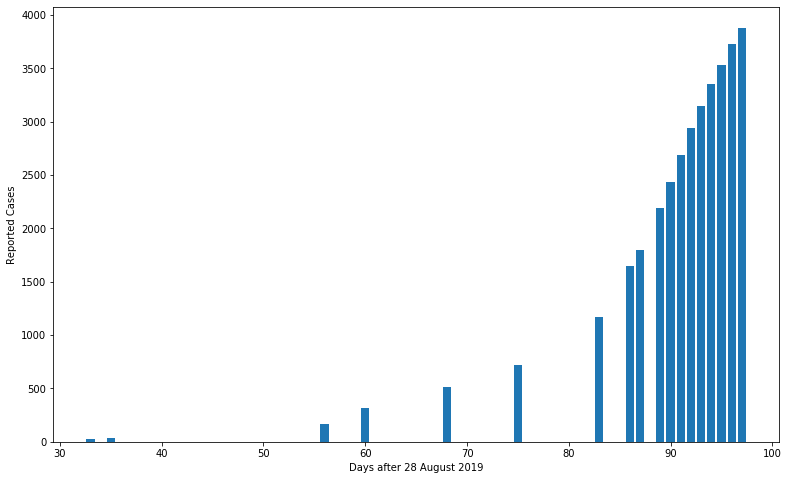

In [6]:
plt.figure(figsize=[13,8])
plt.bar(times, cumdata)
plt.ylabel("Reported Cases")
plt.xlabel("Days after 28 August 2019")

Text(0.5, 0, 'Days after 28 August 2019')

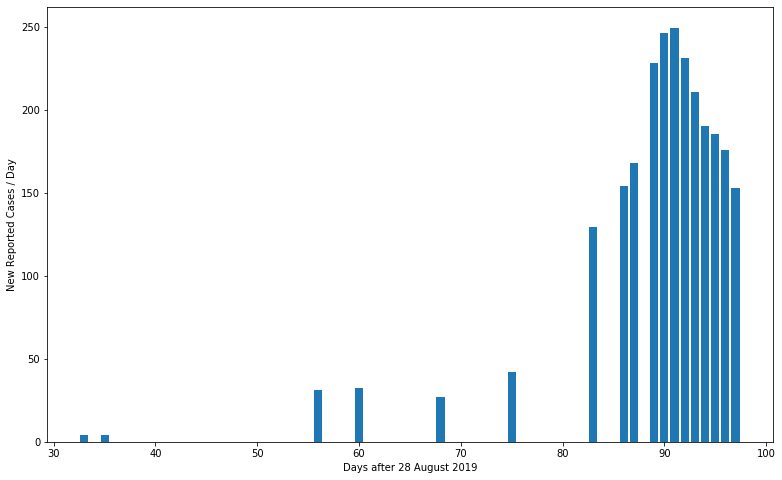

In [7]:
plt.figure(figsize=[13,8])
plt.bar(times, np.gradient(cumdata, times))
plt.ylabel("New Reported Cases / Day")
plt.xlabel("Days after 28 August 2019")

In [8]:
data_pd = np.array([[i] for i in cumdata])
p0 = [1/8, 1, 1/8]
config = {
    "grid_size": 100,
    "basis_number": 24,
    "model_form": {
        "state": 5,
        "parameters": 3
    },
    "time_span": [times[0], 130],
    "knot_function": None,
    "model": seir,
    "dataset": {"y": data_pd, "t": np.array(times)},
    "observation_vector": [-1],
    "weightings":[
        [1]*5,
        np.sqrt(times/np.mean(times))
    ],
    "regularisation_value": copy(p0),
}

In [9]:
model = modeller.Model(config)
config['regularisation_value'][1] = model.ps[1]
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),
}
ipopt_opts = {
    'ipopt': {
        'print_level': 5,
        'print_frequency_iter': 10,
        
    }
}

solver = ca.nlpsol('solver', 'ipopt', solver_setup, ipopt_opts)

In [10]:
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getp = ca.Function('getx', [solver_setup['x']], model.ps)


In [11]:
c0 = [max(cumdata)*np.ones(config['basis_number']) for _ in range(5)]
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*5) + [0]*len(config['regularisation_value'])
alpha = 1e3

In [12]:
pure_solve = solver(x0=x0, p=[0, 0], lbx=lbx, lbg=0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1835

Total number of variables............................:      123
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

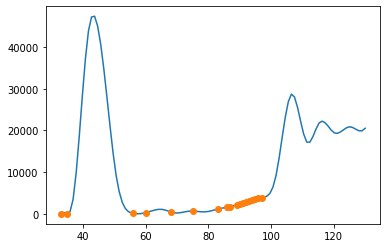

In [13]:
pure_xs = getx(pure_solve['x'])
plt.plot(model.observation_times, pure_xs[-1])
plt.plot(times, cumdata, 'o')

In [14]:
lbg = [0]*len(model.observation_times)*config['model_form']['state']
ubg = [140000]*len(model.observation_times)*config['model_form']['state']
# lbg[0] = 150000

In [15]:
prange = np.logspace(-6, 6, num=100)
sols = []
xguess = x0
for p in prange:
    solve_opts = {
        'x0': xguess,
        'p': [p, alpha],
        'lbx': lbx,
        'lbg': lbg,
        'ubg': ubg
    }
    print(f"Solving for p={p}")
    sols.append(solver(**solve_opts))
    xguess = np.array(sols[-1]['x']).flatten()

Solving for p=1e-06
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1835

Total number of variables............................:      123
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du

  10  2.9651184e+01 0.00e+00 6.89e-01  -2.5 1.64e+04    -  7.03e-01 1.00e+00f  1
  20  2.9295782e+01 0.00e+00 1.18e-06  -5.7 9.60e-01  -5.9 1.00e+00 1.00e+00h  1
  30  2.9291627e+01 0.00e+00 9.24e-04  -8.6 4.89e+02 -10.2 1.00e+00 1.00e+00f  1
  40  2.9290235e+01 0.00e+00 3.38e-03  -8.6 3.80e+03 -15.0 1.00e+00 1.00e+00h  1
  50  2.9290201e+01 0.00e+00 4.18e-03  -8.6 4.24e+03 -14.3 1.00e+00 5.00e-01h  2
  60  2.9290142e+01 0.00e+00 6.72e-03  -8.6 2.15e+03 -13.7 1.00e+00 1.00e+00h  1
  70  2.9289860e+01 0.00e+00 3.85e-03  -8.6 1.02e+03 -13.0 1.00e+00 1.00e+00f  1
  80  2.9289322e+01 0.00e+00 7.57e-04  -8.6 1.00e+02    -  8.22e-01 1.00e+00f  1
  90  2.9289300e+01 0.00e+00 1.78e-04  -8.6 8.97e+04    -  7.24e-02 3.12e-02h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.9289298e+01 0.00e+00 1.41e-05  -8.6 3.17e+04    -  1.00e+00 2.50e-01h  3

Number of Iterations....: 103

                                   (scaled)                 (unscaled)
Object

  30  2.9293927e+01 0.00e+00 3.64e-02  -8.6 1.66e+03 -11.6 8.49e-01 1.00e+00f  1
  40  2.9293303e+01 0.00e+00 1.05e-02  -8.6 7.00e+04 -14.6 9.05e-01 2.40e-01f  3
  50  2.9292575e+01 0.00e+00 1.45e-02  -8.6 3.27e+04 -14.0 1.00e+00 4.32e-01f  2
  60  2.9291478e+01 0.00e+00 5.94e-03  -8.6 2.27e+03 -14.2 1.00e+00 1.00e+00h  1
  70  2.9291466e+01 0.00e+00 2.38e-05  -8.6 1.26e+02 -15.2 1.00e+00 1.00e+00h  1

Number of Iterations....: 73

                                   (scaled)                 (unscaled)
Objective...............:   2.9291465783922654e+01    2.9291465783922654e+01
Dual infeasibility......:   3.0634923254909260e-09    3.0634923254909260e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.5059035596800622e-09
Overall NLP error.......:   3.0634923254909260e-09    3.0634923254909260e-09


Number of objective function evaluations             = 121
Number of objective gradient evaluations       

  20  2.9528666e+01 0.00e+00 8.03e-05  -5.7 1.47e+01  -6.4 1.00e+00 1.00e+00f  1
  30  2.9302677e+01 0.00e+00 1.24e-01  -5.7 1.71e+03 -11.2 8.26e-01 1.00e+00f  1
  40  2.9301274e+01 0.00e+00 1.70e-02  -5.7 1.95e+03 -14.1 1.00e+00 1.00e+00h  1
  50  2.9300930e+01 0.00e+00 4.73e-02  -5.7 7.85e+03 -13.5 1.00e+00 2.50e-01f  3
  60  2.9299816e+01 0.00e+00 4.16e-02  -5.7 2.08e+03 -12.8 1.00e+00 5.00e-01f  2
  70  2.9297038e+01 0.00e+00 1.11e-02  -5.7 3.46e+02 -11.3 1.00e+00 1.00e+00f  1
  80  2.9296538e+01 0.00e+00 7.64e-03  -5.7 1.99e+04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 89

                                   (scaled)                 (unscaled)
Objective...............:   2.9296473528402487e+01    2.9296473528402487e+01
Dual infeasibility......:   1.6306534833965497e-09    1.6306534833965497e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059122447435389e-09    2.5059122447435389e-09
Overall NLP error......

  20  2.9318894e+01 0.00e+00 1.05e-06  -5.7 2.85e-01  -5.4 1.00e+00 1.00e+00h  1
  30  2.9318132e+01 0.00e+00 8.21e-05  -8.6 5.97e+01 -10.2 1.00e+00 1.00e+00h  1
  40  2.9316249e+01 0.00e+00 1.30e-01  -8.6 2.40e+03 -11.4 1.00e+00 5.00e-01f  2
  50  2.9310027e+01 0.00e+00 1.03e-01  -8.6 1.13e+03 -11.6 1.00e+00 4.03e-01f  2
  60  2.9308048e+01 0.00e+00 2.66e-03  -8.6 2.69e+04    -  8.75e-01 2.50e-01h  3
  70  2.9308041e+01 0.00e+00 1.79e-06  -8.6 5.88e+02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 71

                                   (scaled)                 (unscaled)
Objective...............:   2.9308040564358446e+01    2.9308040564358446e+01
Dual infeasibility......:   1.4995712628376810e-09    1.4995712628376810e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059574707599428e-09    2.5059574707599428e-09
Overall NLP error.......:   2.5059574707599428e-09    2.5059574707599428e-09


Number of objective funct

  60  2.9334776e+01 0.00e+00 1.34e-05  -8.6 2.87e+01 -11.0 1.00e+00 1.00e+00f  1
  70  2.9334754e+01 0.00e+00 2.42e-10  -8.6 1.26e+01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 70

                                   (scaled)                 (unscaled)
Objective...............:   2.9334754188597476e+01    2.9334754188597476e+01
Dual infeasibility......:   2.4232647118467662e-10    2.4232647118467662e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5060096599398485e-09    2.5060096599398485e-09
Overall NLP error.......:   2.5060096599398485e-09    2.5060096599398485e-09


Number of objective function evaluations             = 102
Number of objective gradient evaluations             = 71
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 102
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 71
N

  30  2.9448724e+01 0.00e+00 7.58e-04  -8.6 6.37e+01  -9.7 1.00e+00 1.00e+00f  1
  40  2.9434158e+01 0.00e+00 1.93e-01  -8.6 6.85e+02 -10.9 1.00e+00 1.00e+00f  1
  50  2.9399137e+01 0.00e+00 1.31e-01  -8.6 2.16e+03 -12.0 1.00e+00 1.00e+00f  1
  60  2.9396425e+01 0.00e+00 3.69e-03  -8.6 5.09e+04    -  1.00e+00 5.18e-01h  1

Number of Iterations....: 65

                                   (scaled)                 (unscaled)
Objective...............:   2.9396425155223863e+01    2.9396425155223863e+01
Dual infeasibility......:   2.5567950865250891e-12    2.5567950865250891e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5265175027474739e-09    2.5265175027474739e-09
Overall NLP error.......:   2.5265175027474739e-09    2.5265175027474739e-09


Number of objective function evaluations             = 91
Number of objective gradient evaluations             = 66
Number of equality constraint evaluations            = 0
Number of ineq

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1835

Total number of variables............................:      123
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.9538703e+01 0.00e+00 1.02e+00  -1.0 0.00e+00    -  0.00e+00 0.

  30  2.9868110e+01 0.00e+00 1.00e+00  -5.7 3.17e+02    -  9.16e-01 1.00e+00f  1
  40  2.9866130e+01 0.00e+00 2.68e-05  -8.6 2.75e+03    -  1.00e+00 3.12e-02f  6

Number of Iterations....: 42

                                   (scaled)                 (unscaled)
Objective...............:   2.9866130030036427e+01    2.9866130030036427e+01
Dual infeasibility......:   6.5455122489212195e-10    6.5455122489212195e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   4.1842909338546145e-09    4.1842909338546145e-09
Overall NLP error.......:   4.1842909338546145e-09    4.1842909338546145e-09


Number of objective function evaluations             = 57
Number of objective gradient evaluations             = 43
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 57
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 43
Num

Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.0617247e+01 0.00e+00 1.09e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  3.2571757e+01 0.00e+00 3.75e+01  -1.7 2.88e+03    -  6.58e-01 1.00e+00f  1
  20  3.1274283e+01 0.00e+00 4.26e+00  -2.5 1.00e+04    -  8.53e-01 1.25e-01f  4
  30  3.1242298e+01 0.00e+00 4.48e-02  -3.8 1.71e+02  -9.2 1.00e+00 1.00e+00f  1
  40  3.1038821e+01 0.00e+00 5.19e+00  -3.8 1.53e+04 -11.3 6.68e-01 6.12e-02f  3
  50  3.0639662e+01 0.00e+00 1.68e+00  -3.8 3.91e+03    -  1.00e+00 2.38e-01f  3
  60  3.0617038e+01 0.00e+00 4.70e-01  -5.7 6.20e+02    -  9.63e-01 1.00e+00f  1
  70  3.0616467e+01 0.00e+00 5.92e-04  -8.6 1.05e+02    -  1.00e+00 5.00e-01f  2

Number of Ite

  30  3.4998249e+01 0.00e+00 8.12e+01  -1.7 1.34e+04    -  1.00e+00 2.50e-01f  3
  40  3.4790689e+01 0.00e+00 4.90e+01  -1.7 3.59e+03 -10.3 1.00e+00 1.00e+00f  1
  50  3.4784549e+01 0.00e+00 8.10e+00  -1.7 9.44e+02    -  1.00e+00 1.00e+00f  1
  60  3.4099247e+01 0.00e+00 9.23e+00  -3.8 1.44e+04    -  8.71e-01 2.50e-01f  3
  70  3.4033602e+01 0.00e+00 6.82e-01  -3.8 9.23e+02 -11.1 1.00e+00 1.00e+00f  1
  80  3.3924579e+01 0.00e+00 7.90e-01  -3.8 1.35e+03 -10.5 1.00e+00 1.00e+00f  1
  90  3.3621402e+01 0.00e+00 1.33e+01  -3.8 4.43e+03 -10.7 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.2639711e+01 0.00e+00 1.44e+01  -3.8 4.31e+03 -10.1 1.00e+00 1.98e-01f  2
 110  3.2326070e+01 0.00e+00 3.58e+00  -3.8 1.94e+04    -  1.00e+00 1.00e+00f  1
 120  3.2317992e+01 0.00e+00 3.20e-02  -5.7 4.71e+03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 129

                                   (scaled)                 (unscaled)
Object

  40  3.7417900e+01 0.00e+00 2.39e+01  -2.5 3.30e+04    -  1.00e+00 5.00e-01f  2
  50  3.7293040e+01 0.00e+00 8.02e-01  -2.5 8.59e+03    -  1.00e+00 1.00e+00f  1
  60  3.6979736e+01 0.00e+00 1.10e+01  -2.5 4.64e+03 -11.6 1.00e+00 2.50e-01f  3
  70  3.6086049e+01 0.00e+00 6.76e+00  -2.5 1.15e+03 -10.5 1.00e+00 1.00e+00f  1
  80  3.4776475e+01 0.00e+00 3.80e+00  -2.5 2.34e+03 -10.7 1.00e+00 1.00e+00f  1
  90  3.4629881e+01 0.00e+00 5.89e-01  -2.5 2.16e+03    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.4497316e+01 0.00e+00 1.91e-07  -3.8 8.12e+00    -  1.00e+00 1.00e+00h  1
 110  3.4495127e+01 0.00e+00 1.67e-04  -8.6 3.36e+01    -  1.00e+00 2.50e-01f  3

Number of Iterations....: 112

                                   (scaled)                 (unscaled)
Objective...............:   3.4495126623640147e+01    3.4495126623640147e+01
Dual infeasibility......:   6.0050591099670405e-11    6.0050591099670405e-11
Constraint vio


Number of Iterations....: 43

                                   (scaled)                 (unscaled)
Objective...............:   4.0739628323550825e+01    4.0739628323550825e+01
Dual infeasibility......:   1.7411382372544445e-11    1.7411382372544445e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5105553191500069e-09    2.5105553191500069e-09
Overall NLP error.......:   2.5105553191500069e-09    2.5105553191500069e-09


Number of objective function evaluations             = 67
Number of objective gradient evaluations             = 44
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 67
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 44
Number of Lagrangian Hessian evaluations             = 43
Total CPU secs in IPOPT (w/o function evaluations)   =      0.066
Total CPU secs in NLP function evaluation


Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1835

Total number of variables............................:      123
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.9518419e+01 0.00e+00 2.99e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  6.0155492e+01 0.00e+00 5.15e-01  -1.7 1.25e+04    -  9.52e-01

                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.4713282e+01 0.00e+00 4.40e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  8.4594659e+01 0.00e+00 8.52e+00  -1.7 4.41e+03    -  7.14e-01 1.00e+00f  1
  20  8.3924706e+01 0.00e+00 4.09e-04  -2.5 5.22e+01    -  1.00e+00 1.00e+00h  1
  30  8.3883499e+01 0.00e+00 4.12e-02  -5.7 1.43e+04    -  1.00e+00 5.00e-01f  2

Number of Iterations....: 36

                                   (scaled)        

  20  1.1727627e+02 0.00e+00 9.00e-01  -8.6 4.47e+04    -  6.75e-01 9.54e-01f  1

Number of Iterations....: 23

                                   (scaled)                 (unscaled)
Objective...............:   1.1727625765590059e+02    1.1727625765590059e+02
Dual infeasibility......:   2.6487400572737103e-10    2.6487400572737103e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.6789258518484764e-09    2.6789258518484764e-09
Overall NLP error.......:   2.6789258518484764e-09    2.6789258518484764e-09


Number of objective function evaluations             = 37
Number of objective gradient evaluations             = 24
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 37
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 24
Number of Lagrangian Hessian evaluations             = 23
Total CPU secs in IPOPT (w

  10  1.7577443e+02 0.00e+00 3.85e+01  -1.7 1.22e+04    -  8.81e-01 1.00e+00f  1
  20  1.7550483e+02 0.00e+00 6.94e-01  -2.5 8.66e+02    -  1.00e+00 1.00e+00f  1
  30  1.7549307e+02 0.00e+00 7.52e-02  -5.7 3.55e+02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 38

                                   (scaled)                 (unscaled)
Objective...............:   1.7549293945506443e+02    1.7549293945506443e+02
Dual infeasibility......:   1.7764990510996042e-10    1.7764990510996042e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5405848585564673e-09    2.5405848585564673e-09
Overall NLP error.......:   2.5405848585564673e-09    2.5405848585564673e-09


Number of objective function evaluations             = 55
Number of objective gradient evaluations             = 39
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 55
Number of equality constraint Jacobia

  20  2.4349188e+02 0.00e+00 3.39e+01  -1.7 2.09e+04    -  1.00e+00 1.00e+00f  1
  30  2.4336023e+02 0.00e+00 1.09e-04  -5.7 1.93e-01  -6.9 1.00e+00 1.00e+00f  1

Number of Iterations....: 33

                                   (scaled)                 (unscaled)
Objective...............:   2.4336022710181024e+02    2.4336022710181024e+02
Dual infeasibility......:   2.1495259673479632e-09    2.1495259673479632e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035859150780e-09    2.5059035859150780e-09
Overall NLP error.......:   2.5059035859150780e-09    2.5059035859150780e-09


Number of objective function evaluations             = 46
Number of objective gradient evaluations             = 34
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 46
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 34
Num

  40  3.6069786e+02 0.00e+00 6.86e+01  -9.0 2.61e+02  -8.9 1.00e+00 1.00e+00f  1
  50  3.6003475e+02 0.00e+00 9.88e+00  -9.0 1.96e+03  -9.1 1.00e+00 1.00e+00f  1

Number of Iterations....: 57

                                   (scaled)                 (unscaled)
Objective...............:   3.5959532044410150e+02    3.5959532044410150e+02
Dual infeasibility......:   5.7638363185434855e-11    5.7638363185434855e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090931e-10    9.0909090909090931e-10
Overall NLP error.......:   9.0909090909090931e-10    9.0909090909090931e-10


Number of objective function evaluations             = 75
Number of objective gradient evaluations             = 58
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 75
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 58
Num

  70  5.6483980e+02 0.00e+00 1.58e+01  -5.7 5.33e+02  -8.0 1.00e+00 1.00e+00f  1

Number of Iterations....: 78

                                   (scaled)                 (unscaled)
Objective...............:   5.0570924185087387e+02    5.6381190637803627e+02
Dual infeasibility......:   3.7142479628984703e-11    4.1409906155918227e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5060105140698702e-09    2.7939346336047086e-09
Overall NLP error.......:   2.5060105140698702e-09    2.7939346336047086e-09


Number of objective function evaluations             = 106
Number of objective gradient evaluations             = 79
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 106
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 79
Number of Lagrangian Hessian evaluations             = 78
Total CPU secs in IPOPT 

  10  1.0585606e+03 0.00e+00 6.60e+01  -1.0 2.90e+03    -  4.64e-01 1.00e+00f  1
  20  1.0653167e+03 0.00e+00 2.90e+01  -1.0 3.20e+00  -5.0 1.00e+00 1.00e+00f  1
  30  1.0639443e+03 0.00e+00 1.57e-01  -3.8 2.83e+00  -7.4 1.00e+00 1.00e+00f  1
  40  1.0626581e+03 0.00e+00 4.71e+00  -5.7 1.32e+02  -8.5 1.00e+00 1.00e+00f  1
  50  1.0610162e+03 0.00e+00 4.65e-03  -5.7 8.33e+01  -7.9 1.00e+00 1.00e+00f  1
  60  1.0579944e+03 0.00e+00 4.44e+00  -5.7 4.52e+02  -8.2 1.00e+00 1.00e+00f  1
  70  1.0511698e+03 0.00e+00 8.63e-01  -5.7 1.35e+00  -4.8 1.00e+00 1.00e+00f  1
  80  1.0508198e+03 0.00e+00 3.34e-11  -9.0 2.77e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 80

                                   (scaled)                 (unscaled)
Objective...............:   5.5240589663918809e+02    1.0508198390985312e+03
Dual infeasibility......:   3.3376494103507382e-11    6.3490781646070901e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity....

  10  1.6419780e+03 0.00e+00 5.27e+02  -1.0 5.91e+02    -  8.05e-01 1.00e+00f  1
  20  1.6361641e+03 0.00e+00 2.27e-04  -2.5 1.42e+00    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 28

                                   (scaled)                 (unscaled)
Objective...............:   6.2806803946719072e+02    1.6360421545026156e+03
Dual infeasibility......:   1.6083596855785948e-10    4.1895846944248324e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059055693311707e-09    6.5275844160238265e-09
Overall NLP error.......:   2.5059055693311707e-09    6.5275844160238265e-09


Number of objective function evaluations             = 34
Number of objective gradient evaluations             = 29
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 34
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 29
Num


                                   (scaled)                 (unscaled)
Objective...............:   7.3987760358225842e+02    2.4462486866479603e+03
Dual infeasibility......:   2.0575421113043782e-10    6.8028274719111922e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059050978717670e-09    8.2852447821820131e-09
Overall NLP error.......:   2.5059050978717670e-09    8.2852447821820131e-09


Number of objective function evaluations             = 32
Number of objective gradient evaluations             = 28
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 32
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 28
Number of Lagrangian Hessian evaluations             = 27
Total CPU secs in IPOPT (w/o function evaluations)   =      0.043
Total CPU secs in NLP function evaluations           =      0.015

EXIT

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1835

Total number of variables............................:      123
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.8992969e+03 0.00e+00 1.01e+02  -1.0 0.00e+00    -  0.00e+00 0.

  30  5.3757182e+03 0.00e+00 9.03e+02  -1.7 6.99e+03    -  9.74e-01 5.00e-01f  2
  40  5.3739513e+03 0.00e+00 4.89e+00  -3.8 2.24e+01  -7.3 1.00e+00 1.00e+00f  1
  50  5.3729645e+03 0.00e+00 2.50e-01  -3.8 5.97e+00  -6.6 1.00e+00 1.00e+00f  1
  60  5.3704249e+03 0.00e+00 1.27e-01  -3.8 3.04e-01  -5.1 1.00e+00 1.00e+00f  1
  70  5.3689222e+03 0.00e+00 3.74e+00  -3.8 3.34e-01  -4.4 1.00e+00 1.00e+00f  1
  80  5.3672751e+03 0.00e+00 3.83e+02  -3.8 1.83e+00  -3.8 1.00e+00 1.00e+00f  1
  90  5.3656545e+03 0.00e+00 3.86e+02  -3.8 3.72e+03  -8.6 1.00e+00 5.79e-02f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.3651639e+03 0.00e+00 1.54e-09  -5.7 3.38e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 102

                                   (scaled)                 (unscaled)
Objective...............:   1.3047375576552110e+03    5.3651639348174849e+03
Dual infeasibility......:   2.4902908209620318e-09    1.0240234460517643e-08
Constraint vio

  20  5.9946231e+03 0.00e+00 1.09e+04  -1.0 1.38e+03    -  8.15e-01 1.00e+00f  1
  30  5.9879241e+03 0.00e+00 2.51e+02  -1.7 5.97e+00  -5.0 1.00e+00 5.00e-01f  2
  40  5.9895243e+03 0.00e+00 1.48e+03  -1.7 1.11e+04    -  8.78e-01 2.50e-01f  3
  50  5.9888728e+03 0.00e+00 1.06e+01  -2.5 3.65e+00  -6.8 1.00e+00 1.00e+00f  1
  60  5.9883197e+03 0.00e+00 3.02e-01  -2.5 6.69e-01  -6.1 1.00e+00 1.00e+00f  1
  70  5.9876990e+03 0.00e+00 2.60e-01  -3.8 1.29e-01  -4.6 1.00e+00 1.00e+00f  1
  80  5.9873451e+03 0.00e+00 7.39e+02  -3.8 2.82e+02  -8.4 1.00e+00 1.00e+00f  1
  90  5.9869628e+03 0.00e+00 2.27e+01  -3.8 4.69e+02  -8.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.9866406e+03 0.00e+00 3.32e+00  -3.8 1.17e+02  -8.0 1.00e+00 1.00e+00f  1
 110  5.9862139e+03 0.00e+00 3.51e-01  -3.8 3.01e+01  -7.4 1.00e+00 1.00e+00f  1
 120  5.9852985e+03 0.00e+00 1.13e-01  -3.8 1.13e+00  -5.8 1.00e+00 1.00e+00f  1
 130  5.9845254e+03 0.00e+00

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1835

Total number of variables............................:      123
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.4612987e+03 0.00e+00 1.01e+02  -1.0 0.00e+00    -  0.00e+00 0.

 320  6.5556170e+03 0.00e+00 3.16e+00  -3.8 6.61e-01  -6.2 1.00e+00 1.00e+00f  1
 330  6.5555617e+03 0.00e+00 6.38e-06  -3.8 3.14e-04    -  1.00e+00 1.00e+00h  1
 340  6.5555498e+03 0.00e+00 7.28e-09  -9.0 2.97e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 340

                                   (scaled)                 (unscaled)
Objective...............:   2.8843748184287551e+03    6.5555498375749885e+03
Dual infeasibility......:   7.2823719862053833e-09    1.6551230508015386e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0946188601171179e-10    2.0670069233139728e-09
Overall NLP error.......:   7.2823719862053833e-09    1.6551230508015386e-08


Number of objective function evaluations             = 719
Number of objective gradient evaluations             = 341
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 719
Number of equality constraint Jac

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1835

Total number of variables............................:      123
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.8399456e+03 0.00e+00 1.01e+02  -1.0 0.00e+00    -  0.00e+00 0.

  30  6.9717263e+03 0.00e+00 8.64e+04  -1.0 6.75e+03    -  6.86e-01 2.50e-01f  3
  40  6.9664613e+03 0.00e+00 1.01e+02  -1.0 3.80e-01  -2.9 1.00e+00 1.00e+00f  1
  50  6.9661423e+03 0.00e+00 7.24e+00  -1.0 9.71e-02  -2.7 1.00e+00 1.00e+00f  1
  60  6.9661089e+03 0.00e+00 4.20e+01  -1.0 2.50e-01  -3.3 1.00e+00 1.00e+00f  1
  70  6.9661191e+03 0.00e+00 5.94e+00  -1.0 1.03e-01  -2.9 1.00e+00 1.00e+00f  1
  80  6.9661571e+03 0.00e+00 1.40e+00  -1.0 4.46e-02  -2.6 1.00e+00 1.00e+00f  1
  90  6.9659471e+03 0.00e+00 2.28e+03  -1.7 9.12e-01  -4.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.9659251e+03 0.00e+00 4.97e+02  -1.7 6.99e-01  -5.2 1.00e+00 1.00e+00f  1
 110  6.9659470e+03 0.00e+00 3.19e+03  -1.7 1.82e+04    -  1.00e+00 1.25e-01f  4
 120  6.9658933e+03 0.00e+00 1.76e+03  -2.5 3.98e+00  -4.6 1.00e+00 5.00e-01f  2
 130  6.9658855e+03 0.00e+00 1.49e+03  -2.5 1.18e+00  -5.7 1.00e+00 1.00e+00f  1
 140  6.9658808e+03 0.00e+00

 980  6.9658086e+03 0.00e+00 8.00e-07  -9.0 6.63e-10    -  1.00e+00 2.50e-01f  3
 990  6.9658086e+03 0.00e+00 4.16e-07  -9.0 6.43e-09    -  1.00e+00 1.00e+00F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  6.9658086e+03 0.00e+00 2.13e-06  -9.0 2.20e-09    -  1.00e+00 1.53e-05f 17
1010  6.9658086e+03 0.00e+00 2.02e-06  -9.0 2.14e-09    -  1.00e+00 1.00e+00F  1
1020  6.9658086e+03 0.00e+00 2.37e-06  -9.0 3.58e-09    -  1.00e+00 1.00e+00H  1
1030  6.9658086e+03 0.00e+00 1.29e-06  -9.0 5.97e-09    -  1.00e+00 1.00e+00F  1
1040  6.9658086e+03 0.00e+00 9.55e-07  -9.0 5.00e-09    -  1.00e+00 1.00e+00H  1
1050  6.9658086e+03 0.00e+00 4.36e-06  -9.0 1.51e-09    -  1.00e+00 1.00e+00F  1
1060  6.9658086e+03 0.00e+00 1.90e-06  -9.0 3.18e-10    -  1.00e+00 1.00e+00H  1
1070  6.9658086e+03 0.00e+00 1.10e-06  -9.0 9.79e-09    -  1.00e+00 5.00e-01h  2
1080  6.9658086e+03 0.00e+00 1.70e-06  -9.0 3.84e-09    -  1.00e+00 1.56e-02f  7
1090  6.9658086e+03 0.00e+00

1980  6.9658086e+03 0.00e+00 2.52e-06  -9.0 4.66e-09    -  1.00e+00 7.63e-06f 18
1990  6.9658086e+03 0.00e+00 3.26e-07  -9.0 3.81e-09    -  1.00e+00 1.00e+00F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  6.9658086e+03 0.00e+00 1.40e-06  -9.0 5.52e-09    -  1.00e+00 5.00e-01f  2
2010  6.9658086e+03 0.00e+00 2.96e-06  -9.0 3.63e-09    -  1.00e+00 1.00e+00H  1
2020  6.9658086e+03 0.00e+00 2.90e-06  -9.0 1.90e-09    -  1.00e+00 1.00e+00H  1
2030  6.9658086e+03 0.00e+00 1.13e-06  -9.0 7.95e-09    -  1.00e+00 1.00e+00H  1
2040  6.9658086e+03 0.00e+00 1.51e-07  -9.0 1.62e-09    -  1.00e+00 1.00e+00h  1
2050  6.9658086e+03 0.00e+00 1.22e-06  -9.0 5.68e-09    -  1.00e+00 3.81e-06f 19
2060  6.9658086e+03 0.00e+00 5.26e-07  -9.0 1.80e-10    -  1.00e+00 1.00e+00F  1
2070  6.9658086e+03 0.00e+00 3.26e-07  -9.0 1.03e-08    -  1.00e+00 1.00e+00H  1
2080  6.9658086e+03 0.00e+00 1.31e-07  -9.0 1.58e-08    -  1.00e+00 1.91e-06f 20
2090  6.9658086e+03 0.00e+00

 400  7.1260337e+03 0.00e+00 1.50e-06  -8.6 4.02e-10    -  1.00e+00 1.00e+00H  1
 410  7.1260337e+03 0.00e+00 2.31e-07  -8.6 8.54e-09    -  1.00e+00 5.00e-01f  2
 420  7.1260337e+03 0.00e+00 2.97e-06  -8.6 9.09e-10    -  1.00e+00 2.50e-01f  3
 430  7.1260337e+03 0.00e+00 1.14e-06  -8.6 3.89e-09    -  1.00e+00 1.00e+00f  1
 440  7.1260337e+03 0.00e+00 4.21e-06  -8.6 1.99e-09    -  1.00e+00 1.25e-01h  4
 450  7.1260337e+03 0.00e+00 2.10e-06  -8.6 7.75e-09    -  1.00e+00 3.81e-06f 19
 460  7.1260337e+03 0.00e+00 2.92e-07  -8.6 2.34e-09    -  1.00e+00 6.25e-02f  5
 470  7.1260337e+03 0.00e+00 1.00e-06  -8.6 1.02e-08    -  1.00e+00 3.05e-05f 16
 480  7.1260337e+03 0.00e+00 2.53e-07  -8.6 4.81e-09    -  1.00e+00 2.50e-01f  3
 490  7.1260337e+03 0.00e+00 9.24e-07  -8.6 1.17e-08    -  1.00e+00 7.81e-03f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  7.1260337e+03 0.00e+00 3.59e-06  -8.6 2.15e-09    -  1.00e+00 1.53e-05f 17
 510  7.1260337e+03 0.00e+00

1330  7.1260337e+03 0.00e+00 2.82e-06  -8.6 1.09e-08    -  1.00e+00 1.00e+00H  1
1340  7.1260337e+03 0.00e+00 2.73e-06  -8.6 5.00e-09    -  1.00e+00 1.00e+00F  1
1350  7.1260337e+03 0.00e+00 1.56e-06  -8.6 3.70e-10    -  1.00e+00 1.00e+00F  1
1360  7.1260337e+03 0.00e+00 2.47e-07  -8.6 4.61e-10    -  1.00e+00 1.00e+00H  1
1370  7.1260337e+03 0.00e+00 1.29e-06  -8.6 9.56e-10    -  1.00e+00 1.00e+00H  1
1380  7.1260337e+03 0.00e+00 2.69e-06  -8.6 5.45e-09    -  1.00e+00 1.00e+00H  1
1390  7.1260337e+03 0.00e+00 3.25e-06  -8.6 2.55e-09    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  7.1260337e+03 0.00e+00 4.49e-06  -8.6 1.07e-08    -  1.00e+00 1.00e+00F  1
1410  7.1260337e+03 0.00e+00 3.07e-06  -8.6 1.94e-10    -  1.00e+00 1.00e+00f  1
1420  7.1260337e+03 0.00e+00 2.94e-06  -8.6 4.56e-09    -  1.00e+00 6.25e-02f  5
1430  7.1260337e+03 0.00e+00 2.46e-06  -8.6 1.75e-09    -  1.00e+00 5.00e-01h  2
1440  7.1260337e+03 0.00e+00

2360  7.1260337e+03 0.00e+00 2.60e-06  -9.0 1.74e-09    -  1.00e+00 1.00e+00H  1
2370  7.1260337e+03 0.00e+00 4.54e-06  -9.0 4.71e-09    -  1.00e+00 5.00e-01h  2
2380  7.1260337e+03 0.00e+00 5.23e-07  -9.0 7.47e-09    -  1.00e+00 3.12e-02f  6
2390  7.1260337e+03 0.00e+00 5.19e-07  -9.0 1.66e-09    -  1.00e+00 1.00e+00F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2400  7.1260337e+03 0.00e+00 2.87e-06  -9.0 1.36e-09    -  1.00e+00 1.00e+00H  1
2410  7.1260337e+03 0.00e+00 4.01e-07  -9.0 9.27e-10    -  1.00e+00 1.00e+00H  1
2420  7.1260337e+03 0.00e+00 5.52e-07  -9.0 1.49e-09    -  1.00e+00 1.25e-01f  4
2430  7.1260337e+03 0.00e+00 9.74e-07  -9.0 2.41e-10    -  1.00e+00 1.00e+00F  1
2440  7.1260337e+03 0.00e+00 1.33e-06  -9.0 9.05e-09    -  1.00e+00 1.00e+00H  1
2450  7.1260337e+03 0.00e+00 7.24e-07  -9.0 7.80e-09    -  1.00e+00 1.00e+00h  1
2460  7.1260337e+03 0.00e+00 2.55e-07  -9.0 5.15e-10    -  1.00e+00 1.00e+00h  1
2470  7.1260337e+03 0.00e+00

        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.3223639e+03 0.00e+00 1.01e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  7.3621868e+03 0.00e+00 7.17e+04  -1.0 1.36e+03    -  5.06e-01 1.25e-01f  4
  20  7.3333607e+03 0.00e+00 2.26e+03  -1.0 5.80e-01  -2.2 1.00e+00 1.00e+00f  1
  30  7.3260951e+03 0.00e+00 1.80e+04  -1.0 4.34e+00  -3.4 1.00e+00 1.00e+00f  1
  40  7.3186172e+03 0.00e+00 2.16e+04  -1.0 2.56e+00  -3.2 1.00e+00 1.00e+00f  1
  50  7.3130491e+03 0.00e+00 4.47e+04  -1.0 1.88e+03    -  5.48e-01 2.50e-01f  3
  60  7.3098418e+03 0.00e+00 6.13e+03  -1.0 8.02e+03    -  5.41e-01 6.25e-02f  5
  70  7.3088245e+03 0.00e+00 3.51e+01  -1.0 1.68e-01  -2.8 1.00e+00 1.00e+00f  1
  80  7.3082517e+03 0.00e+00 1.32e+03  -1.7 6.22e-01  -3.9 1.00e+00 1.00e+00f 

 910  7.3079057e+03 0.00e+00 1.06e-05  -8.6 1.34e-08    -  1.00e+00 3.81e-06h 19
 920  7.3079057e+03 0.00e+00 1.52e-06  -8.6 4.99e-09    -  1.00e+00 1.56e-02f  7
 930  7.3079057e+03 0.00e+00 1.99e-06  -8.6 5.28e-09    -  1.00e+00 1.00e+00F  1
 940  7.3079057e+03 0.00e+00 3.29e-06  -8.6 1.33e-08    -  1.00e+00 1.00e+00F  1
 950  7.3079057e+03 0.00e+00 4.34e-06  -8.6 7.74e-09    -  1.00e+00 1.00e+00H  1
 960  7.3079057e+03 0.00e+00 7.29e-06  -8.6 4.22e-09    -  1.00e+00 1.00e+00F  1
 970  7.3079057e+03 0.00e+00 1.84e-07  -8.6 2.30e-09    -  1.00e+00 1.00e+00F  1
 980  7.3079057e+03 0.00e+00 7.70e-06  -8.6 9.46e-09    -  1.00e+00 1.00e+00F  1
 990  7.3079057e+03 0.00e+00 4.40e-06  -8.6 3.15e-09    -  1.00e+00 1.00e+00F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  7.3079057e+03 0.00e+00 7.36e-06  -8.6 3.64e-10    -  1.00e+00 1.00e+00F  1
1010  7.3079057e+03 0.00e+00 1.75e-06  -8.6 1.36e-08    -  1.00e+00 1.00e+00H  1
1020  7.3079057e+03 0.00e+00

 150  7.5162254e+03 0.00e+00 8.15e+03  -3.8 8.33e+00  -4.6 1.00e+00 2.50e-01f  3
 160  7.5162064e+03 0.00e+00 3.81e+03  -3.8 2.83e+00  -6.2 1.00e+00 1.00e+00f  1
 170  7.5161890e+03 0.00e+00 1.72e+01  -3.8 1.46e-01  -4.6 1.00e+00 1.00e+00f  1
 180  7.5161730e+03 0.00e+00 2.86e+01  -3.8 3.38e-01  -5.1 1.00e+00 1.00e+00f  1
 190  7.5161635e+03 0.00e+00 4.85e+02  -3.8 4.19e-01  -5.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  7.5161602e+03 0.00e+00 8.26e+02  -3.8 4.94e+00  -8.7 1.00e+00 1.00e+00f  1
 210  7.5161444e+03 0.00e+00 7.83e-01  -3.8 1.93e-01  -5.7 1.00e+00 1.00e+00h  1
 220  7.5161144e+03 0.00e+00 3.10e-01  -3.8 1.78e-02  -5.4 1.00e+00 1.00e+00f  1
 230  7.5160952e+03 0.00e+00 1.19e-04  -5.7 2.42e-04  -3.7 1.00e+00 1.00e+00f  1
 240  7.5160949e+03 0.00e+00 2.28e-07  -8.6 2.94e-09    -  1.00e+00 1.00e+00F  1
 250  7.5160949e+03 0.00e+00 2.03e-07  -8.6 6.35e-09    -  1.00e+00 1.25e-01f  4
 260  7.5160949e+03 0.00e+00

1080  7.5160949e+03 0.00e+00 1.48e-06  -8.6 9.35e-09    -  1.00e+00 7.63e-06f 18
1090  7.5160949e+03 0.00e+00 1.29e-06  -8.6 6.77e-09    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  7.5160949e+03 0.00e+00 1.95e-06  -8.6 1.92e-09    -  1.00e+00 1.00e+00h  1
1110  7.5160949e+03 0.00e+00 4.26e-06  -8.6 2.89e-09    -  1.00e+00 1.00e+00H  1
1120  7.5160949e+03 0.00e+00 2.05e-07  -8.6 9.49e-09    -  1.00e+00 1.00e+00H  1
1130  7.5160949e+03 0.00e+00 3.80e-06  -8.6 7.43e-09    -  1.00e+00 9.77e-04f 11
1140  7.5160949e+03 0.00e+00 1.18e-06  -8.6 9.84e-10    -  1.00e+00 1.00e+00H  1
1150  7.5160949e+03 0.00e+00 3.26e-06  -8.6 6.64e-10    -  1.00e+00 1.22e-04f 14
1160  7.5160949e+03 0.00e+00 3.12e-06  -8.6 1.50e-09    -  1.00e+00 1.00e+00H  1
1170  7.5160949e+03 0.00e+00 1.18e-06  -8.6 9.63e-09    -  1.00e+00 1.00e+00F  1
1180  7.5160949e+03 0.00e+00 1.29e-06  -8.6 1.05e-09    -  1.00e+00 1.00e+00H  1
1190  7.5160949e+03 0.00e+00

2020  7.5160949e+03 0.00e+00 1.86e-06  -9.0 1.17e-08    -  1.00e+00 1.00e+00H  1
2030  7.5160949e+03 0.00e+00 9.27e-07  -9.0 4.78e-09    -  1.00e+00 1.00e+00F  1
2040  7.5160949e+03 0.00e+00 1.16e-06  -9.0 7.74e-09    -  1.00e+00 6.10e-05f 15
2050  7.5160949e+03 0.00e+00 8.14e-07  -9.0 4.65e-09    -  1.00e+00 1.00e+00H  1
2060  7.5160949e+03 0.00e+00 6.14e-06  -9.0 2.78e-09    -  1.00e+00 1.00e+00F  1
2070  7.5160949e+03 0.00e+00 2.51e-06  -9.0 9.04e-10    -  1.00e+00 1.00e+00H  1
2080  7.5160949e+03 0.00e+00 2.66e-07  -9.0 1.39e-08    -  1.00e+00 1.00e+00F  1
2090  7.5160949e+03 0.00e+00 1.41e-06  -9.0 3.80e-09    -  1.00e+00 3.91e-03f  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  7.5160949e+03 0.00e+00 4.22e-06  -9.0 4.56e-09    -  1.00e+00 1.00e+00H  1
2110  7.5160949e+03 0.00e+00 4.11e-06  -9.0 4.09e-09    -  1.00e+00 1.53e-05f 17
2120  7.5160949e+03 0.00e+00 4.72e-06  -9.0 1.17e-08    -  1.00e+00 1.00e+00H  1
2130  7.5160949e+03 0.00e+00

2970r 7.5160949e+03 0.00e+00 9.85e+02  -9.0 0.00e+00    -  0.00e+00 4.77e-07R 22
Restoration phase converged to a feasible point that is
unacceptable to the filter for the original problem.
Restoration phase in the restoration phase failed.

Number of Iterations....: 2974

                                   (scaled)                 (unscaled)
Objective...............:   5.7723553135115344e+03    1.0059756424183259e+04
Dual infeasibility......:   4.2231451467204688e+05    7.3598746460628277e+05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.5177649717741767e-10    6.1305752767399191e-10
Overall NLP error.......:   4.2231451467204688e+05    7.3598746460628277e+05


Number of objective function evaluations             = 19151
Number of objective gradient evaluations             = 2967
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 19151
Number of equality constraint

 730  2.4854294e+05 0.00e+00 1.27e+04  -1.0 2.42e+02  -9.3 1.00e+00 2.50e-01f  3
 740  2.5163513e+05 0.00e+00 1.95e+04  -1.0 1.05e+05    -  7.16e-02 1.95e-02f  6
 750  2.5091890e+05 0.00e+00 9.18e+03  -1.0 6.23e+01  -8.4 1.00e+00 1.00e+00f  1
 760  2.5210936e+05 0.00e+00 3.96e+03  -1.0 4.56e+01  -8.7 1.00e+00 1.00e+00f  1
 770  2.5322201e+05 0.00e+00 3.61e+03  -1.0 1.29e+02  -8.9 1.00e+00 1.00e+00f  1
 780  2.5430828e+05 0.00e+00 5.16e+03  -1.0 5.40e+01  -8.3 1.00e+00 1.00e+00f  1
 790  2.5505404e+05 0.00e+00 2.12e+03  -1.0 4.06e+01  -8.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  2.5617077e+05 0.00e+00 1.68e+04  -1.0 2.02e+02  -8.8 1.00e+00 5.00e-01f  2
 810  2.5673357e+05 0.00e+00 1.39e+04  -1.0 1.08e+02  -9.0 1.00e+00 1.00e+00f  1
 820  2.5800602e+05 0.00e+00 2.76e+04  -1.0 3.19e+02  -9.3 1.00e+00 5.00e-01f  2
 830  2.5833170e+05 0.00e+00 1.29e+04  -1.0 4.33e+02  -8.6 1.00e+00 2.50e-01f  3
 840  2.5850522e+05 0.00e+00

1750  8.9844702e+04 0.00e+00 7.13e+03  -2.5 3.87e+02  -7.1 1.00e+00 1.00e+00f  1
1760  7.0487080e+04 0.00e+00 4.20e+02  -2.5 7.85e+01  -6.5 1.00e+00 1.00e+00f  1
1770  5.8111894e+04 0.00e+00 5.56e+02  -2.5 1.16e+02  -6.8 1.00e+00 1.00e+00f  1
1780  4.6033607e+04 0.00e+00 2.62e+03  -2.5 1.84e+02  -7.0 1.00e+00 1.00e+00f  1
1790  3.7402920e+04 0.00e+00 5.35e+03  -2.5 2.77e+02  -7.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1800  3.0615066e+04 0.00e+00 3.99e+03  -2.5 3.62e+02  -7.5 1.00e+00 1.00e+00f  1
1810  2.6308913e+04 0.00e+00 2.86e+02  -2.5 7.47e+01  -6.9 1.00e+00 1.00e+00f  1
1820  2.2222126e+04 0.00e+00 7.70e+01  -2.5 9.35e+01  -7.1 1.00e+00 1.00e+00f  1
1830  1.9512723e+04 0.00e+00 1.41e+03  -2.5 1.54e+02  -7.4 1.00e+00 1.00e+00f  1
1840  1.7810031e+04 0.00e+00 2.36e+03  -2.5 2.09e+02  -7.6 1.00e+00 1.00e+00f  1
1850  1.6295350e+04 0.00e+00 3.27e+03  -2.5 2.47e+02  -7.9 1.00e+00 1.00e+00f  1
1860  1.5507190e+04 0.00e+00

2720  1.3644825e+04 0.00e+00 2.75e+02  -3.8 6.56e+01  -8.8 1.00e+00 1.00e+00f  1
2730  1.3616918e+04 0.00e+00 1.20e+02  -3.8 2.93e+02  -9.0 1.00e+00 1.25e-01f  4
2740  1.3585346e+04 0.00e+00 4.32e+02  -3.8 4.52e+01  -8.4 1.00e+00 1.00e+00f  1
2750  1.3559091e+04 0.00e+00 4.99e+02  -3.8 7.58e+01  -8.6 1.00e+00 1.00e+00f  1
2760  1.3529704e+04 0.00e+00 1.08e+02  -3.8 2.05e+01  -8.0 1.00e+00 1.00e+00f  1
2770  1.3502405e+04 0.00e+00 4.80e+02  -3.8 3.94e+01  -8.2 1.00e+00 1.00e+00f  1
2780  1.3479501e+04 0.00e+00 1.85e+01  -3.8 8.71e+00  -7.6 1.00e+00 1.00e+00f  1
2790  1.3444368e+04 0.00e+00 2.66e+02  -3.8 2.96e+01  -7.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2800  1.3421081e+04 0.00e+00 3.71e+02  -3.8 1.44e+02  -9.0 1.00e+00 2.50e-01f  3
2810  1.3395824e+04 0.00e+00 6.46e+02  -3.8 4.85e+01  -8.4 1.00e+00 1.00e+00f  1
2820  1.3376090e+04 0.00e+00 2.42e+02  -3.8 1.22e+02  -8.6 1.00e+00 2.50e-01f  3
2830  1.3351383e+04 0.00e+00

 350  3.1953145e+05 0.00e+00 1.49e+04  -1.0 4.36e+02  -8.9 1.00e+00 1.00e+00f  1
 360  3.2027782e+05 0.00e+00 5.27e+03  -1.0 7.48e+03    -  1.00e+00 6.25e-02f  5
 370  3.2128398e+05 0.00e+00 6.35e+03  -1.0 5.93e+03    -  1.00e+00 6.25e-02f  5
 380  3.1953273e+05 0.00e+00 5.19e+03  -1.0 4.11e+02  -9.4 1.00e+00 1.00e+00f  1
 390  3.2042774e+05 0.00e+00 8.15e+03  -1.0 7.41e+03    -  1.00e+00 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  3.2199131e+05 0.00e+00 8.32e+02  -1.0 1.85e+02  -8.8 1.00e+00 1.00e+00f  1
 410  3.2153236e+05 0.00e+00 4.79e+03  -1.0 1.83e+03  -9.5 1.00e+00 2.50e-01f  3
 420  3.2126046e+05 0.00e+00 4.40e+03  -1.0 1.60e+03    -  1.00e+00 2.50e-01f  3
 430  3.2128907e+05 0.00e+00 1.54e+03  -1.0 1.60e+03    -  1.00e+00 1.25e-01f  4
 440  3.2119306e+05 0.00e+00 6.16e+02  -1.0 5.39e+02    -  1.00e+00 2.50e-01f  3
 450  2.9926870e+05 0.00e+00 4.91e+04  -1.7 2.99e+03  -8.1 1.00e+00 3.62e-01f  2
 460  2.5606058e+05 0.00e+00

1370  2.1646187e+05 0.00e+00 1.77e+02  -2.5 1.38e+02  -9.5 1.00e+00 1.00e+00f  1
1380  2.1552036e+05 0.00e+00 9.40e+02  -2.5 1.16e+02  -9.3 1.00e+00 5.00e-01f  2
1390  2.1458571e+05 0.00e+00 1.27e+03  -2.5 9.90e+01  -9.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  2.1356538e+05 0.00e+00 3.25e+02  -2.5 3.75e+01  -8.9 1.00e+00 1.00e+00f  1
1410  2.1234911e+05 0.00e+00 1.39e+02  -2.5 9.94e+01  -9.2 1.00e+00 1.00e+00f  1
1420  2.1097659e+05 0.00e+00 2.29e+02  -2.5 2.73e+01  -8.5 1.00e+00 1.00e+00f  1
1430  2.0925235e+05 0.00e+00 5.90e+02  -2.5 4.38e+01  -8.8 1.00e+00 1.00e+00f  1
1440  2.0726849e+05 0.00e+00 4.74e+02  -2.5 1.69e+02  -9.0 1.00e+00 1.00e+00f  1
1450  2.0511099e+05 0.00e+00 3.25e+02  -2.5 2.89e+01  -8.4 1.00e+00 1.00e+00f  1
1460  2.0281210e+05 0.00e+00 3.41e+02  -2.5 4.24e+01  -8.6 1.00e+00 1.00e+00f  1
1470  1.9991522e+05 0.00e+00 1.79e+03  -2.5 3.18e+02  -8.0 1.00e+00 2.50e-01f  3
1480  1.9606041e+05 0.00e+00

2410  1.4532297e+04 0.00e+00 7.76e+01  -3.8 2.97e+01  -8.4 1.00e+00 1.00e+00f  1
2420  1.4473585e+04 0.00e+00 7.19e+00  -3.8 7.65e+00  -7.8 1.00e+00 1.00e+00f  1
2430  1.4422705e+04 0.00e+00 2.43e+02  -3.8 3.48e+02  -9.4 1.00e+00 1.25e-01f  4
2440  1.4373969e+04 0.00e+00 3.70e+02  -3.8 5.85e+01  -8.7 1.00e+00 1.00e+00f  1
2450  1.4330202e+04 0.00e+00 3.02e+02  -3.8 1.04e+02  -9.4 1.00e+00 5.00e-01f  2
2460  1.4290957e+04 0.00e+00 2.38e+02  -3.8 5.35e+01  -8.8 1.00e+00 1.00e+00f  1
2470  1.4245338e+04 0.00e+00 1.10e+02  -3.8 3.41e+01  -8.5 1.00e+00 1.00e+00f  1
2480  1.4205349e+04 0.00e+00 4.81e+02  -3.8 6.00e+04    -  5.11e-01 2.71e-03f  9
2490  1.4160155e+04 0.00e+00 4.75e+01  -3.8 2.06e+01  -8.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500  1.4118701e+04 0.00e+00 2.44e+02  -3.8 5.18e+01  -9.2 1.00e+00 1.00e+00f  1
2510  1.4079806e+04 0.00e+00 4.80e+02  -3.8 2.43e+02  -9.4 1.00e+00 2.50e-01f  3
2520  1.4048121e+04 0.00e+00

  80  1.4996703e+05 0.00e+00 2.07e+04  -1.0 1.46e+03  -6.8 1.00e+00 1.08e-01f  3
  90  1.6150486e+05 0.00e+00 3.04e+03  -1.0 1.09e+05    -  1.74e-01 5.28e-03f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.9177713e+05 0.00e+00 9.03e+03  -1.0 1.82e+02  -6.8 1.00e+00 1.00e+00f  1
 110  2.1285691e+05 0.00e+00 4.05e+02  -1.0 2.70e+01  -6.1 1.00e+00 1.00e+00f  1
 120  2.3505683e+05 0.00e+00 4.32e+03  -1.0 2.19e+02  -7.3 1.00e+00 1.00e+00f  1
 130  2.5240664e+05 0.00e+00 1.32e+04  -1.0 3.77e+02  -7.5 1.00e+00 1.00e+00f  1
 140  2.6546199e+05 0.00e+00 1.28e+04  -1.0 1.67e+02  -7.3 1.00e+00 1.00e+00f  1
 150  2.6829417e+05 0.00e+00 1.60e+03  -1.0 1.86e+02  -7.5 1.00e+00 1.00e+00f  1
 160  2.7800509e+05 0.00e+00 4.62e+03  -1.0 8.38e+02  -8.2 1.00e+00 1.00e+00f  1
 170  2.7818830e+05 0.00e+00 7.13e+02  -1.0 1.48e+02  -7.5 1.00e+00 1.00e+00f  1
 180  2.9089529e+05 0.00e+00 1.60e+04  -1.0 4.18e+02  -8.1 1.00e+00 1.00e+00f  1
 190  2.8927753e+05 0.00e+00

1140  1.7085894e+05 0.00e+00 2.46e+03  -3.8 3.91e+02  -8.2 1.00e+00 5.00e-01f  2
1150  1.5512257e+05 0.00e+00 2.79e+03  -3.8 1.30e+04  -8.4 6.90e-02 1.98e-02f  6
1160  1.3640169e+05 0.00e+00 9.29e+02  -3.8 6.42e+02  -7.8 9.97e-01 5.00e-01f  2
1170  1.1711025e+05 0.00e+00 6.08e+02  -3.8 1.67e+02  -7.2 1.00e+00 1.00e+00f  1
1180  9.7757696e+04 0.00e+00 3.84e+03  -3.8 2.37e+03  -8.3 1.00e+00 2.57e-02f  1
1190  7.8588648e+04 0.00e+00 1.37e+02  -3.8 5.87e+01  -6.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  6.3378896e+04 0.00e+00 2.49e+02  -3.8 8.60e+01  -7.0 1.00e+00 1.00e+00f  1
1210  5.3093049e+04 0.00e+00 1.03e+03  -3.8 1.39e+02  -7.3 1.00e+00 1.00e+00f  1
1220  4.4112850e+04 0.00e+00 2.35e+03  -3.8 2.19e+02  -7.5 1.00e+00 1.00e+00f  1
1230  3.6821836e+04 0.00e+00 4.85e+03  -3.8 3.30e+02  -7.8 1.00e+00 1.00e+00f  1
1240  3.3052346e+04 0.00e+00 1.66e+02  -3.8 6.68e+01  -7.1 1.00e+00 1.00e+00f  1
1250  2.8338502e+04 0.00e+00

2070  1.4105579e+04 0.00e+00 4.35e+01  -3.8 8.55e+04    -  3.63e-01 9.61e-03f  7
2080  1.4092123e+04 0.00e+00 4.11e+01  -3.8 1.99e+01  -9.1 1.00e+00 1.00e+00f  1
2090  1.4079944e+04 0.00e+00 4.98e+01  -3.8 3.12e+01  -8.8 1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  1.4067105e+04 0.00e+00 7.10e-01  -3.8 2.22e+00  -7.7 1.00e+00 1.00e+00f  1
2110  1.4052138e+04 0.00e+00 1.73e+01  -3.8 1.23e+01  -8.3 1.00e+00 1.00e+00h  1
2120  1.4042620e+04 0.00e+00 3.23e-01  -3.8 1.94e+00  -7.7 1.00e+00 1.00e+00h  1
2130  1.4027869e+04 0.00e+00 8.54e+01  -3.8 1.88e+01  -8.4 1.00e+00 1.00e+00h  1
2140  1.4018429e+04 0.00e+00 8.75e-01  -3.8 2.81e+00  -7.7 1.00e+00 1.00e+00h  1
2150  1.4004415e+04 0.00e+00 8.38e-01  -3.8 3.26e+00  -7.9 1.00e+00 1.00e+00h  1
2160  1.3971110e+04 0.00e+00 9.63e+01  -3.8 1.34e+05    -  2.62e-01 4.08e-03f  8
2170  1.3959586e+04 0.00e+00 1.98e+01  -3.8 1.29e+01  -8.4 1.00e+00 1.00e+00h  1
2180  1.3942493e+04 0.00e+00

  20  3.0919024e+04 0.00e+00 9.38e+03  -1.0 2.25e+02  -7.1 1.00e+00 5.00e-01f  2
  30  2.9745042e+04 0.00e+00 2.04e+03  -1.0 6.08e+01  -6.4 1.00e+00 1.00e+00f  1
  40  3.1408138e+04 0.00e+00 1.89e+03  -1.0 1.17e+03  -7.6 1.00e+00 1.25e-01f  4
  50  3.2126934e+04 0.00e+00 6.52e+02  -1.0 5.60e+01  -6.0 1.00e+00 1.00e+00f  1
  60  3.3209331e+04 0.00e+00 2.68e+02  -1.0 1.73e+01  -5.4 1.00e+00 1.00e+00f  1
  70  3.5681555e+04 0.00e+00 7.10e+03  -1.0 1.29e+02  -6.5 1.00e+00 1.00e+00f  1
  80  3.7889229e+04 0.00e+00 6.26e+03  -1.0 9.88e+01  -5.9 1.00e+00 1.00e+00f  1
  90  3.9746625e+04 0.00e+00 1.12e+03  -1.0 6.29e+01  -6.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.3207509e+04 0.00e+00 5.53e+01  -1.0 1.48e+01  -5.5 1.00e+00 1.00e+00f  1
 110  4.8984812e+04 0.00e+00 5.74e+03  -1.0 1.63e+02  -7.1 1.00e+00 1.00e+00f  1
 120  5.3172312e+04 0.00e+00 4.80e+03  -1.0 1.01e+02  -6.4 1.00e+00 1.00e+00f  1
 130  5.9037520e+04 0.00e+00

 980  2.2880953e+05 0.00e+00 9.06e+01  -2.5 8.48e+01  -9.1 1.00e+00 1.00e+00f  1
 990  2.2841415e+05 0.00e+00 1.68e+01  -2.5 3.31e+01  -8.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  2.2810552e+05 0.00e+00 1.80e+03  -2.5 3.08e+02  -9.8 1.00e+00 1.00e+00f  1
1010  2.2768374e+05 0.00e+00 2.49e+02  -2.5 1.06e+02  -9.6 1.00e+00 1.00e+00f  1
1020  2.2742499e+05 0.00e+00 1.73e+01  -2.5 1.50e+01  -8.8 1.00e+00 1.00e+00f  1
1030  2.2722904e+05 0.00e+00 4.18e+02  -2.5 8.78e+01  -9.4 1.00e+00 1.00e+00f  1
1040  2.2703249e+05 0.00e+00 1.73e+02  -2.5 6.83e+01  -9.6 1.00e+00 1.00e+00f  1
1050  2.2685090e+05 0.00e+00 6.98e+02  -2.5 8.23e+01  -9.8 1.00e+00 1.00e+00f  1
1060  2.2670361e+05 0.00e+00 6.11e+02  -2.5 6.88e+01  -9.6 1.00e+00 1.00e+00f  1
1070  2.2653675e+05 0.00e+00 1.45e+03  -2.5 1.69e+02  -9.8 1.00e+00 5.00e-01f  2
1080  2.2642855e+05 0.00e+00 1.61e+03  -2.5 2.07e+02 -10.0 1.00e+00 5.00e-01f  2
1090  2.2628559e+05 0.00e+00

2050  1.6879171e+04 0.00e+00 3.32e+02  -3.8 1.88e+02  -8.2 1.00e+00 2.50e-01f  3
2060  1.6815314e+04 0.00e+00 6.01e+02  -3.8 6.34e+01  -8.4 1.00e+00 1.00e+00f  1
2070  1.6754306e+04 0.00e+00 8.93e-01  -3.8 2.61e+00  -6.9 1.00e+00 1.00e+00f  1
2080  1.6703824e+04 0.00e+00 3.54e+01  -3.8 1.34e+01  -7.6 1.00e+00 1.00e+00f  1
2090  1.6645038e+04 0.00e+00 8.16e+02  -3.8 1.84e+02  -7.8 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  1.6581563e+04 0.00e+00 9.39e+01  -3.8 2.57e+01  -8.1 1.00e+00 1.00e+00f  1
2110  1.6524548e+04 0.00e+00 7.55e+02  -3.8 8.63e+01  -8.3 1.00e+00 5.00e-01f  2
2120  1.6467829e+04 0.00e+00 1.01e+03  -3.8 1.20e+02  -9.0 1.00e+00 1.00e+00f  1
2130  1.6414116e+04 0.00e+00 4.50e+02  -3.8 5.51e+01  -8.4 1.00e+00 1.00e+00f  1
2140  1.6353502e+04 0.00e+00 3.36e+02  -3.8 5.46e+01  -8.6 1.00e+00 1.00e+00f  1
2150  1.6301665e+04 0.00e+00 4.86e+02  -3.8 1.64e+03  -8.0 5.28e-01 3.12e-02f  6
2160  1.6246441e+04 0.00e+00

  60  6.7235542e+04 0.00e+00 2.51e+03  -1.0 7.67e+01  -5.9 1.00e+00 1.00e+00f  1
  70  7.0488569e+04 0.00e+00 3.66e+03  -1.0 2.94e+02  -7.0 1.00e+00 1.00e+00f  1
  80  7.5087559e+04 0.00e+00 3.36e+03  -1.0 1.29e+02  -6.4 1.00e+00 1.00e+00f  1
  90  8.2911145e+04 0.00e+00 1.14e+04  -1.0 1.83e+02  -6.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  9.3004527e+04 0.00e+00 1.21e+04  -1.0 3.65e+02  -6.9 1.00e+00 5.00e-01f  2
 110  1.0064732e+05 0.00e+00 7.04e+03  -1.0 2.97e+02  -7.1 1.00e+00 1.00e+00f  1
 120  1.1287696e+05 0.00e+00 3.70e+03  -1.0 1.12e+02  -6.5 1.00e+00 1.00e+00f  1
 130  1.3569731e+05 0.00e+00 1.05e+04  -1.0 1.89e+02  -6.7 1.00e+00 1.00e+00f  1
 140  1.5363011e+05 0.00e+00 1.00e+04  -1.0 1.35e+03  -7.9 1.00e+00 2.50e-01f  3
 150  1.6263811e+05 0.00e+00 2.91e+02  -1.0 3.81e+01  -6.4 1.00e+00 1.00e+00f  1
 160  1.8858019e+05 0.00e+00 1.25e+03  -1.0 9.00e+01  -7.0 1.00e+00 1.00e+00f  1
 170  2.1440734e+05 0.00e+00

1090  2.2440790e+05 0.00e+00 1.80e+01  -3.8 1.37e+01  -8.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  2.2417740e+05 0.00e+00 1.32e+03  -3.8 2.34e+02  -9.8 1.00e+00 5.00e-01f  2
1110  2.2396033e+05 0.00e+00 7.90e+02  -3.8 7.91e+01  -9.1 1.00e+00 1.00e+00f  1
1120  2.2366124e+05 0.00e+00 7.16e+02  -3.8 7.74e+01  -9.4 1.00e+00 1.00e+00f  1
1130  2.2340833e+05 0.00e+00 2.90e+02  -3.8 8.82e+01  -9.6 1.00e+00 1.00e+00f  1
1140  2.2315143e+05 0.00e+00 7.05e+01  -3.8 2.31e+01  -9.0 1.00e+00 1.00e+00f  1
1150  2.2293288e+05 0.00e+00 6.17e+01  -3.8 4.80e+01  -9.2 1.00e+00 1.00e+00f  1
1160  2.2267763e+05 0.00e+00 5.57e+02  -3.8 7.34e+01  -9.5 1.00e+00 1.00e+00f  1
1170  2.2240205e+05 0.00e+00 2.10e+03  -3.8 1.47e+02  -9.7 1.00e+00 1.00e+00f  1
1180  2.2210592e+05 0.00e+00 2.66e+03  -3.8 1.23e+02  -9.1 1.00e+00 1.00e+00f  1
1190  2.2177235e+05 0.00e+00 3.10e+02  -3.8 1.00e+02  -9.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

2070  1.6607056e+04 0.00e+00 3.01e+01  -3.8 1.72e+02  -9.4 1.00e+00 5.00e-01f  2
2080  1.6575156e+04 0.00e+00 3.02e+01  -3.8 1.37e+01  -7.8 1.00e+00 1.00e+00f  1
2090  1.6542682e+04 0.00e+00 1.04e+01  -3.8 8.07e+00  -7.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  1.6514809e+04 0.00e+00 1.10e+02  -3.8 1.52e+02  -8.7 1.00e+00 1.25e-01f  4
2110  1.6481106e+04 0.00e+00 8.93e+01  -3.8 2.35e+01  -8.1 1.00e+00 1.00e+00f  1
2120  1.6443999e+04 0.00e+00 2.48e+02  -3.8 2.57e+01  -7.9 1.00e+00 1.00e+00f  1
2130  1.6407187e+04 0.00e+00 5.09e+02  -3.8 3.67e+01  -8.1 1.00e+00 1.00e+00f  1
2140  1.6375774e+04 0.00e+00 1.20e+02  -3.8 4.04e+01  -8.3 1.00e+00 5.00e-01f  2
2150  1.6346492e+04 0.00e+00 7.80e+00  -3.8 7.33e+00  -7.7 1.00e+00 1.00e+00f  1
2160  1.6316972e+04 0.00e+00 1.63e+02  -3.8 9.19e+01  -8.8 1.00e+00 2.50e-01f  3
2170  1.6280909e+04 0.00e+00 2.06e+01  -3.8 2.87e+01  -8.6 1.00e+00 1.00e+00f  1
2180  1.6255304e+04 0.00e+00

  80  1.5778670e+04 0.00e+00 1.27e+04  -1.0 3.79e+01  -5.9 1.00e+00 5.00e-01f  2
  90  1.5812054e+04 0.00e+00 6.67e+03  -1.0 7.36e+01  -6.1 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.5842358e+04 0.00e+00 2.92e+01  -1.0 1.41e+00  -4.6 1.00e+00 1.00e+00f  1
 110  1.5869088e+04 0.00e+00 9.78e+02  -1.0 6.84e+00  -5.3 1.00e+00 1.00e+00f  1
 120  1.5865802e+04 0.00e+00 2.18e+03  -1.0 9.25e+00  -5.1 1.00e+00 1.00e+00f  1
 130  1.5896137e+04 0.00e+00 1.10e+03  -1.0 8.04e+00  -5.3 1.00e+00 1.00e+00f  1
 140  1.5926971e+04 0.00e+00 3.38e+03  -1.0 9.25e+00  -5.1 1.00e+00 1.00e+00f  1
 150  1.5931528e+04 0.00e+00 1.01e+03  -1.0 7.75e+00  -5.3 1.00e+00 1.00e+00f  1
 160  1.5978205e+04 0.00e+00 1.97e+04  -1.0 9.27e+01  -6.5 1.00e+00 2.50e-01f  3
 170  1.6008614e+04 0.00e+00 5.19e+03  -1.0 1.57e+01  -5.9 1.00e+00 1.00e+00f  1
 180  1.6032837e+04 0.00e+00 1.20e+04  -1.0 2.85e+02  -6.5 1.00e+00 6.25e-02f  5
 190  1.6045514e+04 0.00e+00

1100  1.9279473e+04 0.00e+00 2.36e+03  -1.0 1.09e+01  -6.2 1.00e+00 1.00e+00f  1
1110  1.9343968e+04 0.00e+00 1.69e+04  -1.0 2.85e+01  -6.5 1.00e+00 1.00e+00f  1
1120  1.9395800e+04 0.00e+00 3.25e+03  -1.0 2.28e+01  -6.8 1.00e+00 1.00e+00f  1
1130  1.9470329e+04 0.00e+00 8.83e+03  -1.0 3.06e+01  -7.0 1.00e+00 1.00e+00f  1
1140  1.9501173e+04 0.00e+00 2.48e+04  -1.0 4.68e+01  -7.2 1.00e+00 1.00e+00f  1
1150  1.9563925e+04 0.00e+00 2.52e+04  -1.0 5.07e+01  -7.5 1.00e+00 1.00e+00f  1
1160  1.9616822e+04 0.00e+00 2.20e+04  -1.0 6.26e+01  -7.7 1.00e+00 1.00e+00f  1
1170  1.9658527e+04 0.00e+00 1.34e+04  -1.0 7.53e+03    -  1.00e+00 1.56e-02f  7
1180  1.9695676e+04 0.00e+00 1.72e+02  -1.0 4.97e+00  -6.4 1.00e+00 1.00e+00f  1
1190  1.9736456e+04 0.00e+00 3.50e+04  -1.0 1.04e+02  -8.4 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  1.9783788e+04 0.00e+00 5.07e+03  -1.0 2.73e+01  -6.8 1.00e+00 1.00e+00f  1
1210  1.9827143e+04 0.00e+00

2050  1.5485087e+04 0.00e+00 1.34e+04  -1.7 4.30e+01  -6.7 1.00e+00 5.00e-01f  2
2060  1.5460913e+04 0.00e+00 5.96e+02  -1.7 7.87e+00  -6.1 1.00e+00 1.00e+00f  1
2070  1.5432030e+04 0.00e+00 2.60e+03  -1.7 2.12e+01  -6.8 1.00e+00 1.00e+00f  1
2080  1.5403252e+04 0.00e+00 2.96e+01  -1.7 1.90e+00  -5.7 1.00e+00 1.00e+00f  1
2090  1.5372252e+04 0.00e+00 1.42e+04  -1.7 2.47e+01  -7.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  1.5350519e+04 0.00e+00 2.34e+03  -1.7 1.08e+01  -6.5 1.00e+00 1.00e+00f  1
2110  1.5328040e+04 0.00e+00 2.57e+02  -1.7 3.23e+00  -5.9 1.00e+00 1.00e+00f  1
2120  1.5305307e+04 0.00e+00 6.99e+03  -1.7 1.06e+02  -7.0 1.00e+00 2.50e-01f  3
2130  1.5279006e+04 0.00e+00 1.11e+03  -1.7 1.02e+01  -6.4 1.00e+00 1.00e+00f  1
2140  1.5254878e+04 0.00e+00 7.04e+03  -1.7 6.10e+01  -7.6 1.00e+00 5.00e-01f  2
2150  1.5231549e+04 0.00e+00 1.93e+02  -1.7 4.47e+00  -6.0 1.00e+00 1.00e+00f  1
2160  1.5209840e+04 0.00e+00

  50  2.3408225e+04 0.00e+00 9.94e+03  -1.0 5.05e+01  -6.0 1.00e+00 1.00e+00f  1
  60  2.3529240e+04 0.00e+00 5.61e+03  -1.0 7.69e+01  -6.2 1.00e+00 5.00e-01f  2
  70  2.4387644e+04 0.00e+00 6.21e+03  -1.0 2.61e+02  -6.5 1.00e+00 2.50e-01f  3
  80  2.5208118e+04 0.00e+00 2.02e+02  -1.0 9.99e+00  -5.4 1.00e+00 1.00e+00f  1
  90  2.6340152e+04 0.00e+00 2.48e+03  -1.0 3.33e+01  -6.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.7456933e+04 0.00e+00 5.86e+03  -1.0 8.57e+01  -6.3 1.00e+00 1.00e+00f  1
 110  2.8993401e+04 0.00e+00 1.90e+03  -1.0 4.46e+01  -6.1 1.00e+00 1.00e+00f  1
 120  3.0903436e+04 0.00e+00 6.94e+03  -1.0 3.33e+02  -6.3 1.00e+00 2.50e-01f  3
 130  3.1634631e+04 0.00e+00 9.42e+03  -1.0 5.91e+01  -6.1 1.00e+00 1.00e+00f  1
 140  3.2523607e+04 0.00e+00 4.52e+02  -1.0 2.57e+01  -5.9 1.00e+00 1.00e+00f  1
 150  3.4212638e+04 0.00e+00 5.85e+03  -1.0 1.81e+04    -  1.00e+00 1.56e-02f  7
 160  3.6717862e+04 0.00e+00

 990  2.9173766e+04 0.00e+00 1.57e+02  -1.7 2.44e+02    -  1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  2.9127147e+04 0.00e+00 7.11e+02  -1.7 4.64e+03    -  1.00e+00 7.81e-03f  8
1010  2.9095477e+04 0.00e+00 4.34e+01  -1.7 8.29e+00  -9.6 1.00e+00 1.00e+00h  1
1020  2.7553203e+04 0.00e+00 1.70e+03  -2.5 4.81e+01  -6.6 1.00e+00 1.00e+00f  1
1030  2.6686992e+04 0.00e+00 2.30e+03  -2.5 4.57e+01  -7.3 1.00e+00 1.00e+00f  1
1040  2.6388764e+04 0.00e+00 1.85e+03  -2.5 2.67e+02  -8.9 1.00e+00 2.50e-01f  3
1050  2.6027483e+04 0.00e+00 7.41e+03  -2.5 2.79e+02  -8.2 1.00e+00 2.50e-01f  3
1060  2.5726798e+04 0.00e+00 1.79e+02  -2.5 1.35e+01  -7.1 1.00e+00 1.00e+00f  1
1070  2.5491175e+04 0.00e+00 3.97e+02  -2.5 2.21e+01  -7.3 1.00e+00 1.00e+00f  1
1080  2.5292831e+04 0.00e+00 2.72e+02  -2.5 1.56e+01  -7.1 1.00e+00 1.00e+00f  1
1090  2.5092095e+04 0.00e+00 3.45e+02  -2.5 2.29e+01  -7.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

1910  1.7557195e+04 0.00e+00 3.52e+01  -2.5 5.23e+00  -7.6 1.00e+00 1.00e+00f  1
1920  1.7525885e+04 0.00e+00 6.45e+02  -2.5 1.85e+01  -7.9 1.00e+00 1.00e+00f  1
1930  1.7490464e+04 0.00e+00 1.02e+02  -2.5 1.10e+01  -7.7 1.00e+00 1.00e+00f  1
1940  1.7465925e+04 0.00e+00 7.40e+02  -2.5 1.99e+01  -7.9 1.00e+00 1.00e+00f  1
1950  1.7430568e+04 0.00e+00 2.49e+02  -2.5 2.02e+01  -8.1 1.00e+00 1.00e+00f  1
1960  1.7399945e+04 0.00e+00 6.70e+02  -2.5 1.85e+01  -7.9 1.00e+00 1.00e+00f  1
1970  1.7371711e+04 0.00e+00 1.36e+03  -2.5 2.70e+01  -8.2 1.00e+00 1.00e+00f  1
1980  1.7351819e+04 0.00e+00 3.95e+01  -2.5 4.99e+00  -7.5 1.00e+00 1.00e+00f  1
1990  1.7326017e+04 0.00e+00 4.20e+01  -2.5 4.53e+00  -7.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  1.7305074e+04 0.00e+00 3.46e+01  -2.5 4.84e+00  -7.6 1.00e+00 1.00e+00f  1
2010  1.7283223e+04 0.00e+00 3.37e+02  -2.5 1.30e+01  -7.8 1.00e+00 1.00e+00f  1
2020  1.7261076e+04 0.00e+00

2940  1.5155141e+04 0.00e+00 7.18e+02  -3.8 1.48e+01  -7.4 1.00e+00 1.00e+00f  1
2950  1.5135138e+04 0.00e+00 3.46e+02  -3.8 8.19e+01  -7.6 1.00e+00 1.25e-01f  4
2960  1.5106727e+04 0.00e+00 1.12e+01  -3.8 1.87e+00  -6.5 1.00e+00 1.00e+00f  1
2970  1.5082490e+04 0.00e+00 4.51e+02  -3.8 2.37e+01  -7.6 1.00e+00 1.00e+00f  1
2980  1.5052378e+04 0.00e+00 2.27e+02  -3.8 4.34e+01  -7.0 1.00e+00 2.50e-01f  3
2990  1.5030706e+04 0.00e+00 3.60e+02  -3.8 1.98e+01  -7.2 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  1.5012527e+04 0.00e+00 7.51e+02  -3.8 2.44e+01  -7.5 1.00e+00 1.00e+00f  1

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   2.0561709371421202e+00    1.5012526585113943e+04
Dual infeasibility......:   7.5133445549343048e+02    5.4856472697180295e+06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity..

 570  2.5125884e+05 0.00e+00 3.33e+02  -2.5 5.63e+01  -8.8 1.00e+00 1.00e+00f  1
 580  2.5004995e+05 0.00e+00 1.17e+03  -2.5 3.40e+02  -9.9 1.00e+00 1.00e+00f  1
 590  2.4893833e+05 0.00e+00 3.64e+03  -2.5 2.59e+02  -9.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  2.4783584e+05 0.00e+00 3.12e+03  -2.5 4.86e+02 -10.4 1.00e+00 1.00e+00f  1
 610  2.4657593e+05 0.00e+00 3.38e+02  -2.5 8.82e+01  -9.3 1.00e+00 1.00e+00f  1
 620  2.4559962e+05 0.00e+00 6.30e+03  -2.5 5.99e+02 -10.4 1.00e+00 1.00e+00f  1
 630  2.4462349e+05 0.00e+00 1.25e+03  -2.5 1.95e+02  -9.7 1.00e+00 1.00e+00f  1
 640  2.4370362e+05 0.00e+00 1.38e+02  -2.5 5.38e+01  -9.1 1.00e+00 1.00e+00f  1
 650  2.4273218e+05 0.00e+00 1.12e+03  -2.5 2.99e+05    -  7.33e-02 7.39e-04f  9
 660  2.4186993e+05 0.00e+00 5.66e+02  -2.5 2.22e+02 -10.0 1.00e+00 1.00e+00f  1
 670  2.4109166e+05 0.00e+00 1.02e+03  -2.5 2.86e+03    -  1.00e+00 1.25e-01f  4
 680  2.4025732e+05 0.00e+00

1580  2.1229737e+05 0.00e+00 9.02e+02  -3.8 9.77e+01  -9.4 1.00e+00 5.00e-01f  2
1590  2.1138484e+05 0.00e+00 5.32e+02  -3.8 2.14e+02 -10.5 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  2.1043043e+05 0.00e+00 8.94e+01  -3.8 3.70e+01  -9.0 1.00e+00 1.00e+00f  1
1610  2.0949054e+05 0.00e+00 1.03e+03  -3.8 1.85e+02  -9.2 1.00e+00 2.50e-01f  3
1620  2.0837844e+05 0.00e+00 5.33e+02  -3.8 1.53e+02  -8.6 1.00e+00 2.50e-01f  3
1630  2.0717306e+05 0.00e+00 4.70e+02  -3.8 3.41e+01  -8.8 1.00e+00 1.00e+00f  1
1640  2.0590660e+05 0.00e+00 8.97e+02  -3.8 1.58e+02  -9.1 1.00e+00 2.50e-01f  3
1650  2.0443090e+05 0.00e+00 7.26e+02  -3.8 1.51e+02  -9.3 1.00e+00 2.50e-01f  3
1660  2.0259382e+05 0.00e+00 9.54e+02  -3.8 1.29e+02  -9.6 1.00e+00 1.00e+00f  1
1670  2.0093233e+05 0.00e+00 6.52e+02  -3.8 6.24e+01  -8.9 1.00e+00 1.00e+00f  1
1680  1.9898359e+05 0.00e+00 6.02e+03  -3.8 3.25e+02  -9.2 1.00e+00 1.00e+00f  1
1690  1.9635990e+05 0.00e+00

2590  1.9948051e+04 0.00e+00 7.97e+01  -3.8 1.20e+02  -8.8 1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  1.9905568e+04 0.00e+00 7.63e+01  -3.8 6.07e+01  -9.1 1.00e+00 2.50e-01f  3
2610  1.9853580e+04 0.00e+00 2.21e+01  -3.8 1.70e+01  -8.4 1.00e+00 1.00e+00h  1
2620  1.9809045e+04 0.00e+00 2.39e+01  -3.8 1.27e+01  -8.7 1.00e+00 1.00e+00f  1
2630  1.9761776e+04 0.00e+00 2.37e+01  -3.8 1.26e+01  -8.0 1.00e+00 1.00e+00f  1
2640  1.9726621e+04 0.00e+00 5.74e+01  -3.8 1.39e+01  -8.3 1.00e+00 1.00e+00h  1
2650  1.9688118e+04 0.00e+00 4.65e+01  -3.8 1.90e+01  -8.5 1.00e+00 1.00e+00h  1
2660  1.9661827e+04 0.00e+00 4.65e+00  -3.8 5.00e+00  -7.9 1.00e+00 1.00e+00h  1
2670  1.9608062e+04 0.00e+00 4.69e+01  -3.8 2.32e+01  -8.6 1.00e+00 1.00e+00h  1
2680  1.9571009e+04 0.00e+00 5.51e-01  -3.8 1.66e+00  -7.4 1.00e+00 1.00e+00f  1
2690  1.9535462e+04 0.00e+00 5.65e+01  -3.8 8.89e+04    -  3.18e-01 4.03e-03f  8
iter    objective    inf_pr 

 210  2.3212866e+04 0.00e+00 1.39e+04  -1.0 7.28e+03    -  1.00e+00 3.91e-03f  9
 220  2.3334627e+04 0.00e+00 4.45e+04  -1.0 8.43e+01  -6.8 1.00e+00 5.00e-01f  2
 230  2.3411149e+04 0.00e+00 1.53e+04  -1.0 3.14e+01  -6.1 1.00e+00 1.00e+00f  1
 240  2.3446715e+04 0.00e+00 6.01e+02  -1.0 7.61e+00  -5.5 1.00e+00 1.00e+00f  1
 250  2.3582673e+04 0.00e+00 1.42e+04  -1.0 1.56e+02  -6.2 1.00e+00 2.50e-01f  3
 260  2.3734947e+04 0.00e+00 2.23e+04  -1.0 5.13e+01  -6.4 1.00e+00 1.00e+00f  1
 270  2.3793793e+04 0.00e+00 8.44e+02  -1.0 6.29e+00  -5.3 1.00e+00 1.00e+00f  1
 280  2.3842803e+04 0.00e+00 2.78e+03  -1.0 1.66e+01  -5.9 1.00e+00 1.00e+00f  1
 290  2.3945492e+04 0.00e+00 1.25e+04  -1.0 3.73e+01  -6.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  2.3995880e+04 0.00e+00 4.20e+03  -1.0 4.30e+02  -6.4 1.00e+00 6.25e-02f  5
 310  2.4088464e+04 0.00e+00 2.60e+03  -1.0 1.68e+01  -5.8 1.00e+00 1.00e+00f  1
 320  2.4258310e+04 0.00e+00

1210  3.1329756e+04 0.00e+00 7.36e+02  -1.0 8.53e+00  -6.6 1.00e+00 1.00e+00f  1
1220  3.1337799e+04 0.00e+00 6.77e+03  -1.0 1.58e+03    -  1.00e+00 6.25e-02f  5
1230  3.1400998e+04 0.00e+00 1.78e+03  -1.0 3.53e+01  -8.0 1.00e+00 1.00e+00f  1
1240  3.1434530e+04 0.00e+00 1.10e+04  -1.0 2.85e+01  -7.8 1.00e+00 1.00e+00f  1
1250  3.1437731e+04 0.00e+00 1.08e+04  -1.0 6.05e+01  -7.9 1.00e+00 5.00e-01f  2
1260  3.1450627e+04 0.00e+00 3.25e+02  -1.0 3.20e+01  -8.6 1.00e+00 1.00e+00f  1
1270  3.1458589e+04 0.00e+00 5.49e+03  -1.0 2.50e+02  -9.3 1.00e+00 1.25e-01f  4
1280  3.1391749e+04 0.00e+00 8.78e+02  -1.0 1.31e+01  -8.6 1.00e+00 1.00e+00f  1
1290  3.1378608e+04 0.00e+00 5.85e+03  -1.0 1.44e+02 -10.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  3.1364408e+04 0.00e+00 8.04e+02  -1.0 1.17e+02    -  1.00e+00 5.00e-01f  2
1310  3.1373692e+04 0.00e+00 1.14e+03  -1.0 7.01e+01    -  1.00e+00 5.00e-01f  2
1320  3.1382434e+04 0.00e+00

2140  2.0408944e+04 0.00e+00 3.35e+02  -1.7 5.18e+00  -6.5 1.00e+00 1.00e+00f  1
2150  2.0363783e+04 0.00e+00 1.97e+03  -1.7 1.07e+01  -6.7 1.00e+00 1.00e+00f  1
2160  2.0311530e+04 0.00e+00 7.71e+03  -1.7 1.97e+01  -6.9 1.00e+00 1.00e+00f  1
2170  2.0255962e+04 0.00e+00 1.48e+02  -1.7 2.96e+00  -6.2 1.00e+00 1.00e+00f  1
2180  2.0209482e+04 0.00e+00 4.31e+03  -1.7 1.58e+01  -6.9 1.00e+00 1.00e+00f  1
2190  2.0171060e+04 0.00e+00 2.72e+03  -1.7 3.94e+01  -6.7 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  2.0133772e+04 0.00e+00 1.60e+03  -1.7 7.22e+01  -8.3 1.00e+00 1.00e+00f  1
2210  2.0092110e+04 0.00e+00 2.52e+03  -1.7 1.11e+01  -6.7 1.00e+00 1.00e+00f  1
2220  2.0055166e+04 0.00e+00 6.25e+03  -1.7 1.82e+01  -7.0 1.00e+00 1.00e+00f  1
2230  2.0007321e+04 0.00e+00 2.77e+03  -1.7 1.16e+01  -6.8 1.00e+00 1.00e+00f  1
2240  1.9974511e+04 0.00e+00 6.83e+03  -1.7 1.88e+01  -7.0 1.00e+00 1.00e+00f  1
2250  1.9940113e+04 0.00e+00

  30  9.0208725e+04 0.00e+00 1.82e+02  -1.7 7.30e+01  -6.9 1.00e+00 1.00e+00f  1
  40  9.6037974e+04 0.00e+00 3.36e+03  -1.7 1.20e+02  -7.2 1.00e+00 1.00e+00f  1
  50  9.6964221e+04 0.00e+00 1.26e+03  -1.7 2.95e+02  -7.4 1.00e+00 5.00e-01f  2
  60  9.5567520e+04 0.00e+00 1.02e+02  -1.7 5.33e+01  -6.8 1.00e+00 1.00e+00f  1
  70  1.1313464e+05 0.00e+00 6.93e+03  -1.7 1.64e+02  -7.0 1.00e+00 1.00e+00f  1
  80  1.0779342e+05 0.00e+00 4.30e+03  -1.7 1.58e+02  -7.3 1.00e+00 1.00e+00f  1
  90  1.1086267e+05 0.00e+00 1.79e+01  -1.7 3.06e+01  -6.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.1752502e+05 0.00e+00 1.44e+03  -1.7 1.02e+02  -6.9 1.00e+00 1.00e+00f  1
 110  1.2418533e+05 0.00e+00 3.56e+03  -1.7 6.28e+02  -8.0 1.00e+00 2.50e-01f  3
 120  1.3434053e+05 0.00e+00 2.89e+02  -1.7 8.07e+01  -7.4 1.00e+00 1.00e+00f  1
 130  1.5133444e+05 0.00e+00 1.76e+02  -1.7 3.09e+01  -6.7 1.00e+00 1.00e+00f  1
 140  1.6384051e+05 0.00e+00

 960  2.4055897e+05 0.00e+00 6.94e+02  -3.8 2.68e+02 -10.3 1.00e+00 1.00e+00f  1
 970  2.3957418e+05 0.00e+00 2.87e+02  -3.8 1.85e+02 -10.0 1.00e+00 1.00e+00f  1
 980  2.3869296e+05 0.00e+00 1.60e+02  -3.8 6.57e+01  -9.4 1.00e+00 1.00e+00f  1
 990  2.3786894e+05 0.00e+00 6.14e+01  -3.8 6.76e+01  -9.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  2.3713992e+05 0.00e+00 6.89e+02  -3.8 2.81e+02 -10.3 1.00e+00 1.00e+00f  1
1010  2.3634945e+05 0.00e+00 2.41e+03  -3.8 4.15e+02 -10.6 1.00e+00 1.00e+00f  1
1020  2.3565256e+05 0.00e+00 1.20e+03  -3.8 4.43e+03 -10.8 1.00e+00 6.25e-02f  5
1030  2.3512442e+05 0.00e+00 5.39e+02  -3.8 2.16e+02 -10.2 1.00e+00 1.00e+00f  1
1040  2.3441191e+05 0.00e+00 5.55e+02  -3.8 2.28e+02 -10.4 1.00e+00 1.00e+00f  1
1050  2.3389550e+05 0.00e+00 1.91e+01  -3.8 3.25e+01  -9.3 1.00e+00 1.00e+00f  1
1060  2.3329383e+05 0.00e+00 4.46e+02  -3.8 3.69e+02 -10.5 1.00e+00 5.00e-01f  2
1070  2.3265194e+05 0.00e+00

1980  2.1673878e+05 0.00e+00 2.95e+01  -3.8 1.45e+01  -9.4 1.00e+00 1.00e+00f  1
1990  2.1632445e+05 0.00e+00 2.85e+02  -3.8 3.91e+01  -9.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  2.1590957e+05 0.00e+00 4.03e+02  -3.8 5.36e+01  -9.9 1.00e+00 1.00e+00f  1
2010  2.1542429e+05 0.00e+00 2.44e+02  -3.8 9.52e+01 -10.1 1.00e+00 5.00e-01f  2
2020  2.1489238e+05 0.00e+00 1.18e+03  -3.8 4.21e+02 -10.4 1.00e+00 5.00e-01f  2
2030  2.1438645e+05 0.00e+00 3.72e+02  -3.8 1.47e+02  -9.8 1.00e+00 2.50e-01f  3
2040  2.1383205e+05 0.00e+00 3.41e+02  -3.8 1.48e+02 -10.0 1.00e+00 2.50e-01f  3
2050  2.1315753e+05 0.00e+00 3.22e+02  -3.8 3.52e+01  -9.4 1.00e+00 1.00e+00f  1
2060  2.1247568e+05 0.00e+00 5.05e+02  -3.8 4.59e+01  -9.6 1.00e+00 1.00e+00f  1
2070  2.1176777e+05 0.00e+00 5.96e+02  -3.8 1.66e+02  -9.9 1.00e+00 1.00e+00f  1
2080  2.1102345e+05 0.00e+00 5.07e+01  -3.8 1.59e+01  -9.2 1.00e+00 1.00e+00f  1
2090  2.1028303e+05 0.00e+00

2990  2.6273353e+04 0.00e+00 6.24e+00  -3.8 6.21e+00  -8.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  2.6208526e+04 0.00e+00 3.91e+00  -3.8 6.99e+00  -8.4 1.00e+00 1.00e+00h  1

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   1.4394259683518487e-01    2.6208526337715732e+04
Dual infeasibility......:   3.9134762776067475e+00    7.1255103318110458e+05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.5042412372345582e-04    2.7388658361833414e+01
Overall NLP error.......:   3.9134762776067475e+00    7.1255103318110458e+05


Number of objective function evaluations             = 5464
Number of objective gradient evaluations             = 3001
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 5464
Number of equality constraint

 660  1.9685687e+05 0.00e+00 3.18e+04  -1.0 3.77e+01  -6.5 1.00e+00 1.00e+00f  1
 670  1.9900215e+05 0.00e+00 2.15e+04  -1.0 2.05e+01  -6.8 1.00e+00 1.00e+00f  1
 680  2.0168615e+05 0.00e+00 1.28e+02  -1.0 1.24e+01  -6.6 1.00e+00 1.00e+00f  1
 690  2.0428306e+05 0.00e+00 3.84e+04  -1.0 2.74e+01  -6.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  2.0803994e+05 0.00e+00 1.26e+05  -1.0 1.21e+02  -6.1 1.00e+00 2.50e-01f  3
 710  2.0960291e+05 0.00e+00 7.44e+03  -1.0 2.59e+02  -8.2 1.00e+00 1.00e+00f  1
 720  2.1200652e+05 0.00e+00 2.40e+04  -1.0 6.11e+01  -7.5 1.00e+00 1.00e+00f  1
 730  2.1404595e+05 0.00e+00 2.96e+04  -1.0 9.74e+01  -7.8 1.00e+00 1.00e+00f  1
 740  2.1555961e+05 0.00e+00 9.04e+03  -1.0 2.62e+01  -7.1 1.00e+00 1.00e+00f  1
 750  2.1846915e+05 0.00e+00 4.22e+03  -1.0 2.92e+02  -8.3 1.00e+00 5.00e-01f  2
 760  2.2029544e+05 0.00e+00 1.36e+03  -1.0 6.27e+01  -7.6 1.00e+00 1.00e+00f  1
 770  2.2209243e+05 0.00e+00

1590  2.6161812e+05 0.00e+00 2.74e+04  -1.0 1.80e+02  -8.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  2.6163755e+05 0.00e+00 2.88e+04  -1.0 2.52e+02  -8.6 1.00e+00 5.00e-01f  2
1610  2.6144783e+05 0.00e+00 2.34e+04  -1.0 2.61e+02  -8.9 1.00e+00 5.00e-01f  2
1620  2.6146931e+05 0.00e+00 6.86e+04  -1.0 2.38e+02  -8.2 1.00e+00 1.00e+00f  1
1630  2.6131139e+05 0.00e+00 1.78e+04  -1.0 1.81e+02  -8.9 1.00e+00 5.00e-01f  2
1640  2.6125513e+05 0.00e+00 1.64e+04  -1.0 2.01e+02  -8.7 1.00e+00 5.00e-01f  2
1650  2.6108963e+05 0.00e+00 1.26e+04  -1.0 4.01e+02  -8.9 1.00e+00 2.50e-01f  3
1660  2.6110959e+05 0.00e+00 3.63e+04  -1.0 1.78e+03  -9.2 1.00e+00 1.25e-01f  4
1670  2.6108931e+05 0.00e+00 3.18e+04  -1.0 3.22e+02  -9.0 1.00e+00 5.00e-01f  2
1680  2.6098677e+05 0.00e+00 3.57e+04  -1.0 1.50e+02  -8.7 1.00e+00 1.00e+00f  1
1690  2.6076253e+05 0.00e+00 1.45e+04  -1.0 1.89e+02  -9.0 1.00e+00 5.00e-01f  2
iter    objective    inf_pr 

2610  2.2477890e+05 0.00e+00 1.53e+04  -3.8 1.16e+02  -9.5 1.00e+00 1.00e+00f  1
2620  2.2465959e+05 0.00e+00 1.12e+04  -3.8 3.15e+02  -9.7 1.00e+00 2.50e-01f  3
2630  2.2455805e+05 0.00e+00 1.52e+04  -3.8 8.89e+01  -9.1 1.00e+00 1.00e+00f  1
2640  2.2444350e+05 0.00e+00 1.35e+04  -3.8 1.66e+02  -9.3 1.00e+00 5.00e-01f  2
2650  2.2431817e+05 0.00e+00 7.35e+03  -3.8 2.53e+02  -9.6 1.00e+00 5.00e-01f  2
2660  2.2419693e+05 0.00e+00 1.38e+03  -3.8 3.63e+01  -8.9 1.00e+00 1.00e+00f  1
2670  2.2407819e+05 0.00e+00 7.47e+03  -3.8 1.18e+02  -9.2 1.00e+00 5.00e-01f  2
2680  2.2395730e+05 0.00e+00 1.05e+04  -3.8 6.80e+01  -8.5 1.00e+00 1.00e+00f  1
2690  2.2382173e+05 0.00e+00 3.03e+03  -3.8 4.09e+01  -8.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2700  2.2369090e+05 0.00e+00 3.69e+02  -3.8 1.35e+01  -8.1 1.00e+00 1.00e+00f  1
2710  2.2356763e+05 0.00e+00 1.49e+04  -3.8 1.03e+02  -9.3 1.00e+00 1.00e+00f  1
2720  2.2340652e+05 0.00e+00

 340  2.2994555e+05 0.00e+00 1.61e+01  -3.8 4.71e+01 -10.8 1.00e+00 1.00e+00h  1
 350  2.3024221e+05 0.00e+00 6.09e+00  -3.8 2.58e+01 -10.6 1.00e+00 1.00e+00h  1
 360  2.3056675e+05 0.00e+00 4.48e+02  -3.8 1.34e+03 -10.8 1.00e+00 2.50e-01h  3
 370  2.3079613e+05 0.00e+00 2.58e+01  -3.8 5.75e+01 -11.0 1.00e+00 1.00e+00h  1
 380  2.3103038e+05 0.00e+00 1.60e+01  -3.8 3.28e+01 -10.8 1.00e+00 1.00e+00h  1
 390  2.3126918e+05 0.00e+00 2.17e+01  -3.8 4.32e+01 -11.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  2.3151735e+05 0.00e+00 7.18e-01  -3.8 5.97e+00  -9.9 1.00e+00 1.00e+00f  1
 410  2.3163249e+05 0.00e+00 4.92e+00  -3.8 1.71e+01 -10.6 1.00e+00 1.00e+00h  1
 420  2.3176022e+05 0.00e+00 5.20e+00  -3.8 2.22e+01 -10.8 1.00e+00 1.00e+00h  1
 430  2.3194814e+05 0.00e+00 2.22e+01  -3.8 3.95e+01 -11.0 1.00e+00 1.00e+00h  1
 440  2.3205842e+05 0.00e+00 2.18e+00  -3.8 1.22e+01 -10.4 1.00e+00 1.00e+00h  1
 450  2.3220963e+05 0.00e+00

1360  2.2634524e+05 0.00e+00 2.80e+00  -5.7 1.87e+01 -10.8 1.00e+00 1.00e+00h  1
1370  2.2628449e+05 0.00e+00 8.04e+00  -5.7 3.31e+01 -11.0 1.00e+00 1.00e+00h  1
1380  2.2622554e+05 0.00e+00 1.34e+01  -5.7 4.75e+01 -11.3 1.00e+00 1.00e+00h  1
1390  2.2616513e+05 0.00e+00 1.50e+01  -5.7 2.91e+01 -10.6 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  2.2609873e+05 0.00e+00 1.15e+01  -5.7 2.96e+01 -10.9 1.00e+00 1.00e+00h  1
1410  2.2603568e+05 0.00e+00 3.09e+01  -5.7 4.58e+01 -11.2 1.00e+00 1.00e+00h  1
1420  2.2595381e+05 0.00e+00 2.64e+01  -5.7 5.99e+01 -11.4 1.00e+00 1.00e+00h  1
1430  2.2588661e+05 0.00e+00 1.05e+01  -5.7 2.62e+01 -10.8 1.00e+00 1.00e+00h  1
1440  2.2582562e+05 0.00e+00 1.82e+01  -5.7 3.82e+01 -11.0 1.00e+00 1.00e+00h  1
1450  2.2575423e+05 0.00e+00 1.43e+01  -5.7 5.14e+01 -11.3 1.00e+00 1.00e+00h  1
1460  2.2568226e+05 0.00e+00 2.31e+00  -5.7 1.47e+01 -10.6 1.00e+00 1.00e+00h  1
1470  2.2561617e+05 0.00e+00

2300  1.7988154e+05 0.00e+00 1.28e+02  -5.7 1.66e+02 -10.4 1.00e+00 5.00e-01f  2
2310  1.7575446e+05 0.00e+00 7.18e+02  -5.7 1.72e+02  -9.8 1.00e+00 1.00e+00f  1
2320  1.7100309e+05 0.00e+00 6.21e+01  -5.7 7.34e+01  -9.1 1.00e+00 1.00e+00f  1
2330  1.6579302e+05 0.00e+00 1.03e+02  -5.7 1.72e+02  -9.4 1.00e+00 5.00e-01f  2
2340  1.5984447e+05 0.00e+00 1.39e+02  -5.7 2.17e+02  -9.7 1.00e+00 5.00e-01f  2
2350  1.5252541e+05 0.00e+00 1.88e+02  -5.7 7.05e+02 -10.8 9.54e-01 2.50e-01f  3
2360  1.4600983e+05 0.00e+00 1.60e+01  -5.7 3.35e+01  -8.4 1.00e+00 1.00e+00f  1
2370  1.3966800e+05 0.00e+00 1.45e+02  -5.7 1.49e+02  -9.5 5.03e-01 5.00e-01f  2
2380  1.3183652e+05 0.00e+00 3.90e+01  -5.7 3.25e+02  -9.8 3.89e-01 2.50e-01f  3
2390  1.2491797e+05 0.00e+00 4.75e+00  -5.7 4.51e+01  -8.2 1.00e+00 4.80e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2400  1.1599601e+05 0.00e+00 1.08e+02  -5.7 3.73e+02  -9.4 3.65e-01 5.00e-01f  2
2410  1.0640369e+05 0.00e+00

  60  3.5476913e+04 0.00e+00 2.49e+01  -3.8 2.63e+01  -8.9 1.00e+00 1.00e+00h  1
  70  3.5644708e+04 0.00e+00 2.92e+00  -3.8 1.06e+01  -8.7 1.00e+00 1.00e+00h  1
  80  3.5770014e+04 0.00e+00 1.85e+00  -3.8 6.43e+00  -8.5 1.00e+00 1.00e+00h  1
  90  3.5861288e+04 0.00e+00 1.94e+01  -3.8 2.41e+01  -9.2 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.5890213e+04 0.00e+00 1.98e+00  -3.8 5.96e+00  -8.5 1.00e+00 1.00e+00h  1
 110  3.5953214e+04 0.00e+00 1.03e-01  -3.8 1.26e+00  -7.8 1.00e+00 1.00e+00f  1
 120  3.5994944e+04 0.00e+00 2.17e+00  -3.8 6.10e+00  -8.5 1.00e+00 1.00e+00h  1
 130  3.6027638e+04 0.00e+00 4.08e-01  -3.8 2.74e+00  -8.3 1.00e+00 1.00e+00f  1
 140  3.6050207e+04 0.00e+00 2.07e+00  -3.8 6.26e+00  -8.6 1.00e+00 1.00e+00h  1
 150  3.6066251e+04 0.00e+00 1.29e+01  -3.8 1.54e+01  -8.8 1.00e+00 1.00e+00h  1
 160  3.6092231e+04 0.00e+00 3.66e+01  -3.8 2.61e+01  -9.1 1.00e+00 1.00e+00h  1
 170  3.6118462e+04 0.00e+00

1110  3.1347984e+04 0.00e+00 5.72e+01  -5.7 2.06e+01  -9.1 1.00e+00 1.00e+00h  1
1120  3.1279301e+04 0.00e+00 5.46e+01  -5.7 7.54e+01  -9.4 1.00e+00 2.50e-01h  3
1130  3.1209161e+04 0.00e+00 2.50e+01  -5.7 2.22e+02  -9.7 1.00e+00 1.25e-01h  4
1140  3.1149647e+04 0.00e+00 1.80e+01  -5.7 1.20e+01  -9.0 1.00e+00 1.00e+00h  1
1150  3.1080842e+04 0.00e+00 3.71e+01  -5.7 1.74e+01  -9.3 1.00e+00 1.00e+00h  1
1160  3.1019417e+04 0.00e+00 5.16e+01  -5.7 3.08e+01  -9.5 1.00e+00 1.00e+00h  1
1170  3.0960209e+04 0.00e+00 1.91e+01  -5.7 2.14e+01  -8.9 1.00e+00 5.00e-01h  2
1180  3.0904532e+04 0.00e+00 4.41e+01  -5.7 3.30e+01  -9.1 1.00e+00 5.00e-01h  2
1190  3.0847891e+04 0.00e+00 3.54e+00  -5.7 4.87e+00  -8.5 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  3.0792186e+04 0.00e+00 1.34e+00  -5.7 6.26e+00  -8.7 1.00e+00 1.00e+00h  1
1210  3.0734797e+04 0.00e+00 3.78e+00  -5.7 8.70e+00  -9.0 1.00e+00 1.00e+00h  1
1220  3.0684267e+04 0.00e+00

2170  2.7638797e+04 0.00e+00 2.76e+01  -8.6 1.85e+01  -9.2 1.00e+00 5.00e-01h  2
2180  2.7608237e+04 0.00e+00 4.70e+00  -8.6 4.07e+00  -8.5 1.00e+00 1.00e+00h  1
2190  2.7582088e+04 0.00e+00 3.80e+00  -8.6 3.27e+00  -7.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  2.7556672e+04 0.00e+00 8.81e+00  -8.6 1.74e+01  -9.0 1.00e+00 1.00e+00h  1
2210  2.7531947e+04 0.00e+00 5.57e+00  -8.6 4.09e+00  -8.4 1.00e+00 1.00e+00h  1
2220  2.7505777e+04 0.00e+00 3.98e+00  -8.6 6.07e+00  -8.6 1.00e+00 1.00e+00h  1
2230  2.7480621e+04 0.00e+00 2.32e+00  -8.6 2.65e+00  -8.0 1.00e+00 1.00e+00h  1
2240  2.7455763e+04 0.00e+00 2.11e+01  -8.6 2.30e+01  -9.1 1.00e+00 1.00e+00h  1
2250  2.7425292e+04 0.00e+00 3.27e+00  -8.6 4.28e+00  -8.5 1.00e+00 1.00e+00h  1
2260  2.7404138e+04 0.00e+00 1.08e+01  -8.6 1.09e+01  -8.8 1.00e+00 5.00e-01h  2
2270  2.7381339e+04 0.00e+00 1.04e+01  -8.6 1.71e+02  -9.0 1.00e+00 3.12e-02h  6
2280  2.7373094e+04 0.00e+00

In [16]:
fsvals = np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in sols])

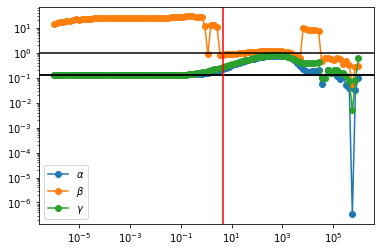

In [17]:
idx = 55
plt.plot(prange, [float(s['x'][-3]) for s in sols], 'o-', label=r'$\alpha$')
plt.plot(prange, [float(s['x'][-2]) for s in sols], 'o-', label=r'$\beta$')
plt.plot(prange, [float(s['x'][-1]) for s in sols], 'o-', label=r'$\gamma$')
for q in p0:
    plt.axhline(q, color='k')
plt.xscale('log')
plt.yscale('log')
plt.axvline(prange[idx], color='r')
plt.legend()

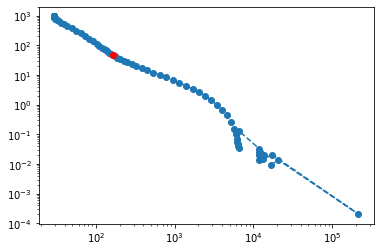

In [18]:
plt.loglog(*fsvals.T, 'o--',)
plt.loglog(*fsvals[idx], 'ro')

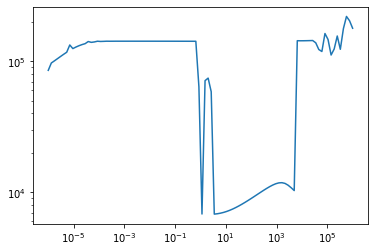

In [19]:
getN = lambda idx: np.mean(np.hstack([np.array(x) for x in getx(sols[idx]['x'])]).sum(axis=1))
plt.loglog(prange, [getN(i) for i,_ in enumerate(prange)])

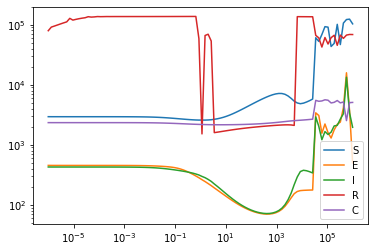

In [20]:
getM = lambda idx: np.mean(np.hstack([np.array(x) for x in getx(sols[idx]['x'])]), axis=0)
plt.semilogx(prange, [getM(i) for i,_ in enumerate(prange)])
plt.yscale('log')
plt.legend("SEIRC")

In [21]:
# applying the final size relation
from scipy.optimize import brentq
def rinf(sol):
    pfin = np.array([float(p) for p in getp(sol['x'])])
    r0 = pfin[1]/pfin[0]
    S0, E0, I0, R0, C0 = [float(x[0]) for x in getx(sol['x'])]
    N = sum((S0, E0, I0, R0))
    f = lambda y: y/S0 - np.exp(r0*(y-N)/N) 
    sinf = brentq(f, 0, S0) 
    return N-sinf

# def rinf(sol):
#     r0 = 8*getp(sol['x'])
#     S0, E0, I0, R0 = [float(x[0]) for x in getx(sol['x'])]
#     N = sum((S0, E0, I0, R0))
#     f = lambda y: y/S0 - np.exp(r0*(y-N)/N)
#     sinf = brentq(f, 0, S0)
#     return N-sinf

(0, 20000)

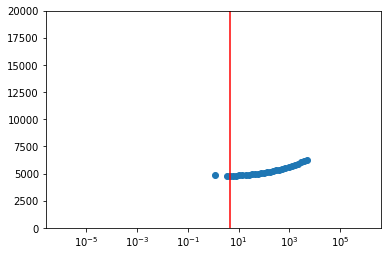

In [22]:
plt.semilogx(prange[:], [rinf(sol) for sol in sols][:], 'o')
plt.axvline(prange[idx], color='r')
plt.ylim([0,20000])

In [23]:
rinf(sols[idx])

4791.909152108969

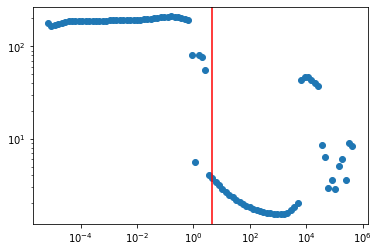

In [24]:
def r0(sol):
    pfin = np.array([float(p) for p in getp(sol['x'])])
    return pfin[1]/pfin[0]
# def r0(sol):
#     return 8*getp(sol['x'])
plt.plot(prange[7:-3], [r0(sol) for sol in sols][7:-3], 'o')
plt.xscale('log')
plt.yscale('log')
plt.axvline(prange[idx], color='r')

In [25]:
[getx(sols[idx]['x'])[i][50] for i in range(5)]

[DM(3617.41), DM(359.744), DM(243.188), DM(379.256), DM(1080.3)]

In [26]:
getx(sols[idx]['x'])[0][0]

DM(4911.81)

In [27]:
getp(sols[idx]['x'])

(DM(0.225271), DM(0.838246), DM(0.27364))

In [28]:
r0(sols[idx])

3.721062378954447

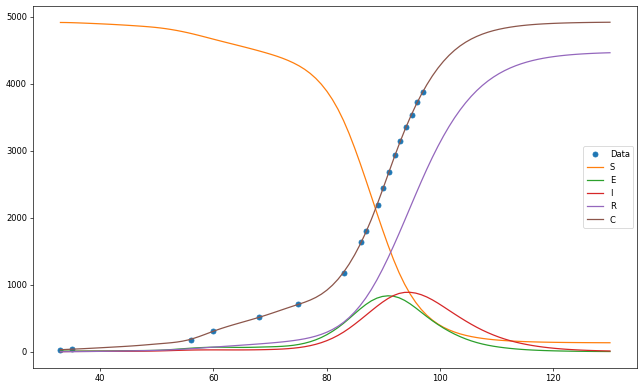

In [29]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)
ax.plot(times, cumdata, 'o', label='Data')
ax.plot(model.observation_times, getx(sols[idx]['x'])[0], label='S')
ax.plot(model.observation_times, getx(sols[idx]['x'])[1], label='E')
ax.plot(model.observation_times, getx(sols[idx]['x'])[2], label='I')
ax.plot(model.observation_times, getx(sols[idx]['x'])[3], label='R')
ax.plot(model.observation_times, getx(sols[idx]['x'])[4], label='C')
plt.legend()

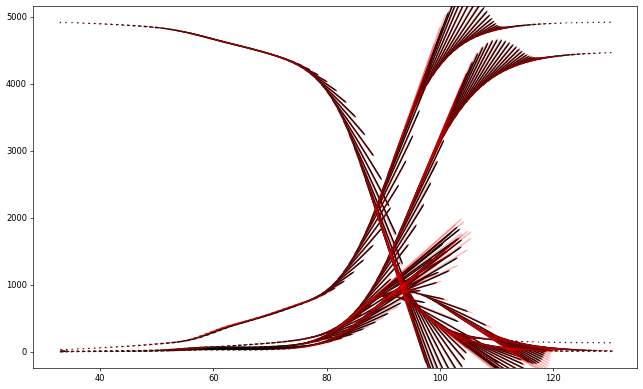

In [30]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)
xx = np.vstack([xix.toarray().flatten() for xix in getx(sols[idx]['x'])])
dxxdt = np.vstack([seir(0, xxj, [float(q) for q in getp(sols[idx]['x'])]) for xxj in xx.T])
for i, xxi in enumerate(xx):
    ax.quiver(model.observation_times, xxi, [1]*len(model.observation_times), dxxdt[:,i], 
              angles='xy', headwidth=0.75, headlength=1, headaxislength=2, width=0.0025)
for i, xxi in enumerate(xx):
    ax.quiver(model.observation_times, xxi, np.gradient(model.observation_times), np.gradient(xxi, model.observation_times), color='r', 
              angles='xy', headwidth=0.75, headlength=1, headaxislength=2, width=0.0025, alpha=0.3)

Text(0.5, 1.0, 'Number of Reported Cases (Prediction)')

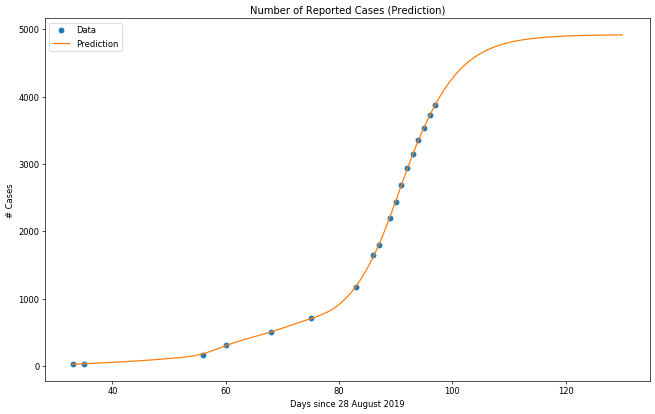

In [80]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)

ax.plot(times, cumdata, 'o', label='Data')
ax.plot(model.observation_times, getx(sols[idx]['x'])[4], label='Prediction')
plt.legend()
plt.xlabel("Days since 28 August 2019")
plt.ylabel("# Cases")
plt.title("Number of Reported Cases (Prediction)")

(0, 10000)

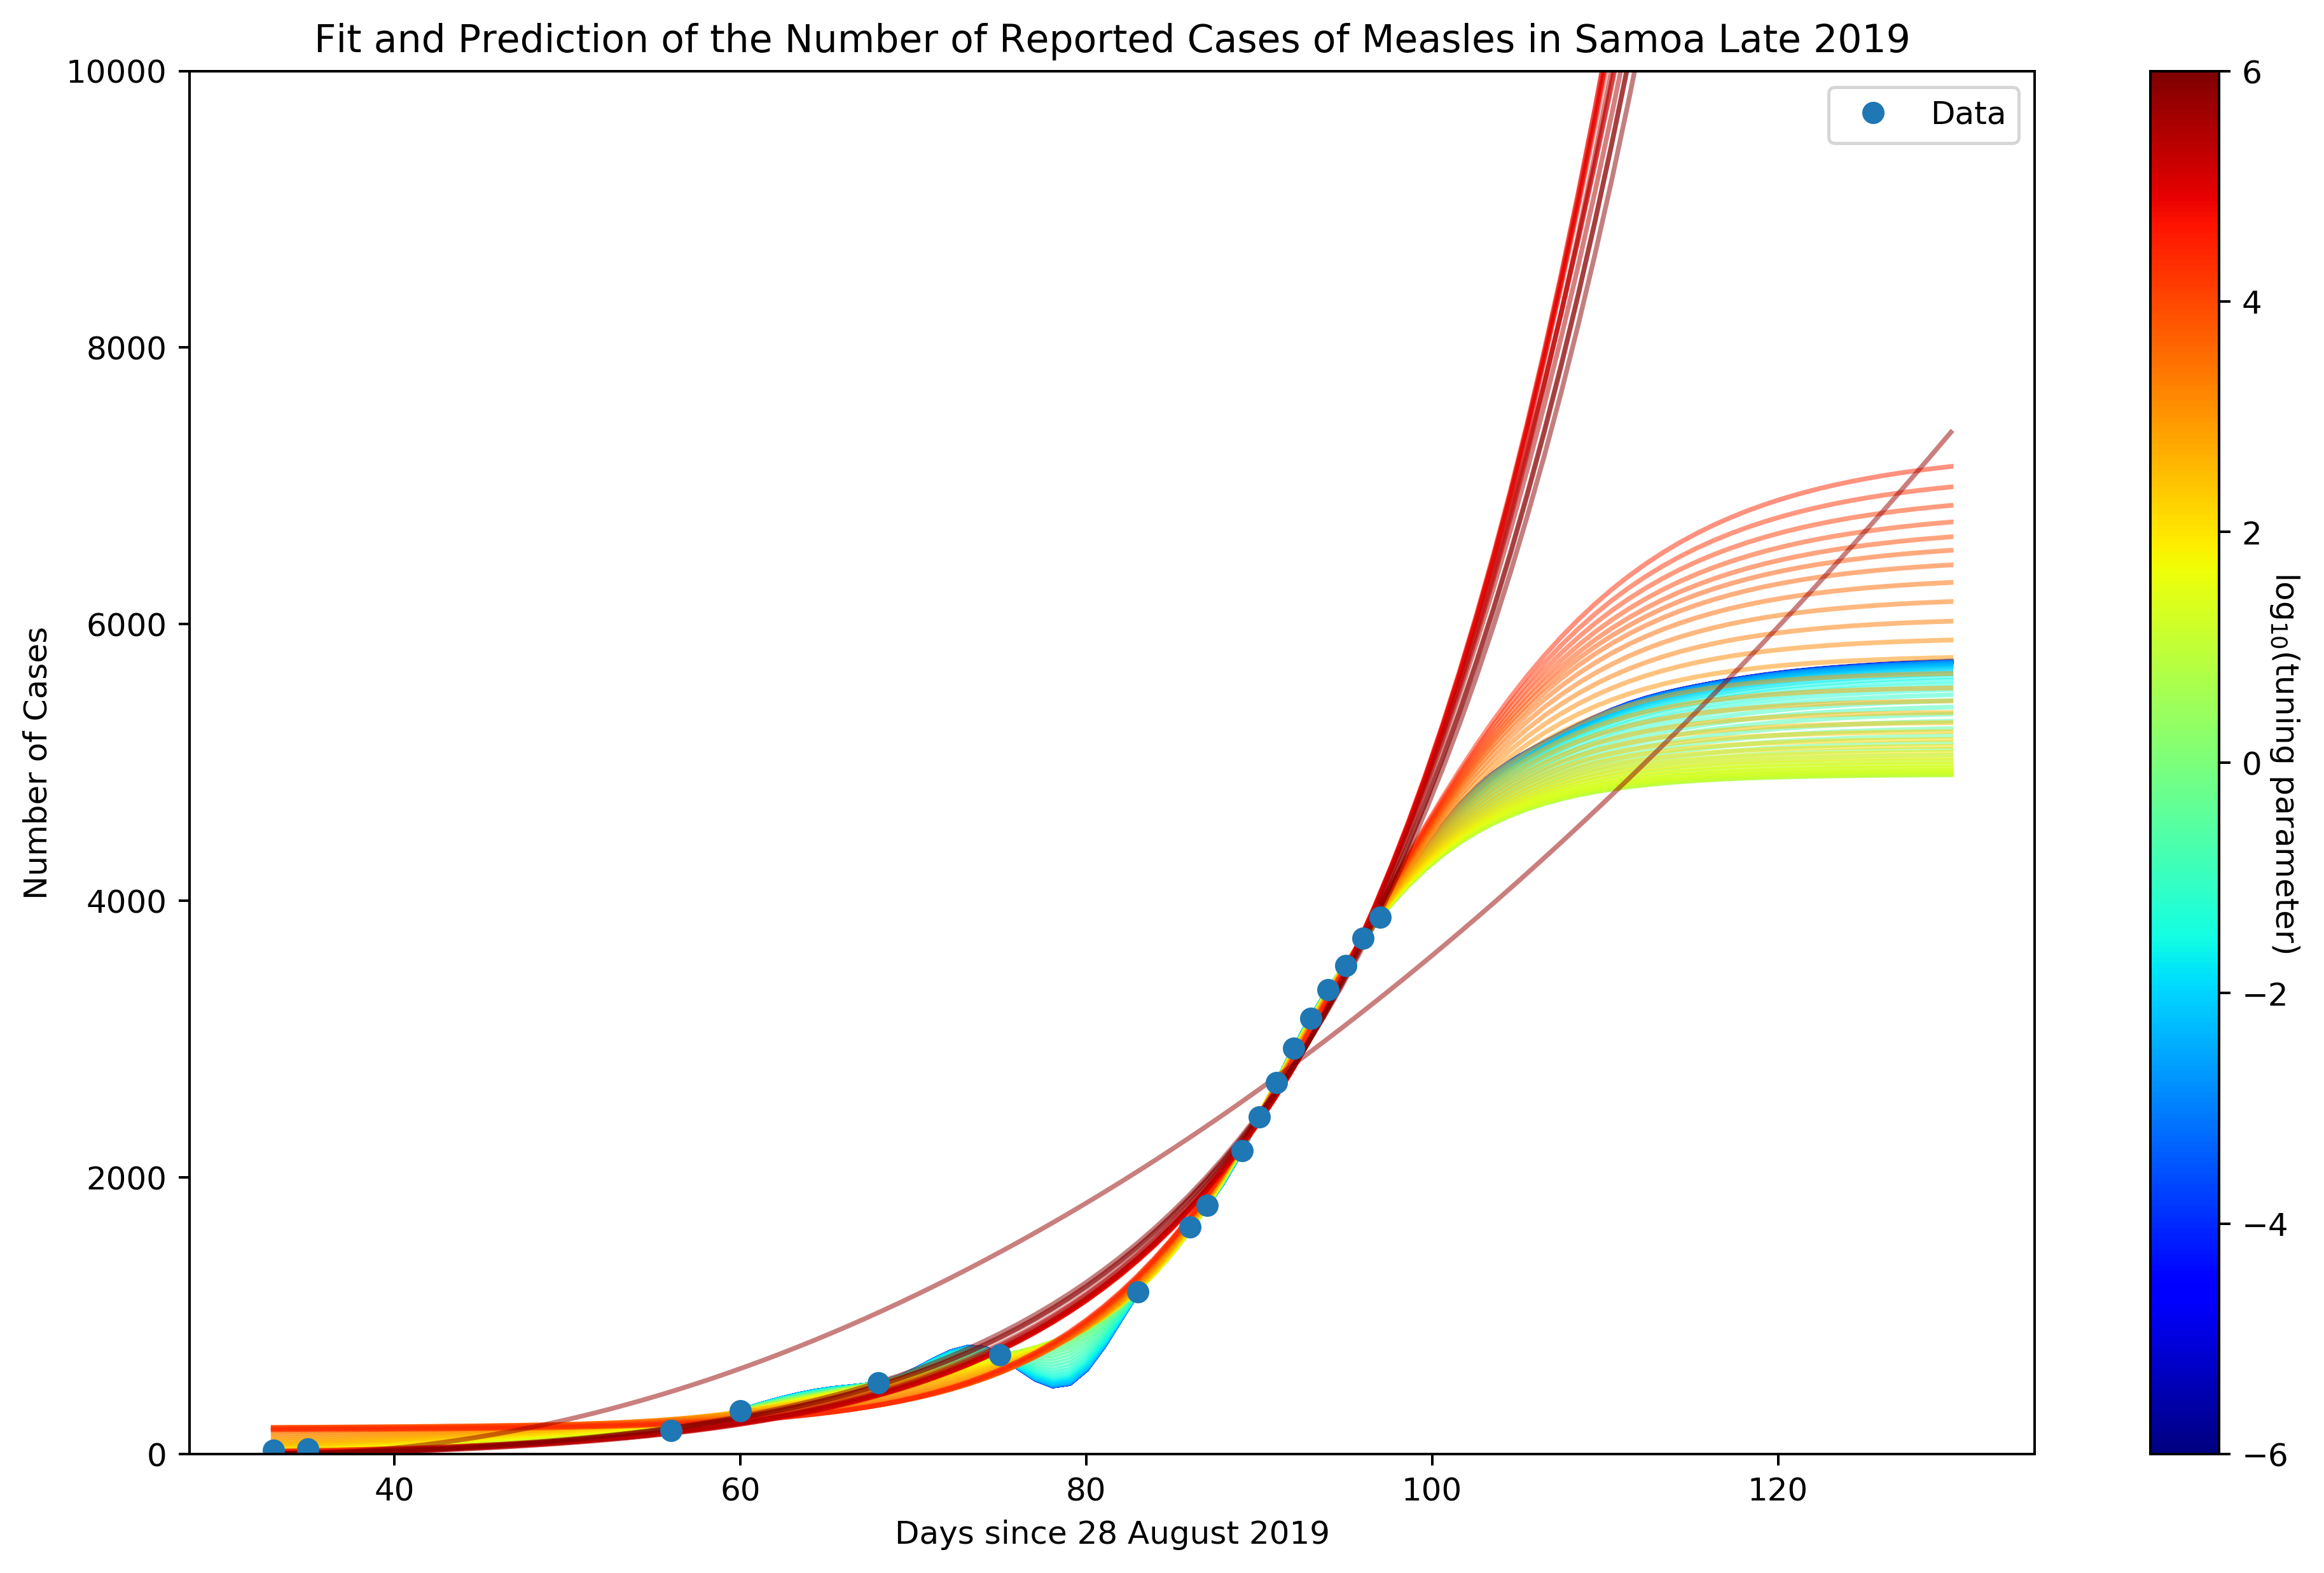

In [84]:
import matplotlib.cm as mplcm
import matplotlib.colors as colors

plt.figure(figsize=[13,8], dpi=360)

cNorm = colors.Normalize(vmin=np.log10(prange[0]), vmax=np.log10(prange[-1]))
cm = plt.get_cmap('jet')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

for i,p in enumerate(prange):
    plt.plot(model.observation_times, getx(sols[i]['x'])[-1], color=scalarMap.to_rgba(np.log10(p)), alpha=0.5)
plt.plot(times, cumdata, 'o', label="Data")
plt.title("Fit and Prediction of the Number of Reported Cases of Measles in Samoa Late 2019")
plt.xlabel("Days since 28 August 2019")
plt.ylabel("Number of Cases")
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)
plt.legend()
plt.ylim(0, 10000)

In [32]:
fsvals[idx]

array([163.0319337 ,  47.52794973])

In [33]:
getc = ca.Function('getx', [solver_setup['x']], model.cs)
np.sqrt(ca.sumsqr(cumdata - objective.collocation_matrices[0]@getc(sols[idx]['x'])[-1])/(len(times)-1))

DM(12.7198)

In [34]:
getp(sols[idx]['x'])

(DM(0.225271), DM(0.838246), DM(0.27364))

In [35]:
profiler_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
}
opts = {'ipopt': {'dual_inf_tol': 1e-1, 'print_frequency_iter': 10}}
profiler = ca.nlpsol('solver', 'ipopt', profiler_setup, opts)

In [36]:
rho = prange[idx]
pref = getp(sols[idx]['x'])
lbx = [-np.inf]*(config['basis_number']*config['model_form']['state']) + [0]*config['model_form']['parameters']
ubx = [np.inf]*(config['basis_number']*config['model_form']['state'] + config['model_form']['parameters'])

profiles = []
for pdx in range(config['model_form']['parameters']):
    pdx_mod = config['basis_number']*config['model_form']['state'] + pdx
    pvals = np.logspace(-2, 0.5, num=50)
    profiles.append([])
    for pval in pvals:
        lbx0 = np.array(lbx)
        ubx0 = np.array(ubx)
        lbx0[pdx_mod] = pval
        ubx0[pdx_mod] = pval
        profiles[pdx].append(profiler(x0=np.array(sols[idx]['x']).flatten(), p=[rho, alpha], lbx=lbx0, ubx=ubx0))

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1761

Total number of variables............................:      122
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  10  4.1870956e+03 0.00e+00 1.15e+00  -1.7 3.15e+01  -4.7 1.00e+00 1.00e+00f  1
  20  4.7740984e+02 0.00e+00 2.88e-04  -8.6 9.12e+03    -  6.41e-01 1.00e+00f  1
  30  4.7730210e+02 0.00e+00 6.41e-04  -8.6 7.54e+04    -  1.00e+00 1.00e+00f  1
  40  4.7728910e+02 0.00e+00 5.30e-03  -8.6 9.03e+05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 46

                                   (scaled)                 (unscaled)
Objective...............:   2.5292036810188673e-01    4.7728792770209287e+02
Dual infeasibility......:   1.4329940163536255e-09    2.7042137792532285e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596772212e-09    4.7289094429034893e-06
Overall NLP error.......:   2.5059035596772212e-09    4.7289094429034893e-06


Number of objective function evaluations             = 77
Number of objective gradient evaluations             = 47
Number of equality constraint evaluations            = 0
Number of ineq

  30  4.7062195e+02 0.00e+00 5.79e-03  -8.6 1.11e+05    -  1.00e+00 1.00e+00f  1
  40  4.7061498e+02 0.00e+00 1.84e-06  -8.6 7.60e-02 -11.3 1.00e+00 1.00e+00f  1

Number of Iterations....: 42

                                   (scaled)                 (unscaled)
Objective...............:   2.6391508735034469e-01    4.7061469202272110e+02
Dual infeasibility......:   8.2214005213059871e-10    1.4660442164087602e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596750156e-09    4.4685396496850097e-06
Overall NLP error.......:   2.5059035596750156e-09    4.4685396496850097e-06


Number of objective function evaluations             = 55
Number of objective gradient evaluations             = 43
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Numbe

 120  1.9153235e+02 0.00e+00 1.52e-01  -8.6 6.47e-01  -4.5 1.00e+00 1.00e+00f  1
 130  1.9043701e+02 0.00e+00 7.82e+01  -8.6 9.65e-01  -4.8 1.00e+00 1.00e+00f  1
 140  1.9005326e+02 0.00e+00 2.58e-02  -8.6 3.59e-03  -2.3 1.00e+00 1.00e+00f  1
 150  1.8858544e+02 0.00e+00 1.18e+02  -8.6 1.49e-02  -2.1 1.00e+00 2.50e-01f  3
 160  1.8608235e+02 0.00e+00 7.05e-01  -8.6 8.87e-04  -1.9 1.00e+00 1.00e+00f  1
 170  1.8437797e+02 0.00e+00 2.25e-01  -8.6 7.82e-02  -3.9 1.00e+00 1.00e+00f  1
 180  1.8412449e+02 0.00e+00 5.81e+01  -8.6 3.15e-02  -3.3 1.00e+00 1.00e+00f  1
 190  1.8262731e+02 0.00e+00 1.83e+03  -8.6 1.71e-01  -4.4 9.84e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.8246712e+02 0.00e+00 6.72e+01  -8.6 2.51e-01  -4.6 1.00e+00 1.00e+00f  1
 210  1.8213877e+02 0.00e+00 3.92e+05  -8.6 1.47e-03   1.0 1.00e+00 1.00e+00f  1
 220  1.8192135e+02 0.00e+00 1.08e+01  -8.6 3.09e-02  -3.7 1.00e+00 1.00e+00f  1
 230  1.8186441e+02 0.00e+00

CasADi - 2019-12-03 17:07:59 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:07:59 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:07:59 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:07:59 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:07:59 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:07:59 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:07:59 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

 470  1.8151932e+02 0.00e+00 1.38e+11  -8.6 3.48e-08  11.1 1.00e+00 3.55e-15f 49
 480  1.8151447e+02 0.00e+00 4.99e+11  -8.6 1.39e-11  14.4 1.00e+00 6.25e-02f  5
 490  1.8140549e+02 0.00e+00 2.92e+11  -8.6 4.06e-08  12.3 1.00e+00 4.44e-16f 52
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.8177161e+02 0.00e+00 3.73e+11  -8.6 3.52e-11  15.7 1.00e+00 5.00e-01f  2
 510  1.8142400e+02 0.00e+00 6.94e+11  -8.6 1.09e-09  13.6 1.00e+00 1.95e-03f 10
 520  1.8141871e+02 0.00e+00 1.70e+12  -8.6 2.15e-10  14.3 1.00e+00 1.42e-14f 47
 530  1.8207481e+02 0.00e+00 6.33e+11  -8.6 6.32e-13  18.6 1.00e+00 1.00e+00f  1
 540  1.8156850e+02 0.00e+00 6.37e+11  -8.6 8.34e-11  13.8 1.00e+00 3.91e-03f  9
 550  1.8156850e+02 0.00e+00 6.37e+11  -8.6 1.69e-11  14.4 1.00e+00 9.09e-13f 41
 560  1.8202349e+02 0.00e+00 1.92e+12  -8.6 4.24e-09   9.7 1.00e+00 1.00e+00S 21
 570  1.8150953e+02 0.00e+00 3.98e+10  -8.6 5.08e-08   9.4 1.00e+00 4.77e-07f 22
 580  1.8157894e+02 0.00e+00

CasADi - 2019-12-03 17:07:59 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 620  1.8158165e+02 0.00e+00 2.84e+10  -8.6 1.37e-09  10.8 1.00e+00 1.00e+00w  1
 630  1.8150807e+02 0.00e+00 1.79e+10  -8.6 1.11e-09  11.5 1.00e+00 1.56e-02f  7
 640  1.8150559e+02 0.00e+00 2.96e+10  -8.6 7.56e-09  11.2 1.00e+00 1.42e-14f 47
 650  1.8150559e+02 0.00e+00 2.96e+10  -8.6 7.29e-10  11.9 1.00e+00 2.27e-13f 43
 660  1.8156875e+02 0.00e+00 1.28e+10  -8.6 8.82e-10  10.7 1.00e+00 1.00e+00w  1
 670  1.8153904e+02 0.00e+00 9.53e+08  -8.6 1.29e-09  10.5 1.00e+00 4.88e-04f 12
 680  1.8148982e+02 0.00e+00 9.31e+10  -8.6 3.09e-13  18.5 1.00e+00 6.25e-02f  5
 690  1.8144594e+02 0.00e+00 1.34e+10  -8.6 3.38e-11  13.7 1.00e+00 7.81e-03f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  1.8173730e+02 0.00e+00 2.28e+11  -8.6 6.60e-10  12.6 1.00e+00 1.00e+00w  1
 710  1.8143969e+02 0.00e+00 7.57e+10  -8.6 1.62e-09  12.3 1.00e+00 2.84e-14f 46
 720  1.8143969e+02 0.00e+00 7.57e+10  -8.6 8.31e-09  12.1 1.00e+00 7.11e-15f 48
 730  1.8152980e+02 0.00e+00

CasADi - 2019-12-03 17:07:59 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:07:59 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:07:59 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:07:59 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:07:59 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 760  1.8147844e+02 0.00e+00 5.19e+11  -8.6 5.46e-10  12.9 1.00e+00 1.42e-14f 47
 770  1.8183133e+02 0.00e+00 1.43e+12  -8.6 1.61e-07  12.6 1.00e+00 1.00e+00S 21
 780  1.8151563e+02 0.00e+00 6.23e+11  -8.6 6.63e-09  12.4 1.00e+00 8.88e-16f 51
 790  1.8163898e+02 0.00e+00 6.76e+08  -8.6 4.65e-12  15.7 1.00e+00 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  1.8159945e+02 0.00e+00 7.93e+08  -8.6 1.02e-09  11.8 1.00e+00 1.22e-04f 14
 810  1.8154273e+02 0.00e+00 7.56e+08  -8.6 4.24e-08   7.1 1.00e+00 3.05e-05f 16
 820  2.0181454e+02 0.00e+00 1.07e+08  -8.6 1.03e-06   7.7 1.00e+00 1.00e+00w  1
 830  1.8154096e+02 0.00e+00 8.09e+08  -8.6 2.54e-06   5.7 1.00e+00 2.84e-14f 46
 840  1.8187253e+02 0.00e+00 6.56e+07  -8.6 6.70e-09  10.8 1.00e+00 1.00e+00f  1
 850  1.8165448e+02 0.00e+00 6.93e+08  -8.6 1.97e-07   6.9 1.00e+00 4.55e-13f 42
 860  1.8165448e+02 0.00e+00 6.89e+08  -8.6 1.08e-12  15.0 1.00e+00 1.19e-07f 24
 870  1.8167044e+02 0.00e+00

CasADi - 2019-12-03 17:08:00 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:00 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:00 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:00 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:00 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:00 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:00 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1000  1.8907565e+02 0.00e+00 2.48e+13  -8.6 1.71e-10  10.0 1.00e+00 1.00e+00w  1
1010  1.8290635e+02 0.00e+00 4.80e+12  -8.6 1.87e-07   6.1 1.00e+00 1.00e+00f  1
1020  1.8215196e+02 0.00e+00 2.04e+12  -8.6 2.25e-07   5.9 1.00e+00 5.68e-14f 45
1030  1.8194059e+02 0.00e+00 1.57e+10  -8.6 9.95e-08   6.5 1.00e+00 3.64e-12f 39
1040  1.8699055e+02 0.00e+00 1.71e+13  -8.6 8.97e-09   7.2 1.00e+00 1.00e+00w  1
1050  1.8342428e+02 0.00e+00 1.41e+13  -8.6 1.37e-08   6.9 1.00e+00 1.25e-01f  4
1060  1.8697307e+02 0.00e+00 1.51e+13  -8.6 2.40e-08   6.7 1.00e+00 1.00e+00w  1
1070  1.8325557e+02 0.00e+00 3.21e+12  -8.6 4.04e-08   6.4 1.00e+00 1.91e-06f 20
1080  1.8325549e+02 0.00e+00 3.18e+12  -8.6 9.83e-09   7.1 1.00e+00 7.63e-06f 18
1090  1.8325540e+02 0.00e+00 3.15e+12  -8.6 1.74e-08   6.8 1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  1.8325528e+02 0.00e+00 3.11e+12  -8.6 3.03e-08   6.6 1.00e+00 3.81e-06f 19
1110  1.8658187e+02 0.00e+00

CasADi - 2019-12-03 17:08:00 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:00 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:00 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:00 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:00 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:00 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:00 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1130  1.8293160e+02 0.00e+00 2.43e+13  -8.6 4.93e-12  17.2 1.00e+00 2.84e-14f 46
1140  1.8293160e+02 0.00e+00 2.43e+13  -8.6 2.97e-11  12.4 1.00e+00 3.55e-15f 49
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 1147

                                   (scaled)                 (unscaled)
Objective...............:   1.7454864736197120e-01    2.8910555744652527e+02
Dual infeasibility......:   4.7772860330344900e+14    7.9126361764224346e+17
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    4.1505371509763772e-06
Overall NLP error.......:   4.7772860330344900e+14    7.9126361764224346e+17


Number of objective function evaluations             = 20293
Number of objective gradient evaluations             = 1148
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobi

CasADi - 2019-12-03 17:08:01 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]



  50  4.2312802e+02 0.00e+00 5.83e+00  -8.6 3.28e+02  -7.9 1.00e+00 2.50e-01f  3
  60  3.1432698e+02 0.00e+00 8.00e-01  -8.6 1.28e+01  -5.9 1.00e+00 1.00e+00f  1
  70  2.2888324e+02 0.00e+00 3.26e+01  -8.6 3.57e+00  -4.7 1.00e+00 1.00e+00f  1
  80  2.0094711e+02 0.00e+00 4.30e+01  -8.6 4.29e+00  -5.4 1.00e+00 1.00e+00f  1
  90  1.9131675e+02 0.00e+00 4.30e+02  -8.6 2.48e+02    -  1.00e+00 3.94e-02f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.9059465e+02 0.00e+00 4.48e+01  -8.6 3.73e-01  -4.5 1.00e+00 1.00e+00f  1
 110  1.8783949e+02 0.00e+00 4.67e+03  -8.6 1.54e-01  -2.9 1.00e+00 1.00e+00f  1
 120  1.8606621e+02 0.00e+00 2.97e+01  -8.6 8.10e-02  -4.0 1.00e+00 1.00e+00f  1
 130  1.8596998e+02 0.00e+00 3.62e+02  -8.6 3.01e-03  -2.5 1.00e+00 1.00e+00f  1
 140  1.8595614e+02 0.00e+00 5.30e+04  -8.6 4.31e-01  -3.6 1.25e-05 6.25e-02f  5
 150  1.8595494e+02 0.00e+00 2.23e+04  -8.6 6.12e-04  -0.3 2.35e-01 3.12e-02f  6
 160  1.8595418e+02 0.00e+0

CasADi - 2019-12-03 17:08:01 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:01 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:01 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:01 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:01 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:01 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:01 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

 370  1.8759299e+02 0.00e+00 5.52e+10  -8.6 2.55e-11  13.9 1.00e+00 1.56e-02f  7
 380  1.8795758e+02 0.00e+00 7.17e+11  -8.6 9.93e-10  12.7 1.00e+00 1.00e+00w  1
 390  1.8763022e+02 0.00e+00 1.35e+12  -8.6 3.59e-10   9.7 1.00e+00 1.42e-14f 47
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  1.8807292e+02 0.00e+00 7.84e+11  -8.6 1.10e-11  15.3 1.00e+00 4.55e-13f 42
 410  1.8769885e+02 0.00e+00 1.11e+12  -8.6 1.09e-10  10.5 1.00e+00 9.77e-04f 11
 420  1.8778369e+02 0.00e+00 6.72e+11  -8.6 1.79e-09   5.7 1.00e+00 1.00e+00w  1
 430  1.8769731e+02 0.00e+00 1.12e+12  -8.6 1.81e-11  14.2 1.00e+00 4.55e-13f 42
 440  1.8769731e+02 0.00e+00 1.12e+12  -8.6 7.74e-11  12.1 1.00e+00 5.68e-14f 45
 450  1.8776388e+02 0.00e+00 1.79e+11  -8.6 2.96e-09  11.9 1.00e+00 1.56e-02f  7
 460  1.8813240e+02 0.00e+00 2.89e+12  -8.6 3.93e-10   7.1 1.00e+00 1.00e+00w  1
 470  1.8746817e+02 0.00e+00 1.88e+12  -8.6 5.58e-09   5.9 1.00e+00 1.95e-03f 10
 480  1.8742820e+02 0.00e+00

CasADi - 2019-12-03 17:08:01 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:02 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:02 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1761

Total number of variables............................:      122
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.9325336e+04 0.00e+00 9.90e+01  -1.0 0.00e+00    -  0.00e+00 0.

CasADi - 2019-12-03 17:08:02 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:02 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:02 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:02 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 350  1.9192848e+02 0.00e+00 2.62e+09  -8.6 2.59e-09   9.6 1.00e+00 1.00e+00S 21
 360  1.9191099e+02 0.00e+00 6.43e+09  -8.6 1.02e-08  10.3 1.00e+00 5.68e-14f 45
 370  1.9183478e+02 0.00e+00 3.00e+11  -8.6 1.86e-09  12.7 1.00e+00 7.11e-15f 48
 380  1.9230080e+02 0.00e+00 1.94e+11  -8.6 1.06e-09  12.5 1.00e+00 1.00e+00f  1
 390  1.9204461e+02 0.00e+00 1.15e+12  -8.6 3.84e-09  12.2 1.00e+00 7.11e-15f 48
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  1.9204483e+02 0.00e+00 7.16e+07  -8.6 1.58e-11  14.7 1.00e+00 1.22e-04f 14
 410  2.8588263e+05 0.00e+00 1.51e+13  -8.6 7.61e-07  10.8 1.00e+00 1.00e+00w  1
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 410

                                   (scaled)                 (unscaled)
Objective...............:   2.0752755690728989e+02    2.8588262972297234e+05
Dual infeasibility......:   1.5060045945308908e+13    2.0746187170299888e+16
Constraint violatio

 620  1.7127408e+02 0.00e+00 7.25e+09  -8.6 8.52e-07   7.1 1.00e+00 5.00e-01f  2
 630  1.7122773e+02 0.00e+00 2.51e+10  -8.6 1.50e-13  17.9 1.00e+00 1.25e-01f  4
 640  1.7124310e+02 0.00e+00 1.75e+10  -8.6 1.58e-10  13.1 1.00e+00 1.00e+00w  1
 650  1.7116919e+02 0.00e+00 5.60e+10  -8.6 1.12e-08  11.0 1.00e+00 1.56e-02f  7
 660  1.7125527e+02 0.00e+00 7.02e+10  -8.6 3.55e-10  11.7 1.00e+00 1.56e-02f  7
 670  1.7117853e+02 0.00e+00 8.76e+10  -8.6 5.91e-09  11.4 1.00e+00 2.84e-14f 46
 680  1.7106786e+02 0.00e+00 1.21e+11  -8.6 2.34e-09  12.1 1.00e+00 1.95e-03f 10
 690  1.7135903e+02 0.00e+00 4.18e+10  -8.6 2.08e-09  10.9 1.00e+00 1.00e+00S 21
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  1.7100643e+02 0.00e+00 3.51e+11  -8.6 6.28e-10  13.4 1.00e+00 2.84e-14f 46
 710  1.9107069e+02 0.00e+00 8.53e+13  -8.6 6.28e-10  14.0 1.00e+00 8.88e-16f 51


CasADi - 2019-12-03 17:08:03 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:03 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:03 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:03 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:03 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:03 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:03 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

 720  1.9107069e+02 0.00e+00 8.53e+13  -8.6 2.18e-09   9.3 1.00e+00 8.88e-16f 51
 730  1.8871311e+02 0.00e+00 1.46e+14  -8.6 2.26e-08   7.2 1.00e+00 1.78e-15f 50
 740  2.1096278e+02 0.00e+00 3.15e+14  -8.6 7.68e-10   7.8 1.00e+00 1.00e+00S 21
 750  1.8150546e+02 0.00e+00 4.25e+13  -8.6 3.18e-09   7.6 1.00e+00 1.25e-01f  4
 760  1.8150546e+02 0.00e+00 4.25e+13  -8.6 3.81e-09   7.3 1.00e+00 1.42e-14f 47
 770  1.8150546e+02 0.00e+00 4.25e+13  -8.6 3.81e-09   8.0 1.00e+00 2.84e-14f 46
 780  1.7858400e+02 0.00e+00 2.45e+13  -8.6 3.92e-09   7.7 1.00e+00 2.84e-14f 46
 790  3.0705642e+02 0.00e+00 8.79e+13  -8.6 7.72e-07   7.5 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 791

                                   (scaled)                 (unscaled)
Objective...............:   1.2155823153133510e+02    1.5555276290331988e+05
Dual infeasibil

2019-12-03 17:08:04 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:04 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:04 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:04 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:04 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:04 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:04 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

  10  4.4108043e+02 0.00e+00 3.17e-01  -2.5 1.06e+04    -  5.23e-01 5.00e-01f  2
  20  4.3940537e+02 0.00e+00 2.65e-03  -5.7 1.59e+04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 23

                                   (scaled)                 (unscaled)
Objective...............:   3.7654973327525471e-01    4.3940535975883500e+02
Dual infeasibility......:   1.1135358896931253e-11    1.2994130521858915e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0910082800953861e-10    1.0608526340306325e-06
Overall NLP error.......:   9.0910082800953861e-10    1.0608526340306325e-06


Number of objective function evaluations             = 35
Number of objective gradient evaluations             = 24
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Numbe

 880  1.7527593e+02 0.00e+00 1.45e-01  -5.7 3.47e-04  -1.7 1.00e+00 1.00e+00f  1
 890  1.7523241e+02 0.00e+00 3.49e-03  -5.7 1.56e-05   1.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 900  1.7523150e+02 0.00e+00 5.90e-04  -5.7 1.21e-08   4.3 1.00e+00 1.00e+00f  1
 910  1.7523144e+02 0.00e+00 7.94e-04  -5.7 3.65e-05  -0.4 1.00e+00 1.00e+00f  1
 920  1.7522991e+02 0.00e+00 1.75e+01  -5.7 1.83e-02  -3.4 1.00e+00 1.00e+00f  1
 930  1.7522960e+02 0.00e+00 7.68e-01  -5.7 4.12e-03  -2.8 1.00e+00 1.00e+00f  1
 940  1.7522960e+02 0.00e+00 5.55e-04  -5.7 1.81e-06   0.6 1.00e+00 1.00e+00f  1
 950  1.7522950e+02 0.00e+00 4.80e-02  -5.7 2.61e-05  -0.6 1.00e+00 5.00e-01f  2
 960  1.7522949e+02 0.00e+00 3.66e-01  -5.7 1.46e-06   1.0 1.00e+00 1.00e+00f  1
 970  1.7522949e+02 0.00e+00 1.05e+01  -5.7 1.66e-07   1.6 1.00e+00 1.00e+00f  1
 980  1.7522949e+02 0.00e+00 1.98e+00  -5.7 5.84e-10   4.1 1.00e+00 1.22e-04f 14
 990  1.7522949e+02 0.00e+00

1980  1.6960346e+02 0.00e+00 6.73e+00  -5.7 1.21e-05  -1.4 1.00e+00 9.31e-10f 31
1990  1.6960346e+02 0.00e+00 2.15e+01  -5.7 1.05e-07   1.0 1.00e+00 1.00e+00F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  1.6960346e+02 0.00e+00 1.91e+01  -5.7 4.91e-06  -1.0 1.00e+00 1.86e-09f 30
2010  1.6960346e+02 0.00e+00 5.06e+01  -5.7 2.16e-06  -0.4 1.00e+00 1.49e-08f 27
2020  1.6960346e+02 0.00e+00 1.69e+02  -5.7 1.59e-05  -1.5 1.00e+00 1.00e+00w  1
2030  1.6960346e+02 0.00e+00 3.89e+00  -5.7 3.59e-06  -0.9 1.00e+00 3.73e-09f 29
2040  1.6960346e+02 0.00e+00 3.89e+00  -5.7 6.47e-06  -1.1 1.00e+00 1.86e-09f 30
2050  1.6960346e+02 0.00e+00 9.32e+01  -5.7 1.81e-07   0.4 1.00e+00 1.00e+00f  1
2060  1.6960346e+02 0.00e+00 9.32e+01  -5.7 1.45e-06   0.2 1.00e+00 7.45e-09f 28
2070  1.6960346e+02 0.00e+00 8.28e+01  -5.7 4.44e-06  -0.1 1.00e+00 3.73e-09f 29
2080  1.6960346e+02 0.00e+00 6.03e+01  -5.7 6.53e-07   0.5 1.00e+00 1.00e+00S 21
2090  1.6960346e+02 0.00e+00

 450  1.8023046e+02 0.00e+00 1.90e+03  -5.7 1.89e-01  -4.1 1.00e+00 1.00e+00f  1
 460  1.8012966e+02 0.00e+00 3.67e+04  -5.7 6.23e-01  -4.3 1.00e+00 8.18e-02f  2
 470  1.7997532e+02 0.00e+00 8.68e+04  -5.7 3.92e-03  -1.0 1.00e+00 1.00e+00f  1
 480  1.7987932e+02 0.00e+00 5.97e+03  -5.7 1.40e-02  -3.1 1.00e+00 1.00e+00f  1
 490  1.7977400e+02 0.00e+00 8.97e+02  -5.7 2.01e-01  -4.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.7962749e+02 0.00e+00 1.41e+03  -5.7 3.63e-01  -4.5 1.00e+00 1.00e+00f  1
 510  1.7944201e+02 0.00e+00 6.78e+04  -5.7 6.71e-01  -4.7 1.00e+00 1.00e+00f  1
 520  1.7933478e+02 0.00e+00 3.82e+03  -5.7 1.49e-01  -4.1 1.00e+00 1.00e+00f  1
 530  1.7919178e+02 0.00e+00 1.90e+05  -5.7 2.24e+00  -5.2 1.00e+00 2.61e-01f  2
 540  1.7907528e+02 0.00e+00 1.12e+05  -5.7 5.22e-02  -1.9 1.00e+00 3.25e-01f  2
 550  1.7897310e+02 0.00e+00 2.98e+04  -5.7 8.68e-01  -4.8 1.00e+00 1.00e+00f  1
 560  1.7885423e+02 0.00e+00

1510  1.6930625e+02 0.00e+00 8.29e+02  -5.7 2.64e+00    -  1.00e+00 2.50e-01f  3
1520  1.6930619e+02 0.00e+00 1.61e-03  -5.7 2.85e-05    -  1.00e+00 1.86e-09f 30
1530  1.6930619e+02 0.00e+00 1.26e-03  -5.7 2.33e-05    -  1.00e+00 1.00e+00f  1
1540  1.6930619e+02 0.00e+00 9.68e-03  -5.7 1.35e-05    -  1.00e+00 3.73e-09f 29
1550  1.6930619e+02 0.00e+00 1.07e-02  -5.7 1.59e-05    -  1.00e+00 9.31e-10f 31
1560  1.6930619e+02 0.00e+00 1.06e-02  -5.7 1.51e-05    -  1.00e+00 9.31e-10f 31
1570  1.6930619e+02 0.00e+00 3.15e-03  -5.7 1.03e-05    -  1.00e+00 1.00e+00w  1
1580  1.6930619e+02 0.00e+00 1.06e-02  -5.7 1.60e-05    -  1.00e+00 9.31e-10f 31
1590  1.6930619e+02 0.00e+00 7.19e-03  -5.7 1.33e-05    -  1.00e+00 4.77e-07f 22
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  1.6930619e+02 0.00e+00 2.14e-03  -5.7 2.61e-06    -  1.00e+00 1.00e+00S 21
1610  1.6930619e+02 0.00e+00 1.24e-04  -5.7 1.66e-05    -  1.00e+00 9.31e-10f 31
1620  1.6930619e+02 0.00e+00

2530  1.6930619e+02 0.00e+00 4.41e-03  -5.7 1.04e-05    -  1.00e+00 1.00e+00w  1
2540  1.6930619e+02 0.00e+00 1.19e-02  -5.7 1.79e-05    -  1.00e+00 9.31e-10f 31
2550  1.6930619e+02 0.00e+00 1.13e-02  -5.7 9.37e-06    -  1.00e+00 7.45e-09f 28
2560  1.6930619e+02 0.00e+00 1.26e-02  -5.7 1.07e-05    -  1.00e+00 1.86e-09f 30
2570  1.6930619e+02 0.00e+00 7.70e-03  -5.7 1.65e-05    -  1.00e+00 1.00e+00w  1
2580  1.6930619e+02 0.00e+00 4.91e-03  -5.7 3.93e-06    -  1.00e+00 1.95e-03f 10
2590  1.6930619e+02 0.00e+00 2.30e-03  -5.7 1.16e-05    -  1.00e+00 1.00e+00S 21
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  1.6930619e+02 0.00e+00 5.67e-03  -5.7 6.27e-06    -  1.00e+00 3.73e-09f 29
2610  1.6930619e+02 0.00e+00 7.87e-03  -5.7 9.78e-06    -  1.00e+00 1.00e+00f  1
2620  1.6930619e+02 0.00e+00 6.58e-03  -5.7 1.05e-05    -  1.00e+00 1.86e-09f 30
2630  1.6930619e+02 0.00e+00 3.65e-03  -5.7 2.06e-05    -  1.00e+00 1.49e-08f 27
2640  1.6930619e+02 0.00e+00

 200  1.8294498e+02 0.00e+00 1.57e+03  -5.7 7.66e-03  -2.6 1.00e+00 1.00e+00f  1
 210  1.8284262e+02 0.00e+00 3.86e+02  -5.7 1.11e-01  -3.8 1.00e+00 1.00e+00f  1
 220  1.8270611e+02 0.00e+00 1.19e+02  -5.7 1.97e-01  -4.1 1.00e+00 1.00e+00f  1
 230  1.8254962e+02 0.00e+00 2.10e+03  -5.7 5.74e-03  -2.5 1.00e+00 1.00e+00f  1
 240  1.8244935e+02 0.00e+00 6.68e+02  -5.7 7.88e-02  -3.7 1.00e+00 1.00e+00f  1
 250  1.8230646e+02 0.00e+00 9.52e+03  -5.7 1.53e-01  -3.9 1.00e+00 5.00e-01f  2
 260  1.8219336e+02 0.00e+00 6.44e+02  -5.7 2.48e-01  -4.2 1.00e+00 1.00e+00f  1
 270  1.8209999e+02 0.00e+00 1.63e+02  -5.7 7.12e-03  -2.6 1.00e+00 1.00e+00f  1
 280  1.8201585e+02 0.00e+00 1.79e+03  -5.7 9.92e-02  -3.8 1.00e+00 1.00e+00f  1
 290  1.8193538e+02 0.00e+00 8.71e+02  -5.7 2.25e-02  -3.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  1.8185421e+02 0.00e+00 5.80e+01  -5.7 4.94e-03  -2.5 1.00e+00 1.00e+00f  1
 310  1.8170013e+02 0.00e+00

1230  1.7489523e+02 0.00e+00 8.76e+02  -5.7 6.44e-03  -2.8 1.00e+00 1.00e+00f  1
1240  1.7487715e+02 0.00e+00 1.40e+04  -5.7 1.66e-01  -2.1 1.00e+00 1.85e-02f  2
1250  1.7484424e+02 0.00e+00 1.84e+04  -5.7 1.72e-01  -4.2 1.00e+00 1.00e+00f  1
1260  1.7481316e+02 0.00e+00 6.85e+02  -5.7 4.75e-03  -2.7 1.00e+00 1.00e+00f  1
1270  1.7479886e+02 0.00e+00 2.05e-02  -5.7 6.73e-02  -3.8 1.00e+00 1.00e+00f  1
1280  1.7475942e+02 0.00e+00 5.64e+02  -5.7 4.55e-02  -3.6 1.00e+00 1.00e+00f  1
1290  1.7472374e+02 0.00e+00 7.68e+03  -5.7 4.50e-03  -2.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  1.7469799e+02 0.00e+00 4.95e+03  -5.7 2.45e-03  -2.4 1.00e+00 1.00e+00f  1
1310  1.7466798e+02 0.00e+00 4.31e+03  -5.7 2.63e-01  -4.4 1.00e+00 1.00e+00f  1
1320  1.7459374e+02 0.00e+00 9.14e+01  -5.7 5.90e-02  -3.8 1.00e+00 1.00e+00f  1
1330  1.7456371e+02 0.00e+00 2.14e+03  -5.7 1.73e-03  -2.2 1.00e+00 1.00e+00f  1
1340  1.7452905e+02 0.00e+00

2260  1.6960168e+02 0.00e+00 1.91e-01  -5.7 3.21e-04    -  1.00e+00 5.82e-11f 35
2270  1.6960168e+02 0.00e+00 1.91e-01  -5.7 3.52e-04    -  1.00e+00 5.82e-11f 35
2280  1.6960168e+02 0.00e+00 2.77e-03  -5.7 5.73e-06    -  1.00e+00 3.91e-03f  9
2290  1.6960168e+02 0.00e+00 1.29e-02  -5.7 1.86e-05    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2300  1.6960168e+02 0.00e+00 1.25e-02  -5.7 1.38e-05    -  1.00e+00 2.98e-08f 26
2310  1.6960168e+02 0.00e+00 3.72e-03  -5.7 4.05e-07    -  1.00e+00 1.00e+00F  1
2320  1.6960168e+02 0.00e+00 7.64e-03  -5.7 1.39e-05    -  1.00e+00 9.31e-10f 31
2330  1.6960168e+02 0.00e+00 7.61e-03  -5.7 1.54e-05    -  1.00e+00 9.31e-10f 31
2340  1.6960168e+02 0.00e+00 1.43e-03  -5.7 2.09e-05    -  1.00e+00 9.31e-10f 31
2350  1.6960168e+02 0.00e+00 1.39e-03  -5.7 2.58e-06    -  1.00e+00 9.31e-10f 30
2360  1.6960168e+02 0.00e+00 2.14e-03  -5.7 2.04e-05    -  1.00e+00 1.00e+00w  1
2370  1.6960168e+02 0.00e+00

 110  1.8477994e+02 0.00e+00 8.82e+00  -8.6 8.54e-02  -3.5 1.00e+00 1.00e+00f  1
 120  1.8441161e+02 0.00e+00 3.85e+03  -8.6 1.23e-02  -2.0 1.00e+00 1.00e+00f  1
 130  1.8435627e+02 0.00e+00 8.76e+03  -8.6 2.70e-01  -4.0 1.00e+00 1.00e+00f  1
 140  1.8411288e+02 0.00e+00 4.29e+04  -8.6 1.39e-02  -1.6 1.00e+00 1.40e-01f  3
 150  1.8394908e+02 0.00e+00 5.27e+02  -8.6 1.99e-04  -0.0 1.00e+00 1.00e+00f  1
 160  1.8376350e+02 0.00e+00 1.70e+05  -8.6 1.58e+00  -4.8 1.00e+00 1.00e+00f  1
 170  1.8364080e+02 0.00e+00 4.96e+04  -8.6 1.27e-01  -3.3 1.00e+00 6.25e-02f  3
 180  1.8349264e+02 0.00e+00 1.89e+04  -8.6 1.66e-03   0.1 1.00e+00 5.00e-01f  2
 190  1.8335901e+02 0.00e+00 9.35e+04  -8.6 1.13e+00  -4.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.8326605e+02 0.00e+00 1.82e+05  -8.6 3.92e-02  -1.3 1.00e+00 2.90e-02f  3
 210  1.8321008e+02 0.00e+00 3.99e+02  -8.6 8.97e-04  -1.6 1.00e+00 1.00e+00f  1
 220  1.8310034e+02 0.00e+00

CasADi - 2019-12-03 17:08:15 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:16 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:16 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:16 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:16 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:16 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:16 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

 430  1.8302613e+02 0.00e+00 2.95e+12  -8.6 2.97e-09   6.8 1.00e+00 5.68e-14f 45
 440  1.8295419e+02 0.00e+00 6.30e+12  -8.6 1.60e-12  17.0 1.00e+00 3.12e-02f  6
 450  1.8329631e+02 0.00e+00 5.72e+12  -8.6 6.34e-11  12.3 1.00e+00 1.00e+00w  1
 460  1.8288276e+02 0.00e+00 2.04e+11  -8.6 1.64e-08  13.8 1.00e+00 1.78e-15f 50
 470  1.8288276e+02 0.00e+00 2.04e+11  -8.6 1.15e-09  14.5 1.00e+00 2.84e-14f 46
 480  1.8392381e+02 0.00e+00 3.36e+09  -8.6 9.02e-10  12.4 1.00e+00 1.00e+00S 21
 490  1.8296085e+02 0.00e+00 4.99e+11  -8.6 1.51e-09  13.1 1.00e+00 7.11e-15f 48
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.8294804e+02 0.00e+00 8.78e+11  -8.6 2.68e-10  13.7 1.00e+00 2.84e-14f 46
 510  1.8310836e+02 0.00e+00 8.63e+10  -8.6 5.24e-10  13.4 1.00e+00 1.00e+00S 21
 520  1.8294186e+02 0.00e+00 7.22e+08  -8.6 1.32e-09  13.2 1.00e+00 7.28e-12f 38
 530  1.8663915e+02 0.00e+00 1.64e+13  -8.6 1.28e-11  17.6 1.00e+00 5.00e-01f  2
 540  1.8401316e+02 0.00e+00

CasADi - 2019-12-03 17:08:16 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:16 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:16 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:16 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:16 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:16 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:16 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

 680  1.8523941e+02 0.00e+00 1.18e+13  -8.6 6.51e-10   7.5 1.00e+00 1.00e+00w  1
 690  1.8362912e+02 0.00e+00 2.05e+11  -8.6 3.36e-09   7.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  1.8291717e+02 0.00e+00 9.41e+12  -8.6 2.47e-08   6.1 1.00e+00 2.84e-14f 46
 710  1.8296568e+02 0.00e+00 2.69e+12  -8.6 3.75e-08   5.9 1.00e+00 5.00e-01f  2
 720  2.0549360e+02 0.00e+00 2.61e+12  -8.6 3.03e-08   7.4 1.00e+00 1.00e+00w  1
 730  1.8410291e+02 0.00e+00 7.31e+12  -8.6 5.74e-11  13.0 1.00e+00 1.42e-14f 47
 740  1.8410291e+02 0.00e+00 7.31e+12  -8.6 7.55e-10   8.2 1.00e+00 1.42e-14f 47
 750  1.8375378e+02 0.00e+00 3.99e+13  -8.6 1.74e-10  13.5 1.00e+00 8.88e-16f 51
 760  2.4003070e+02 0.00e+00 4.67e+13  -8.6 1.62e-11  19.0 1.00e+00 5.00e-01f  2
 770  2.3955570e+02 0.00e+00 7.23e+14  -8.6 5.39e-11  14.3 1.00e+00 1.00e+00w  1
 780  1.8861441e+02 0.00e+00 2.76e+12  -8.6 2.88e-10   9.5 1.00e+00 1.14e-13f 44
 790  1.8599809e+02 0.00e+00

CasADi - 2019-12-03 17:08:16 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:16 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:16 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:16 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:16 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:16 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:16 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 803

                                   (scaled)                 (unscaled)
Objective...............:   6.8289019790958278e+01    3.5337985024153168e+04
Dual infeasibility......:   8.3169148011037069e+17    4.3038106505004253e+20
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800655e-09    1.2967470134293989e-06
Overall NLP error.......:   8.3169148011037069e+17    4.3038106505004253e+20


Number of objective function evaluations             = 15974
Number of objective gradient evaluations             = 804
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 804
Total CPU secs in IPOPT (w/

 690  1.8185466e+02 0.00e+00 1.99e+03  -5.7 3.85e-02  -3.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  1.8181037e+02 0.00e+00 3.16e+03  -5.7 1.10e-01  -3.3 3.22e-01 1.00e+00f  1
 710  1.8176605e+02 0.00e+00 1.66e+03  -5.7 1.24e-01  -3.6 1.00e+00 1.00e+00f  1
 720  1.8172744e+02 0.00e+00 2.00e+04  -5.7 5.26e-01  -2.9 1.00e+00 4.02e-03f  3
 730  1.8167897e+02 0.00e+00 5.26e+04  -5.7 2.06e-03  -1.4 1.00e+00 1.00e+00f  1
 740  1.8166108e+02 0.00e+00 6.09e+03  -5.7 8.96e-02  -3.4 1.00e+00 1.00e+00f  1
 750  1.8161603e+02 0.00e+00 2.39e+03  -5.7 1.82e-02  -1.9 1.00e+00 5.00e-01f  2
 760  1.8154077e+02 0.00e+00 3.40e+03  -5.7 3.59e-02  -3.0 1.00e+00 1.00e+00f  1
 770  1.8150104e+02 0.00e+00 1.81e+03  -5.7 6.54e-02  -3.3 1.00e+00 1.00e+00f  1
 780  1.8141082e+02 0.00e+00 3.58e+04  -5.7 1.01e+00  -4.5 5.18e-01 1.00e+00f  1
 790  1.8134934e+02 0.00e+00 1.79e+02  -5.7 2.66e-02  -2.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

1720  1.7387436e+02 0.00e+00 1.92e+05  -5.7 1.59e-02  -1.4 1.00e+00 1.92e-01f  3
1730  1.7387117e+02 0.00e+00 2.24e+04  -5.7 1.08e-01  -4.3 1.00e+00 1.00e+00f  1
1740  1.7382924e+02 0.00e+00 7.00e+02  -5.7 8.14e-04  -2.3 1.00e+00 1.00e+00f  1
1750  1.7381751e+02 0.00e+00 2.52e+04  -5.7 3.04e-03  -1.2 1.00e+00 1.00e+00f  1
1760  1.7380930e+02 0.00e+00 3.00e+04  -5.7 1.37e-02  -2.3 1.00e+00 5.00e-01f  2
1770  1.7380717e+02 0.00e+00 1.64e+00  -5.7 5.11e-05  -0.8 1.00e+00 1.00e+00f  1
1780  1.7380687e+02 0.00e+00 1.91e+03  -5.7 2.22e-02  -3.8 1.00e+00 1.00e+00f  1
1790  1.7379733e+02 0.00e+00 1.51e+04  -5.7 3.03e-01  -4.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1800  1.7376128e+02 0.00e+00 3.27e+03  -5.7 2.12e-02  -3.8 1.00e+00 1.00e+00f  1
1810  1.7375475e+02 0.00e+00 4.88e+04  -5.7 2.81e-01  -4.9 1.00e+00 1.00e+00f  1
1820  1.7375062e+02 0.00e+00 4.16e+04  -5.7 1.77e-01  -4.3 1.00e+00 7.29e-02f  4
1830  1.7371193e+02 0.00e+00

2740  1.7344189e+02 0.00e+00 9.05e-01  -5.7 3.24e-03  -7.3 1.00e+00 3.64e-12f 39
2750  1.7344189e+02 0.00e+00 9.05e-01  -5.7 2.79e-03  -7.1 1.00e+00 3.64e-12f 39
2760  1.7344189e+02 0.00e+00 1.96e+01  -5.7 1.37e-02  -7.0 1.00e+00 1.00e+00F  1
2770  1.7344189e+02 0.00e+00 2.55e+01  -5.7 5.04e-02    -  1.00e+00 1.00e+00h  1
2780  1.7344189e+02 0.00e+00 2.80e+00  -5.7 3.49e-03  -7.1 1.00e+00 7.81e-03f  8
2790  1.7344189e+02 0.00e+00 2.31e+01  -5.7 3.18e-02  -8.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2800  1.7344189e+02 0.00e+00 2.91e+01  -5.7 1.04e-01    -  1.00e+00 5.00e-01f  2
2810  1.7344190e+02 0.00e+00 4.70e+03  -5.7 1.30e+00  -8.8 1.00e+00 5.00e-01f  2
2820  1.7344189e+02 0.00e+00 1.47e+02  -5.7 9.68e-03  -6.7 1.00e+00 5.00e-01f  2
2830  1.7344189e+02 0.00e+00 3.24e-01  -5.7 1.03e-02  -6.9 1.00e+00 1.00e+00F  1
2840  1.7344248e+02 0.00e+00 1.12e+05  -5.7 8.76e-01  -6.3 1.00e+00 2.50e-01f  3
2850  1.7344226e+02 0.00e+00

 540  1.7802153e+02 0.00e+00 4.16e+04  -5.7 2.55e-03  -1.6 1.00e+00 2.50e-01f  3
 550  1.7802153e+02 0.00e+00 2.21e+03  -5.7 3.70e-05  -1.4 1.00e+00 2.98e-08f 26
 560  1.7802153e+02 0.00e+00 2.80e+00  -5.7 7.02e-04  -1.7 1.00e+00 1.00e+00f  1
 570  1.7802152e+02 0.00e+00 6.18e+04  -5.7 6.22e+00  -6.9 1.00e+00 1.00e+00F  1
 580  1.7802152e+02 0.00e+00 2.25e+02  -5.7 4.50e-03  -6.2 1.00e+00 2.27e-13f 43
 590  1.7802152e+02 0.00e+00 2.02e+02  -5.7 2.64e-03  -5.9 1.00e+00 2.91e-11f 36
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  1.7802152e+02 0.00e+00 9.24e+02  -5.7 5.63e-02    -  1.00e+00 1.00e+00w  1
 610  1.7802152e+02 0.00e+00 2.24e+02  -5.7 3.39e-03    -  1.00e+00 7.28e-12f 38
 620  1.7802152e+02 0.00e+00 7.88e+02  -5.7 4.20e-02    -  1.00e+00 3.12e-02f  6
 630  1.7802152e+02 0.00e+00 7.07e+02  -5.7 2.17e-03  -5.7 1.00e+00 1.00e+00w  1
 640  1.7802152e+02 0.00e+00 7.72e+02  -5.7 2.50e-01    -  1.00e+00 2.84e-14f 46
 650  1.7802152e+02 0.00e+00

1490  1.7804840e+02 0.00e+00 6.68e+03  -5.7 2.39e-02  -2.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  1.7804788e+02 0.00e+00 4.69e+03  -5.7 6.50e-04  -1.4 1.00e+00 1.00e+00f  1
1510  1.7804785e+02 0.00e+00 4.41e+00  -5.7 3.23e-09   7.6 1.00e+00 1.00e+00f  1
1520  1.7804785e+02 0.00e+00 1.45e+01  -5.7 3.79e-07   2.8 1.00e+00 3.12e-02f  6
1530  1.7804784e+02 0.00e+00 6.88e+02  -5.7 2.41e-03  -2.0 1.00e+00 1.00e+00f  1
1540  1.7804764e+02 0.00e+00 4.65e+04  -5.7 3.43e-02  -3.1 1.00e+00 1.00e+00f  1
1550  1.7804749e+02 0.00e+00 3.36e+02  -5.7 1.30e-04  -0.7 1.00e+00 1.00e+00f  1
1560  1.7804702e+02 0.00e+00 1.04e+03  -5.7 1.64e-03  -1.8 1.00e+00 1.00e+00f  1
1570  1.7804663e+02 0.00e+00 4.36e+03  -5.7 2.33e-02  -3.0 1.00e+00 1.00e+00f  1
1580  1.7804620e+02 0.00e+00 4.95e+03  -5.7 4.09e-02  -3.2 1.00e+00 1.00e+00f  1
1590  1.7804558e+02 0.00e+00 8.53e+05  -5.7 7.95e-02  -3.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

2470  1.7802312e+02 0.00e+00 3.77e+02  -5.7 5.56e-03  -3.4 1.00e+00 1.00e+00f  1
2480  1.7802252e+02 0.00e+00 1.25e+03  -5.7 4.19e-02  -4.1 1.00e+00 1.00e+00f  1
2490  1.7802244e+02 0.00e+00 1.37e+05  -5.7 3.78e-01  -5.2 1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500  1.7802240e+02 0.00e+00 3.47e+02  -5.7 7.58e-04  -2.8 1.00e+00 1.00e+00f  1
2510  1.7802235e+02 0.00e+00 3.71e+04  -5.7 2.85e-02  -4.4 1.00e+00 1.00e+00f  1
2520  1.7802232e+02 0.00e+00 8.80e+03  -5.7 7.95e-04  -2.9 1.00e+00 1.00e+00f  1
2530  1.7802228e+02 0.00e+00 2.13e+03  -5.7 1.09e-02  -4.0 1.00e+00 1.00e+00f  1
2540  1.7802223e+02 0.00e+00 9.33e+03  -5.7 1.35e-02  -4.3 1.00e+00 1.00e+00f  1
2550  1.7802216e+02 0.00e+00 2.19e+05  -5.7 1.73e-03  -2.7 1.00e+00 1.00e+00f  1
2560  1.7802200e+02 0.00e+00 5.44e+03  -5.7 3.04e-03  -3.4 1.00e+00 1.00e+00f  1
2570  1.7802197e+02 0.00e+00 1.97e+03  -5.7 2.68e-02  -4.6 1.00e+00 1.00e+00f  1
2580  1.7802194e+02 0.00e+00

 260  1.9090134e+02 0.00e+00 1.06e+02  -8.6 7.43e-03  -2.5 1.00e+00 1.00e+00f  1
 270  1.9088920e+02 0.00e+00 2.66e+01  -8.6 1.67e-03  -1.8 1.00e+00 1.00e+00f  1
 280  1.9086804e+02 0.00e+00 7.73e+02  -8.6 1.47e-04  -0.8 1.00e+00 1.00e+00f  1
 290  1.9085166e+02 0.00e+00 7.93e+03  -8.6 2.61e-04  -1.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  1.9084059e+02 0.00e+00 1.25e+04  -8.6 1.20e-04  -0.4 1.00e+00 1.00e+00f  1
 310  1.9082038e+02 0.00e+00 1.70e+04  -8.6 6.56e-03  -2.4 1.00e+00 1.00e+00f  1
 320  1.9080601e+02 0.00e+00 1.50e+01  -8.6 1.48e-06   2.9 1.00e+00 1.00e+00f  1
 330  1.9080590e+02 0.00e+00 1.33e+02  -8.6 1.70e-03  -1.9 1.00e+00 1.00e+00f  1
 340  1.9079868e+02 0.00e+00 2.88e+00  -8.6 3.83e-04  -1.2 1.00e+00 1.00e+00f  1
 350  1.9079080e+02 0.00e+00 2.68e+03  -8.6 3.27e-05  -0.1 1.00e+00 1.00e+00f  1
 360  1.9077833e+02 0.00e+00 3.73e+01  -8.6 2.34e-05   0.0 1.00e+00 1.00e+00f  1
 370  1.9075585e+02 0.00e+00

1300  1.8993914e+02 0.00e+00 1.26e+04  -8.6 6.04e-05   1.7 1.00e+00 3.73e-09f 29
1310  1.8993914e+02 0.00e+00 4.65e+03  -8.6 5.30e-07   2.4 1.00e+00 2.50e-01f  3
1320  1.8993885e+02 0.00e+00 1.28e+07  -8.6 7.24e-08   6.6 1.00e+00 5.00e-01f  2
1330  1.8994345e+02 0.00e+00 1.49e+09  -8.6 1.22e-07   8.2 1.00e+00 1.00e+00w  1
1340  1.8993681e+02 0.00e+00 2.26e+08  -8.6 1.17e-08   8.8 1.00e+00 1.82e-12f 40
1350  1.8993677e+02 0.00e+00 2.06e+08  -8.6 9.40e-13  13.1 1.00e+00 5.96e-08f 25
1360  1.8993677e+02 0.00e+00 2.23e+08  -8.6 7.65e-08   8.3 1.00e+00 4.55e-13f 42
1370  1.8993826e+02 0.00e+00 6.04e+07  -8.6 1.18e-08   9.0 1.00e+00 1.00e+00w  1
1380  1.8993129e+02 0.00e+00 4.82e+10  -8.6 1.71e-09  11.4 1.00e+00 4.88e-04f 12
1390  3.1415608e+04 0.00e+00 1.21e+17  -8.6 4.18e-11  20.0 1.00e+00 1.00e+00w  1
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 1390

                                   (scaled)                 (unscaled)
Objective.

 680  2.0207128e+02 0.00e+00 8.55e+04  -8.6 6.06e-04  -1.8 1.00e+00 4.88e-04f 12
 690  2.0207122e+02 0.00e+00 1.94e+04  -8.6 1.70e-07   4.3 1.00e+00 5.96e-08f 25
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  2.0207122e+02 0.00e+00 1.97e+04  -8.6 7.47e-07   4.9 1.00e+00 2.91e-11f 35
 710  2.0207120e+02 0.00e+00 1.66e+05  -8.6 3.93e-07   4.7 1.00e+00 1.86e-09f 30
 720  2.0207120e+02 0.00e+00 1.65e+05  -8.6 9.33e-08   4.4 1.00e+00 5.82e-11f 34
 730  2.0207147e+02 0.00e+00 2.53e+05  -8.6 1.02e-07   5.0 1.00e+00 1.00e+00w  1
 740  2.0207124e+02 0.00e+00 6.39e+03  -8.6 6.60e-06   0.3 1.00e+00 2.33e-10f 33
 750  2.0207134e+02 0.00e+00 5.09e+05  -8.6 1.63e-04  -0.5 1.00e+00 1.00e+00w  1
 760  2.0207115e+02 0.00e+00 1.05e+05  -8.6 2.31e-04  -1.3 1.00e+00 1.00e+00F  1
 770  2.0207102e+02 0.00e+00 3.02e+05  -8.6 5.07e-05   0.7 1.00e+00 1.86e-09f 30
 780  2.0443719e+02 0.00e+00 9.03e+07  -8.6 6.94e-07   8.9 1.00e+00 1.00e+00f  1
 790  2.0207433e+02 0.00e+00

CasADi - 2019-12-03 17:08:27 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:27 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


1070  2.0360338e+02 0.00e+00 2.85e+12  -8.6 5.84e-10  11.3 1.00e+00 5.68e-14f 45
1080  2.0257857e+02 0.00e+00 3.80e+12  -8.6 8.62e-08   7.5 1.00e+00 7.11e-15f 48
1090  2.0245904e+02 0.00e+00 3.79e+12  -8.6 1.19e-06   6.3 1.00e+00 3.55e-15f 49
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  2.5132076e+03 0.00e+00 1.24e+16  -8.6 2.25e-07   6.9 1.00e+00 1.00e+00w  1
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 1100

                                   (scaled)                 (unscaled)
Objective...............:   4.0279923597197200e+00    2.5132075810800384e+03
Dual infeasibility......:   1.2437029630840896e+16    7.7599047771087022e+18
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596774487e-09    1.5635222863419340e-06
Overall NLP error.......:   1.2437029630840896e+16    7.7599047771087022e+18


Number of objective function

 600  2.1708170e+02 0.00e+00 2.45e+02  -5.7 1.05e+00  -5.2 1.00e+00 2.48e-01f  3
 610  2.1699172e+02 0.00e+00 2.66e+03  -5.7 1.24e+00  -5.5 1.00e+00 1.00e+00f  1
 620  2.1692242e+02 0.00e+00 1.13e+03  -5.7 2.14e+00  -5.7 1.00e+00 1.00e+00f  1
 630  2.1682197e+02 0.00e+00 4.35e+01  -5.7 4.50e-01  -5.1 1.00e+00 1.00e+00f  1
 640  2.1672545e+02 0.00e+00 1.51e+02  -5.7 8.05e-01  -5.3 1.00e+00 1.00e+00f  1
 650  2.1664549e+02 0.00e+00 1.09e+02  -5.7 1.49e-01  -4.7 1.00e+00 1.00e+00f  1
 660  2.1656835e+02 0.00e+00 1.07e+03  -5.7 2.94e+00  -5.9 8.61e-01 5.00e-01f  2
 670  2.1650929e+02 0.00e+00 1.86e+01  -5.7 5.33e-01  -5.2 1.00e+00 1.00e+00f  1
 680  2.1643474e+02 0.00e+00 5.29e+00  -5.7 9.34e-01  -5.5 1.00e+00 1.00e+00f  1
 690  2.1632345e+02 0.00e+00 6.31e+02  -5.7 1.63e+00  -5.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  2.1624801e+02 0.00e+00 3.93e+02  -5.7 6.47e+00  -6.0 1.00e+00 4.43e-02f  3
 710  2.1619938e+02 0.00e+00

1670  2.1433927e+02 0.00e+00 3.12e+02  -5.7 1.13e-02  -4.6 1.00e+00 1.00e+00f  1
1680  2.1433525e+02 0.00e+00 6.53e+00  -5.7 1.78e-02  -4.8 1.00e+00 1.00e+00f  1
1690  2.1433176e+02 0.00e+00 3.37e+01  -5.7 2.18e-01  -6.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700  2.1432846e+02 0.00e+00 4.59e+01  -5.7 4.88e-02  -5.4 1.00e+00 1.00e+00f  1
1710  2.1432035e+02 0.00e+00 2.21e+03  -5.7 6.77e-01  -6.5 1.00e+00 1.00e+00f  1
1720  2.1431597e+02 0.00e+00 3.32e+03  -5.7 1.98e-01  -5.9 1.00e+00 1.00e+00f  1
1730  2.1431229e+02 0.00e+00 4.42e+03  -5.7 2.93e+00  -7.0 1.00e+00 2.50e-01f  3
1740  2.1430879e+02 0.00e+00 3.09e-01  -5.7 8.02e-03  -4.6 1.00e+00 1.00e+00f  1
1750  2.1430429e+02 0.00e+00 2.12e+01  -5.7 1.05e-01  -5.7 1.00e+00 1.00e+00f  1
1760  2.1429650e+02 0.00e+00 2.07e+01  -5.7 2.39e-02  -5.1 1.00e+00 1.00e+00f  1
1770  2.1429164e+02 0.00e+00 4.68e+01  -5.7 9.60e-03  -4.4 1.00e+00 1.00e+00f  1
1780  2.1428615e+02 0.00e+00

2740  2.1384007e+02 0.00e+00 1.64e+01  -5.7 7.67e-02  -4.9 1.00e+00 5.00e-01f  2
2750  2.1383528e+02 0.00e+00 8.25e-01  -5.7 2.34e-01  -6.0 1.00e+00 1.00e+00f  1
2760  2.1382810e+02 0.00e+00 1.03e+02  -5.7 8.24e-03  -3.6 1.00e+00 1.00e+00f  1
2770  2.1382436e+02 0.00e+00 5.99e-01  -5.7 1.20e-02  -4.7 1.00e+00 1.00e+00f  1
2780  2.1381939e+02 0.00e+00 2.22e+02  -5.7 1.80e-02  -4.1 1.00e+00 1.00e+00f  1
2790  2.1381637e+02 0.00e+00 2.66e-02  -5.7 2.66e-03  -3.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2800  2.1381156e+02 0.00e+00 1.39e+02  -5.7 6.12e-01  -6.4 1.00e+00 1.00e+00f  1
2810  2.1380751e+02 0.00e+00 7.21e+00  -5.7 7.02e-03  -3.9 1.00e+00 1.00e+00f  1
2820  2.1380444e+02 0.00e+00 1.34e+00  -5.7 2.87e-02  -5.1 1.00e+00 1.00e+00f  1
2830  2.1379953e+02 0.00e+00 1.53e+02  -5.7 4.44e-01  -6.3 1.00e+00 1.00e+00f  1
2840  2.1379344e+02 0.00e+00 7.56e+02  -5.7 9.07e-01  -6.5 1.00e+00 5.00e-01f  2
2850  2.1379035e+02 0.00e+00

 390  2.4233534e+02 0.00e+00 7.30e+02  -5.7 5.75e+02    -  2.71e-01 1.56e-02f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  2.4223911e+02 0.00e+00 2.17e+03  -5.7 1.50e+00  -5.6 1.00e+00 1.00e+00f  1
 410  2.4200923e+02 0.00e+00 1.49e+03  -5.7 2.04e-01  -3.6 1.00e+00 8.56e-02f  3
 420  2.4194641e+02 0.00e+00 3.13e+01  -5.7 5.02e-01  -5.1 1.00e+00 1.00e+00f  1
 430  2.4186965e+02 0.00e+00 1.16e+00  -5.7 3.87e-02  -4.0 1.00e+00 1.00e+00f  1
 440  2.4143911e+02 0.00e+00 3.20e+03  -5.7 2.46e-01  -3.3 1.00e+00 2.61e-01f  2
 450  2.4138230e+02 0.00e+00 5.77e+02  -5.7 2.18e+02    -  3.76e-02 7.81e-03f  8
 460  2.4129067e+02 0.00e+00 1.42e+02  -5.7 1.46e-01  -4.7 1.00e+00 1.00e+00f  1
 470  2.4122249e+02 0.00e+00 5.32e+01  -5.7 1.14e-01  -4.5 1.00e+00 1.00e+00f  1
 480  2.4108884e+02 0.00e+00 1.53e+01  -5.7 3.44e-03  -2.9 1.00e+00 1.00e+00f  1
 490  2.4069513e+02 0.00e+00 9.21e+02  -5.7 3.02e+02    -  1.00e+00 4.87e-03f  4
iter    objective    inf_pr 

1380  2.3799813e+02 0.00e+00 1.05e-05  -8.6 9.43e-07    -  1.00e+00 2.98e-08f 26
1390  2.3799813e+02 0.00e+00 1.51e-05  -8.6 1.04e-06    -  1.00e+00 5.96e-08f 25
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  2.3799813e+02 0.00e+00 1.79e-05  -8.6 1.04e-06    -  1.00e+00 2.98e-08f 26
1410  2.3799813e+02 0.00e+00 1.28e-07  -8.6 1.63e-07    -  1.00e+00 1.00e+00w  1
1420  2.3799813e+02 0.00e+00 2.09e-05  -8.6 4.42e-07    -  1.00e+00 2.50e-01f  3
1430  2.3799813e+02 0.00e+00 3.41e-05  -8.6 5.48e-07    -  1.00e+00 2.98e-08f 26
1440  2.3799813e+02 0.00e+00 2.23e-06  -8.6 1.59e-08    -  1.00e+00 1.00e+00w  1
1450  2.3799813e+02 0.00e+00 4.46e-05  -8.6 7.58e-07    -  1.00e+00 7.45e-09f 28
1460  2.3799813e+02 0.00e+00 4.77e-05  -8.6 8.80e-07    -  1.00e+00 2.98e-08f 26
1470  2.3799813e+02 0.00e+00 4.90e-05  -8.6 8.83e-07    -  1.00e+00 7.45e-09f 28
1480  2.3799813e+02 0.00e+00 4.99e-05  -8.6 4.65e-07    -  1.00e+00 7.45e-09f 27
1490  2.3799813e+02 0.00e+00

 640  2.7606973e+02 0.00e+00 1.98e-02  -8.6 2.01e-04  -2.0 1.00e+00 1.00e+00f  1
 650  2.7606945e+02 0.00e+00 8.30e-05  -8.6 3.62e-04  -2.3 1.00e+00 1.00e+00f  1
 660  2.7606925e+02 0.00e+00 9.58e-04  -8.6 2.52e-06   0.2 1.00e+00 1.00e+00f  1
 670  2.7606921e+02 0.00e+00 6.78e-03  -8.6 2.29e-06  -0.1 1.00e+00 1.00e+00f  1
 680  2.7606909e+02 0.00e+00 2.35e-03  -8.6 2.11e-03  -3.0 1.00e+00 1.00e+00f  1
 690  2.7606865e+02 0.00e+00 4.48e-02  -8.6 3.80e-03  -3.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  2.7606834e+02 0.00e+00 8.13e-04  -8.6 1.07e-04  -1.7 1.00e+00 1.00e+00f  1
 710  2.7606802e+02 0.00e+00 4.15e-03  -8.6 1.54e-03  -2.9 1.00e+00 1.00e+00f  1
 720  2.7606694e+02 0.00e+00 2.64e-01  -8.6 2.23e-02  -4.1 1.00e+00 1.00e+00f  1
 730  2.7606626e+02 0.00e+00 2.05e-02  -8.6 5.54e-05  -0.7 1.00e+00 5.00e-01f  2
 740  2.7606555e+02 0.00e+00 3.42e-04  -8.6 1.13e-03  -2.8 1.00e+00 1.00e+00f  1
 750  2.7606237e+02 0.00e+00

CasADi - 2019-12-03 17:08:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1670  2.7615158e+02 0.00e+00 1.55e+11  -8.6 3.42e-09  12.7 1.00e+00 1.42e-14f 47
1680  2.7655123e+02 0.00e+00 7.39e+11  -8.6 5.53e-13  18.8 1.00e+00 6.25e-02f  5
1690  3.0187844e+04 0.00e+00 3.47e+14  -8.6 2.28e-09  14.0 1.00e+00 1.00e+00w  1
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 1690

                                   (scaled)                 (unscaled)
Objective...............:   1.4959296585180493e+01    3.0187843697668137e+04
Dual infeasibility......:   3.4701131520082588e+14    7.0026844410467904e+17
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    5.0569105673052052e-06
Overall NLP error.......:   3.4701131520082588e+14    7.0026844410467904e+17


Number of objective function evaluations             = 5770
Number of objective gradient evaluations             = 1691
Number of equality constraint evaluations            = 0
Number of ine

 610  3.2616679e+02 0.00e+00 2.23e-02  -8.6 3.70e-03  -3.2 1.00e+00 1.00e+00f  1
 620  3.2616600e+02 0.00e+00 1.45e-01  -8.6 3.09e-05  -0.8 1.00e+00 1.00e+00f  1
 630  3.2616598e+02 0.00e+00 9.76e+00  -8.6 5.85e-08   3.5 1.00e+00 1.00e+00f  1
 640  3.2616598e+02 0.00e+00 1.32e+00  -8.6 6.58e-07   0.5 1.00e+00 1.95e-03f 10
 650  3.2616598e+02 0.00e+00 1.87e+00  -8.6 1.48e-07   1.2 1.00e+00 1.53e-05f 17
 660  3.2616598e+02 0.00e+00 5.13e+00  -8.6 6.25e-08   1.8 1.00e+00 7.45e-09f 28

Number of Iterations....: 669

                                   (scaled)                 (unscaled)
Objective...............:   1.2401843250910614e-01    3.2616598360717467e+02
Dual infeasibility......:   2.3985335421034722e+02    6.3080949835222063e+05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909340843e-10    2.3908908099690775e-06
Overall NLP error.......:   2.3985335421034722e+02    6.3080949835222063e+05


Number of objective func

 620  3.9950804e+02 0.00e+00 1.35e+03  -9.0 2.56e-11   9.1 1.00e+00 9.54e-07f 21
 630  3.9950804e+02 0.00e+00 1.30e+03  -9.0 1.62e-16  14.2 1.00e+00 1.00e+00T  0

Number of Iterations....: 630

                                   (scaled)                 (unscaled)
Objective...............:   1.1980645229387718e-01    3.9950803539249171e+02
Dual infeasibility......:   1.3022794766499305e+03    4.3425967907987628e+06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090910e-10    3.0314654689315467e-06
Overall NLP error.......:   1.3022794766499305e+03    4.3425967907987628e+06


Number of objective function evaluations             = 2617
Number of objective gradient evaluations             = 631
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
N

CasADi - 2019-12-03 17:08:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 180  4.9405950e+02 0.00e+00 2.29e-01  -8.6 1.96e-01  -4.9 1.00e+00 1.00e+00f  1
 190  4.9375394e+02 0.00e+00 2.94e-04  -8.6 4.38e-02  -4.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  4.9370643e+02 0.00e+00 8.49e-03  -8.6 6.71e-03  -1.8 1.00e+00 2.50e-01f  3
 210  4.9356662e+02 0.00e+00 2.86e+00  -8.6 1.15e+00  -5.7 1.00e+00 1.00e+00f  1
 220  4.9340714e+02 0.00e+00 2.82e-02  -8.6 2.51e-01  -5.0 1.00e+00 1.00e+00f  1
 230  4.9229951e+02 0.00e+00 5.80e+00  -8.6 3.27e+00  -6.2 1.00e+00 1.00e+00f  1
 240  4.9156919e+02 0.00e+00 3.33e+00  -8.6 5.55e+00  -6.4 1.00e+00 1.00e+00f  1
 250  4.9114533e+02 0.00e+00 7.93e-04  -8.6 7.54e-04  -1.3 1.00e+00 1.00e+00f  1
 260  4.9097587e+02 0.00e+00 2.53e+00  -8.6 2.16e+00  -6.0 1.00e+00 1.00e+00f  1
 270  4.9031552e+02 0.00e+00 7.96e+01  -8.6 5.11e-02  -3.6 1.00e+00 2.50e-01f  3
 280  4.9004906e+02 0.00e+00 1.74e+00  -8.6 1.03e-01  -4.7 1.00e+00 1.00e+00f  1
 290  4.8982492e+02 0.00e+00

1280  4.8210339e+02 0.00e+00 2.48e+01  -8.6 3.29e+00  -7.7 1.00e+00 2.50e-01f  3
1290  4.8207823e+02 0.00e+00 1.51e-01  -8.6 2.79e-01  -7.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  4.8205454e+02 0.00e+00 3.33e+00  -8.6 5.27e-01  -6.4 1.00e+00 5.00e-01f  2
1310  4.8203650e+02 0.00e+00 3.12e+01  -8.6 1.29e-01  -5.8 1.00e+00 1.00e+00f  1
1320  4.8202049e+02 0.00e+00 1.06e+01  -8.6 1.69e+00  -7.9 1.00e+00 1.00e+00f  1
1330  4.8199864e+02 0.00e+00 2.49e+01  -8.6 3.10e+00  -8.1 1.00e+00 1.00e+00f  1
1340  4.8198218e+02 0.00e+00 3.93e-01  -8.6 6.92e-01  -7.5 1.00e+00 1.00e+00f  1
1350  4.8195837e+02 0.00e+00 5.78e+00  -8.6 1.46e-01  -5.9 1.00e+00 1.00e+00f  1
1360  4.8193799e+02 0.00e+00 3.71e+01  -8.6 2.60e+00  -8.0 1.00e+00 1.00e+00f  1
1370  4.8191483e+02 0.00e+00 5.39e-02  -8.6 5.71e-01  -7.3 1.00e+00 1.00e+00f  1
1380  4.8189242e+02 0.00e+00 1.53e+00  -8.6 1.85e-01  -6.7 1.00e+00 1.00e+00f  1
1390  4.8187368e+02 0.00e+00

 280  6.1457723e+02 0.00e+00 3.20e+00  -8.6 2.05e-01  -5.2 1.00e+00 1.00e+00f  1
 290  6.1436951e+02 0.00e+00 3.33e+01  -8.6 3.70e+00  -6.4 1.00e+00 2.41e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  6.1418145e+02 0.00e+00 5.48e+00  -8.6 6.14e-01  -5.7 1.00e+00 1.00e+00f  1
 310  6.1390872e+02 0.00e+00 1.08e+00  -8.6 1.27e-01  -5.1 1.00e+00 1.00e+00f  1
 320  6.1359997e+02 0.00e+00 3.15e+01  -8.6 5.14e+01  -7.1 1.00e+00 3.01e-02f  3
 330  6.1323141e+02 0.00e+00 4.70e+00  -8.6 6.57e-01  -5.6 1.00e+00 5.00e-01f  2
 340  6.1288450e+02 0.00e+00 1.36e+01  -8.6 4.89e+00  -6.7 1.00e+00 1.00e+00f  1
 350  6.1270976e+02 0.00e+00 1.12e+00  -8.6 9.86e-01  -6.1 1.00e+00 1.00e+00f  1
 360  6.1240234e+02 0.00e+00 6.12e+00  -8.6 1.78e+00  -6.4 1.00e+00 1.00e+00f  1
 370  6.1218637e+02 0.00e+00 2.39e-01  -8.6 3.16e-01  -5.7 1.00e+00 1.00e+00f  1
 380  6.1198846e+02 0.00e+00 3.80e+00  -8.6 4.80e-01  -6.0 1.00e+00 1.00e+00f  1
 390  6.1178970e+02 0.00e+00

1390  6.0924885e+02 0.00e+00 7.64e-01  -8.6 6.21e-01  -7.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  6.0922413e+02 0.00e+00 1.60e+00  -8.6 1.77e-01  -6.8 1.00e+00 1.00e+00f  1
1410  6.0920525e+02 0.00e+00 7.14e-02  -8.6 2.87e-01  -7.0 1.00e+00 1.00e+00f  1
1420  6.0916973e+02 0.00e+00 3.01e-02  -8.6 1.23e-01  -6.4 1.00e+00 1.00e+00f  1
1430  6.0914392e+02 0.00e+00 6.39e+00  -8.6 9.94e-02  -5.7 1.00e+00 1.00e+00f  1
1440  6.0913069e+02 0.00e+00 4.75e-01  -8.6 2.42e-01  -6.9 1.00e+00 1.00e+00f  1
1450  6.0909862e+02 0.00e+00 5.51e+00  -8.6 3.81e+00  -8.0 1.00e+00 1.00e+00f  1
1460  6.0908348e+02 0.00e+00 7.93e-01  -8.6 8.53e-01  -7.4 1.00e+00 1.00e+00f  1
1470  6.0906084e+02 0.00e+00 2.81e-01  -8.6 2.17e-01  -6.8 1.00e+00 1.00e+00f  1
1480  6.0903808e+02 0.00e+00 5.41e+00  -8.6 6.25e+01  -7.9 1.52e-01 1.56e-02f  7
1490  6.0902210e+02 0.00e+00 3.00e-01  -8.6 7.50e-01  -7.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 510  7.8561024e+02 0.00e+00 1.44e+00  -8.6 1.48e+00  -6.6 1.00e+00 1.00e+00f  1
 520  7.8543737e+02 0.00e+00 4.82e+00  -8.6 2.37e+00  -6.8 1.00e+00 1.00e+00f  1
 530  7.8529391e+02 0.00e+00 7.36e+00  -8.6 9.90e-02  -5.3 1.00e+00 1.00e+00f  1
 540  7.8516814e+02 0.00e+00 3.75e+01  -8.6 6.23e+00  -7.3 1.00e+00 5.00e-01f  2
 550  7.8510008e+02 0.00e+00 1.17e+00  -8.6 1.27e+00  -6.7 1.00e+00 1.00e+00f  1
 560  7.8502964e+02 0.00e+00 1.28e+00  -8.6 2.69e-01  -6.1 1.00e+00 1.00e+00f  1
 570  7.8495711e+02 0.00e+00 1.16e+00  -8.6 4.50e-01  -6.3 1.00e+00 1.00e+00f  1
 580  7.8491773e+02 0.00e+00 1.20e-01  -8.6 9.19e-02  -5.7 1.00e+00 1.00e+00f  1
 590  7.8488053e+02 0.00e+00 4.10e-01  -8.6 1.51e-01  -5.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  7.8484069e+02 0.00e+00 1.83e+00  -8.6 2.43e-01  -6.2 1.00e+00 1.00e+00f  1
 610  7.8479257e+02 0.00e+00 4.55e+00  -8.6 5.20e-01  -6.4 1.00e+00 1.00e+00f  1
 620  7.8476972e+02 0.00e+00

1500  7.8446461e+02 0.00e+00 2.06e+08  -8.6 4.77e-09   9.6 1.00e+00 1.56e-02f  7
1510  7.8731504e+02 0.00e+00 1.12e+11  -8.6 2.01e-08  10.3 1.00e+00 1.00e+00w  1
1520  7.8435809e+02 0.00e+00 5.56e+08  -8.6 2.33e-12  13.8 1.00e+00 3.12e-02f  6
1530  7.8435809e+02 0.00e+00 5.56e+08  -8.6 1.06e-07  11.8 1.00e+00 4.55e-13f 41
1540  7.8444266e+02 0.00e+00 1.26e+10  -8.6 9.06e-09  10.6 1.00e+00 1.00e+00w  1
1550  7.8429041e+02 0.00e+00 8.81e+10  -8.6 8.79e-09  11.3 1.00e+00 5.00e-01f  2
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 1553

                                   (scaled)                 (unscaled)
Objective...............:   2.3107077094588445e+02    1.4223848190916323e+06
Dual infeasibility......:   1.5598514349634530e+16    9.6018591708854600e+19
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035702053560e-09    1.5425400546235139e-05
Overall NLP error.......: 

CasADi - 2019-12-03 17:08:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 130  1.0350603e+03 0.00e+00 1.15e-05  -8.6 9.30e-03  -3.7 1.00e+00 1.00e+00f  1
 140  1.0347290e+03 0.00e+00 1.61e-01  -8.6 1.05e+00  -5.7 1.00e+00 1.00e+00f  1
 150  1.0345184e+03 0.00e+00 9.55e-03  -8.6 2.33e-01  -5.1 1.00e+00 1.00e+00f  1
 160  1.0345165e+03 0.00e+00 6.35e-03  -8.6 1.03e-04  -1.7 1.00e+00 5.00e-01f  2
 170  1.0345006e+03 0.00e+00 1.58e-03  -8.6 9.45e-02  -4.7 1.00e+00 1.00e+00f  1
 180  1.0337231e+03 0.00e+00 4.74e-01  -8.6 1.29e+00  -5.8 1.00e+00 1.00e+00f  1
 190  1.0336363e+03 0.00e+00 2.21e-02  -8.6 2.92e-01  -5.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.0329923e+03 0.00e+00 6.08e-05  -8.6 4.47e-03  -2.7 1.00e+00 1.00e+00f  1
 210  1.0311008e+03 0.00e+00 2.67e+01  -8.6 5.49e+01  -7.5 3.68e-01 2.50e-01f  3
 220  1.0296485e+03 0.00e+00 1.34e+01  -8.6 1.11e+01  -6.9 1.00e+00 1.00e+00f  1
 230  1.0291120e+03 0.00e+00 4.88e-04  -8.6 1.28e-02  -3.5 1.00e+00 1.00e+00f  1
 240  1.0279659e+03 0.00e+00

  10  1.5531307e+03 0.00e+00 1.29e-02  -2.5 5.58e+01  -7.8 1.00e+00 1.00e+00f  1
  20  1.5082790e+03 0.00e+00 2.14e-02  -3.8 1.71e+03 -11.2 1.00e+00 2.50e-01f  3
  30  1.5046667e+03 0.00e+00 1.68e-01  -3.8 1.71e+02  -9.7 1.00e+00 1.00e+00f  1
  40  1.4853353e+03 0.00e+00 1.73e-01  -5.7 8.22e+02  -9.9 1.00e+00 1.00e+00f  1
  50  1.3950368e+03 0.00e+00 6.27e-01  -5.7 8.47e+01  -7.5 1.00e+00 5.00e-01f  2
  60  1.3563981e+03 0.00e+00 2.85e-01  -5.7 8.59e+00  -6.8 1.00e+00 1.00e+00f  1
  70  1.3518875e+03 0.00e+00 2.63e-01  -5.7 4.37e+00  -6.2 1.00e+00 1.25e-01f  4
  80  1.3508201e+03 0.00e+00 4.01e-04  -5.7 8.70e-03  -3.7 1.00e+00 5.00e-01f  2
  90  1.3507909e+03 0.00e+00 1.67e-03  -5.7 1.31e-02  -4.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.3507890e+03 0.00e+00 2.09e-05  -5.7 2.95e-03  -3.3 1.00e+00 1.00e+00f  1
 110  1.3505719e+03 0.00e+00 6.28e-04  -5.7 4.23e-03  -2.7 1.00e+00 1.00e+00f  1
 120  1.3503469e+03 0.00e+00

1120  1.3370065e+03 0.00e+00 1.89e-02  -8.6 6.10e-02  -6.6 1.00e+00 1.00e+00f  1
1130  1.3369919e+03 0.00e+00 1.25e-01  -8.6 4.91e-01  -7.8 1.00e+00 1.00e+00f  1
1140  1.3369570e+03 0.00e+00 9.23e+00  -8.6 8.85e+00  -9.0 1.00e+00 2.50e-01f  3
1150  1.3369345e+03 0.00e+00 4.85e+00  -8.6 1.65e+00  -8.3 1.00e+00 1.00e+00f  1
1160  1.3369129e+03 0.00e+00 3.57e+00  -8.6 2.83e+00  -8.6 1.00e+00 1.00e+00f  1
1170  1.3369014e+03 0.00e+00 8.97e-02  -8.6 6.78e-01  -7.9 1.00e+00 1.00e+00f  1
1180  1.3368638e+03 0.00e+00 3.62e+00  -8.6 1.69e+01  -8.2 5.02e-01 6.25e-02f  5
1190  1.3368514e+03 0.00e+00 1.55e-01  -8.6 3.11e-01  -7.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  1.3368137e+03 0.00e+00 8.10e+00  -8.6 4.07e+00  -8.7 1.00e+00 1.00e+00f  1
1210  1.3367969e+03 0.00e+00 4.20e-01  -8.6 9.45e-01  -8.0 1.00e+00 1.00e+00f  1
1220  1.3367798e+03 0.00e+00 7.13e-02  -8.6 2.30e-01  -7.4 1.00e+00 1.00e+00f  1
1230  1.3367407e+03 0.00e+00

 270  1.7739556e+03 0.00e+00 1.67e+00  -8.6 5.72e-01  -5.5 1.00e+00 1.25e-01f  4
 280  1.7738436e+03 0.00e+00 3.37e-04  -8.6 4.31e-02  -4.8 1.00e+00 1.00e+00f  1
 290  1.7732440e+03 0.00e+00 2.20e-03  -8.6 2.00e-02  -4.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  1.7726233e+03 0.00e+00 2.70e+00  -8.6 8.26e+00  -7.1 1.00e+00 5.00e-01f  2
 310  1.7725208e+03 0.00e+00 8.71e-01  -8.6 1.68e+00  -6.5 1.00e+00 1.00e+00f  1
 320  1.7724119e+03 0.00e+00 6.24e-02  -8.6 3.77e-01  -5.8 1.00e+00 1.00e+00f  1
 330  1.7719181e+03 0.00e+00 2.59e-05  -8.6 1.10e-02  -4.3 1.00e+00 1.00e+00f  1
 340  1.7716417e+03 0.00e+00 2.82e-05  -8.6 1.77e-03  -2.7 1.00e+00 1.00e+00f  1
 350  1.7714003e+03 0.00e+00 1.17e+00  -8.6 2.00e-02  -3.0 1.00e+00 5.00e-01f  2
 360  1.7713875e+03 0.00e+00 7.30e-06  -8.6 8.19e-03  -4.2 1.00e+00 1.00e+00f  1
 370  1.7711386e+03 0.00e+00 3.13e-05  -8.6 5.94e-04  -1.7 1.00e+00 1.00e+00f  1
 380  1.7710331e+03 0.00e+00

1340  1.7664905e+03 0.00e+00 1.37e+00  -8.6 1.90e-03  -3.9 1.00e+00 1.00e+00f  1
1350  1.7664874e+03 0.00e+00 1.22e+01  -8.6 3.40e-03  -4.2 1.00e+00 1.00e+00f  1
1360  1.7664847e+03 0.00e+00 2.44e+00  -8.6 8.42e-06  -1.3 1.00e+00 1.00e+00f  1
1370  1.7664846e+03 0.00e+00 3.78e+00  -8.6 4.15e-03  -4.3 1.00e+00 1.00e+00f  1
1380  1.7664817e+03 0.00e+00 1.92e-02  -8.6 4.45e-05  -2.3 1.00e+00 1.00e+00f  1
1390  1.7664807e+03 0.00e+00 5.19e+00  -8.6 4.03e-02  -5.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  1.7664784e+03 0.00e+00 5.62e+00  -8.6 1.11e-03  -3.7 1.00e+00 1.00e+00f  1
1410  1.7664777e+03 0.00e+00 8.69e-02  -8.6 2.52e-04  -3.1 1.00e+00 1.00e+00f  1
1420  1.7664771e+03 0.00e+00 1.09e+00  -8.6 4.53e-04  -3.3 1.00e+00 1.00e+00f  1
1430  1.7664759e+03 0.00e+00 6.78e+01  -8.6 5.22e-02  -5.4 1.00e+00 1.00e+00f  1
1440  1.7664739e+03 0.00e+00 2.88e-01  -8.6 1.27e-05  -1.1 1.00e+00 1.00e+00f  1
1450  1.7664728e+03 0.00e+00

2330  1.7664263e+03 0.00e+00 4.25e+00  -8.6 7.91e-05  -3.1 1.00e+00 9.31e-10f 31
2340  1.7664263e+03 0.00e+00 5.89e-01  -8.6 4.63e-05  -2.4 1.00e+00 9.77e-04f 11
2350  1.7664263e+03 0.00e+00 3.79e+00  -8.6 3.07e-05  -2.7 1.00e+00 1.00e+00f  1
2360  1.7664260e+03 0.00e+00 5.51e+02  -8.6 2.83e-02  -5.6 1.00e+00 1.00e+00f  1
2370  1.7664258e+03 0.00e+00 7.71e+01  -8.6 6.36e-03  -5.0 1.00e+00 1.00e+00f  1
2380  1.7664257e+03 0.00e+00 4.08e+02  -8.6 1.14e-02  -5.2 1.00e+00 5.00e-01f  2
2390  1.7664256e+03 0.00e+00 5.55e+00  -8.6 3.22e-04  -3.7 1.00e+00 1.91e-06f 20
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2400  1.7664256e+03 0.00e+00 4.23e+01  -8.6 1.40e-05  -2.1 1.00e+00 6.25e-02f  5
2410  1.7664256e+03 0.00e+00 4.24e+00  -8.6 1.05e-03  -4.2 1.00e+00 1.00e+00f  1
2420  1.7664256e+03 0.00e+00 7.75e+01  -8.6 1.89e-03  -4.5 1.00e+00 1.00e+00f  1
2430  1.7664255e+03 0.00e+00 4.97e+01  -8.6 3.40e-03  -4.7 1.00e+00 1.00e+00f  1
2440  1.7664251e+03 0.00e+00

CasADi - 2019-12-03 17:08:48 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:48 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:48 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:48 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


2660  1.7663649e+03 0.00e+00 1.72e+08  -8.6 1.20e-08   9.1 1.00e+00 1.22e-04f 14
2670  1.7663299e+03 0.00e+00 3.41e+09  -8.6 1.44e-08   9.8 1.00e+00 2.44e-04f 13
2680  1.7664731e+03 0.00e+00 3.97e+09  -8.6 1.03e-07   9.5 1.00e+00 1.00e+00w  1
2690  1.7663840e+03 0.00e+00 4.14e+08  -8.6 8.87e-09   9.3 1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2700  1.7664601e+03 0.00e+00 2.13e+09  -8.6 2.51e-09   9.9 1.00e+00 1.00e+00w  1
2710  1.7662656e+03 0.00e+00 1.13e+10  -8.6 4.88e-09  10.6 1.00e+00 1.00e+00f  1
2720  1.7662223e+03 0.00e+00 8.73e+09  -8.6 2.11e-08  10.3 1.00e+00 5.68e-14f 45
2730  1.7661402e+03 0.00e+00 3.36e+09  -8.6 6.93e-09  11.0 1.00e+00 4.55e-13f 42
2740  1.7661247e+03 0.00e+00 5.94e+09  -8.6 4.09e-13  16.1 1.00e+00 2.33e-10f 33
2750  1.7664353e+03 0.00e+00 7.52e+09  -8.6 3.95e-10  11.3 1.00e+00 1.00e+00w  1
2760  1.7661247e+03 0.00e+00 5.94e+09  -8.6 5.01e-09  11.1 1.00e+00 2.27e-13f 43
2770  1.7663479e+03 0.00e+00

CasADi - 2019-12-03 17:08:48 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:48 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:49 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:49 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:49 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:49 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:49 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

2840  1.7671867e+03 0.00e+00 4.84e+08  -8.6 2.85e-13  19.0 1.00e+00 2.50e-01f  3
2850  1.7669883e+03 0.00e+00 1.09e+11  -8.6 6.45e-11  14.2 1.00e+00 1.00e+00w  1
2860  1.7661417e+03 0.00e+00 3.87e+10  -8.6 1.24e-09  12.1 1.00e+00 1.22e-04f 14
2870  1.7723570e+03 0.00e+00 8.50e+11  -8.6 1.64e-12  17.5 1.00e+00 1.00e+00f  1
2880  1.7686514e+03 0.00e+00 1.24e+11  -8.6 5.47e-10  12.7 1.00e+00 4.88e-04f 12
2890  1.7686031e+03 0.00e+00 3.60e+11  -8.6 1.05e-08  11.6 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2900  1.7676746e+03 0.00e+00 2.21e+11  -8.6 2.16e-09   6.8 1.00e+00 2.27e-13f 43
2910  1.7685973e+03 0.00e+00 2.48e+11  -8.6 2.46e-09   5.6 1.00e+00 1.00e+00S 21
2920  1.7678722e+03 0.00e+00 1.73e+11  -8.6 4.94e-09   5.4 1.00e+00 9.77e-04f 11
2930  1.7667380e+03 0.00e+00 8.76e+10  -8.6 3.75e-09  12.6 1.00e+00 1.42e-14f 47
2940  1.7667380e+03 0.00e+00 8.76e+10  -8.6 1.28e-12  16.8 1.00e+00 7.28e-12f 38
2950  1.8930173e+03 0.00e+00

") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:49 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:49 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:49 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:49 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:49 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:49 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:08:49 WARNING("solver:nlp_f failed: In


2960  1.7888696e+03 0.00e+00 9.96e+11  -8.6 1.76e-10  12.7 1.00e+00 1.25e-01f  4
2970  1.7921798e+03 0.00e+00 7.55e+10  -8.6 1.58e-09   7.9 1.00e+00 1.00e+00w  1
2980  1.7853396e+03 0.00e+00 1.18e+11  -8.6 7.24e-07   4.9 1.00e+00 2.44e-04f 13
2990  1.8098245e+03 0.00e+00 6.85e+12  -8.6 3.79e-12  17.3 1.00e+00 3.12e-02f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  1.8146206e+03 0.00e+00 4.99e+12  -8.6 2.52e-10  12.6 1.00e+00 5.00e-01f  2

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   1.7345424030532691e-01    1.8146206352384845e+03
Dual infeasibility......:   4.9886517922117832e+12    5.2189617666492656e+16
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596803625e-09    2.6215930503106352e-05
Overall NLP error.......:   4.9886517922117832e+12    5.2189617666492656e+16


Number of objective fu

2019-12-03 17:08:49 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 100  2.3542342e+03 0.00e+00 8.53e-05  -5.7 5.49e-06  -0.2 1.00e+00 1.00e+00f  1
 110  2.3542262e+03 0.00e+00 1.55e-03  -8.6 7.70e-02  -5.0 1.00e+00 1.00e+00f  1
 120  2.3542260e+03 0.00e+00 5.11e-04  -8.6 2.17e-03  -3.4 1.00e+00 1.00e+00f  1
 130  2.3542230e+03 0.00e+00 6.60e-05  -8.6 3.12e-02  -4.6 1.00e+00 1.00e+00f  1
 140  2.3541540e+03 0.00e+00 2.85e-04  -8.6 6.77e-03  -3.0 1.00e+00 5.00e-01f  2
 150  2.3541366e+03 0.00e+00 8.29e-06  -8.6 1.63e-02  -4.2 1.00e+00 1.00e+00f  1
 160  2.3540795e+03 0.00e+00 5.41e-03  -8.6 7.13e-06   0.1 1.00e+00 1.00e+00f  1
 170  2.3540735e+03 0.00e+00 1.50e-04  -8.6 4.76e-02  -4.7 1.00e+00 1.00e+00f  1
 180  2.3539222e+03 0.00e+00 1.21e-05  -8.6 1.20e-02  -4.0 1.00e+00 1.00e+00f  1
 190  2.3534918e+03 0.00e+00 1.30e-01  -8.6 1.11e+00  -6.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.3526278e+03 0.00e+00 1.84e-05  -8.6 2.62e-02  -4.5 1.00e+00 1.00e+00f  1
 210  2.3504716e+03 0.00e+00

1240  2.3418205e+03 0.00e+00 2.22e-02  -8.6 6.29e-02  -6.8 1.00e+00 1.00e+00f  1
1250  2.3418061e+03 0.00e+00 1.55e-02  -8.6 4.78e-01  -7.9 1.00e+00 1.00e+00f  1
1260  2.3417914e+03 0.00e+00 8.72e-03  -8.6 1.70e-01  -7.3 1.00e+00 1.00e+00f  1
1270  2.3417420e+03 0.00e+00 7.07e-01  -8.6 4.65e-01  -7.5 1.00e+00 1.00e+00f  1
1280  2.3417281e+03 0.00e+00 3.73e+00  -8.6 1.69e+00  -7.8 1.00e+00 5.00e-01f  2
1290  2.3417020e+03 0.00e+00 2.95e-02  -8.6 1.07e-01  -7.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  2.3416796e+03 0.00e+00 7.23e-01  -8.6 1.19e+00  -8.3 1.00e+00 1.00e+00f  1
1310  2.3416537e+03 0.00e+00 2.75e+00  -8.6 8.64e-01  -6.7 1.00e+00 5.00e-01f  2
1320  2.3416357e+03 0.00e+00 3.86e-01  -8.6 4.93e-01  -7.9 1.00e+00 1.00e+00f  1
1330  2.3416185e+03 0.00e+00 9.10e-03  -8.6 8.64e-01  -8.2 1.00e+00 1.00e+00f  1
1340  2.3415932e+03 0.00e+00 4.38e-02  -8.6 1.96e-01  -7.5 1.00e+00 1.00e+00f  1
1350  2.3415650e+03 0.00e+00

 310  3.1194038e+03 0.00e+00 2.42e-05  -8.6 1.62e-02  -4.7 1.00e+00 1.00e+00f  1
 320  3.1192545e+03 0.00e+00 3.69e-06  -8.6 4.69e-05  -1.1 1.00e+00 1.00e+00f  1
 330  3.1192444e+03 0.00e+00 1.39e-02  -8.6 2.61e-01  -5.9 1.00e+00 1.00e+00f  1
 340  3.1192152e+03 0.00e+00 5.14e-04  -8.6 5.87e-02  -5.2 1.00e+00 1.00e+00f  1
 350  3.1191885e+03 0.00e+00 1.12e-04  -8.6 2.06e-04  -2.8 1.00e+00 1.00e+00f  1
 360  3.1191866e+03 0.00e+00 3.74e-05  -8.6 2.97e-03  -3.9 1.00e+00 1.00e+00f  1
 370  3.1191863e+03 0.00e+00 2.35e-03  -8.6 8.37e-05  -2.4 1.00e+00 1.00e+00f  1
 380  3.1191558e+03 0.00e+00 1.47e-03  -8.6 3.24e-03  -2.2 1.00e+00 2.50e-01f  3
 390  3.1191195e+03 0.00e+00 5.59e-02  -8.6 7.01e-03  -4.2 1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  3.1191025e+03 0.00e+00 7.55e-06  -8.6 1.04e-02  -4.5 1.00e+00 1.00e+00f  1
 410  3.1190994e+03 0.00e+00 2.89e-06  -8.6 2.92e-04  -2.9 1.00e+00 1.00e+00f  1
 420  3.1190969e+03 0.00e+00

  70  4.1810248e+03 0.00e+00 1.77e+00  -5.7 1.16e+01  -6.6 1.00e+00 1.00e+00f  1
  80  4.1662633e+03 0.00e+00 3.55e-02  -5.7 1.56e+00  -5.9 1.00e+00 2.50e-01f  3
  90  4.1637815e+03 0.00e+00 1.12e+00  -5.7 8.28e+00  -7.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.1616613e+03 0.00e+00 8.42e-01  -5.7 1.30e+01  -7.4 1.00e+00 1.00e+00f  1
 110  4.1596012e+03 0.00e+00 1.80e-02  -5.7 2.00e+00  -6.7 1.00e+00 1.00e+00f  1
 120  4.1588971e+03 0.00e+00 4.87e-06  -8.6 5.15e-02  -5.2 1.00e+00 1.00e+00f  1
 130  4.1588927e+03 0.00e+00 1.09e-02  -8.6 3.67e-05  -1.8 1.00e+00 5.00e-01f  2
 140  4.1588925e+03 0.00e+00 1.15e-05  -8.6 2.48e-03  -3.9 1.00e+00 1.00e+00f  1
 150  4.1588871e+03 0.00e+00 3.58e-04  -8.6 2.27e-02  -4.1 1.00e+00 1.00e+00f  1
 160  4.1588687e+03 0.00e+00 1.82e-04  -8.6 1.58e-02  -4.4 1.00e+00 1.00e+00f  1
 170  4.1588486e+03 0.00e+00 1.30e-05  -8.6 3.27e-02  -4.6 1.00e+00 1.00e+00f  1
 180  4.1586836e+03 0.00e+00

1140  4.1504253e+03 0.00e+00 6.70e-03  -8.6 6.47e-01  -8.3 1.00e+00 1.00e+00f  1
1150  4.1504029e+03 0.00e+00 2.83e+00  -8.6 1.69e+00  -8.5 1.00e+00 1.00e+00f  1
1160  4.1503808e+03 0.00e+00 1.38e-01  -8.6 2.14e+00  -8.8 1.00e+00 1.00e+00f  1
1170  4.1503564e+03 0.00e+00 1.33e+00  -8.6 8.79e-01  -8.1 1.00e+00 1.00e+00f  1
1180  4.1503323e+03 0.00e+00 1.21e-02  -8.6 1.20e-01  -7.5 1.00e+00 1.00e+00f  1
1190  4.1503098e+03 0.00e+00 7.43e-02  -8.6 4.60e-02  -6.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  4.1502717e+03 0.00e+00 1.94e-01  -8.6 3.18e+00  -8.9 1.00e+00 1.00e+00f  1
1210  4.1502524e+03 0.00e+00 3.21e-02  -8.6 6.90e-01  -8.3 1.00e+00 1.00e+00f  1
1220  4.1502168e+03 0.00e+00 2.20e+00  -8.6 9.43e-01  -6.7 1.00e+00 5.00e-01f  2
1230  4.1501906e+03 0.00e+00 4.86e-03  -8.6 5.68e-02  -7.0 1.00e+00 1.00e+00f  1
1240  4.1501685e+03 0.00e+00 1.60e+00  -8.6 6.82e+00  -9.0 1.00e+00 2.50e-01f  3
1250  4.1501402e+03 0.00e+00

 270  5.5380602e+03 0.00e+00 5.38e+00  -8.6 7.63e+00  -7.7 1.00e+00 1.00e+00f  1
 280  5.5378557e+03 0.00e+00 2.88e-01  -8.6 1.52e+00  -7.1 1.00e+00 1.00e+00f  1
 290  5.5376369e+03 0.00e+00 2.32e+00  -8.6 8.14e+00  -7.3 1.00e+00 1.62e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  5.5374888e+03 0.00e+00 1.92e+00  -8.6 3.99e+00  -7.6 1.00e+00 1.00e+00f  1
 310  5.5373615e+03 0.00e+00 9.28e-02  -8.6 1.81e+00  -6.9 8.04e-01 5.00e-01f  2
 320  5.5372752e+03 0.00e+00 1.19e-02  -8.6 1.52e-01  -6.3 1.00e+00 1.00e+00f  1
 330  5.5371669e+03 0.00e+00 4.09e+00  -8.6 2.54e+00  -7.4 1.00e+00 1.00e+00f  1
 340  5.5370615e+03 0.00e+00 6.69e-01  -8.6 3.33e+00  -7.7 1.00e+00 1.00e+00f  1
 350  5.5370068e+03 0.00e+00 3.55e+00  -8.6 6.25e-01  -6.2 1.00e+00 5.00e-01f  2
 360  5.5369630e+03 0.00e+00 4.55e-01  -8.6 9.90e-01  -7.3 1.00e+00 1.00e+00f  1
 370  5.5369173e+03 0.00e+00 1.11e-01  -8.6 6.86e-02  -5.8 1.00e+00 1.00e+00f  1
 380  5.5368681e+03 0.00e+00

1350  5.5349030e+03 0.00e+00 1.70e-02  -8.6 5.70e-02  -6.4 1.00e+00 1.00e+00f  1
1360  5.5348803e+03 0.00e+00 4.56e-03  -8.6 1.13e+00  -8.5 1.00e+00 1.00e+00f  1
1370  5.5348458e+03 0.00e+00 1.04e-02  -8.6 8.50e-02  -7.0 1.00e+00 1.00e+00f  1
1380  5.5348264e+03 0.00e+00 1.06e-02  -8.6 8.43e-02  -7.2 1.00e+00 1.00e+00f  1
1390  5.5347984e+03 0.00e+00 2.57e-03  -8.6 9.18e-01  -8.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  5.5347534e+03 0.00e+00 9.08e-01  -8.6 1.56e+01  -9.5 1.00e+00 2.50e-01f  3
1410  5.5347329e+03 0.00e+00 2.58e-01  -8.6 8.56e+00  -8.9 1.00e+00 1.25e-01f  4
1420  5.5347192e+03 0.00e+00 2.19e-03  -8.6 1.61e-01  -7.3 1.00e+00 1.00e+00f  1
1430  5.5346884e+03 0.00e+00 3.22e-02  -8.6 1.39e+00  -8.5 1.00e+00 1.00e+00f  1
1440  5.5346583e+03 0.00e+00 2.08e-02  -8.6 3.34e-01  -7.8 1.00e+00 1.00e+00f  1
1450  5.5346263e+03 0.00e+00 6.03e-02  -8.6 4.42e-01  -7.2 1.00e+00 1.00e+00f  1
1460  5.5345974e+03 0.00e+00

 420  7.3871715e+03 0.00e+00 1.45e-04  -8.6 2.90e-03  -3.4 1.00e+00 1.00e+00f  1
 430  7.3871465e+03 0.00e+00 7.94e+00  -8.6 1.51e+01  -8.2 1.00e+00 1.62e-01f  3
 440  7.3871325e+03 0.00e+00 2.65e-01  -8.6 2.44e-01  -6.6 1.00e+00 1.00e+00f  1
 450  7.3870843e+03 0.00e+00 1.08e+00  -8.6 1.09e+00  -6.9 1.00e+00 2.50e-01f  3
 460  7.3870144e+03 0.00e+00 2.94e-03  -8.6 4.61e-01  -7.2 1.00e+00 1.00e+00f  1
 470  7.3869565e+03 0.00e+00 3.96e-01  -8.6 6.09e-01  -7.4 1.00e+00 1.00e+00f  1
 480  7.3869188e+03 0.00e+00 9.43e-03  -8.6 1.58e-02  -5.9 1.00e+00 1.00e+00f  1
 490  7.3869008e+03 0.00e+00 1.70e-01  -8.6 1.15e+00  -7.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  7.3868888e+03 0.00e+00 1.51e-01  -8.6 1.61e+00  -8.2 1.00e+00 1.00e+00f  1
 510  7.3868745e+03 0.00e+00 1.58e-01  -8.6 2.92e-01  -7.5 1.00e+00 1.00e+00f  1
 520  7.3868691e+03 0.00e+00 4.43e-01  -8.6 7.75e-02  -6.9 1.00e+00 1.00e+00f  1
 530  7.3868637e+03 0.00e+00

1520  7.3850285e+03 0.00e+00 8.55e-02  -8.6 1.23e-01  -7.2 1.00e+00 1.00e+00f  1
1530  7.3850059e+03 0.00e+00 2.77e-02  -8.6 6.08e-01  -8.3 1.00e+00 1.00e+00f  1
1540  7.3849858e+03 0.00e+00 3.35e-02  -8.6 1.09e+00  -8.6 1.00e+00 1.00e+00f  1
1550  7.3849539e+03 0.00e+00 9.38e-03  -8.6 3.18e-01  -7.9 1.00e+00 1.00e+00f  1
1560  7.3849342e+03 0.00e+00 3.34e-02  -8.6 5.01e-01  -8.2 1.00e+00 1.00e+00f  1
1570  7.3849113e+03 0.00e+00 5.25e-02  -8.6 6.69e-01  -7.6 1.00e+00 5.00e-01f  2
1580  7.3848806e+03 0.00e+00 3.56e-02  -8.6 5.73e-02  -6.9 1.00e+00 1.00e+00f  1
1590  7.3848525e+03 0.00e+00 3.41e-02  -8.6 3.99e-01  -8.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  7.3848291e+03 0.00e+00 2.03e-03  -8.6 1.72e-01  -7.4 1.00e+00 1.00e+00f  1
1610  7.3847930e+03 0.00e+00 1.58e-02  -8.6 1.28e+00  -8.6 1.00e+00 1.00e+00f  1
1620  7.3847684e+03 0.00e+00 2.24e-01  -8.6 6.80e-01  -7.9 1.00e+00 1.00e+00f  1
1630  7.3847470e+03 0.00e+00

 380  9.8568305e+03 0.00e+00 1.85e+00  -8.6 3.33e+00  -7.4 1.00e+00 1.00e+00f  1
 390  9.8568193e+03 0.00e+00 4.43e-05  -8.6 4.76e-04  -3.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  9.8567250e+03 0.00e+00 4.12e-01  -8.6 1.56e+00  -7.0 1.00e+00 1.00e+00f  1
 410  9.8566924e+03 0.00e+00 3.82e-05  -8.6 1.57e-03  -3.5 1.00e+00 1.00e+00f  1
 420  9.8565183e+03 0.00e+00 1.92e+00  -8.6 2.14e+01  -8.3 9.22e-01 2.50e-01f  3
 430  9.8564959e+03 0.00e+00 8.83e-06  -8.6 3.27e-04  -3.1 1.00e+00 1.00e+00f  1
 440  9.8563647e+03 0.00e+00 2.35e-01  -8.6 6.95e+00  -7.9 1.00e+00 1.00e+00f  1
 450  9.8563322e+03 0.00e+00 6.27e-06  -8.6 1.03e-04  -1.6 1.00e+00 1.00e+00f  1
 460  9.8563319e+03 0.00e+00 5.18e-05  -8.6 8.02e-06  -1.0 1.00e+00 1.00e+00f  1
 470  9.8563302e+03 0.00e+00 3.75e-03  -8.6 5.25e-02  -5.7 1.00e+00 1.00e+00f  1
 480  9.8561621e+03 0.00e+00 3.67e-01  -8.6 1.43e-03  -3.3 1.00e+00 5.00e-01f  2
 490  9.8561584e+03 0.00e+00

1510  9.8552583e+03 0.00e+00 5.83e-02  -8.6 5.29e-01  -8.6 1.00e+00 1.00e+00f  1
1520  9.8552556e+03 0.00e+00 1.54e-04  -8.6 1.44e-04  -2.5 1.00e+00 1.00e+00f  1
1530  9.8552554e+03 0.00e+00 4.45e-03  -8.6 5.29e-02  -7.3 1.00e+00 1.00e+00f  1
1540  9.8552434e+03 0.00e+00 5.85e-02  -8.6 2.08e+00  -9.3 1.00e+00 1.00e+00f  1
1550  9.8552358e+03 0.00e+00 5.44e-05  -8.6 1.42e-02  -6.9 1.00e+00 1.00e+00f  1
1560  9.8552258e+03 0.00e+00 5.75e-03  -8.6 5.07e-02  -3.5 1.00e+00 7.81e-03f  8
1570  9.8552253e+03 0.00e+00 1.06e-03  -8.6 2.22e-01  -8.3 1.00e+00 1.00e+00f  1
1580  9.8552134e+03 0.00e+00 9.24e-07  -8.6 9.87e-06  -1.1 1.00e+00 1.00e+00f  1
1590  9.8552132e+03 0.00e+00 1.48e-03  -8.6 1.86e-02  -5.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  9.8552088e+03 0.00e+00 9.94e-01  -8.6 2.69e-02  -3.5 1.00e+00 3.12e-02f  6
1610  9.8552073e+03 0.00e+00 1.44e-02  -8.6 3.14e-01  -8.2 1.00e+00 5.00e-01f  2
1620  9.8551944e+03 0.00e+00

2470  9.8542819e+03 0.00e+00 6.31e-05  -8.6 5.77e-04  -3.7 1.00e+00 1.00e+00f  1
2480  9.8542799e+03 0.00e+00 9.60e-04  -8.6 4.70e-01  -8.4 1.00e+00 1.00e+00f  1
2490  9.8542673e+03 0.00e+00 1.01e-03  -8.6 1.27e-01  -7.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500  9.8542503e+03 0.00e+00 5.09e-02  -8.6 1.47e+00  -8.9 1.00e+00 1.00e+00f  1
2510  9.8542203e+03 0.00e+00 3.86e-01  -8.6 1.46e-02  -4.7 1.00e+00 1.25e-01f  4
2520  9.8542041e+03 0.00e+00 1.24e-01  -8.6 5.10e+00  -9.4 1.00e+00 1.00e+00f  1
2530  9.8541995e+03 0.00e+00 7.83e-05  -8.6 4.45e-04  -3.4 1.00e+00 1.00e+00f  1
2540  9.8541980e+03 0.00e+00 2.33e-02  -8.6 2.99e-01  -8.2 1.00e+00 1.00e+00f  1
2550  9.8541748e+03 0.00e+00 1.45e-02  -8.6 4.70e-01  -8.4 1.00e+00 1.00e+00f  1
2560  9.8541360e+03 0.00e+00 9.56e-01  -8.6 6.96e+00  -9.6 1.00e+00 1.00e+00f  1
2570  9.8541180e+03 0.00e+00 4.71e-03  -8.6 2.07e-01  -8.0 1.00e+00 1.00e+00f  1
2580  9.8540837e+03 0.00e+00

 140  1.3150771e+04 0.00e+00 6.03e-06  -8.6 3.51e-02  -5.3 1.00e+00 1.00e+00f  1
 150  1.3150715e+04 0.00e+00 3.31e-04  -8.6 8.01e-03  -4.7 1.00e+00 5.00e-01f  2
 160  1.3150706e+04 0.00e+00 1.85e-04  -8.6 5.38e-04  -3.1 1.00e+00 2.50e-01f  3
 170  1.3150700e+04 0.00e+00 6.71e-05  -8.6 4.35e-02  -5.2 1.00e+00 1.00e+00f  1
 180  1.3150696e+04 0.00e+00 1.48e-06  -8.6 7.23e-04  -3.6 1.00e+00 1.00e+00f  1
 190  1.3150694e+04 0.00e+00 1.27e-06  -8.6 2.03e-05  -2.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.3150694e+04 0.00e+00 1.07e+00  -8.6 5.28e-10   4.0 1.00e+00 2.50e-01f  3
 210  1.3150694e+04 0.00e+00 3.57e+01  -8.6 1.04e-10   3.7 1.00e+00 1.00e+00w  1
 220  1.3150694e+04 0.00e+00 9.18e-01  -8.6 1.86e-11   4.4 1.00e+00 1.95e-03f 10

Number of Iterations....: 229

                                   (scaled)                 (unscaled)
Objective...............:   4.1785771480210643e-01    1.3150694276849206e+04
Dual infea

 760  1.7530781e+04 0.00e+00 3.72e-02  -8.6 2.49e-02  -6.5 1.00e+00 1.00e+00f  1
 770  1.7530765e+04 0.00e+00 5.93e-01  -8.6 8.85e-01  -8.6 1.00e+00 1.00e+00f  1
 780  1.7530752e+04 0.00e+00 5.51e-03  -8.6 1.13e-01  -7.9 1.00e+00 1.00e+00f  1
 790  1.7530732e+04 0.00e+00 1.64e-01  -8.6 2.70e-01  -8.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  1.7530706e+04 0.00e+00 6.42e-02  -8.6 2.50e-02  -6.6 1.00e+00 1.00e+00f  1
 810  1.7530686e+04 0.00e+00 4.49e-03  -8.6 3.34e-02  -6.9 1.00e+00 1.00e+00f  1
 820  1.7530671e+04 0.00e+00 5.14e-01  -8.6 3.25e-01  -8.0 1.00e+00 1.00e+00f  1
 830  1.7530658e+04 0.00e+00 2.14e-02  -8.6 1.51e+00  -9.2 1.00e+00 1.00e+00f  1
 840  1.7530630e+04 0.00e+00 1.06e-02  -8.6 7.51e-02  -7.7 1.00e+00 1.00e+00f  1
 850  1.7530612e+04 0.00e+00 1.22e+00  -8.6 5.52e+00  -9.7 1.00e+00 5.00e-01f  2
 860  1.7530588e+04 0.00e+00 1.93e-02  -8.6 3.19e-01  -8.2 1.00e+00 1.00e+00f  1
 870  1.7530560e+04 0.00e+00

  30  2.3521252e+04 0.00e+00 2.60e-02  -5.7 1.27e+03 -11.5 1.00e+00 2.50e-01f  3
  40  2.3512798e+04 0.00e+00 1.95e-02  -5.7 2.05e+03 -11.8 1.00e+00 5.00e-01f  2
  50  2.3491397e+04 0.00e+00 1.55e-03  -5.7 1.86e+01  -8.4 1.00e+00 1.00e+00f  1
  60  2.3427257e+04 0.00e+00 1.03e-01  -5.7 2.51e+02  -7.8 1.00e+00 2.50e-01f  3
  70  2.3386565e+04 0.00e+00 1.41e-01  -5.7 4.80e+00  -7.1 1.00e+00 1.00e+00f  1
  80  2.3382881e+04 0.00e+00 1.01e-02  -5.7 3.75e-01  -6.0 1.00e+00 1.00e+00f  1
  90  2.3379870e+04 0.00e+00 4.53e-02  -5.7 6.44e+01  -8.1 4.49e-01 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.3376733e+04 0.00e+00 4.87e-02  -5.7 4.69e+00  -7.4 1.00e+00 1.00e+00f  1
 110  2.3375161e+04 0.00e+00 5.65e-03  -5.7 9.01e-01  -6.8 1.00e+00 1.00e+00f  1
 120  2.3373463e+04 0.00e+00 3.10e-01  -5.7 1.74e+01  -7.9 1.00e+00 2.50e-01f  3
 130  2.3372344e+04 0.00e+00 1.08e-01  -5.7 3.25e+00  -7.3 1.00e+00 1.00e+00f  1
 140  2.3371842e+04 0.00e+00

1160  2.3367429e+04 0.00e+00 4.18e-04  -8.6 1.22e+00  -9.0 1.00e+00 1.00e+00f  1
1170  2.3367399e+04 0.00e+00 4.19e-01  -8.6 1.21e-01  -6.6 1.00e+00 1.00e+00f  1
1180  2.3367384e+04 0.00e+00 7.64e-03  -8.6 5.95e-01  -8.6 1.00e+00 1.00e+00f  1
1190  2.3367367e+04 0.00e+00 4.52e-03  -8.6 1.60e-01  -8.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  2.3367334e+04 0.00e+00 1.51e-03  -8.6 2.22e-01  -8.3 1.00e+00 1.00e+00f  1
1210  2.3367303e+04 0.00e+00 4.13e-02  -8.6 4.30e-01  -8.5 1.00e+00 1.00e+00f  1
1220  2.3367282e+04 0.00e+00 5.75e-02  -8.6 8.35e-02  -7.0 1.00e+00 1.00e+00f  1
1230  2.3367269e+04 0.00e+00 6.99e-03  -8.6 2.30e-01  -8.1 1.00e+00 1.00e+00f  1
1240  2.3367235e+04 0.00e+00 1.70e-01  -8.6 1.03e+00  -6.6 1.00e+00 2.50e-01f  3
1250  2.3367218e+04 0.00e+00 1.28e-03  -8.6 8.98e-02  -7.7 1.00e+00 1.00e+00f  1
1260  2.3367191e+04 0.00e+00 1.19e-02  -8.6 1.00e+00  -8.9 1.00e+00 1.00e+00f  1
1270  2.3367176e+04 0.00e+00

 190  3.1138065e+04 0.00e+00 1.79e-05  -8.6 2.18e-02  -5.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  3.1138063e+04 0.00e+00 2.02e-04  -8.6 2.71e-02  -3.9 1.00e+00 1.25e-01f  4
 210  3.1138053e+04 0.00e+00 1.32e-05  -8.6 8.87e-04  -3.3 1.00e+00 1.00e+00f  1
 220  3.1137994e+04 0.00e+00 6.59e-04  -8.6 1.64e+00  -6.2 1.00e+00 1.25e-01f  4
 230  3.1137866e+04 0.00e+00 1.19e-05  -8.6 9.23e-05  -0.9 1.00e+00 1.00e+00f  1
 240  3.1137854e+04 0.00e+00 7.34e-05  -8.6 1.27e-01  -5.7 1.00e+00 1.00e+00f  1
 250  3.1137391e+04 0.00e+00 1.79e-02  -8.6 4.77e-01  -6.8 1.00e+00 1.00e+00f  1
 260  3.1137058e+04 0.00e+00 2.29e-01  -8.6 5.71e+00  -8.0 1.00e+00 1.00e+00f  1
 270  3.1136759e+04 0.00e+00 9.48e-01  -8.6 1.32e+01  -8.2 1.00e+00 2.46e-01f  3
 280  3.1136579e+04 0.00e+00 4.51e-01  -8.6 2.39e+00  -7.6 1.00e+00 1.00e+00f  1
 290  3.1136400e+04 0.00e+00 1.96e-03  -8.6 3.78e-01  -6.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

1260  3.1134017e+04 0.00e+00 9.50e-02  -8.6 1.96e-01  -7.4 1.00e+00 1.00e+00f  1
1270  3.1133993e+04 0.00e+00 1.53e-01  -8.6 3.34e+00  -9.4 1.00e+00 1.00e+00f  1
1280  3.1133966e+04 0.00e+00 4.33e-01  -8.6 6.37e+00  -9.7 1.00e+00 1.00e+00f  1
1290  3.1133948e+04 0.00e+00 7.70e-04  -8.6 1.77e-01  -8.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  3.1133920e+04 0.00e+00 8.26e-02  -8.6 7.04e-01  -8.4 9.54e-01 1.00e+00f  1
1310  3.1133900e+04 0.00e+00 2.36e-01  -8.6 5.34e+00  -9.5 1.00e+00 5.00e-01f  2
1320  3.1133881e+04 0.00e+00 1.83e-05  -8.6 1.01e+00  -8.9 1.00e+00 1.00e+00f  1
1330  3.1133859e+04 0.00e+00 2.34e-04  -8.6 7.24e-02  -7.3 1.00e+00 1.00e+00f  1
1340  3.1133833e+04 0.00e+00 1.16e-01  -8.6 3.46e+00  -9.4 1.00e+00 1.00e+00f  1
1350  3.1133810e+04 0.00e+00 3.18e-03  -8.6 1.43e-01  -7.9 1.00e+00 1.00e+00f  1
1360  3.1133790e+04 0.00e+00 1.11e-03  -8.6 6.96e-02  -7.2 1.00e+00 1.00e+00f  1
1370  3.1133763e+04 0.00e+00

 350  4.1466389e+04 0.00e+00 1.70e-02  -8.6 9.98e-01  -6.9 1.00e+00 1.00e+00f  1
 360  4.1466186e+04 0.00e+00 6.92e-01  -8.6 4.66e+00  -8.0 1.00e+00 1.00e+00f  1
 370  4.1466014e+04 0.00e+00 6.07e-02  -8.6 7.98e-01  -7.4 1.00e+00 1.00e+00f  1
 380  4.1465891e+04 0.00e+00 4.09e-01  -8.6 4.18e+00  -7.6 8.40e-01 5.00e-01f  2
 390  4.1465758e+04 0.00e+00 1.01e+00  -8.6 2.36e+00  -7.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  4.1465688e+04 0.00e+00 8.94e-03  -8.6 5.27e-02  -6.3 1.00e+00 1.00e+00f  1
 410  4.1465623e+04 0.00e+00 3.33e-02  -8.6 7.01e-01  -7.5 1.00e+00 1.00e+00f  1
 420  4.1465543e+04 0.00e+00 2.04e-01  -8.6 1.01e-01  -5.9 1.00e+00 1.00e+00f  1
 430  4.1465472e+04 0.00e+00 1.55e-01  -8.6 8.17e-02  -6.2 1.00e+00 1.00e+00f  1
 440  4.1465407e+04 0.00e+00 1.54e-01  -8.6 1.77e+00  -6.5 1.00e+00 2.02e-01f  3
 450  4.1465362e+04 0.00e+00 4.46e-01  -8.6 3.38e+00  -8.5 1.00e+00 1.00e+00f  1
 460  4.1465338e+04 0.00e+00

1280  4.1463985e+04 0.00e+00 5.54e-03  -8.6 7.43e-01  -9.0 1.00e+00 1.00e+00f  1
1290  4.1463957e+04 0.00e+00 5.49e-01  -8.6 2.20e+00  -9.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  4.1463936e+04 0.00e+00 3.58e-03  -8.6 3.16e-01  -8.6 1.00e+00 1.00e+00f  1
1310  4.1463901e+04 0.00e+00 8.91e-04  -8.6 5.48e-01  -8.8 1.00e+00 1.00e+00f  1
1320  4.1463865e+04 0.00e+00 4.24e-02  -8.6 2.67e-02  -6.4 1.00e+00 1.00e+00f  1
1330  4.1463848e+04 0.00e+00 1.66e-01  -8.6 4.64e+00  -9.3 1.00e+00 2.50e-01f  3
1340  4.1463831e+04 0.00e+00 8.67e-05  -8.6 4.20e-01  -8.7 1.00e+00 1.00e+00f  1
1350  4.1463810e+04 0.00e+00 2.39e-01  -8.6 1.43e+01  -9.9 1.00e+00 1.25e-01f  4
1360  4.1463792e+04 0.00e+00 2.69e-02  -8.6 1.38e+00  -9.2 1.00e+00 1.00e+00f  1
1370  4.1463764e+04 0.00e+00 1.07e-01  -8.6 1.18e+02  -8.6 1.00e+00 7.40e-03f  4
1380  4.1463747e+04 0.00e+00 3.90e-03  -8.6 1.12e-01  -7.9 1.00e+00 1.00e+00f  1
1390  4.1463702e+04 0.00e+00

 130  5.5200709e+04 0.00e+00 1.63e-03  -8.6 3.42e-01  -6.7 1.00e+00 1.00e+00f  1
 140  5.5200267e+04 0.00e+00 2.40e-03  -8.6 5.93e-01  -6.9 1.00e+00 1.00e+00f  1
 150  5.5199689e+04 0.00e+00 1.69e-01  -8.6 1.08e+00  -5.4 1.00e+00 6.25e-02f  5
 160  5.5199553e+04 0.00e+00 2.97e-02  -8.6 1.63e+00  -7.4 1.00e+00 1.00e+00f  1
 170  5.5199164e+04 0.00e+00 1.08e-01  -8.6 4.65e-01  -6.8 1.00e+00 1.00e+00f  1
 180  5.5199058e+04 0.00e+00 3.08e-03  -8.6 5.76e-01  -7.0 1.00e+00 1.00e+00f  1
 190  5.5198864e+04 0.00e+00 1.48e-04  -8.6 1.24e-01  -6.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  5.5198627e+04 0.00e+00 5.31e-05  -8.6 1.90e-01  -6.6 1.00e+00 1.00e+00f  1
 210  5.5198489e+04 0.00e+00 6.57e-06  -8.6 4.17e-02  -6.0 1.00e+00 1.00e+00f  1
 220  5.5198416e+04 0.00e+00 1.52e-05  -8.6 1.15e-03  -4.4 1.00e+00 1.00e+00f  1
 230  5.5198412e+04 0.00e+00 2.21e-03  -8.6 2.05e-03  -4.7 1.00e+00 1.00e+00f  1
 240  5.5198412e+04 0.00e+00

1210  5.5195500e+04 0.00e+00 4.07e-03  -9.9 6.03e-01  -9.0 1.00e+00 1.00e+00f  1
1220  5.5195475e+04 0.00e+00 1.76e-04  -9.9 1.53e-01  -8.3 1.00e+00 1.00e+00f  1
1230  5.5195459e+04 0.00e+00 6.70e-03  -9.9 1.93e+00  -9.5 1.00e+00 1.00e+00f  1
1240  5.5195424e+04 0.00e+00 1.03e-03  -9.9 8.72e-02  -8.0 1.00e+00 1.00e+00f  1
1250  5.5195406e+04 0.00e+00 1.99e-03  -9.9 8.72e-01  -9.1 1.00e+00 1.00e+00f  1
1260  5.5195382e+04 0.00e+00 1.54e-02  -9.9 2.46e-01  -8.5 1.00e+00 1.00e+00f  1
1270  5.5195365e+04 0.00e+00 3.61e-04  -9.9 7.93e-02  -7.8 1.00e+00 1.00e+00f  1
1280  5.5195341e+04 0.00e+00 5.36e-01  -9.9 5.14e+00  -9.9 1.00e+00 1.00e+00f  1
1290  5.5195315e+04 0.00e+00 3.85e-03  -9.9 6.58e-02  -7.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  5.5195294e+04 0.00e+00 1.17e-04  -9.9 2.64e-01  -8.6 1.00e+00 1.00e+00f  1
1310  5.5195263e+04 0.00e+00 9.80e-02  -9.9 3.95e+00  -9.7 1.00e+00 1.00e+00f  1
1320  5.5195249e+04 0.00e+00

  50  7.3537358e+04 0.00e+00 1.66e-02  -5.7 8.65e+02 -10.0 1.00e+00 3.70e-01f  2
  60  7.3469831e+04 0.00e+00 4.80e-03  -5.7 2.49e+01  -8.0 1.00e+00 5.00e-01f  2
  70  7.3455246e+04 0.00e+00 1.39e-01  -5.7 7.93e+00  -7.4 1.00e+00 5.00e-01f  2
  80  7.3452619e+04 0.00e+00 1.20e-03  -5.7 4.46e+00  -7.6 1.00e+00 1.00e+00f  1
  90  7.3450474e+04 0.00e+00 5.63e-03  -5.7 6.70e-01  -7.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  7.3448921e+04 0.00e+00 1.99e-02  -5.7 7.45e+00  -8.1 1.00e+00 1.00e+00f  1
 110  7.3447105e+04 0.00e+00 8.41e-02  -5.7 1.33e+01  -8.4 1.00e+00 1.00e+00f  1
 120  7.3446252e+04 0.00e+00 2.34e-01  -5.7 1.84e+01  -8.6 1.00e+00 5.00e-01f  2
 130  7.3446053e+04 0.00e+00 6.42e-02  -8.6 4.48e+00  -8.0 1.00e+00 1.00e+00f  1
 140  7.3445856e+04 0.00e+00 1.00e-05  -8.6 2.25e-02  -5.5 1.00e+00 1.00e+00f  1
 150  7.3445680e+04 0.00e+00 1.01e-01  -8.6 2.14e+00  -7.6 1.00e+00 1.00e+00f  1
 160  7.3445502e+04 0.00e+00

 980  7.3442947e+04 0.00e+00 5.06e-05  -8.6 2.79e-02  -7.5 1.00e+00 1.00e+00f  1
 990  7.3442928e+04 0.00e+00 2.00e-03  -8.6 1.90e-01  -8.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  7.3442912e+04 0.00e+00 7.21e-01  -8.6 3.32e+00  -9.8 1.00e+00 1.00e+00f  1
1010  7.3442898e+04 0.00e+00 2.77e-01  -8.6 4.48e-01  -8.2 1.00e+00 1.00e+00f  1
1020  7.3442881e+04 0.00e+00 1.66e-03  -8.6 1.78e-01  -8.5 1.00e+00 1.00e+00f  1
1030  7.3442861e+04 0.00e+00 7.28e-03  -8.6 1.88e+00  -9.6 1.00e+00 1.00e+00f  1
1040  7.3442833e+04 0.00e+00 2.43e-04  -8.6 4.39e-01  -9.0 1.00e+00 1.00e+00f  1
1050  7.3442817e+04 0.00e+00 9.94e-03  -8.6 8.45e-01  -9.3 1.00e+00 1.00e+00f  1
1060  7.3442801e+04 0.00e+00 1.57e-02  -8.6 3.99e-01  -8.6 1.00e+00 1.00e+00f  1
1070  7.3442783e+04 0.00e+00 3.92e-03  -8.6 2.57e+00  -9.8 1.00e+00 1.00e+00f  1
1080  7.3442761e+04 0.00e+00 6.52e-03  -8.6 1.34e-01  -8.2 1.00e+00 1.00e+00f  1
1090  7.3442742e+04 0.00e+00

  70  9.7701151e+04 0.00e+00 1.16e-02  -8.6 2.94e+00  -6.9 1.00e+00 1.00e+00f  1
  80  9.7695162e+04 0.00e+00 2.44e-02  -8.6 9.99e+00  -8.1 1.00e+00 5.00e-01f  2
  90  9.7693618e+04 0.00e+00 1.28e-04  -8.6 3.33e-01  -6.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  9.7691831e+04 0.00e+00 1.09e-03  -8.6 4.37e-01  -6.8 1.00e+00 1.00e+00f  1
 110  9.7690754e+04 0.00e+00 4.52e-02  -8.6 2.03e+01  -7.9 1.00e+00 9.73e-02f  3
 120  9.7689959e+04 0.00e+00 3.61e-03  -8.6 1.17e+00  -7.3 1.00e+00 1.00e+00f  1
 130  9.7689135e+04 0.00e+00 1.29e-02  -8.6 2.07e+00  -7.6 1.00e+00 1.00e+00f  1
 140  9.7688839e+04 0.00e+00 5.75e-05  -8.6 6.42e-02  -6.0 1.00e+00 1.00e+00f  1
 150  9.7688528e+04 0.00e+00 2.94e-04  -8.6 4.23e-01  -5.4 1.00e+00 1.25e-01f  4
 160  9.7688156e+04 0.00e+00 2.68e-03  -8.6 1.50e-01  -5.6 1.00e+00 5.00e-01f  2
 170  9.7687707e+04 0.00e+00 1.52e-02  -8.6 2.99e-01  -6.8 1.00e+00 1.00e+00f  1
 180  9.7687226e+04 0.00e+00

1170  9.7683011e+04 0.00e+00 2.89e-03  -8.6 8.78e-01  -9.4 1.00e+00 1.00e+00f  1
1180  9.7682988e+04 0.00e+00 2.31e-02  -8.6 1.49e-01  -7.8 1.00e+00 1.00e+00f  1
1190  9.7682969e+04 0.00e+00 1.86e-01  -8.6 3.32e-01  -8.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  9.7682960e+04 0.00e+00 1.81e-03  -8.6 6.46e-01  -9.2 1.00e+00 1.00e+00f  1
1210  9.7682942e+04 0.00e+00 1.73e-04  -8.6 1.99e-01  -8.6 1.00e+00 1.00e+00f  1
1220  9.7682918e+04 0.00e+00 2.32e-02  -8.6 3.80e-01  -8.9 1.00e+00 1.00e+00f  1
1230  9.7682909e+04 0.00e+00 1.37e-02  -8.6 1.30e-01  -8.2 1.00e+00 1.00e+00f  1
1240  9.7682893e+04 0.00e+00 1.92e-02  -8.6 9.60e-01  -9.4 1.00e+00 1.00e+00f  1
1250  9.7682878e+04 0.00e+00 2.08e-02  -8.6 7.59e-02  -7.8 1.00e+00 1.00e+00f  1
1260  9.7682861e+04 0.00e+00 9.73e-05  -8.6 3.74e-01  -9.0 1.00e+00 1.00e+00f  1
1270  9.7682837e+04 0.00e+00 1.22e-01  -8.6 5.35e+00 -10.1 1.00e+00 1.00e+00f  1
1280  9.7682825e+04 0.00e+00

  30  1.0042838e+04 0.00e+00 1.35e+01  -3.8 1.03e+03  -7.9 1.00e+00 1.00e+00f  1
  40  7.3189028e+02 0.00e+00 7.64e+00  -3.8 2.36e+02  -7.3 1.00e+00 1.00e+00f  1
  50  3.9047444e+02 0.00e+00 5.50e+00  -3.8 3.97e+02    -  1.00e+00 1.00e+00f  1
  60  3.1646891e+02 0.00e+00 1.51e+00  -3.8 1.19e+02    -  1.00e+00 1.00e+00f  1
  70  2.8099661e+02 0.00e+00 5.48e+00  -3.8 3.19e+03    -  4.66e-01 6.25e-02f  5
  80  2.4456524e+02 0.00e+00 1.47e+00  -3.8 3.29e+02    -  1.00e+00 2.50e-01f  3
  90  2.2180204e+02 0.00e+00 4.30e-01  -3.8 4.72e+01  -7.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.1894322e+02 0.00e+00 4.29e-06  -5.7 1.09e-01    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 102

                                   (scaled)                 (unscaled)
Objective...............:   9.6095907486998422e-02    2.1894322216920756e+02
Dual infeasibility......:   9.8873189408844657e-14    2.2527093235731911e-10
Constraint vio

  50  2.9458603e+02 0.00e+00 3.44e-01  -3.8 3.76e+01  -7.3 1.00e+00 1.00e+00f  1
  60  2.5474138e+02 0.00e+00 5.59e-01  -3.8 9.80e+01  -8.3 1.00e+00 5.00e-01f  2
  70  2.4980360e+02 0.00e+00 1.35e-08  -5.7 1.11e-02    -  1.00e+00 1.00e+00f  1
  80  2.4980360e+02 0.00e+00 2.80e-07  -8.6 1.60e-06    -  1.00e+00 5.96e-08f 25

Number of Iterations....: 82

                                   (scaled)                 (unscaled)
Objective...............:   1.1101272311600963e-01    2.4980359805686371e+02
Dual infeasibility......:   1.0140666540241416e-13    2.2818780742815897e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    5.6388466837032874e-06
Overall NLP error.......:   2.5059035596800618e-09    5.6388466837032874e-06


Number of objective function evaluations             = 506
Number of objective gradient evaluations             = 83
Number of equality constraint evaluations            = 0
Number of ine

  40  3.5229336e+02 0.00e+00 2.62e+00  -1.7 1.18e+02    -  1.00e+00 1.00e+00f  1
  50  2.9136267e+02 0.00e+00 1.19e+00  -2.5 2.55e+02    -  1.00e+00 2.50e-01f  3
  60  2.7406057e+02 0.00e+00 9.63e-02  -2.5 2.07e+01    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 67

                                   (scaled)                 (unscaled)
Objective...............:   1.2331263582745483e-01    2.7386766887870300e+02
Dual infeasibility......:   2.1300659193637417e-14    4.7307089332708795e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596897514e-09    5.5654147826939764e-06
Overall NLP error.......:   2.5059035596897514e-09    5.5654147826939764e-06


Number of objective function evaluations             = 205
Number of objective gradient evaluations             = 68
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobia

  40  4.1550988e+02 0.00e+00 2.86e+00  -3.8 2.08e+02    -  1.00e+00 5.00e-01f  2
  50  3.4401260e+02 0.00e+00 7.65e-01  -3.8 5.85e+01  -7.5 1.00e+00 1.00e+00f  1
  60  3.0504980e+02 0.00e+00 1.55e-01  -3.8 2.24e+01  -8.1 1.00e+00 1.00e+00f  1

Number of Iterations....: 68

                                   (scaled)                 (unscaled)
Objective...............:   1.3976309112160654e-01    3.0415130574796819e+02
Dual infeasibility......:   3.2003116505802703e-14    6.9644922669712336e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596817836e-09    5.4533270095789148e-06
Overall NLP error.......:   2.5059035596817836e-09    5.4533270095789148e-06


Number of objective function evaluations             = 210
Number of objective gradient evaluations             = 69
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobia

  40  4.1541704e+02 0.00e+00 2.93e+00  -3.8 8.66e+01    -  1.00e+00 1.00e+00f  1
  50  3.6094269e+02 0.00e+00 1.13e+00  -3.8 4.86e+02    -  1.00e+00 1.25e-01f  4
  60  3.3990556e+02 0.00e+00 5.00e-02  -3.8 1.21e+01    -  1.00e+00 1.00e+00f  1
  70  3.3989991e+02 0.00e+00 5.90e-09  -9.0 1.06e-05    -  1.00e+00 5.00e-01f  2

Number of Iterations....: 70

                                   (scaled)                 (unscaled)
Objective...............:   1.6124926774459949e-01    3.3989991216930378e+02
Dual infeasibility......:   5.8961497293503303e-09    1.2428588378568698e-05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909091387173438e-10    1.9162872867635926e-06
Overall NLP error.......:   5.8961497293503303e-09    1.2428588378568698e-05


Number of objective function evaluations             = 212
Number of objective gradient evaluations             = 71
Number of equality constraint evaluations            = 0
Number of ine


                                   (scaled)                 (unscaled)
Objective...............:   1.8655042537117275e-01    3.7379080043910074e+02
Dual infeasibility......:   2.3022646705380365e-14    4.6130441799360095e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596871718e-09    5.0210751089683857e-06
Overall NLP error.......:   2.5059035596871718e-09    5.0210751089683857e-06


Number of objective function evaluations             = 159
Number of objective gradient evaluations             = 67
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 66
Total CPU secs in IPOPT (w/o function evaluations)   =      0.030
Total CPU secs in NLP function evaluations           =      0.026

EXIT:

  nlp_grad_f  |   2.70ms ( 50.87us)   2.71ms ( 51.06us)        53
  nlp_hess_l  |  18.51ms (362.92us)  18.50ms (362.83us)        51
       total  |  55.32ms ( 55.32ms)  54.64ms ( 54.64ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1737

Total number of variables............................:      122
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality cons

  30  4.1152090e+02 0.00e+00 8.66e-08  -8.6 1.44e-02    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 31

                                   (scaled)                 (unscaled)
Objective...............:   3.3425747441710757e-01    4.1152090448325657e+02
Dual infeasibility......:   2.7689998968399002e-14    3.4090526892441546e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596895657e-09    3.0851417794906997e-06
Overall NLP error.......:   2.5059035596895657e-09    3.0851417794906997e-06


Number of objective function evaluations             = 75
Number of objective gradient evaluations             = 32
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 31
Total CPU secs in IPOPT (w/o

  20  4.1674295e+02 0.00e+00 2.56e-01  -3.8 2.17e+02    -  1.00e+00 5.00e-01f  2
  30  4.1659628e+02 0.00e+00 6.59e-08  -8.6 8.48e-07    -  1.00e+00 1.56e-02f  7

Number of Iterations....: 32

                                   (scaled)                 (unscaled)
Objective...............:   2.7472609678443621e-01    4.1659627823915349e+02
Dual infeasibility......:   6.5753392635239968e-14    9.9708833540238265e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    3.7999669809602962e-06
Overall NLP error.......:   2.5059035596800618e-09    3.7999669809602962e-06


Number of objective function evaluations             = 118
Number of objective gradient evaluations             = 33
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Numb

  30  4.2553470e+02 0.00e+00 5.93e-01  -3.8 1.91e+03    -  1.00e+00 5.00e-01f  2
  40  4.1741355e+02 0.00e+00 1.32e-04  -5.7 1.34e+01    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 43

                                   (scaled)                 (unscaled)
Objective...............:   6.3245661457383209e-02    4.1741355383879807e+02
Dual infeasibility......:   1.4362058667532404e-14    9.4787813277841464e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035616545857e-09    1.6538653990556595e-05
Overall NLP error.......:   2.5059035616545857e-09    1.6538653990556595e-05


Number of objective function evaluations             = 160
Number of objective gradient evaluations             = 44
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Numb

  20  7.1105054e+02 0.00e+00 3.17e-01  -3.8 3.45e+03    -  1.00e+00 5.00e-01f  2
  30  5.2189631e+02 0.00e+00 3.12e-01  -3.8 1.93e+04    -  5.57e-01 3.12e-02f  6
  40  4.6461604e+02 0.00e+00 3.60e-01  -3.8 3.21e+03    -  1.00e+00 1.00e+00f  1
  50  4.1866336e+02 0.00e+00 5.10e-04  -3.8 3.58e+00  -8.8 1.00e+00 1.00e+00f  1

Number of Iterations....: 58

                                   (scaled)                 (unscaled)
Objective...............:   2.6578192332550099e-02    4.1769563573326320e+02
Dual infeasibility......:   3.5502018434581406e-14    5.5794005755935118e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035868749218e-09    3.9382098628434328e-05
Overall NLP error.......:   2.5059035868749218e-09    3.9382098628434328e-05


Number of objective function evaluations             = 171
Number of objective gradient evaluations             = 59
Number of equality constraint evaluations            = 0
Number of ine

  50  4.4573305e+02 0.00e+00 4.73e-03  -5.7 1.03e+01  -9.0 1.00e+00 1.00e+00f  1
  60  4.1911900e+02 0.00e+00 2.06e-03  -5.7 1.42e+01  -9.1 1.00e+00 1.00e+00f  1

Number of Iterations....: 68

                                   (scaled)                 (unscaled)
Objective...............:   1.6577124053028990e-02    4.1778715148080806e+02
Dual infeasibility......:   2.1957849480840698e-13    5.5339559249835901e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059036723108575e-09    6.3155367227209268e-05
Overall NLP error.......:   2.5059036723108575e-09    6.3155367227209268e-05


Number of objective function evaluations             = 238
Number of objective gradient evaluations             = 69
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Numb

  60  1.1547284e+03 0.00e+00 3.04e+01  -3.8 1.97e+03  -8.6 1.00e+00 1.00e+00f  1
  70  8.7455332e+02 0.00e+00 1.47e-01  -3.8 6.21e+02  -8.9 1.00e+00 1.00e+00f  1
  80  8.5985480e+02 0.00e+00 1.22e+00  -3.8 8.25e+01  -9.1 1.00e+00 1.00e+00f  1
  90  8.5534433e+02 0.00e+00 3.76e-01  -3.8 1.06e+02 -10.3 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  8.5429223e+02 0.00e+00 2.20e-02  -3.8 2.31e+02 -11.4 1.00e+00 1.00e+00f  1
 110  8.5394620e+02 0.00e+00 7.41e-03  -5.7 4.06e+04    -  7.27e-01 3.12e-02f  6
 120  8.5378110e+02 0.00e+00 5.21e-06  -5.7 2.81e-01  -8.6 1.00e+00 1.00e+00f  1
 130  8.5357578e+02 0.00e+00 1.45e-06  -8.6 6.55e-01 -11.0 1.00e+00 1.00e+00f  1
 140  8.5350895e+02 0.00e+00 6.00e-08  -8.6 3.10e+00 -13.4 1.00e+00 1.00e+00f  1

Number of Iterations....: 146

                                   (scaled)                 (unscaled)
Objective...............:   3.6477778606737432e-01    8.5350173936737281e+02
Dual infea

 610  7.9636252e+02 0.00e+00 1.18e+02  -8.6 1.19e+00  -5.0 1.00e+00 1.00e+00f  1
 620  7.9371807e+02 0.00e+00 5.78e+02  -8.6 2.17e+00  -5.3 1.00e+00 1.00e+00f  1
 630  7.9122389e+02 0.00e+00 1.02e+02  -8.6 5.10e-01  -4.6 1.00e+00 1.00e+00f  1
 640  7.8912391e+02 0.00e+00 3.15e+03  -8.6 9.03e-01  -4.9 1.00e+00 1.00e+00f  1
 650  7.8692142e+02 0.00e+00 3.56e+02  -8.6 2.00e-01  -4.2 1.00e+00 1.00e+00f  1
 660  7.8558522e+02 0.00e+00 1.14e+03  -8.6 3.62e-01  -4.5 1.00e+00 1.00e+00f  1
 670  7.8320439e+02 0.00e+00 1.43e+01  -8.6 6.64e-01  -4.7 1.00e+00 1.00e+00f  1
 680  7.8128590e+02 0.00e+00 1.27e+02  -8.6 1.20e+00  -5.0 1.00e+00 1.00e+00f  1
 690  7.7894214e+02 0.00e+00 5.71e+02  -8.6 2.19e+00  -5.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  7.7680386e+02 0.00e+00 1.81e-02  -8.6 6.28e-02  -3.7 1.00e+00 1.00e+00f  1
 710  7.7482714e+02 0.00e+00 6.75e+02  -8.6 8.86e-01  -4.8 1.00e+00 1.00e+00f  1
 720  7.7295985e+02 0.00e+00

1610  6.4644945e+02 0.00e+00 8.93e+01  -8.6 3.88e+00  -5.3 1.00e+00 1.00e+00f  1
1620  6.4430353e+02 0.00e+00 3.53e+00  -8.6 1.43e-02  -2.8 1.00e+00 1.00e+00f  1
1630  6.4342084e+02 0.00e+00 3.67e+02  -8.6 1.59e+00  -4.9 1.00e+00 1.00e+00f  1
1640  6.4194687e+02 0.00e+00 9.29e+01  -8.6 2.85e+00  -5.2 1.00e+00 1.00e+00f  1
1650  6.4057460e+02 0.00e+00 5.59e-02  -8.6 8.09e-02  -3.6 1.00e+00 1.00e+00f  1
1660  6.3922229e+02 0.00e+00 5.35e+02  -8.6 1.16e+00  -4.8 1.00e+00 1.00e+00f  1
1670  6.3883023e+02 0.00e+00 8.06e+00  -8.6 2.63e-01  -4.1 1.00e+00 1.00e+00f  1
1680  6.3836404e+02 0.00e+00 3.82e+01  -8.6 5.92e-02  -3.5 1.00e+00 1.00e+00f  1
1690  6.3754555e+02 0.00e+00 2.04e+03  -8.6 1.42e-02  -2.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700  6.3692197e+02 0.00e+00 1.48e+01  -8.6 1.91e-01  -4.0 1.00e+00 1.00e+00f  1
1710  6.3583906e+02 0.00e+00 8.68e+01  -8.6 3.44e-01  -4.2 1.00e+00 1.00e+00f  1
1720  6.3499216e+02 0.00e+00

2650  5.6061011e+02 0.00e+00 4.02e+02  -8.6 8.56e-09   4.0 1.00e+00 1.00e+00w  1
2660  5.6061011e+02 0.00e+00 1.01e+03  -8.6 2.80e-08   5.5 1.00e+00 2.50e-01f  3
2670  5.6061012e+02 0.00e+00 1.39e+04  -8.6 1.01e-13  15.4 1.00e+00 2.50e-01f  3
2680  5.6061039e+02 0.00e+00 8.87e+04  -8.6 1.05e-10  10.6 1.00e+00 1.00e+00w  1
2690  5.6061011e+02 0.00e+00 8.88e+00  -8.6 2.16e-11   5.9 1.00e+00 1.95e-03f 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2700  5.6061012e+02 0.00e+00 3.71e+02  -8.6 2.44e-08   7.4 1.00e+00 1.00e+00w  1
2710  5.6061011e+02 0.00e+00 1.01e+03  -8.6 8.49e-09   5.3 1.00e+00 1.49e-08f 27
2720  5.6061011e+02 0.00e+00 1.83e+03  -8.6 5.88e-09   6.0 1.00e+00 2.98e-08f 26
2730  5.6061011e+02 0.00e+00 1.83e+03  -8.6 4.08e-14  11.2 1.00e+00 1.00e+00   0
2740  5.6061011e+02 0.00e+00 1.83e+03  -8.6 2.15e-09   6.4 1.00e+00 5.96e-08f 25
2750  5.6061011e+02 0.00e+00 2.52e+03  -8.6 1.85e-10   7.0 1.00e+00 3.12e-02f  6
2760  5.6061011e+02 0.00e+00

  10  1.1456004e+04 0.00e+00 1.32e+00  -1.7 5.12e+02  -6.5 1.00e+00 1.00e+00f  1
  20  6.1805230e+03 0.00e+00 6.60e-01  -3.8 3.09e+02  -6.7 1.00e+00 1.00e+00f  1
  30  2.8335689e+03 0.00e+00 5.11e-02  -3.8 1.06e+01  -5.2 1.00e+00 1.00e+00f  1
  40  1.1810471e+03 0.00e+00 3.10e+01  -3.8 9.17e+02  -8.2 1.00e+00 1.00e+00f  1
  50  7.5941643e+02 0.00e+00 9.12e-01  -3.8 1.38e+03 -10.2 1.00e+00 6.25e-02f  5
  60  7.5666470e+02 0.00e+00 2.44e-01  -3.8 1.29e+02 -10.9 1.00e+00 1.00e+00f  1
  70  7.5615729e+02 0.00e+00 1.28e-02  -3.8 1.65e+04    -  1.00e+00 1.25e-01f  4
  80  7.5591923e+02 0.00e+00 4.15e-03  -5.7 2.49e+04    -  1.00e+00 5.00e-01f  2
  90  7.5575452e+02 0.00e+00 2.60e-04  -8.6 1.31e+05    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 99

                                   (scaled)                 (unscaled)
Objective...............:   3.3188596714108398e-01    7.5572904045739256e+02
Dual infeas

  90  6.6467966e+02 0.00e+00 1.68e-04  -5.7 1.26e+05    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 93

                                   (scaled)                 (unscaled)
Objective...............:   3.0470738904881456e-01    6.6467383021621856e+02
Dual infeasibility......:   6.1568678334382744e-09    1.3430291066328080e-05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5074497427056405e-09    5.4696285172521110e-06
Overall NLP error.......:   6.1568678334382744e-09    1.3430291066328080e-05


Number of objective function evaluations             = 283
Number of objective gradient evaluations             = 94
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Numb

 670  2.8407061e+02 0.00e+00 2.36e-01  -5.7 8.77e-04  -2.6 1.00e+00 1.00e+00f  1
 680  2.8406966e+02 0.00e+00 1.12e-01  -5.7 1.64e-03  -2.8 1.00e+00 1.00e+00f  1
 690  2.8384070e+02 0.00e+00 7.61e+02  -5.7 3.87e-03   0.1 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  2.8336827e+02 0.00e+00 1.87e+03  -5.7 2.86e-02  -0.1 1.00e+00 6.25e-02f  5
 710  2.8332550e+02 0.00e+00 3.20e-01  -5.7 4.93e-04  -2.2 1.00e+00 1.00e+00f  1
 720  2.8331895e+02 0.00e+00 8.64e-02  -5.7 4.84e-03  -3.3 1.00e+00 1.00e+00f  1
 730  2.8331514e+02 0.00e+00 3.47e-02  -5.7 1.13e-03  -2.7 1.00e+00 1.00e+00f  1
 740  2.8331329e+02 0.00e+00 4.18e-03  -5.7 2.63e-04  -2.0 1.00e+00 1.00e+00f  1
 750  2.8331238e+02 0.00e+00 1.13e+01  -5.7 4.04e-03  -3.2 1.00e+00 1.00e+00f  1
 760  2.8331202e+02 0.00e+00 1.91e-01  -5.7 8.78e-04  -2.5 1.00e+00 1.00e+00f  1
 770  2.8331196e+02 0.00e+00 4.76e+01  -5.7 1.37e-05  -0.1 1.00e+00 5.00e-01f  2
 780  2.8331196e+02 0.00e+00

CasADi - 2019-12-03 17:09:23 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:23 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:23 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


1020  2.8324421e+02 0.00e+00 4.67e+05  -5.7 2.55e-11  11.8 1.00e+00 1.22e-04f 14
1030  2.8365218e+02 0.00e+00 4.95e+07  -5.7 5.30e-09   9.7 1.00e+00 1.00e+00w  1
1040  2.8324421e+02 0.00e+00 4.67e+05  -5.7 8.32e-11  11.3 1.00e+00 1.19e-07f 24
1050  2.8324483e+02 0.00e+00 2.06e+06  -5.7 1.12e-10  12.8 1.00e+00 5.00e-01f  2
1060  2.8356665e+02 0.00e+00 7.97e+07  -5.7 5.54e-10   9.9 1.00e+00 1.00e+00w  1
1070  2.8324398e+02 0.00e+00 3.23e+05  -5.7 9.28e-15  15.9 1.00e+00 1.00e+00f  1
1080  2.8324398e+02 0.00e+00 3.22e+05  -5.7 2.30e-11  11.2 1.00e+00 4.77e-07f 22
1090  2.8324564e+02 0.00e+00 2.57e+06  -5.7 5.27e-12  13.6 1.00e+00 7.81e-03f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  2.8324407e+02 0.00e+00 6.39e+05  -5.7 2.11e-08   9.7 1.00e+00 4.66e-10f 32
1110  2.8326821e+02 0.00e+00 1.32e+07  -5.7 2.07e-13  18.6 1.00e+00 1.00e+00f  1
1120  2.8325658e+02 0.00e+00 9.36e+06  -5.7 4.81e-11  13.8 1.00e+00 1.00e+00f  1
1130  2.8324396e+02 0.00e+00

CasADi - 2019-12-03 17:09:23 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:23 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


1170  2.8324398e+02 0.00e+00 2.18e+05  -5.7 2.49e-11  11.6 1.00e+00 1.00e+00f  1
1180  2.8324396e+02 0.00e+00 2.18e+02  -5.7 4.07e-12   6.8 1.00e+00 1.95e-03f 10
1190  2.8324545e+02 0.00e+00 2.20e+05  -5.7 2.01e-08   8.4 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  2.8324396e+02 0.00e+00 7.42e+02  -5.7 1.13e-08   4.5 1.00e+00 3.73e-09f 29
1210  2.8324396e+02 0.00e+00 1.17e+03  -5.7 2.55e-12   8.1 1.00e+00 1.00e+00f  1
1220  2.8324396e+02 0.00e+00 3.84e+01  -5.7 1.14e-06   4.2 1.00e+00 5.00e-01f  2
1230  2.8324396e+02 0.00e+00 4.26e+01  -5.7 2.84e-10   5.8 1.00e+00 1.25e-01f  4
1240  2.8324396e+02 0.00e+00 8.80e+01  -5.7 8.76e-08   2.8 1.00e+00 1.86e-09f 30
1250  2.8324399e+02 0.00e+00 3.03e+03  -5.7 6.25e-13  19.2 1.00e+00 1.00e+00S 21
1260  2.8324397e+02 0.00e+00 1.52e+03  -8.6 4.82e-13  14.4 1.00e+00 1.00e+00f  1
1270  2.8324396e+02 0.00e+00 1.34e+01  -8.6 1.27e-14   9.6 1.00e+00 1.00e+00f  1
1280  2.8324396e+02 0.00e+00

CasADi - 2019-12-03 17:09:24 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 130  3.9948853e+02 0.00e+00 1.03e-02  -5.7 2.81e+00  -5.0 1.00e+00 1.00e+00f  1
 140  3.5342760e+02 0.00e+00 8.95e+00  -5.7 2.38e+00  -4.8 1.00e+00 1.00e+00f  1
 150  3.2967242e+02 0.00e+00 2.58e+00  -5.7 2.51e+00  -5.0 1.00e+00 1.00e+00f  1
 160  3.0885320e+02 0.00e+00 6.92e-02  -5.7 1.12e+00  -4.8 1.00e+00 1.00e+00f  1
 170  3.0049382e+02 0.00e+00 3.32e+00  -5.7 2.02e+00  -5.1 1.00e+00 1.00e+00f  1
 180  2.9332922e+02 0.00e+00 1.56e+01  -5.7 4.17e-01  -4.4 1.00e+00 1.00e+00f  1
 190  2.8927157e+02 0.00e+00 6.08e+01  -5.7 4.98e+00  -5.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.8664864e+02 0.00e+00 3.66e-01  -5.7 2.32e-01  -4.0 1.00e+00 5.00e-01f  2
 210  2.8659478e+02 0.00e+00 4.17e-03  -5.7 3.56e-03  -2.5 1.00e+00 1.00e+00f  1
 220  2.8633857e+02 0.00e+00 2.14e-05  -5.7 7.91e-04  -1.8 1.00e+00 1.00e+00f  1
 230  2.8593986e+02 0.00e+00 2.11e-01  -5.7 9.10e-02  -3.9 1.00e+00 1.00e+00f  1
 240  2.8507840e+02 0.00e+00

CasADi - 2019-12-03 17:09:25 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 100  5.8085006e+02 0.00e+00 9.35e-02  -5.7 1.35e+01  -7.4 1.00e+00 1.00e+00f  1
 110  5.6726071e+02 0.00e+00 3.01e-01  -5.7 1.40e+01  -6.8 1.00e+00 1.00e+00f  1
 120  5.2824889e+02 0.00e+00 1.77e+00  -5.7 1.87e+01  -6.1 1.00e+00 1.00e+00f  1
 130  4.3172252e+02 0.00e+00 1.37e+01  -5.7 4.27e+01  -6.4 1.00e+00 1.00e+00f  1
 140  3.6085234e+02 0.00e+00 3.20e+01  -5.7 2.67e+02  -6.6 1.00e+00 4.27e-02f  4
 150  3.2338168e+02 0.00e+00 7.32e+01  -5.7 2.16e+01  -6.0 1.00e+00 1.00e+00f  1
 160  2.9761907e+02 0.00e+00 8.70e+00  -5.7 3.79e+00  -5.3 1.00e+00 1.00e+00f  1
 170  2.7827592e+02 0.00e+00 5.18e+02  -5.7 3.94e+02    -  1.00e+00 7.21e-02f  4
 180  2.6366649e+02 0.00e+00 1.89e+02  -5.7 6.08e-01  -4.3 1.00e+00 1.00e+00f  1
 190  2.6196246e+02 0.00e+00 8.43e+00  -5.7 4.57e-01  -4.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.6063941e+02 0.00e+00 1.55e+02  -5.7 8.18e-01  -4.8 1.00e+00 1.00e+00f  1
 210  2.6038265e+02 0.00e+00

1140  2.4963004e+02 0.00e+00 9.21e+02  -5.7 6.73e-07   2.9 1.00e+00 4.66e-10f 32
1150  2.4963004e+02 0.00e+00 1.07e+03  -5.7 1.74e-11   7.4 1.00e+00 1.53e-05f 17
1160  2.4963004e+02 0.00e+00 1.09e+03  -5.7 1.57e-07   3.5 1.00e+00 1.86e-09f 30
1170  2.4963036e+02 0.00e+00 7.26e+04  -5.7 6.54e-09   5.1 1.00e+00 1.00e+00w  1
1180  2.4963003e+02 0.00e+00 1.00e+03  -5.7 8.80e-07   3.0 1.00e+00 6.10e-05f 15
1190  2.4963003e+02 0.00e+00 9.72e+02  -5.7 1.49e-10   6.4 1.00e+00 5.96e-08f 25
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  2.4963003e+02 0.00e+00 9.62e+02  -5.7 1.62e-07   3.4 1.00e+00 1.86e-09f 30
1210  2.4963005e+02 0.00e+00 2.27e+03  -5.7 1.66e-05   3.1 1.00e+00 1.00e+00S 21
1220  2.4963004e+02 0.00e+00 1.75e+02  -5.7 1.02e-07   2.0 1.00e+00 1.49e-08f 27
1230  2.4963004e+02 0.00e+00 6.73e+03  -5.7 2.61e-08   5.3 1.00e+00 7.63e-06f 18
1240  2.4963004e+02 0.00e+00 1.07e+03  -5.7 4.94e-08   3.3 1.00e+00 3.05e-05f 16
1250  2.4963054e+02 0.00e+00

CasADi - 2019-12-03 17:09:27 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:27 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:27 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:27 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:27 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:27 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:27 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

 100  4.9646064e+02 0.00e+00 4.14e+00  -5.7 3.75e+01  -6.5 1.00e+00 5.00e-01f  2
 110  4.1453479e+02 0.00e+00 1.32e+00  -5.7 1.28e+01  -5.9 1.00e+00 1.00e+00f  1
 120  3.3317777e+02 0.00e+00 3.97e+01  -5.7 5.10e+00  -5.2 1.00e+00 1.00e+00f  1
 130  2.9001824e+02 0.00e+00 6.08e+01  -5.7 5.16e+01  -6.3 1.00e+00 2.50e-01f  3
 140  2.7347869e+02 0.00e+00 1.45e+02  -5.7 1.65e+00  -4.7 1.00e+00 1.00e+00f  1
 150  2.6630786e+02 0.00e+00 1.41e-01  -5.7 2.47e-01  -4.0 1.00e+00 1.00e+00f  1
 160  2.5477120e+02 0.00e+00 3.90e+01  -5.7 1.53e-01  -3.7 1.00e+00 1.00e+00f  1
 170  2.5049590e+02 0.00e+00 1.50e-01  -5.7 4.20e-01  -4.4 1.00e+00 1.00e+00f  1
 180  2.4834491e+02 0.00e+00 2.20e+00  -5.7 4.62e+00  -5.5 1.00e+00 1.00e+00f  1
 190  2.4640997e+02 0.00e+00 5.00e-01  -5.7 1.11e-01  -4.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.4536077e+02 0.00e+00 6.31e+00  -5.7 2.27e-01  -4.2 1.00e+00 1.00e+00f  1
 210  2.4526022e+02 0.00e+00

 160  2.3619695e+02 0.00e+00 1.19e+00  -8.6 1.03e-01  -3.8 1.00e+00 1.00e+00f  1
 170  2.3444986e+02 0.00e+00 3.11e+00  -8.6 1.13e+00  -5.0 1.00e+00 1.00e+00f  1
 180  2.3355448e+02 0.00e+00 1.80e-01  -8.6 2.82e-01  -4.4 1.00e+00 1.00e+00f  1
 190  2.3346859e+02 0.00e+00 1.39e+02  -8.6 1.11e-02  -2.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.3336997e+02 0.00e+00 1.03e+01  -8.6 2.40e-04  -1.3 1.00e+00 1.00e+00f  1
 210  2.3332912e+02 0.00e+00 1.04e+03  -8.6 2.62e-02  -1.5 1.00e+00 5.85e-02f  2
 220  2.3327283e+02 0.00e+00 1.79e+01  -8.6 4.42e-02  -3.6 1.00e+00 1.00e+00f  1
 230  2.3319848e+02 0.00e+00 1.21e+02  -8.6 7.95e-02  -3.8 1.00e+00 1.00e+00f  1
 240  2.3311418e+02 0.00e+00 5.95e+01  -8.6 2.31e-03  -2.3 1.00e+00 1.00e+00f  1
 250  2.3301918e+02 0.00e+00 3.19e+01  -8.6 3.18e-02  -3.4 1.00e+00 1.00e+00f  1
 260  2.3295140e+02 0.00e+00 2.15e+03  -8.6 8.74e-02  -3.7 1.00e+00 8.28e-02f  2
 270  2.3293402e+02 0.00e+00

CasADi - 2019-12-03 17:09:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 496

                                   (scaled)                 (unscaled)
Objective...............:   4.7429683970264811e+01    8.9985571540466510e+04
Dual infeasibility......:   9.7045520261553060e+15    1.8411880230221613e+19
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    4.7543045866481012e-06
Overall NLP error.......:   9.7045520261553060e+15    1.8411880230221613e+19


Number of objective function evaluations             = 3132
Number of objective gradient evaluations             = 497
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 497
Total CPU secs in IPOPT (w/o

CasADi - 2019-12-03 17:09:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")


                                   (scaled)                 (unscaled)
Objective...............:   1.1754040616313348e-01    2.1300756524883843e+02
Dual infeasibility......:   7.2581027734997940e+02    1.3153185790112957e+06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090889e-10    1.6474610515344960e-06
Overall NLP error.......:   7.2581027734997940e+02    1.3153185790112957e+06


Number of objective function evaluations             = 4526
Number of objective gradient evaluations             = 742
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 742
Total CPU secs in IPOPT (w/o function evaluations)   =      0.496
Total CPU secs in NLP function evaluations           =      0.436

EX

CasADi - 2019-12-03 17:09:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 590  2.0160478e+02 0.00e+00 7.43e+00  -8.6 1.58e-11   7.1 1.00e+00 3.91e-03f  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  2.0160479e+02 0.00e+00 2.16e+04  -8.6 4.21e-08   5.0 1.00e+00 1.00e+00w  1
 610  2.0160478e+02 0.00e+00 5.96e+02  -8.6 5.34e-08   3.9 1.00e+00 9.31e-10f 31
 620  2.0160484e+02 0.00e+00 7.91e+04  -8.6 7.53e-09   7.2 1.00e+00 1.00e+00w  1
 630  2.0160478e+02 0.00e+00 1.15e+03  -8.6 4.46e-10   6.1 1.00e+00 1.19e-07f 24
 640  2.0160478e+02 0.00e+00 4.91e+03  -8.6 1.88e-08   5.8 1.00e+00 9.31e-10f 31
 650  2.0160516e+02 0.00e+00 3.67e+05  -8.6 2.50e-11  11.9 1.00e+00 9.54e-07f 21
 660  2.0160478e+02 0.00e+00 4.34e+04  -8.6 2.27e-09   8.9 1.00e+00 2.50e-01f  3
 670  2.0160478e+02 0.00e+00 2.60e+03  -8.6 1.63e-12   8.6 1.00e+00 3.12e-02f  6
 680  2.0160563e+02 0.00e+00 1.63e+06  -8.6 1.13e-10  13.1 1.00e+00 1.00e+00w  1
 690  2.0160479e+02 0.00e+00 7.17e+04  -8.6 3.01e-09   8.3 1.00e+00 7.45e-09f 28
iter    objective    inf_pr 

CasADi - 2019-12-03 17:09:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


  20  5.0029342e+02 0.00e+00 9.51e-02  -3.8 3.14e+01 -10.3 1.00e+00 1.00e+00f  1
  30  4.9995266e+02 0.00e+00 3.02e-01  -5.7 2.26e+02  -9.7 1.00e+00 5.00e-01f  2
  40  4.9930879e+02 0.00e+00 4.46e-02  -5.7 3.47e+01  -9.0 1.00e+00 1.00e+00f  1
  50  4.9759200e+02 0.00e+00 5.34e-02  -5.7 1.80e+01  -8.4 1.00e+00 1.00e+00f  1
  60  4.9197247e+02 0.00e+00 3.27e-02  -5.7 2.06e+01  -7.7 1.00e+00 1.00e+00f  1
  70  4.6636787e+02 0.00e+00 2.55e+00  -5.7 5.98e+01  -7.1 1.00e+00 5.00e-01f  2
  80  3.8899706e+02 0.00e+00 1.66e+01  -5.7 6.91e+01  -6.4 1.00e+00 5.00e-01f  2
  90  2.8546896e+02 0.00e+00 7.60e-01  -5.7 1.40e+01  -5.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.2642825e+02 0.00e+00 6.35e+01  -5.7 1.98e+01  -5.1 1.00e+00 2.50e-01f  3
 110  2.0948778e+02 0.00e+00 8.67e-01  -5.7 6.85e-01  -4.0 1.00e+00 1.00e+00f  1
 120  2.0349103e+02 0.00e+00 7.10e-02  -5.7 9.36e-02  -3.8 1.00e+00 1.00e+00f  1
 130  1.9882605e+02 0.00e+00

  50  4.7991264e+02 0.00e+00 5.58e-01  -5.7 3.56e+02  -9.3 1.00e+00 5.00e-01f  2
  60  4.5010684e+02 0.00e+00 2.78e-01  -5.7 2.31e+01  -6.8 1.00e+00 1.00e+00f  1
  70  3.5715783e+02 0.00e+00 1.86e+01  -5.7 3.80e+01  -6.2 1.00e+00 1.00e+00f  1
  80  2.5845188e+02 0.00e+00 4.10e+00  -5.7 2.78e+00  -5.0 1.00e+00 1.00e+00f  1
  90  2.1448151e+02 0.00e+00 1.68e+01  -5.7 3.63e+00  -4.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.9436652e+02 0.00e+00 2.52e+01  -5.7 3.19e+00  -5.0 1.00e+00 1.00e+00f  1
 110  1.8787247e+02 0.00e+00 1.72e+01  -5.7 2.39e+00  -5.2 1.00e+00 1.00e+00f  1
 120  1.8675333e+02 0.00e+00 5.46e-03  -5.7 7.86e-03  -2.8 1.00e+00 1.00e+00f  1
 130  1.8663607e+02 0.00e+00 3.44e-04  -5.7 2.69e-04  -1.2 1.00e+00 1.00e+00f  1
 140  1.8662384e+02 0.00e+00 3.34e-05  -8.6 1.83e-08   3.2 1.00e+00 1.00e+00f  1
 150  1.8662375e+02 0.00e+00 1.20e-05  -8.6 4.01e-04  -1.5 1.00e+00 1.00e+00f  1
 160  1.8656242e+02 0.00e+00

CasADi - 2019-12-03 17:09:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 620  1.8390517e+02 0.00e+00 7.61e+11  -8.6 1.61e-10  14.7 1.00e+00 1.42e-14f 47
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 624

                                   (scaled)                 (unscaled)
Objective...............:   7.8137227528963411e+00    1.1499998734207047e+04
Dual infeasibility......:   1.7583559946037798e+15    2.5878947016303355e+18
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    3.6881123986237688e-06
Overall NLP error.......:   1.7583559946037798e+15    2.5878947016303355e+18


Number of objective function evaluations             = 5515
Number of objective gradient evaluations             = 625
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number

CasADi - 2019-12-03 17:09:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

 590  1.7369952e+02 0.00e+00 1.23e+11  -8.6 1.92e-08   9.1 1.00e+00 4.55e-13f 42
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  1.8149030e+02 0.00e+00 4.29e+13  -8.6 2.86e-09   7.9 1.00e+00 1.00e+00w  1
 610  1.7369952e+02 0.00e+00 1.23e+11  -8.6 2.89e-08   8.6 1.00e+00 4.55e-13f 42
 620  1.7618741e+02 0.00e+00 1.75e+13  -8.6 5.25e-09   7.4 1.00e+00 3.55e-15f 49
 630  1.7429668e+02 0.00e+00 2.87e+13  -8.6 3.84e-09   7.2 1.00e+00 1.25e-01f  4
 640  2.1018743e+02 0.00e+00 1.21e+14  -8.6 1.04e-08   6.9 1.00e+00 1.00e+00w  1
 650  1.7490577e+02 0.00e+00 1.02e+12  -8.6 1.07e-10  14.3 1.00e+00 5.68e-14f 45
 660  1.9066817e+02 0.00e+00 4.68e+13  -8.6 2.55e-12  17.8 1.00e+00 1.00e+00f  1
 670  1.7751100e+02 0.00e+00 2.81e+13  -8.6 1.47e-09  13.1 1.00e+00 4.44e-16f 52
 680  1.7748937e+02 0.00e+00 3.74e+13  -8.6 2.03e-09   8.3 1.00e+00 9.77e-04f 11
 690  1.7730083e+02 0.00e+00 5.26e+13  -8.6 7.57e-09  14.5 1.00e+00 2.78e-17f 56
iter    objective    inf_pr 

CasADi - 2019-12-03 17:09:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

 730  4.0565247e+02 0.00e+00 1.30e+14  -8.6 1.35e-09  15.3 1.00e+00 1.00e+00w  1
 740  1.7247472e+02 0.00e+00 2.14e+12  -8.6 2.62e-10  15.1 1.00e+00 7.11e-15f 48
 750  1.7247172e+02 0.00e+00 3.55e+12  -8.6 5.27e-11  15.7 1.00e+00 1.42e-14f 47
 760  1.7237607e+02 0.00e+00 6.75e+11  -8.6 6.09e-10  20.0 1.00e+00 4.88e-04f 11
 770  1.7215700e+02 0.00e+00 8.75e+11  -8.6 2.59e-10  15.2 1.00e+00 1.42e-14f 47
 780  1.7211652e+02 0.00e+00 5.64e+11  -8.6 3.69e-10  14.9 1.00e+00 1.95e-03f 10
 790  1.7631132e+02 0.00e+00 6.49e+12  -8.6 1.78e-09  15.6 1.00e+00 3.12e-02f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  1.7579226e+02 0.00e+00 1.20e+13  -8.6 7.18e-10  10.8 1.00e+00 1.00e+00w  1
 810  1.7524581e+02 0.00e+00 1.28e+13  -8.6 1.39e-09  10.6 1.00e+00 7.11e-15f 48
 820  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.28e-09  11.2 1.00e+00 4.44e-16f 52
 830  1.7162758e+02 0.00e+00 2.01e+13  -8.6 3.76e-09  11.0 1.00e+00 4.44e-16f 52
 840  1.7162758e+02 0.00e+00

CasADi - 2019-12-03 17:09:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

 850  1.7162758e+02 0.00e+00 2.01e+13  -8.6 8.25e-10  11.4 1.00e+00 4.44e-16f 52
 860  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.99e-09  11.1 1.00e+00 4.44e-16f 52
 870  1.7162758e+02 0.00e+00 2.01e+13  -8.6 9.12e-09  10.8 1.00e+00 4.44e-16f 52
 880  1.7162758e+02 0.00e+00 2.01e+13  -8.6 5.57e-10  11.5 1.00e+00 4.44e-16f 52
 890  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.21e-09  11.2 1.00e+00 4.44e-16f 52
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 900  1.7162758e+02 0.00e+00 2.01e+13  -8.6 3.45e-09  11.0 1.00e+00 4.44e-16f 52
 910  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.47e-10  11.6 1.00e+00 4.44e-16f 52


2019-12-03 17:09:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

 920  1.7162758e+02 0.00e+00 2.01e+13  -8.6 7.87e-10  11.4 1.00e+00 4.44e-16f 52
 930  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.87e-09  11.1 1.00e+00 4.44e-16f 52
 940  1.7162758e+02 0.00e+00 2.01e+13  -8.6 7.82e-09  10.9 1.00e+00 4.44e-16f 52
 950  1.7162758e+02 0.00e+00 2.01e+13  -8.6 5.33e-10  11.5 1.00e+00 4.44e-16f 52
 960  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.15e-09  11.2 1.00e+00 2.22e-16f 53
 970  1.7162758e+02 0.00e+00 2.01e+13  -8.6 3.18e-09  11.0 1.00e+00 4.44e-16f 52


2019-12-03 17:09:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

 980  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.94e-07  10.7 1.00e+00 4.44e-16f 52
 990  1.7162758e+02 0.00e+00 2.01e+13  -8.6 7.51e-10  11.4 1.00e+00 4.44e-16f 52
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.76e-09  11.1 1.00e+00 4.44e-16f 52
1010  1.7162758e+02 0.00e+00 2.01e+13  -8.6 6.81e-09  10.9 1.00e+00 4.44e-16f 52
1020  1.7162758e+02 0.00e+00 2.01e+13  -8.6 5.10e-10  11.5 1.00e+00 4.44e-16f 52
1030  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.09e-09  11.3 1.00e+00 4.44e-16f 52
1040  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.94e-09  11.0 1.00e+00 4.44e-16f 52


.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:36 WARNING("solver:nlp_f failed: Inf de

1050  1.7162758e+02 0.00e+00 2.01e+13  -8.6 5.13e-08  10.8 1.00e+00 4.44e-16f 52
1060  1.7162758e+02 0.00e+00 2.01e+13  -8.6 7.16e-10  11.4 1.00e+00 4.44e-16f 52
1070  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.65e-09  11.1 1.00e+00 4.44e-16f 52
1080  1.7162758e+02 0.00e+00 2.01e+13  -8.6 6.01e-09  10.9 1.00e+00 4.44e-16f 52
1090  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.88e-10  11.5 1.00e+00 4.44e-16f 52
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.03e-09  11.3 1.00e+00 4.44e-16f 52
1110  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.72e-09  11.0 1.00e+00 4.44e-16f 52


2019-12-03 17:09:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

1120  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.91e-08  10.8 1.00e+00 2.22e-16f 53
1130  1.7162758e+02 0.00e+00 2.01e+13  -8.6 6.84e-10  11.4 1.00e+00 4.44e-16f 52
1140  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.56e-09  11.2 1.00e+00 4.44e-16f 52
1150  1.7162758e+02 0.00e+00 2.01e+13  -8.6 5.36e-09  10.9 1.00e+00 4.44e-16f 52
1160  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.68e-10  11.5 1.00e+00 4.44e-16f 52
1170  1.7162758e+02 0.00e+00 2.01e+13  -8.6 9.83e-10  11.3 1.00e+00 4.44e-16f 52
1180  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.53e-09  11.0 1.00e+00 4.44e-16f 52


2019-12-03 17:09:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

1190  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.01e-08  10.8 1.00e+00 4.44e-16f 52
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  1.7162758e+02 0.00e+00 2.01e+13  -8.6 6.53e-10  11.4 1.00e+00 4.44e-16f 52
1210  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.47e-09  11.2 1.00e+00 4.44e-16f 52
1220  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.81e-09  10.9 1.00e+00 4.44e-16f 52
1230  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.48e-10  11.6 1.00e+00 4.44e-16f 52
1240  1.7162758e+02 0.00e+00 2.01e+13  -8.6 9.35e-10  11.3 1.00e+00 4.44e-16f 52
1250  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.36e-09  11.1 1.00e+00 4.44e-16f 52


CasADi - 2019-12-03 17:09:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1260  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.52e-08  10.8 1.00e+00 4.44e-16f 52
1270  1.7162758e+02 0.00e+00 2.01e+13  -8.6 6.25e-10  11.4 1.00e+00 4.44e-16f 52
1280  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.39e-09  11.2 1.00e+00 4.44e-16f 52
1290  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.36e-09  10.9 1.00e+00 4.44e-16f 52
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.47e-10  11.6 1.00e+00 2.22e-16f 53
1310  1.7162758e+02 0.00e+00 2.01e+13  -8.6 8.91e-10  11.3 1.00e+00 4.44e-16f 52
1320  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.20e-09  11.1 1.00e+00 4.44e-16f 52


2019-12-03 17:09:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

1330  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.21e-08  10.8 1.00e+00 4.44e-16f 52
1340  1.7162758e+02 0.00e+00 2.01e+13  -8.6 5.97e-10  11.5 1.00e+00 4.44e-16f 52
1350  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.32e-09  11.2 1.00e+00 2.22e-16f 53
1360  1.7162758e+02 0.00e+00 2.01e+13  -8.6 3.96e-09  10.9 1.00e+00 4.44e-16f 52
1370  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.47e-10  11.6 1.00e+00 4.44e-16f 52
1380  1.7162758e+02 0.00e+00 2.01e+13  -8.6 8.48e-10  11.3 1.00e+00 4.44e-16f 52


2019-12-03 17:09:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

1390  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.06e-09  11.1 1.00e+00 4.44e-16f 52
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.00e-08  10.8 1.00e+00 4.44e-16f 52
1410  1.7162758e+02 0.00e+00 2.01e+13  -8.6 5.71e-10  11.5 1.00e+00 4.44e-16f 52
1420  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.25e-09  11.2 1.00e+00 4.44e-16f 52
1430  1.7162758e+02 0.00e+00 2.01e+13  -8.6 3.63e-09  11.0 1.00e+00 4.44e-16f 52
1440  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.47e-10  11.6 1.00e+00 4.44e-16f 52
1450  1.7162758e+02 0.00e+00 2.01e+13  -8.6 8.09e-10  11.4 1.00e+00 4.44e-16f 52


2019-12-03 17:09:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

1460  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.94e-09  11.1 1.00e+00 4.44e-16f 52
1470  1.7162758e+02 0.00e+00 2.01e+13  -8.6 8.52e-09  10.8 1.00e+00 4.44e-16f 52
1480  1.7162758e+02 0.00e+00 2.01e+13  -8.6 5.46e-10  11.5 1.00e+00 2.22e-16f 53
1490  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.18e-09  11.2 1.00e+00 4.44e-16f 52
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  1.7162758e+02 0.00e+00 2.01e+13  -8.6 3.33e-09  11.0 1.00e+00 4.44e-16f 52
1510  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.47e-10  11.6 1.00e+00 4.44e-16f 52
1520  1.7162758e+02 0.00e+00 2.01e+13  -8.6 7.71e-10  11.4 1.00e+00 4.44e-16f 52


.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:37 WARNING("solver:nlp_f failed: Inf de

1530  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.82e-09  11.1 1.00e+00 4.44e-16f 52
1540  1.7162758e+02 0.00e+00 2.01e+13  -8.6 7.36e-09  10.9 1.00e+00 4.44e-16f 52
1550  1.7162758e+02 0.00e+00 2.01e+13  -8.6 5.23e-10  11.5 1.00e+00 4.44e-16f 52
1560  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.12e-09  11.3 1.00e+00 4.44e-16f 52
1570  1.7162758e+02 0.00e+00 2.01e+13  -8.6 3.07e-09  11.0 1.00e+00 4.44e-16f 52
1580  1.7162758e+02 0.00e+00 2.01e+13  -8.6 8.91e-08  10.7 1.00e+00 4.44e-16f 52
1590  1.7162758e+02 0.00e+00 2.01e+13  -8.6 7.36e-10  11.4 1.00e+00 4.44e-16f 52
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls


2019-12-03 17:09:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

1600  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.71e-09  11.1 1.00e+00 4.44e-16f 52
1610  1.7162758e+02 0.00e+00 2.01e+13  -8.6 6.45e-09  10.9 1.00e+00 4.44e-16f 52
1620  1.7162758e+02 0.00e+00 2.01e+13  -8.6 5.01e-10  11.5 1.00e+00 4.44e-16f 52
1630  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.06e-09  11.3 1.00e+00 4.44e-16f 52
1640  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.84e-09  11.0 1.00e+00 4.44e-16f 52
1650  1.7162758e+02 0.00e+00 2.01e+13  -8.6 3.88e-08  10.8 1.00e+00 4.44e-16f 52
1660  1.7162758e+02 0.00e+00 2.01e+13  -8.6 7.02e-10  11.4 1.00e+00 4.44e-16f 52


2019-12-03 17:09:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

1670  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.61e-09  11.1 1.00e+00 4.44e-16f 52
1680  1.7162758e+02 0.00e+00 2.01e+13  -8.6 5.72e-09  10.9 1.00e+00 4.44e-16f 52
1690  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.79e-10  11.5 1.00e+00 4.44e-16f 52
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.01e-09  11.3 1.00e+00 4.44e-16f 52
1710  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.64e-09  11.0 1.00e+00 4.44e-16f 52
1720  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.45e-08  10.8 1.00e+00 4.44e-16f 52


2019-12-03 17:09:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

1730  1.7162758e+02 0.00e+00 2.01e+13  -8.6 6.71e-10  11.4 1.00e+00 4.44e-16f 52
1740  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.52e-09  11.2 1.00e+00 4.44e-16f 52
1750  1.7162758e+02 0.00e+00 2.01e+13  -8.6 5.11e-09  10.9 1.00e+00 4.44e-16f 52
1760  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.59e-10  11.6 1.00e+00 4.44e-16f 52
1770  1.7162758e+02 0.00e+00 2.01e+13  -8.6 9.62e-10  11.3 1.00e+00 4.44e-16f 52
1780  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.46e-09  11.0 1.00e+00 4.44e-16f 52
1790  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.77e-08  10.8 1.00e+00 4.44e-16f 52
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1800  1.7162758e+02 0.00e+00 2.01e+13  -8.6 6.41e-10  11.4 1.00e+00 4.44e-16f 52


CasADi - 2019-12-03 17:09:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1810  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.44e-09  11.2 1.00e+00 2.22e-16f 53
1820  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.61e-09  10.9 1.00e+00 2.22e-16f 53
1830  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.47e-10  11.6 1.00e+00 4.44e-16f 52
1840  1.7162758e+02 0.00e+00 2.01e+13  -8.6 9.16e-10  11.3 1.00e+00 4.44e-16f 52
1850  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.29e-09  11.1 1.00e+00 4.44e-16f 52
1860  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.37e-08  10.8 1.00e+00 4.44e-16f 52


2019-12-03 17:09:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

1870  1.7162758e+02 0.00e+00 2.01e+13  -8.6 6.13e-10  11.5 1.00e+00 4.44e-16f 52
1880  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.36e-09  11.2 1.00e+00 4.44e-16f 52
1890  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.18e-09  10.9 1.00e+00 4.44e-16f 52
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1900  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.47e-10  11.6 1.00e+00 4.44e-16f 52
1910  1.7162758e+02 0.00e+00 2.01e+13  -8.6 8.72e-10  11.3 1.00e+00 4.44e-16f 52
1920  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.14e-09  11.1 1.00e+00 4.44e-16f 52
1930  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.12e-08  10.8 1.00e+00 4.44e-16f 52
1940  1.7162758e+02 0.00e+00 2.01e+13  -8.6 5.86e-10  11.5 1.00e+00 4.44e-16f 52


2019-12-03 17:09:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

1950  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.29e-09  11.2 1.00e+00 4.44e-16f 52
1960  1.7162758e+02 0.00e+00 2.01e+13  -8.6 3.81e-09  11.0 1.00e+00 4.44e-16f 52
1970  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.47e-10  11.6 1.00e+00 4.44e-16f 52
1980  1.7162758e+02 0.00e+00 2.01e+13  -8.6 8.31e-10  11.3 1.00e+00 4.44e-16f 52
1990  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.01e-09  11.1 1.00e+00 2.22e-16f 53
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  1.7162758e+02 0.00e+00 2.01e+13  -8.6 9.34e-09  10.8 1.00e+00 4.44e-16f 52


2019-12-03 17:09:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

2010  1.7162758e+02 0.00e+00 2.01e+13  -8.6 5.60e-10  11.5 1.00e+00 4.44e-16f 52
2020  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.22e-09  11.2 1.00e+00 4.44e-16f 52
2030  1.7162758e+02 0.00e+00 2.01e+13  -8.6 3.50e-09  11.0 1.00e+00 4.44e-16f 52
2040  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.47e-10  11.6 1.00e+00 4.44e-16f 52
2050  1.7162758e+02 0.00e+00 2.01e+13  -8.6 7.92e-10  11.4 1.00e+00 4.44e-16f 52
2060  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.88e-09  11.1 1.00e+00 4.44e-16f 52
2070  1.7162758e+02 0.00e+00 2.01e+13  -8.6 7.99e-09  10.9 1.00e+00 4.44e-16f 52


2019-12-03 17:09:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

2080  1.7162758e+02 0.00e+00 2.01e+13  -8.6 5.36e-10  11.5 1.00e+00 4.44e-16f 52
2090  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.16e-09  11.2 1.00e+00 2.22e-16f 53
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  1.7162758e+02 0.00e+00 2.01e+13  -8.6 3.22e-09  11.0 1.00e+00 4.44e-16f 52
2110  1.7162758e+02 0.00e+00 2.01e+13  -8.6 3.19e-07  10.7 1.00e+00 4.44e-16f 52
2120  1.7162758e+02 0.00e+00 2.01e+13  -8.6 7.56e-10  11.4 1.00e+00 4.44e-16f 52
2130  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.77e-09  11.1 1.00e+00 4.44e-16f 52
2140  1.7162758e+02 0.00e+00 2.01e+13  -8.6 6.94e-09  10.9 1.00e+00 4.44e-16f 52


2019-12-03 17:09:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

2150  1.7162758e+02 0.00e+00 2.01e+13  -8.6 5.13e-10  11.5 1.00e+00 2.22e-16f 53
2160  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.10e-09  11.3 1.00e+00 4.44e-16f 52
2170  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.97e-09  11.0 1.00e+00 4.44e-16f 52
2180  1.7162758e+02 0.00e+00 2.01e+13  -8.6 5.75e-08  10.7 1.00e+00 4.44e-16f 52
2190  1.7162758e+02 0.00e+00 2.01e+13  -8.6 7.21e-10  11.4 1.00e+00 4.44e-16f 52
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.67e-09  11.1 1.00e+00 4.44e-16f 52
2210  1.7162758e+02 0.00e+00 2.01e+13  -8.6 6.12e-09  10.9 1.00e+00 4.44e-16f 52


2019-12-03 17:09:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

2220  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.91e-10  11.5 1.00e+00 4.44e-16f 52
2230  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.04e-09  11.3 1.00e+00 4.44e-16f 52
2240  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.75e-09  11.0 1.00e+00 4.44e-16f 52
2250  1.7162758e+02 0.00e+00 2.01e+13  -8.6 3.11e-08  10.8 1.00e+00 4.44e-16f 52
2260  1.7162758e+02 0.00e+00 2.01e+13  -8.6 6.89e-10  11.4 1.00e+00 4.44e-16f 52
2270  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.57e-09  11.2 1.00e+00 4.44e-16f 52
2280  1.7162758e+02 0.00e+00 2.01e+13  -8.6 5.44e-09  10.9 1.00e+00 4.44e-16f 52
2290  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.71e-10  11.5 1.00e+00 4.44e-16f 52

2019-12-03 17:09:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2300  1.7162758e+02 0.00e+00 2.01e+13  -8.6 9.90e-10  11.3 1.00e+00 4.44e-16f 52
2310  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.56e-09  11.0 1.00e+00 4.44e-16f 52
2320  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.11e-08  10.8 1.00e+00 2.22e-16f 53
2330  1.7162758e+02 0.00e+00 2.01e+13  -8.6 6.58e-10  11.4 1.00e+00 4.44e-16f 52
2340  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.48e-09  11.2 1.00e+00 4.44e-16f 52
2350  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.89e-09  10.9 1.00e+00 4.44e-16f 52
2360  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.51e-10  11.6 1.00e+00 4.44e-16f 52


2019-12-03 17:09:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

2370  1.7162758e+02 0.00e+00 2.01e+13  -8.6 9.42e-10  11.3 1.00e+00 4.44e-16f 52
2380  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.38e-09  11.1 1.00e+00 4.44e-16f 52
2390  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.58e-08  10.8 1.00e+00 4.44e-16f 52
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2400  1.7162758e+02 0.00e+00 2.01e+13  -8.6 6.29e-10  11.4 1.00e+00 4.44e-16f 52
2410  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.40e-09  11.2 1.00e+00 4.44e-16f 52
2420  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.42e-09  10.9 1.00e+00 4.44e-16f 52
2430  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.47e-10  11.6 1.00e+00 4.44e-16f 52


2019-12-03 17:09:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

2440  1.7162758e+02 0.00e+00 2.01e+13  -8.6 8.97e-10  11.3 1.00e+00 4.44e-16f 52
2450  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.23e-09  11.1 1.00e+00 4.44e-16f 52
2460  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.25e-08  10.8 1.00e+00 4.44e-16f 52
2470  1.7162758e+02 0.00e+00 2.01e+13  -8.6 6.01e-10  11.5 1.00e+00 2.22e-16f 53
2480  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.33e-09  11.2 1.00e+00 4.44e-16f 52
2490  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.02e-09  10.9 1.00e+00 4.44e-16f 52
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.47e-10  11.6 1.00e+00 4.44e-16f 52
2510  1.7162758e+02 0.00e+00 2.01e+13  -8.6 8.54e-10  11.3 1.00e+00 4.44e-16f 52


2019-12-03 17:09:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

2520  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.08e-09  11.1 1.00e+00 4.44e-16f 52
2530  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.03e-08  10.8 1.00e+00 4.44e-16f 52
2540  1.7162758e+02 0.00e+00 2.01e+13  -8.6 5.75e-10  11.5 1.00e+00 4.44e-16f 52
2550  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.26e-09  11.2 1.00e+00 4.44e-16f 52
2560  1.7162758e+02 0.00e+00 2.01e+13  -8.6 3.67e-09  11.0 1.00e+00 4.44e-16f 52
2570  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.47e-10  11.6 1.00e+00 4.44e-16f 52
2580  1.7162758e+02 0.00e+00 2.01e+13  -8.6 8.14e-10  11.4 1.00e+00 4.44e-16f 52


]
CasADi - 2019-12-03 17:09:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).

2590  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.95e-09  11.1 1.00e+00 4.44e-16f 52
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  1.7162758e+02 0.00e+00 2.01e+13  -8.6 8.71e-09  10.8 1.00e+00 4.44e-16f 52
2610  1.7162758e+02 0.00e+00 2.01e+13  -8.6 5.50e-10  11.5 1.00e+00 4.44e-16f 52
2620  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.19e-09  11.2 1.00e+00 4.44e-16f 52
2630  1.7162758e+02 0.00e+00 2.01e+13  -8.6 3.37e-09  11.0 1.00e+00 4.44e-16f 52
2640  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.47e-10  11.6 1.00e+00 4.44e-16f 52


2019-12-03 17:09:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

2650  1.7162758e+02 0.00e+00 2.01e+13  -8.6 7.76e-10  11.4 1.00e+00 4.44e-16f 52
2660  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.83e-09  11.1 1.00e+00 4.44e-16f 52
2670  1.7162758e+02 0.00e+00 2.01e+13  -8.6 7.51e-09  10.9 1.00e+00 4.44e-16f 52
2680  1.7162758e+02 0.00e+00 2.01e+13  -8.6 5.26e-10  11.5 1.00e+00 4.44e-16f 52
2690  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.13e-09  11.3 1.00e+00 4.44e-16f 52
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2700  1.7162758e+02 0.00e+00 2.01e+13  -8.6 3.11e-09  11.0 1.00e+00 4.44e-16f 52
2710  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.09e-07  10.7 1.00e+00 4.44e-16f 52


.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:41 WARNING("solver:nlp_f failed: Inf de

2720  1.7162758e+02 0.00e+00 2.01e+13  -8.6 7.41e-10  11.4 1.00e+00 4.44e-16f 52
2730  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.73e-09  11.1 1.00e+00 4.44e-16f 52
2740  1.7162758e+02 0.00e+00 2.01e+13  -8.6 6.57e-09  10.9 1.00e+00 4.44e-16f 52
2750  1.7162758e+02 0.00e+00 2.01e+13  -8.6 5.04e-10  11.5 1.00e+00 4.44e-16f 52
2760  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.07e-09  11.3 1.00e+00 2.22e-16f 53
2770  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.87e-09  11.0 1.00e+00 4.44e-16f 52
2780  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.23e-08  10.8 1.00e+00 4.44e-16f 52


2019-12-03 17:09:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

2790  1.7162758e+02 0.00e+00 2.01e+13  -8.6 7.07e-10  11.4 1.00e+00 4.44e-16f 52
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2800  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.63e-09  11.1 1.00e+00 4.44e-16f 52
2810  1.7162758e+02 0.00e+00 2.01e+13  -8.6 5.81e-09  10.9 1.00e+00 2.22e-16f 53
2820  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.82e-10  11.5 1.00e+00 4.44e-16f 52
2830  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.02e-09  11.3 1.00e+00 4.44e-16f 52
2840  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.67e-09  11.0 1.00e+00 4.44e-16f 52
2850  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.59e-08  10.8 1.00e+00 4.44e-16f 52

2019-12-03 17:09:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas


2860  1.7162758e+02 0.00e+00 2.01e+13  -8.6 6.75e-10  11.4 1.00e+00 4.44e-16f 52
2870  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.53e-09  11.2 1.00e+00 4.44e-16f 52
2880  1.7162758e+02 0.00e+00 2.01e+13  -8.6 5.19e-09  10.9 1.00e+00 4.44e-16f 52
2890  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.62e-10  11.6 1.00e+00 4.44e-16f 52
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2900  1.7162758e+02 0.00e+00 2.01e+13  -8.6 9.69e-10  11.3 1.00e+00 4.44e-16f 52
2910  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.48e-09  11.0 1.00e+00 4.44e-16f 52


2019-12-03 17:09:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

2920  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.84e-08  10.8 1.00e+00 4.44e-16f 52
2930  1.7162758e+02 0.00e+00 2.01e+13  -8.6 6.45e-10  11.4 1.00e+00 4.44e-16f 52
2940  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.45e-09  11.2 1.00e+00 4.44e-16f 52
2950  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.68e-09  10.9 1.00e+00 4.44e-16f 52
2960  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.47e-10  11.6 1.00e+00 4.44e-16f 52
2970  1.7162758e+02 0.00e+00 2.01e+13  -8.6 9.23e-10  11.3 1.00e+00 4.44e-16f 52


CasADi - 2019-12-03 17:09:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

2980  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.31e-09  11.1 1.00e+00 4.44e-16f 52
2990  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.42e-08  10.8 1.00e+00 4.44e-16f 52
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  1.7162758e+02 0.00e+00 2.01e+13  -8.6 6.17e-10  11.5 1.00e+00 4.44e-16f 52

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   1.2979272814411796e-01    1.7162758189961900e+02
Dual infeasibility......:   2.0079733390273969e+13    2.6551842589633852e+16
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    3.3136075847329921e-06
Overall NLP error.......:   2.0079733390273969e+13    2.6551842589633852e+16


Number of objective function evaluations             = 129499
Number of objective gradient evaluations             = 3001
Number of equality constraint evaluations            = 0
Number

CasADi - 2019-12-03 17:09:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 560  1.8245206e+02 0.00e+00 1.77e+13  -8.6 4.77e-09  12.4 1.00e+00 1.00e+00w  1
 570  1.6951754e+02 0.00e+00 7.19e+10  -8.6 1.76e-08  11.2 1.00e+00 7.11e-15f 48
 580  1.6944697e+02 0.00e+00 2.19e+11  -8.6 3.78e-09  13.7 1.00e+00 2.44e-04f 13
 590  1.5070469e+04 0.00e+00 5.23e+14  -8.6 7.48e-10  17.9 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  1.6869784e+02 0.00e+00 1.40e+12  -8.6 1.71e-10  15.0 1.00e+00 1.42e-14f 47
 610  1.6929959e+02 0.00e+00 8.49e+11  -8.6 9.64e-10  14.7 1.00e+00 1.56e-02f  7
 620  1.7583570e+02 0.00e+00 6.03e+11  -8.6 3.95e-09  14.5 1.00e+00 1.00e+00w  1
 630  1.7047006e+02 0.00e+00 1.73e+11  -8.6 1.89e-11  16.0 1.00e+00 5.00e-01f  2
 640  1.6952084e+02 0.00e+00 1.57e+12  -8.6 2.86e-09  13.0 1.00e+00 1.25e-01f  4
 650  1.7221042e+02 0.00e+00 5.14e+12  -8.6 6.38e-09  13.7 1.00e+00 1.00e+00S 21
 660  1.6929308e+02 0.00e+00 6.17e+11  -8.6 4.54e-09  12.5 1.00e+00 3.55e-15f 49
 670  1.7578695e+02 0.00e+00

CasADi - 2019-12-03 17:09:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

 700  1.7299302e+02 0.00e+00 2.11e+13  -8.6 4.98e-12  19.8 1.00e+00 1.00e+00S 21
 710  1.6990108e+02 0.00e+00 3.53e+12  -8.6 5.38e-11  15.1 1.00e+00 9.77e-04f 11
 720  1.6990108e+02 0.00e+00 3.53e+12  -8.6 4.36e-11  15.7 1.00e+00 2.84e-14f 46
 730  1.7764948e+02 0.00e+00 8.01e+12  -8.6 1.86e-09  15.5 1.00e+00 1.00e+00S 21
 740  1.6936516e+02 0.00e+00 2.71e+12  -8.6 4.59e-09  11.6 1.00e+00 9.77e-04f 11
 750  1.8115278e+02 0.00e+00 2.51e+12  -8.6 3.69e-10  16.0 1.00e+00 1.00e+00f  1
 760  1.7047528e+02 0.00e+00 1.26e+12  -8.6 4.99e-09  13.1 1.00e+00 2.84e-14f 46
 770  1.6907014e+02 0.00e+00 5.72e+12  -8.6 5.69e-09  13.7 1.00e+00 1.95e-03f 10
 780  2.8439240e+02 0.00e+00 1.34e+12  -8.6 9.09e-09  13.5 1.00e+00 1.00e+00w  1
 790  1.7549620e+02 0.00e+00 9.96e+11  -8.6 4.95e-08   9.6 1.00e+00 4.88e-04f 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  1.7344761e+02 0.00e+00 1.04e+11  -8.6 1.45e-07  12.1 1.00e+00 9.54e-07f 21
ERROR: Problem in step compu

CasADi - 2019-12-03 17:09:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

  40  4.2158567e+02 0.00e+00 9.24e+00  -3.8 1.39e+02  -7.7 1.00e+00 1.00e+00f  1
  50  3.0933044e+02 0.00e+00 1.24e+01  -3.8 3.78e+01  -6.1 1.00e+00 1.00e+00f  1
  60  2.2707739e+02 0.00e+00 9.07e+00  -3.8 2.38e+00  -4.5 1.00e+00 1.00e+00f  1
  70  1.8798278e+02 0.00e+00 6.33e+01  -3.8 3.14e+00  -4.8 1.00e+00 1.00e+00f  1
  80  1.7959020e+02 0.00e+00 7.64e+00  -3.8 1.29e+01  -5.9 1.00e+00 5.00e-01f  2
  90  1.7643695e+02 0.00e+00 7.00e+02  -3.8 1.79e+02    -  1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.7436253e+02 0.00e+00 3.83e+01  -3.8 9.48e-01  -5.0 1.00e+00 1.00e+00f  1
 110  1.7338762e+02 0.00e+00 2.99e-01  -3.8 1.23e-01  -4.3 1.00e+00 1.00e+00f  1
 120  1.7165816e+02 0.00e+00 5.71e+00  -3.8 5.62e+00  -5.9 1.00e+00 6.25e-02f  5
 130  1.7036795e+02 0.00e+00 6.97e+01  -3.8 7.89e-02  -3.8 1.00e+00 1.00e+00f  1
 140  1.6994421e+02 0.00e+00 1.29e+03  -3.8 4.21e-01  -4.8 1.00e+00 1.00e+00f  1
 150  1.6967122e+02 0.00e+00

CasADi - 2019-12-03 17:09:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1712

Total number of variables............................:      122
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.6168961e+03 0.00e+00 9.90e+01  -1.0 0.00e+00    -  0.00e+00 0.

CasADi - 2019-12-03 17:09:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

 480  1.7104281e+02 0.00e+00 1.18e+13  -8.6 1.04e-08   8.1 1.00e+00 3.55e-15f 49
 490  1.7083680e+02 0.00e+00 7.80e+12  -8.6 6.06e-10   6.0 1.00e+00 2.84e-14f 45
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.7186509e+02 0.00e+00 2.09e+12  -8.6 7.45e-10   6.7 1.00e+00 1.00e+00w  1
 510  1.7080316e+02 0.00e+00 6.56e+12  -8.6 7.45e-10   6.4 1.00e+00 5.68e-14f 45
 520  1.7080316e+02 0.00e+00 6.56e+12  -8.6 1.66e-11  13.8 1.00e+00 5.68e-14f 45
 530  1.7080316e+02 0.00e+00 6.56e+12  -8.6 7.44e-10   9.0 1.00e+00 5.68e-14f 45
 540  1.7312212e+02 0.00e+00 3.18e+13  -8.6 7.82e-10   6.9 1.00e+00 1.00e+00w  1
 550  1.7070914e+02 0.00e+00 2.99e+12  -8.6 1.64e-11  16.2 1.00e+00 1.14e-13f 44
 560  1.7060879e+02 0.00e+00 3.10e+12  -8.6 6.43e-13  16.8 1.00e+00 1.82e-12f 40
 570  1.7110640e+02 0.00e+00 1.04e+13  -8.6 4.50e-10  12.1 1.00e+00 1.00e+00w  1
 580  1.7060879e+02 0.00e+00 3.10e+12  -8.6 6.87e-10   7.3 1.00e+00 2.27e-13f 43
 590  1.7058711e+02 0.00e+00

CasADi - 2019-12-03 17:09:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 640  1.7051488e+02 0.00e+00 2.10e+12  -8.6 7.26e-10   6.7 1.00e+00 3.91e-03f  9
 650  1.7050539e+02 0.00e+00 5.77e+12  -8.6 6.52e-10   6.5 1.00e+00 1.42e-14f 47
 660  2.0134700e+03 0.00e+00 1.51e+13  -8.6 4.16e-09  14.5 1.00e+00 1.00e+00w  1
 670  1.7075458e+02 0.00e+00 6.77e+11  -8.6 9.40e-11  12.5 1.00e+00 4.55e-13f 42
 680  1.7075350e+02 0.00e+00 1.65e+13  -8.6 1.23e-12  18.0 1.00e+00 5.00e-01f  2
 690  2.9697913e+02 0.00e+00 6.77e+13  -8.6 3.15e-09  14.2 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  1.7085046e+02 0.00e+00 7.42e+10  -8.6 2.62e-10  13.0 1.00e+00 6.25e-02f  5
 710  1.7079995e+02 0.00e+00 1.36e+11  -8.6 2.46e-10  12.7 1.00e+00 1.00e+00f  1
 720  1.7079995e+02 0.00e+00 1.36e+11  -8.6 7.77e-08  12.5 1.00e+00 4.44e-16f 52
 730  1.7079995e+02 0.00e+00 1.36e+11  -8.6 5.52e-10  13.1 1.00e+00 5.68e-14f 45
 740  1.7078574e+02 0.00e+00 1.85e+11  -8.6 3.84e-09  12.9 1.00e+00 2.44e-04f 13
 750  1.7090918e+02 0.00e+00

CasADi - 2019-12-03 17:09:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 810  1.7076072e+02 0.00e+00 1.95e+11  -8.6 3.06e-10  13.8 1.00e+00 5.68e-14f 45
 820  1.7067426e+02 0.00e+00 8.10e+11  -8.6 2.48e-09  13.5 1.00e+00 1.78e-15f 50
 830  1.7067426e+02 0.00e+00 8.10e+11  -8.6 2.22e-10  14.2 1.00e+00 2.84e-14f 46
 840  1.7067426e+02 0.00e+00 8.10e+11  -8.6 4.62e-10  13.9 1.00e+00 1.42e-14f 47
 850  1.7096280e+02 0.00e+00 5.67e+11  -8.6 1.96e-10  13.7 1.00e+00 1.00e+00w  1
 860  1.7067426e+02 0.00e+00 8.10e+11  -8.6 9.18e-09  13.4 1.00e+00 8.88e-16f 51
 870  1.7090176e+02 0.00e+00 3.24e+08  -8.6 6.88e-09   9.5 1.00e+00 9.77e-04f 11
 880  1.7089880e+02 0.00e+00 4.05e+08  -8.6 7.66e-08   8.4 1.00e+00 5.00e-01f  1
 890  1.7073728e+02 0.00e+00 2.73e+11  -8.6 2.37e-08  12.7 1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 900  1.7044206e+02 0.00e+00 8.95e+11  -8.6 1.47e-09  14.2 1.00e+00 3.55e-15f 49


CasADi - 2019-12-03 17:09:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

 910  1.7044206e+02 0.00e+00 8.95e+11  -8.6 1.50e-10  14.8 1.00e+00 2.84e-14f 46
 920  1.7210544e+02 0.00e+00 9.43e+12  -8.6 3.93e-10  14.6 1.00e+00 1.25e-01f  4
 930  1.7078263e+02 0.00e+00 1.02e+13  -8.6 1.59e-10   9.8 1.00e+00 2.84e-14f 46
 940  1.7068658e+02 0.00e+00 1.91e+13  -8.6 2.24e-12  17.2 1.00e+00 1.14e-13f 44
 950  1.7068658e+02 0.00e+00 1.91e+13  -8.6 2.32e-10  17.8 1.00e+00 1.42e-14f 46
 960  1.7340980e+02 0.00e+00 3.30e+13  -8.6 6.58e-11  13.1 1.00e+00 1.00e+00w  1
 970  1.7070415e+02 0.00e+00 1.19e+13  -8.6 8.04e-12  16.4 1.00e+00 5.68e-14f 45
 980  1.7579646e+02 0.00e+00 7.35e+12  -8.6 2.07e-11  11.6 1.00e+00 1.00e+00w  1
 990  1.7049640e+02 0.00e+00 1.06e+11  -8.6 1.13e-08   6.9 1.00e+00 1.14e-13f 44
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  1.7042230e+02 0.00e+00 2.64e+12  -8.6 2.25e-12  17.1 1.00e+00 9.09e-13f 41
1010  1.7042230e+02 0.00e+00 2.64e+12  -8.6 4.86e-13  17.8 1.00e+00 3.64e-12f 39
1020  2.0548577e+02 0.00e+00

CasADi - 2019-12-03 17:09:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1040  1.9695939e+02 0.00e+00 2.57e+12  -8.6 8.00e-12  14.7 1.00e+00 7.81e-03f  8
1050  1.8380263e+02 0.00e+00 2.15e+14  -8.6 1.81e-10   9.9 1.00e+00 3.55e-15f 49
1060  1.8099432e+02 0.00e+00 1.21e+14  -8.6 5.55e-10   7.9 1.00e+00 6.25e-02f  5
1070  1.7704528e+02 0.00e+00 3.84e+11  -8.6 7.46e-10   7.6 1.00e+00 4.55e-13f 42
1080  1.7704528e+02 0.00e+00 3.84e+11  -8.6 7.14e-08   7.4 1.00e+00 4.55e-13f 42
1090  1.9470220e+02 0.00e+00 1.53e+14  -8.6 1.58e-08   8.0 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  1.7704528e+02 0.00e+00 3.84e+11  -8.6 5.35e-10   7.7 1.00e+00 4.55e-13f 42


2019-12-03 17:09:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

1110  1.7704528e+02 0.00e+00 3.84e+11  -8.6 1.01e-09   7.5 1.00e+00 9.09e-13f 41
1120  1.7685253e+02 0.00e+00 2.64e+13  -8.6 3.25e-10   8.1 1.00e+00 9.54e-07f 21
1130  1.7685252e+02 0.00e+00 2.64e+13  -8.6 5.10e-10   7.9 1.00e+00 1.19e-07f 24
1140  1.7685251e+02 0.00e+00 2.64e+13  -8.6 9.47e-10   7.6 1.00e+00 5.96e-08f 25


CasADi - 2019-12-03 17:09:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1150  1.7440744e+02 0.00e+00 4.71e+13  -8.6 3.09e-09   8.3 1.00e+00 1.25e-01f  4
1160  1.7182956e+02 0.00e+00 5.26e+12  -8.6 4.43e-09   8.0 1.00e+00 2.84e-14f 46
1170  1.8488303e+02 0.00e+00 4.28e+13  -8.6 2.59e-10  16.3 1.00e+00 1.00e+00w  1
1180  1.7128096e+02 0.00e+00 1.70e+12  -8.6 5.00e-11  12.4 1.00e+00 5.68e-14f 45
1190  1.7111795e+02 0.00e+00 9.72e+12  -8.6 1.03e-08   7.6 1.00e+00 7.81e-03f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  2.3675818e+02 0.00e+00 3.56e+13  -8.6 8.66e-09   6.5 1.00e+00 1.00e+00w  1
1210  1.7026705e+02 0.00e+00 2.06e+11  -8.6 1.14e-11  15.8 1.00e+00 3.64e-12f 39
1220  1.7026705e+02 0.00e+00 2.06e+11  -8.6 1.74e-11  15.6 1.00e+00 3.64e-12f 39
1230  1.7026705e+02 0.00e+00 2.06e+11  -8.6 2.13e-10  10.8 1.00e+00 1.82e-12f 39
1240  1.7569891e+02 0.00e+00 3.28e+13  -8.6 1.25e-08   6.9 1.00e+00 1.00e+00w  1
1250  1.7019068e+02 0.00e+00 5.80e+12  -8.6 1.46e-08   6.7 1.00e+00 7.81e-03f  8
1260  1.7019068e+02 0.00e+00

CasADi - 2019-12-03 17:09:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1310  1.7069474e+02 0.00e+00 1.68e+12  -8.6 5.31e-10   9.5 1.00e+00 1.14e-13f 44
1320  1.7041361e+02 0.00e+00 2.19e+12  -8.6 2.75e-09   6.6 1.00e+00 1.42e-14f 47
1330  1.7038861e+02 0.00e+00 6.65e+12  -8.6 5.29e-09   6.3 1.00e+00 1.78e-15f 50
1340  1.7557652e+02 0.00e+00 2.28e+13  -8.6 3.31e-11  15.5 1.00e+00 1.00e+00S 21
1350  1.7099817e+02 0.00e+00 7.72e+12  -8.6 4.19e-09  13.4 1.00e+00 4.44e-16f 52
1360  1.7103679e+02 0.00e+00 4.46e+10  -8.6 1.44e-09  12.3 1.00e+00 1.00e+00f  1
1370  1.7081442e+02 0.00e+00 6.07e+11  -8.6 1.28e-08  12.9 1.00e+00 8.88e-16f 51
1380  1.7083392e+02 0.00e+00 7.46e+11  -8.6 1.04e-09  13.6 1.00e+00 9.77e-04f 11
1390  1.7073009e+02 0.00e+00 6.52e+10  -8.6 3.59e-11  19.6 1.00e+00 1.25e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  1.7050014e+02 0.00e+00 1.64e+12  -8.6 1.29e-10  14.8 1.00e+00 2.84e-14f 46
1410  1.7094371e+02 0.00e+00 7.23e+11  -8.6 2.77e-10  13.7 1.00e+00 1.00e+00w  1
1420  1.7080141e+02 0.00e+00

CasADi - 2019-12-03 17:09:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1460  1.9293486e+02 0.00e+00 1.80e+13  -8.6 2.19e-10  13.7 1.00e+00 1.42e-14f 47
1470  1.8274710e+02 0.00e+00 1.04e+14  -8.6 2.72e-10   8.9 1.00e+00 1.00e+00f  1
1480  1.7680220e+02 0.00e+00 6.98e+12  -8.6 1.72e-09   6.9 1.00e+00 5.00e-01f  2
1490  1.7882361e+02 0.00e+00 4.08e+12  -8.6 9.02e-09  12.2 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  1.7672115e+02 0.00e+00 9.12e+11  -8.6 1.11e-09  13.8 1.00e+00 3.55e-15f 49
1510  1.7672115e+02 0.00e+00 9.12e+11  -8.6 1.00e-08  13.5 1.00e+00 4.44e-16f 52
1520  1.7672115e+02 0.00e+00 9.12e+11  -8.6 2.81e-10  14.2 1.00e+00 2.84e-14f 46
1530  1.7696129e+02 0.00e+00 1.16e+11  -8.6 9.98e-12  14.8 1.00e+00 2.50e-01f  3
1540  1.7683995e+02 0.00e+00 6.82e+11  -8.6 4.14e-10  13.7 1.00e+00 1.42e-14f 47
1550  1.7681869e+02 0.00e+00 9.14e+11  -8.6 1.39e-09  13.4 1.00e+00 3.55e-15f 49
1560  1.7755366e+02 0.00e+00 7.94e+11  -8.6 6.12e-10  14.9 1.00e+00 5.00e-01f  2
1570  1.7676567e+02 0.00e+00

CasADi - 2019-12-03 17:09:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:48 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:48 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:48 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:48 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


1610  1.7645611e+02 0.00e+00 3.99e+12  -8.6 2.39e-08  11.8 1.00e+00 1.78e-15f 50
1620  2.0768172e+02 0.00e+00 1.53e+14  -8.6 5.24e-10  15.1 1.00e+00 1.00e+00w  1
1630  1.7678710e+02 0.00e+00 4.63e+12  -8.6 4.22e-10  14.9 1.00e+00 1.78e-15f 50
1640  1.7663373e+02 0.00e+00 5.07e+11  -8.6 1.22e-10  18.2 1.00e+00 1.22e-04f 13
1650  1.7658587e+02 0.00e+00 7.57e+11  -8.6 8.09e-11  15.3 1.00e+00 1.22e-04f 14
1660  1.7658455e+02 0.00e+00 3.35e+11  -8.6 1.53e-10  15.0 1.00e+00 6.10e-05f 15
1670  1.7658446e+02 0.00e+00 2.80e+11  -8.6 3.87e-11  15.7 1.00e+00 3.05e-05f 16
1680  1.7658435e+02 0.00e+00 2.00e+11  -8.6 5.23e-11  13.6 1.00e+00 7.63e-06f 17
1690  1.7870640e+02 0.00e+00 7.29e+12  -8.6 1.06e-10  15.2 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700  1.7658424e+02 0.00e+00 5.81e+10  -8.6 2.50e-10  14.9 1.00e+00 3.81e-06f 19
1710  1.7658423e+02 0.00e+00 2.47e+09  -8.6 1.59e-09  14.6 1.00e+00 9.54e-07f 21
1720  1.7685210e+02 0.00e+00

CasADi - 2019-12-03 17:09:48 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:48 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:48 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:48 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:48 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:48 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:48 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1740  1.8652597e+02 0.00e+00 2.72e+12  -8.6 5.54e-12  14.8 1.00e+00 1.00e+00f  1
1750  1.8212429e+02 0.00e+00 4.68e+12  -8.6 4.61e-10  10.0 1.00e+00 1.14e-13f 44
1760  1.8098452e+02 0.00e+00 6.98e+13  -8.6 5.31e-10   7.0 1.00e+00 9.77e-04f 11
1770  1.8098452e+02 0.00e+00 6.98e+13  -8.6 3.27e-10   7.7 1.00e+00 1.78e-15f 50
1780  1.8098452e+02 0.00e+00 6.98e+13  -8.6 3.27e-10   7.4 1.00e+00 1.78e-15f 50
1790  1.8098452e+02 0.00e+00 6.98e+13  -8.6 3.27e-10   8.1 1.00e+00 1.78e-15f 50
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1800  1.8085404e+02 0.00e+00 1.03e+14  -8.6 1.03e-10   7.8 1.00e+00 1.78e-15f 50
1810  1.8085404e+02 0.00e+00 1.03e+14  -8.6 4.03e-10   7.6 1.00e+00 1.78e-15f 49


]
CasADi - 2019-12-03 17:09:48 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:48 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:48 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:48 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:48 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:48 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:48 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).

1820  2.0759826e+02 0.00e+00 2.68e+14  -8.6 1.23e-10   7.3 1.00e+00 1.00e+00w  1
1830  1.8085404e+02 0.00e+00 1.03e+14  -8.6 3.43e-11  15.8 1.00e+00 1.78e-15f 50
1840  1.8085404e+02 0.00e+00 1.03e+14  -8.6 9.94e-11  11.0 1.00e+00 1.78e-15f 50
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 1848

                                   (scaled)                 (unscaled)
Objective...............:   1.1173262480904662e+00    8.0894158311706076e+02
Dual infeasibility......:   5.0363784444496400e+15    3.6463261818045665e+18
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    1.8142683000338298e-06
Overall NLP error.......:   5.0363784444496400e+15    3.6463261818045665e+18


Number of objective function evaluations             = 48087
Number of objective gradient evaluations             = 1849
Number of equality constraint evaluations            = 0
Number of in

 570  1.7466810e+02 0.00e+00 9.83e-02  -5.7 1.05e-04  -1.1 1.00e+00 1.00e+00f  1
 580  1.7466810e+02 0.00e+00 4.90e-04  -5.7 1.64e-05   0.5 1.00e+00 1.00e+00f  1
 590  1.7457140e+02 0.00e+00 5.17e+04  -5.7 7.44e+01    -  1.00e+00 1.92e-02f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  1.7455699e+02 0.00e+00 8.49e+01  -5.7 1.19e-02  -3.1 1.00e+00 1.00e+00f  1
 610  1.7455650e+02 0.00e+00 5.30e-03  -5.7 4.98e-05   0.4 1.00e+00 1.00e+00f  1
 620  1.7444017e+02 0.00e+00 1.26e+01  -5.7 4.52e-03  -2.5 1.00e+00 1.00e+00f  1
 630  1.7439804e+02 0.00e+00 1.81e-01  -5.7 6.22e-04   0.5 1.00e+00 5.00e-01f  2
 640  1.7437567e+02 0.00e+00 1.12e+00  -5.7 2.22e-05   2.5 1.00e+00 1.00e+00f  1
 650  1.7435345e+02 0.00e+00 1.66e-03  -5.7 1.38e-05  -0.4 1.00e+00 1.00e+00f  1
 660  1.7435274e+02 0.00e+00 2.11e-01  -5.7 9.15e-05  -2.4 1.00e+00 1.00e+00f  1
 670  1.7435274e+02 0.00e+00 1.25e-03  -5.7 6.68e-05  -2.7 1.00e+00 1.86e-09f 30
 680  1.7435274e+02 0.00e+00

CasADi - 2019-12-03 17:09:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1310  1.7432844e+02 0.00e+00 1.56e+13  -8.6 2.53e-10   7.0 1.00e+00 1.78e-15f 50
1320  1.7432844e+02 0.00e+00 1.56e+13  -8.6 2.53e-10   6.7 1.00e+00 1.78e-15f 50
1330  2.9593252e+02 0.00e+00 3.39e+15  -8.6 1.61e-12  17.6 1.00e+00 3.55e-15f 49
1340  2.2827789e+02 0.00e+00 8.46e+13  -8.6 4.44e-12  12.8 1.00e+00 2.84e-14f 46
1350  2.2827789e+02 0.00e+00 8.46e+13  -8.6 4.49e-12   9.0 1.00e+00 1.42e-14f 47
1360  1.9988428e+02 0.00e+00 7.24e+14  -8.6 1.03e-10   7.8 1.00e+00 1.78e-15f 50


CasADi - 2019-12-03 17:09:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1370  1.9988428e+02 0.00e+00 7.24e+14  -8.6 2.25e-11   8.5 1.00e+00 8.88e-16f 51
1380  1.9771270e+02 0.00e+00 5.28e+14  -8.6 4.08e-11   8.2 1.00e+00 6.25e-02f  5
1390  1.9224604e+02 0.00e+00 6.45e+12  -8.6 1.66e-11   8.9 1.00e+00 1.14e-13f 44
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  1.9198844e+02 0.00e+00 1.12e+14  -8.6 3.79e-09   7.7 1.00e+00 5.00e-01f  1
1410  1.9051909e+02 0.00e+00 3.35e+14  -8.6 2.70e-11   8.3 1.00e+00 1.78e-15f 50
1420  1.8415960e+02 0.00e+00 5.97e+13  -8.6 5.66e-10   7.2 1.00e+00 1.22e-04f 14
1430  1.7940643e+02 0.00e+00 2.40e+13  -8.6 1.64e-10   7.8 1.00e+00 9.54e-07f 21


2019-12-03 17:09:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

1440  1.8687668e+02 0.00e+00 9.02e+13  -8.6 1.35e-11  16.1 1.00e+00 7.11e-15f 48
1450  2.0053497e+02 0.00e+00 4.29e+12  -8.6 8.17e-11  11.3 1.00e+00 2.84e-14f 46
1460  1.8246148e+02 0.00e+00 2.08e+14  -8.6 2.31e-10   7.5 1.00e+00 2.22e-16f 53
1470  1.8042816e+02 0.00e+00 1.16e+14  -8.6 6.70e-11   8.1 1.00e+00 7.11e-15f 47
1480  1.8644996e+02 0.00e+00 7.05e+13  -8.6 1.21e-10   7.8 1.00e+00 1.00e+00w  1
1490  1.7947601e+02 0.00e+00 4.30e+13  -8.6 2.80e-10   7.6 1.00e+00 7.81e-03f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  1.7883016e+02 0.00e+00 3.23e+13  -8.6 4.34e-10   7.3 1.00e+00 7.11e-15f 48
1510  1.7840930e+02 0.00e+00 2.94e+12  -8.6 8.72e-10   7.1 1.00e+00 3.05e-05f 16


CasADi - 2019-12-03 17:09:51 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:51 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:51 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:51 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:51 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:51 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:51 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1520  2.7842763e+02 0.00e+00 1.19e+15  -8.6 3.53e-12  17.3 1.00e+00 1.25e-01f  4
1530  2.7633530e+02 0.00e+00 1.13e+13  -8.6 7.24e-12  12.6 1.00e+00 1.14e-13f 44
1540  2.0237510e+02 0.00e+00 3.96e+14  -8.6 1.99e-11   8.7 1.00e+00 5.00e-01f  2
1550  1.9610449e+02 0.00e+00 3.17e+14  -8.6 4.00e-11   8.4 1.00e+00 3.55e-15f 49
1560  1.9180572e+02 0.00e+00 1.91e+14  -8.6 4.60e-11   8.2 1.00e+00 3.55e-15f 49
1570  1.9272120e+02 0.00e+00 2.21e+14  -8.6 1.16e-10   7.9 1.00e+00 1.00e+00w  1
1580  1.8822692e+02 0.00e+00 7.79e+13  -8.6 2.10e-10   7.7 1.00e+00 2.50e-01f  3
1590  2.1647022e+02 0.00e+00 4.27e+14  -8.6 1.51e-11  19.5 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  1.8711058e+02 0.00e+00 2.16e+14  -8.6 8.99e-11  17.5 1.00e+00 4.44e-16f 52
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 1602

                                   (scaled)                 (unscaled)
Objective.

2019-12-03 17:09:51 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:51 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:09:51 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


  60  1.9587911e+02 0.00e+00 6.65e+00  -3.8 1.78e+00  -3.7 1.00e+00 1.00e+00f  1
  70  1.9108628e+02 0.00e+00 3.59e+01  -3.8 6.23e-01  -3.9 1.00e+00 1.00e+00f  1
  80  1.9000681e+02 0.00e+00 1.88e+02  -3.8 9.35e-01  -4.2 1.00e+00 1.00e+00f  1
  90  1.8918833e+02 0.00e+00 1.53e+02  -3.8 2.28e-02  -2.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.8871872e+02 0.00e+00 6.19e+03  -3.8 3.20e+00  -4.7 6.96e-01 1.00e+00f  1
 110  1.8813467e+02 0.00e+00 9.42e+02  -3.8 5.14e-01  -4.1 1.00e+00 1.00e+00f  1
 120  1.8766747e+02 0.00e+00 6.82e+00  -3.8 9.25e-01  -4.3 1.00e+00 1.00e+00f  1
 130  1.8724773e+02 0.00e+00 1.09e+02  -3.8 2.02e-01  -3.7 1.00e+00 1.00e+00f  1
 140  1.8673739e+02 0.00e+00 7.20e+02  -3.8 5.73e-02  -3.0 1.00e+00 1.00e+00f  1
 150  1.8567970e+02 0.00e+00 4.60e+03  -3.8 3.81e+00  -5.1 1.00e+00 5.00e-01f  2
 160  1.8541935e+02 0.00e+00 4.98e+01  -3.8 9.38e-02  -3.5 1.00e+00 1.00e+00f  1
 170  1.8496809e+02 0.00e+00

 990  1.8101458e+02 0.00e+00 3.63e-01  -5.7 1.86e-05    -  1.00e+00 1.16e-10f 34
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  1.8101458e+02 0.00e+00 1.81e-01  -5.7 3.63e-05    -  1.00e+00 1.00e+00f  1
1010  1.8101458e+02 0.00e+00 2.90e-01  -5.7 1.37e-05    -  1.00e+00 7.45e-09f 28
1020  1.8101458e+02 0.00e+00 2.15e-01  -5.7 2.79e-05    -  1.00e+00 2.44e-04f 13
1030  1.8101458e+02 0.00e+00 2.60e-01  -5.7 2.51e-06    -  1.00e+00 1.00e+00w  1
1040  1.8101458e+02 0.00e+00 2.30e-02  -5.7 5.66e-05    -  1.00e+00 2.91e-11f 36
1050  1.8101458e+02 0.00e+00 4.01e-02  -5.7 8.88e-06    -  1.00e+00 1.00e+00S 21
1060  1.8101458e+02 0.00e+00 7.82e-02  -5.7 6.30e-07    -  1.00e+00 1.49e-08f 27
1070  1.8101458e+02 0.00e+00 1.19e-01  -5.7 6.53e-06    -  1.00e+00 7.45e-09f 28
1080  1.8101458e+02 0.00e+00 1.12e-01  -5.7 1.66e-06    -  1.00e+00 7.45e-09f 28
1090  1.8101458e+02 0.00e+00 3.85e-02  -5.7 1.85e-05    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr 

1920  1.8101458e+02 0.00e+00 5.09e-02  -5.7 2.75e-05    -  1.00e+00 1.86e-09f 30
1930  1.8101458e+02 0.00e+00 3.19e-01  -5.7 1.25e-05    -  1.00e+00 1.00e+00F  1
1940  1.8101458e+02 0.00e+00 8.32e-01  -5.7 3.24e-05    -  1.00e+00 2.33e-10f 33
1950  1.8101458e+02 0.00e+00 1.25e-01  -5.7 3.84e-06    -  1.00e+00 2.38e-07f 23
1960  1.8101458e+02 0.00e+00 1.63e-01  -5.7 5.23e-06    -  1.00e+00 6.25e-02f  5
1970  1.8101458e+02 0.00e+00 3.18e-01  -5.7 2.26e-05    -  1.00e+00 5.00e-01f  2
1980  1.8101458e+02 0.00e+00 2.72e-01  -5.7 2.68e-05    -  1.00e+00 2.33e-10f 33
1990  1.8101458e+02 0.00e+00 6.52e-02  -5.7 4.71e-06    -  1.00e+00 1.00e+00F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  1.8101458e+02 0.00e+00 2.16e-01  -5.7 5.09e-05    -  1.00e+00 5.82e-11f 35
2010  1.8101458e+02 0.00e+00 4.68e-01  -5.7 1.38e-05    -  1.00e+00 6.10e-05f 15
2020  1.8101458e+02 0.00e+00 1.41e-01  -5.7 4.66e-05    -  1.00e+00 1.00e+00w  1
2030  1.8101458e+02 0.00e+00

2880  1.8101458e+02 0.00e+00 5.71e-02  -5.7 1.60e-05    -  1.00e+00 2.33e-10f 33
2890  1.8101458e+02 0.00e+00 5.32e-02  -5.7 1.24e-05    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2900  1.8101458e+02 0.00e+00 3.19e-01  -5.7 2.52e-05    -  1.00e+00 1.16e-10f 34
2910  1.8101458e+02 0.00e+00 3.19e-01  -5.7 2.78e-05    -  1.00e+00 1.16e-10f 34
2920  1.8101458e+02 0.00e+00 3.20e-01  -5.7 2.97e-05    -  1.00e+00 5.82e-11f 35
2930  1.8101458e+02 0.00e+00 6.94e-02  -5.7 7.81e-06    -  1.00e+00 1.00e+00S 21
2940  1.8101458e+02 0.00e+00 2.38e-01  -5.7 1.45e-05    -  1.00e+00 9.31e-10f 31
2950  1.8101458e+02 0.00e+00 3.43e-01  -5.7 1.01e-05    -  1.00e+00 1.00e+00F  1
2960  1.8101458e+02 0.00e+00 2.28e-01  -5.7 1.34e-05    -  1.00e+00 2.98e-08f 26
2970  1.8101458e+02 0.00e+00 3.82e-02  -5.7 6.70e-06    -  1.00e+00 3.73e-09f 29
2980  1.8101458e+02 0.00e+00 1.23e-02  -5.7 1.90e-05    -  1.00e+00 1.91e-06f 19
2990  1.8101458e+02 0.00e+00

 630  1.9208964e+02 0.00e+00 4.18e-02  -5.7 5.39e-06    -  1.00e+00 1.00e+00w  1
 640  1.9208964e+02 0.00e+00 4.46e-02  -5.7 2.29e-06    -  1.00e+00 3.73e-09f 29
 650  1.9208964e+02 0.00e+00 8.28e-03  -5.7 3.36e-06    -  1.00e+00 9.77e-04f 11
 660  1.9208964e+02 0.00e+00 6.90e-03  -5.7 3.53e-06    -  1.00e+00 1.00e+00S 21
 670  1.9208964e+02 0.00e+00 9.91e-02  -5.7 3.01e-06    -  1.00e+00 1.25e-01f  4
 680  1.9208964e+02 0.00e+00 1.43e-01  -5.7 3.04e-06    -  1.00e+00 3.73e-09f 29
 690  1.9208964e+02 0.00e+00 6.65e-03  -5.7 1.50e-06    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  1.9208964e+02 0.00e+00 1.39e-01  -5.7 3.00e-06    -  1.00e+00 3.73e-09f 29
 710  1.9208964e+02 0.00e+00 6.58e-02  -5.7 4.67e-06    -  1.00e+00 5.96e-08f 25
 720  1.9208964e+02 0.00e+00 1.33e-01  -5.7 4.17e-06    -  1.00e+00 1.19e-07f 24
 730  1.9208964e+02 0.00e+00 3.36e-02  -5.7 6.70e-06    -  1.00e+00 1.00e+00w  1
 740  1.9208964e+02 0.00e+00

1690  1.9208964e+02 0.00e+00 1.99e-02  -5.7 1.52e-06    -  1.00e+00 7.45e-09f 28
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700  1.9208964e+02 0.00e+00 1.07e-01  -5.7 5.17e-07    -  1.00e+00 1.00e+00F  1
1710  1.9208964e+02 0.00e+00 1.02e-01  -5.7 5.25e-06    -  1.00e+00 1.86e-09f 30
1720  1.9208964e+02 0.00e+00 1.02e-01  -5.7 4.19e-06    -  1.00e+00 2.44e-04f 13
1730  1.9208964e+02 0.00e+00 1.59e-02  -5.7 4.17e-06    -  1.00e+00 1.00e+00F  1
1740  1.9208964e+02 0.00e+00 2.38e-02  -5.7 1.18e-06    -  1.00e+00 1.49e-08f 27
1750  1.9208964e+02 0.00e+00 5.16e-03  -5.7 7.96e-07    -  1.00e+00 2.98e-08f 26
1760  1.9208964e+02 0.00e+00 6.02e-03  -5.7 4.66e-06    -  1.00e+00 1.00e+00w  1
1770  1.9208964e+02 0.00e+00 7.74e-02  -5.7 5.79e-06    -  1.00e+00 2.98e-08f 26
1780  1.9208964e+02 0.00e+00 8.08e-03  -5.7 2.80e-06    -  1.00e+00 1.00e+00w  1
1790  1.9208964e+02 0.00e+00 4.77e-02  -5.7 4.37e-06    -  1.00e+00 5.96e-08f 25
iter    objective    inf_pr 

2660  1.9208964e+02 0.00e+00 3.45e-02  -5.7 4.45e-06    -  1.00e+00 1.00e+00f  1
2670  1.9208964e+02 0.00e+00 2.99e-02  -5.7 4.04e-06    -  1.00e+00 1.49e-08f 27
2680  1.9208964e+02 0.00e+00 5.01e-02  -5.7 1.08e-06    -  1.00e+00 1.19e-07f 24
2690  1.9208964e+02 0.00e+00 4.79e-02  -5.7 3.28e-06    -  1.00e+00 9.54e-07f 21
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2700  1.9208964e+02 0.00e+00 5.49e-02  -5.7 6.01e-06    -  1.00e+00 1.00e+00w  1
2710  1.9208964e+02 0.00e+00 5.00e-02  -5.7 2.03e-06    -  1.00e+00 1.86e-09f 30
2720  1.9208964e+02 0.00e+00 2.30e-02  -5.7 4.55e-06    -  1.00e+00 2.50e-01f  3
2730  1.9208964e+02 0.00e+00 8.13e-02  -5.7 1.70e-06    -  1.00e+00 1.22e-04f 14
2740  1.9208964e+02 0.00e+00 2.15e-02  -5.7 3.63e-06    -  1.00e+00 1.00e+00w  1
2750  1.9208964e+02 0.00e+00 2.29e-02  -5.7 3.75e-06    -  1.00e+00 1.53e-05f 17
2760  1.9208964e+02 0.00e+00 2.43e-02  -5.7 7.16e-06    -  1.00e+00 1.86e-09f 30
2770  1.9208964e+02 0.00e+00

 410  2.1262898e+02 0.00e+00 3.62e+03  -5.7 5.50e-01  -4.9 1.00e+00 1.00e+00f  1
 420  2.1259627e+02 0.00e+00 1.99e+02  -5.7 1.23e-01  -4.2 1.00e+00 1.00e+00f  1
 430  2.1253612e+02 0.00e+00 1.93e+03  -5.7 3.57e+00  -5.4 7.33e-02 6.25e-02f  5
 440  2.1249507e+02 0.00e+00 4.10e+01  -5.7 4.82e-02  -3.8 1.00e+00 1.00e+00f  1
 450  2.1242414e+02 0.00e+00 7.21e+03  -5.7 4.59e-02  -2.3 1.00e+00 2.03e-01f  3
 460  2.1238516e+02 0.00e+00 2.57e+01  -5.7 1.49e-01  -4.3 1.00e+00 1.00e+00f  1
 470  2.1231856e+02 0.00e+00 7.32e+00  -5.7 4.07e-03  -2.8 1.00e+00 1.00e+00f  1
 480  2.1226825e+02 0.00e+00 1.14e+03  -5.7 4.70e-01  -4.9 1.00e+00 1.00e+00f  1
 490  2.1219130e+02 0.00e+00 1.40e+02  -5.7 1.03e-01  -4.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.1211705e+02 0.00e+00 6.47e+03  -5.7 1.44e+00  -5.4 1.00e+00 1.00e+00f  1
 510  2.1208284e+02 0.00e+00 2.80e+02  -5.7 5.36e-03  -2.9 1.00e+00 1.00e+00f  1
 520  2.1206628e+02 0.00e+00

1460  2.1950823e+05 0.00e+00 1.01e+05  -5.7 1.19e-01  -0.9 1.00e+00 1.00e+00f  1
1470  2.1948085e+05 0.00e+00 3.87e+03  -5.7 2.66e-02  -0.2 1.00e+00 1.00e+00f  1
1480  2.1946801e+05 0.00e+00 2.07e+03  -5.7 6.04e-03   0.4 1.00e+00 1.00e+00f  1
1490  2.1946293e+05 0.00e+00 1.58e+03  -5.7 1.68e-04   2.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  2.1946153e+05 0.00e+00 7.76e+05  -5.7 2.70e-04   1.7 1.00e+00 1.00e+00f  1
1510  2.1946150e+05 0.00e+00 3.58e+06  -5.7 1.55e-03   2.4 1.00e+00 1.00e+00h  1
1520  2.1946149e+05 0.00e+00 2.00e+06  -5.7 1.86e-05   3.0 1.00e+00 1.00e+00f  1
1530  2.1946146e+05 0.00e+00 1.49e+04  -5.7 2.19e-04   1.9 1.00e+00 1.00e+00f  1
1540  2.1946131e+05 0.00e+00 8.01e+04  -5.7 4.36e-05   2.5 1.00e+00 1.00e+00f  1
1550  2.1946128e+05 0.00e+00 1.25e+05  -5.7 1.16e-05   3.2 1.00e+00 1.00e+00f  1
1560  2.1946124e+05 0.00e+00 2.89e+05  -5.7 3.19e-03   2.4 1.00e+00 1.00e+00f  1
1570  2.1946115e+05 0.00e+00

2550  2.1183735e+05 0.00e+00 1.61e+03  -5.7 1.14e-03   2.0 1.00e+00 1.00e+00f  1
2560  2.1097041e+05 0.00e+00 4.19e+04  -5.7 7.83e+00  -2.7 1.00e+00 1.00e+00f  1
2570  2.1040893e+05 0.00e+00 5.02e+05  -5.7 3.77e+01  -0.3 1.00e+00 1.61e-03f  2
2580  2.1035740e+05 0.00e+00 1.14e+03  -5.7 6.58e-03   0.4 1.00e+00 1.00e+00f  1
2590  2.0998780e+05 0.00e+00 7.05e+07  -5.7 9.13e-03   3.7 1.67e-05 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  2.0996702e+05 0.00e+00 8.96e+03  -5.7 1.85e-03   2.5 1.00e+00 1.00e+00f  1
2610  2.0955719e+05 0.00e+00 1.25e+02  -5.7 2.60e+00  -2.3 1.00e+00 1.00e+00f  1
2620  2.0193027e+05 0.00e+00 2.96e+03  -5.7 5.37e-01  -1.6 1.00e+00 1.00e+00f  1
2630  1.9608015e+05 0.00e+00 1.66e+04  -5.7 1.77e-03   1.9 1.00e+00 1.00e+00f  1
2640  1.9527951e+05 0.00e+00 7.03e+03  -5.7 8.20e+00  -2.8 1.00e+00 1.00e+00f  1
2650  1.8919973e+05 0.00e+00 7.66e+02  -5.7 1.70e+00  -2.2 1.00e+00 1.00e+00f  1
2660  1.8701266e+05 0.00e+00

 420  2.3722646e+02 0.00e+00 2.69e+01  -5.7 6.57e-02  -4.2 1.00e+00 1.00e+00f  1
 430  2.3721774e+02 0.00e+00 3.92e+00  -5.7 1.19e-01  -4.4 1.00e+00 1.00e+00f  1
 440  2.3719224e+02 0.00e+00 1.18e+01  -5.7 4.75e-02  -3.8 1.00e+00 5.00e-01f  2
 450  2.3718715e+02 0.00e+00 1.78e+01  -5.7 7.91e-02  -3.1 1.00e+00 2.50e-01f  3
 460  2.3718318e+02 0.00e+00 4.63e-01  -5.7 1.08e-02  -3.4 1.00e+00 1.00e+00f  1
 470  2.3718131e+02 0.00e+00 1.57e-02  -5.7 2.43e-03  -2.7 1.00e+00 1.00e+00f  1
 480  2.3718071e+02 0.00e+00 1.73e-01  -5.7 1.04e-03  -2.1 1.00e+00 1.00e+00f  1
 490  2.3717951e+02 0.00e+00 2.32e-01  -5.7 7.88e-03  -3.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.3717380e+02 0.00e+00 3.27e-02  -5.7 1.76e-03  -2.6 1.00e+00 1.00e+00f  1
 510  2.3714085e+02 0.00e+00 3.44e+01  -5.7 5.39e-03  -2.9 1.00e+00 1.00e+00f  1
 520  2.3709200e+02 0.00e+00 2.02e+01  -5.7 3.60e-01  -4.9 1.00e+00 1.00e+00f  1
 530  2.3701654e+02 0.00e+00

CasADi - 2019-12-03 17:10:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


1060  2.3672870e+02 0.00e+00 1.53e+03  -8.6 2.33e-10   5.0 1.00e+00 2.44e-04f 12
1070  2.3672872e+02 0.00e+00 9.18e+02  -8.6 3.74e-07   2.0 1.00e+00 1.00e+00w  1
1080  2.3672870e+02 0.00e+00 1.68e+03  -8.6 7.23e-07   1.8 1.00e+00 1.16e-10f 34
1090  2.3672872e+02 0.00e+00 8.05e+02  -8.6 6.31e-13  11.1 1.00e+00 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  2.3672871e+02 0.00e+00 5.15e+03  -8.6 3.71e-11   6.4 1.00e+00 9.77e-04f 11
1110  2.3672872e+02 0.00e+00 1.75e+03  -8.6 6.25e-09   7.0 1.00e+00 1.00e+00w  1
1120  2.3672870e+02 0.00e+00 3.86e+03  -8.6 3.24e-07   2.2 1.00e+00 5.00e-01f  2
1130  2.3672870e+02 0.00e+00 6.10e+03  -8.6 1.58e-06   2.0 1.00e+00 5.96e-08f 25
1140  2.3672870e+02 0.00e+00 7.75e+03  -8.6 1.45e-12   8.1 1.00e+00 4.88e-04f 12
1150  2.3672871e+02 0.00e+00 2.42e+03  -8.6 2.90e-08   3.3 1.00e+00 1.00e+00w  1
1160  2.3672870e+02 0.00e+00 3.56e+03  -8.6 6.39e-07   2.1 1.00e+00 9.31e-10f 31
1170  2.3672870e+02 0.00e+00

CasADi - 2019-12-03 17:10:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1200  2.3672871e+02 0.00e+00 4.86e+03  -8.6 1.83e-09   9.2 1.00e+00 5.96e-08f 25
1210  2.3672872e+02 0.00e+00 2.97e+03  -8.6 2.86e-08   9.0 1.00e+00 1.00e+00w  1
1220  2.3672870e+02 0.00e+00 1.42e+03  -8.6 3.68e-13  10.5 1.00e+00 1.00e+00f  1
1230  2.3672870e+02 0.00e+00 4.50e+03  -8.6 4.59e-09   5.7 1.00e+00 1.91e-06f 20
1240  2.3672872e+02 0.00e+00 1.23e+04  -8.6 5.45e-14  13.3 1.00e+00 1.95e-03f 10
1250  2.3672871e+02 0.00e+00 1.04e+04  -8.6 1.15e-10   9.4 1.00e+00 2.44e-04f 13
1260  2.3672871e+02 0.00e+00 9.55e+03  -8.6 4.11e-08   6.5 1.00e+00 9.54e-07f 20
1270  2.3672871e+02 0.00e+00 9.55e+03  -8.6 6.24e-09   8.0 1.00e+00 5.96e-08f 24


CasADi - 2019-12-03 17:10:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1280  2.3672871e+02 0.00e+00 9.55e+03  -8.6 6.82e-10   8.7 1.00e+00 9.54e-07f 20
1290  2.3672871e+02 0.00e+00 5.02e+02  -8.6 8.71e-10   8.4 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  2.3672871e+02 0.00e+00 1.77e+03  -8.6 2.73e-09   6.3 1.00e+00 4.77e-07f 22
1310  2.3672871e+02 0.00e+00 8.00e+02  -8.6 1.02e-14  13.7 1.00e+00 1.25e-01f  4
1320  2.3672871e+02 0.00e+00 8.02e+02  -8.6 8.45e-12   8.9 1.00e+00 3.12e-02f  6
1330  2.3672871e+02 0.00e+00 8.13e+02  -8.6 4.57e-13  16.3 1.00e+00 9.54e-07f 20
1340  2.3672871e+02 0.00e+00 8.13e+02  -8.6 4.99e-14  11.5 1.00e+00 1.00e+00w  1
1350  2.3672871e+02 0.00e+00 8.13e+02  -8.6 1.09e-14  13.1 1.00e+00 1.56e-02f  7
1360  2.3672871e+02 0.00e+00 8.13e+02  -8.6 3.78e-11   8.3 1.00e+00 4.77e-07f 22
1370  2.3672871e+02 0.00e+00 3.89e+03  -8.6 1.48e-08   7.1 1.00e+00 5.00e-01f  2
1380  2.3672871e+02 0.00e+00 4.84e+03  -8.6 3.81e-14  12.7 1.00e+00 3.12e-02f  6


2019-12-03 17:10:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

1390  2.3672870e+02 0.00e+00 4.28e+03  -8.6 1.69e-09   7.9 1.00e+00 1.56e-02f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  2.3672870e+02 0.00e+00 2.85e+02  -9.0 3.22e-15  15.3 1.00e+00 1.00e+00f  1
1410  2.3672870e+02 0.00e+00 2.85e+02  -9.0 1.93e-13  10.5 1.00e+00 1.95e-03f 10
1420  2.3672870e+02 0.00e+00 2.85e+02  -9.0 2.70e-09   5.7 1.00e+00 9.54e-07f 21
1430  2.3672874e+02 0.00e+00 2.96e+02  -9.0 3.00e-13  14.9 1.00e+00 1.00e+00w  1
1440  2.3672871e+02 0.00e+00 8.57e+03  -9.0 2.40e-13  11.9 1.00e+00 6.25e-02f  5
1450  2.3672871e+02 0.00e+00 7.09e+03  -9.0 2.97e-09   8.1 1.00e+00 1.56e-02f  7
1460  2.3672871e+02 0.00e+00 7.06e+03  -9.0 8.78e-09   7.8 1.00e+00 9.31e-10f 31


2019-12-03 17:10:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

1470  2.3672871e+02 0.00e+00 1.85e+03  -9.0 4.45e-09   6.6 1.00e+00 9.77e-04f 11
1480  2.3672871e+02 0.00e+00 1.74e+03  -9.0 3.47e-08   6.4 1.00e+00 1.53e-05f 17
1490  2.3672874e+02 0.00e+00 1.52e+03  -9.0 9.91e-14  16.1 1.00e+00 2.44e-04f 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  2.3672874e+02 0.00e+00 1.51e+03  -9.0 4.04e-13  15.8 1.00e+00 9.77e-04f 10
1510  2.3672874e+02 0.00e+00 6.83e+02  -9.0 2.85e-14  16.5 1.00e+00 1.00e+00w  1
1520  2.3672874e+02 0.00e+00 1.50e+03  -9.0 6.11e-14  16.2 1.00e+00 4.88e-04f 12
1530  2.3672874e+02 0.00e+00 1.50e+03  -9.0 1.68e-13  15.9 1.00e+00 2.44e-04f 13
1540  2.3672874e+02 0.00e+00 1.49e+03  -9.0 5.74e-12  15.7 1.00e+00 3.81e-06f 19
1550  2.3672874e+02 0.00e+00 6.82e+02  -9.0 3.99e-14  16.3 1.00e+00 1.00e+00w  1
1560  2.3672874e+02 0.00e+00 1.48e+03  -9.0 9.32e-14  16.1 1.00e+00 1.22e-04f 14
1570  2.3672874e+02 0.00e+00 1.48e+03  -9.0 3.54e-13  15.8 1.00e+00 3.05e-05f 16
1580  2.3672874e+02 0.00e+00

CasADi - 2019-12-03 17:10:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1590  2.3672874e+02 0.00e+00 1.47e+03  -9.0 5.80e-14  16.2 1.00e+00 2.44e-04f 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  2.3672874e+02 0.00e+00 6.82e+02  -9.0 1.55e-13  16.0 1.00e+00 1.00e+00w  1
1610  2.3672874e+02 0.00e+00 1.47e+03  -9.0 2.26e-12  15.7 1.00e+00 1.53e-05f 17
1620  2.3672874e+02 0.00e+00 1.46e+03  -9.0 3.82e-14  16.4 1.00e+00 4.88e-04f 12
1630  2.3672874e+02 0.00e+00 1.46e+03  -9.0 8.78e-14  16.1 1.00e+00 2.44e-04f 13
1640  2.3672874e+02 0.00e+00 1.46e+03  -9.0 3.11e-13  15.8 1.00e+00 4.88e-04f 11
1650  2.3672874e+02 0.00e+00 6.83e+02  -9.0 2.61e-14  16.5 1.00e+00 1.00e+00w  1
1660  2.3672874e+02 0.00e+00 7.25e+02  -9.0 5.51e-14  16.2 1.00e+00 2.44e-04f 13
1670  2.3672874e+02 0.00e+00 7.24e+02  -9.0 1.44e-13  16.0 1.00e+00 1.22e-04f 14
1680  2.3672874e+02 0.00e+00 7.22e+02  -9.0 1.38e-12  15.7 1.00e+00 7.63e-06f 18
1690  2.3672874e+02 0.00e+00 7.19e+02  -9.0 3.65e-14  16.4 1.00e+00 4.88e-04f 12
iter    objective    inf_pr 

CasADi - 2019-12-03 17:10:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1760  2.3672874e+02 0.00e+00 6.82e+02  -9.0 2.05e-13  15.9 1.00e+00 1.00e+00w  1
1770  2.3672874e+02 0.00e+00 7.03e+02  -9.0 2.18e-14  16.6 1.00e+00 9.77e-04f 11
1780  2.3672874e+02 0.00e+00 7.01e+02  -9.0 4.49e-14  16.3 1.00e+00 9.77e-04f 11
1790  2.3672874e+02 0.00e+00 7.00e+02  -9.0 1.08e-13  16.0 1.00e+00 1.22e-04f 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1800  2.3672874e+02 0.00e+00 6.97e+02  -9.0 5.01e-13  15.8 1.00e+00 6.10e-05f 15
1810  2.3672874e+02 0.00e+00 6.82e+02  -9.0 3.02e-14  16.4 1.00e+00 1.00e+00w  1
1820  2.3672874e+02 0.00e+00 6.94e+02  -9.0 6.57e-14  16.2 1.00e+00 2.44e-04f 13
1830  2.3672874e+02 0.00e+00 6.93e+02  -9.0 1.88e-13  15.9 1.00e+00 1.22e-04f 14
1840  2.3672874e+02 0.00e+00 6.91e+02  -9.0 2.09e-14  16.6 1.00e+00 4.88e-04f 12
1850  2.3672874e+02 0.00e+00 6.81e+02  -9.0 4.26e-14  16.3 1.00e+00 1.00e+00w  1
1860  2.3672874e+02 0.00e+00 6.88e+02  -9.0 1.02e-13  16.1 1.00e+00 1.22e-04f 14
1870  2.3672874e+02 0.00e+00

CasADi - 2019-12-03 17:10:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:09 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1910  2.3672874e+02 0.00e+00 2.98e+01  -9.0 1.40e-11  15.7 1.00e+00 1.00e+00w  1
1920  2.3672874e+02 0.00e+00 6.83e+02  -9.0 2.87e-13  15.9 1.00e+00 1.22e-04f 14
1930  2.3672874e+02 0.00e+00 6.83e+02  -9.0 2.52e-14  16.5 1.00e+00 4.88e-04f 12
1940  2.3672874e+02 0.00e+00 6.83e+02  -9.0 5.30e-14  16.2 1.00e+00 2.44e-04f 13
1950  2.3672874e+02 0.00e+00 6.83e+02  -9.0 1.36e-13  16.0 1.00e+00 1.22e-04f 14
1960  2.3672874e+02 0.00e+00 7.25e+02  -9.0 1.27e-13  14.8 1.00e+00 1.00e+00w  1
1970  2.3672874e+02 0.00e+00 6.83e+02  -9.0 3.52e-14  16.4 1.00e+00 4.88e-04f 12
1980  2.3672874e+02 0.00e+00 6.83e+02  -9.0 7.92e-14  16.1 1.00e+00 2.44e-04f 13
1990  2.3672874e+02 0.00e+00 6.83e+02  -9.0 2.58e-13  15.9 1.00e+00 1.22e-04f 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  2.3672874e+02 0.00e+00 6.83e+02  -9.0 2.42e-14  16.5 1.00e+00 4.88e-04f 12
2010  2.3672874e+02 0.00e+00 6.83e+02  -9.0 5.04e-14  16.3 1.00e+00 4.88e-04f 12
2020  2.3672874e+02 0.00e+00

CasADi - 2019-12-03 17:10:09 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:09 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:09 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:09 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:09 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:09 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:09 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

2050  2.3672874e+02 0.00e+00 6.83e+02  -9.0 7.49e-14  16.1 1.00e+00 2.44e-04f 13
2060  2.3672874e+02 0.00e+00 6.83e+02  -9.0 2.34e-13  15.9 1.00e+00 1.22e-04f 14
2070  2.3672874e+02 0.00e+00 6.83e+02  -9.0 1.03e-13  16.1 1.00e+00 2.44e-04f 13
2080  2.3672874e+02 0.00e+00 6.83e+02  -9.0 4.42e-13  15.8 1.00e+00 2.44e-04f 12
2090  2.3672874e+02 0.00e+00 6.83e+02  -9.0 2.92e-14  16.4 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  2.3672874e+02 0.00e+00 6.83e+02  -9.0 6.31e-14  16.2 1.00e+00 4.88e-04f 12
2110  2.3672874e+02 0.00e+00 6.83e+02  -9.0 1.76e-13  15.9 1.00e+00 1.22e-04f 14
2120  2.3672874e+02 0.00e+00 6.83e+02  -9.0 8.10e-11  15.7 1.00e+00 4.77e-07f 22
2130  2.3672874e+02 0.00e+00 6.82e+02  -9.0 4.11e-14  16.3 1.00e+00 1.00e+00w  1
2140  2.3672874e+02 0.00e+00 6.83e+02  -9.0 9.68e-14  16.1 1.00e+00 1.22e-04f 14
2150  2.3672874e+02 0.00e+00 6.83e+02  -9.0 3.84e-13  15.8 1.00e+00 3.05e-05f 16
2160  2.3672874e+02 0.00e+00

CasADi - 2019-12-03 17:10:09 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:09 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:09 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:09 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:09 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:09 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:09 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

2180  2.3672874e+02 0.00e+00 6.83e+02  -9.0 1.62e-13  16.0 1.00e+00 4.88e-04f 11
2190  2.3672874e+02 0.00e+00 6.08e+00  -9.0 3.64e-12  15.7 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  2.3672874e+02 0.00e+00 6.83e+02  -9.0 3.93e-14  16.3 1.00e+00 4.88e-04f 12
2210  2.3672874e+02 0.00e+00 6.83e+02  -9.0 9.11e-14  16.1 1.00e+00 4.88e-04f 12
2220  2.3672874e+02 0.00e+00 6.83e+02  -9.0 3.38e-13  15.8 1.00e+00 3.05e-05f 16
2230  2.3672874e+02 0.00e+00 6.83e+02  -9.0 2.68e-14  16.5 1.00e+00 1.95e-03f 10
2240  2.3672874e+02 0.00e+00 7.26e+02  -9.0 1.00e-13  15.3 1.00e+00 1.00e+00w  1
2250  2.3672874e+02 0.00e+00 6.83e+02  -9.0 1.51e-13  16.0 1.00e+00 1.22e-04f 14
2260  2.3672874e+02 0.00e+00 6.83e+02  -9.0 1.83e-12  15.7 1.00e+00 1.53e-05f 17
2270  2.3672874e+02 0.00e+00 6.83e+02  -9.0 3.76e-14  16.4 1.00e+00 4.88e-04f 12
2280  2.3672874e+02 0.00e+00 6.83e+02  -9.0 2.12e-13  14.3 1.00e+00 1.53e-05f 16
2290  2.3672874e+02 0.00e+00

CasADi - 2019-12-03 17:10:09 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:09 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:09 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:09 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:09 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:09 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:09 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

2310  2.3672874e+02 0.00e+00 6.83e+02  -9.0 5.41e-14  16.2 1.00e+00 2.44e-04f 13
2320  2.3672874e+02 0.00e+00 6.83e+02  -9.0 1.40e-13  16.0 1.00e+00 1.22e-04f 14
2330  2.3672874e+02 0.00e+00 6.83e+02  -9.0 1.27e-13  14.8 1.00e+00 4.88e-04f 11
2340  2.3672874e+02 0.00e+00 6.83e+02  -9.0 3.59e-14  16.4 1.00e+00 1.00e+00w  1
2350  2.3672874e+02 0.00e+00 6.83e+02  -9.0 8.11e-14  16.1 1.00e+00 2.44e-04f 13
2360  2.3672874e+02 0.00e+00 6.83e+02  -9.0 2.69e-13  15.9 1.00e+00 1.22e-04f 14
2370  2.3672874e+02 0.00e+00 6.83e+02  -9.0 2.46e-14  16.5 1.00e+00 9.77e-04f 11
2380  2.3672874e+02 0.00e+00 6.83e+02  -9.0 5.14e-14  16.3 1.00e+00 2.44e-04f 13
2390  2.3672874e+02 0.00e+00 6.82e+02  -9.0 1.30e-13  16.0 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2400  2.3672874e+02 0.00e+00 6.83e+02  -9.0 8.92e-13  15.7 1.00e+00 1.53e-05f 17
2410  2.3672874e+02 0.00e+00 6.83e+02  -9.0 1.99e-13  15.9 1.00e+00 1.22e-04f 14
2420  2.3672874e+02 0.00e+00

CasADi - 2019-12-03 17:10:09 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:09 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:09 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:09 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:10 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:10 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:10 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

2470  2.3672874e+02 0.00e+00 6.83e+02  -9.0 6.44e-14  16.2 1.00e+00 2.44e-04f 13
2480  2.3672874e+02 0.00e+00 6.83e+02  -9.0 1.82e-13  15.9 1.00e+00 1.22e-04f 14
2490  2.3672874e+02 0.00e+00 8.10e+01  -9.0 1.04e-13  14.8 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500  2.3672874e+02 0.00e+00 6.83e+02  -9.0 4.20e-14  16.3 1.00e+00 2.44e-04f 13
2510  2.3672874e+02 0.00e+00 6.83e+02  -9.0 9.92e-14  16.1 1.00e+00 1.22e-04f 14
2520  2.3672874e+02 0.00e+00 6.83e+02  -9.0 4.06e-13  15.8 1.00e+00 3.05e-05f 16
2530  2.3672874e+02 0.00e+00 6.83e+02  -9.0 2.85e-14  16.5 1.00e+00 4.88e-04f 12
2540  2.3672874e+02 0.00e+00 7.25e+02  -9.0 1.02e-13  15.3 1.00e+00 1.00e+00w  1
2550  2.3672874e+02 0.00e+00 6.83e+02  -9.0 1.68e-13  15.9 1.00e+00 6.10e-05f 15
2560  2.3672874e+02 0.00e+00 6.83e+02  -9.0 5.93e-12  15.7 1.00e+00 1.91e-06f 20
2570  2.3672874e+02 0.00e+00 6.83e+02  -9.0 4.01e-14  16.3 1.00e+00 9.77e-04f 11
2580  2.3672874e+02 0.00e+00

CasADi - 2019-12-03 17:10:10 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:10 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:10 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:10 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:10 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:10 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:10 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")


2610  2.3672874e+02 0.00e+00 6.83e+02  -9.0 5.80e-14  16.2 1.00e+00 4.88e-04f 12
2620  2.3672874e+02 0.00e+00 6.83e+02  -9.0 3.46e-14  16.4 1.00e+00 9.77e-04f 11
2630  2.3672874e+02 0.00e+00 6.83e+02  -9.0 7.76e-14  16.1 1.00e+00 2.44e-04f 13
2640  2.3672874e+02 0.00e+00 6.83e+02  -9.0 2.49e-13  15.9 1.00e+00 6.10e-05f 15
2650  2.3672874e+02 0.00e+00 6.83e+02  -9.0 2.38e-14  16.5 1.00e+00 1.00e+00w  1
2660  2.3672874e+02 0.00e+00 6.83e+02  -9.0 4.95e-14  16.3 1.00e+00 4.88e-04f 12
2670  2.3672874e+02 0.00e+00 6.83e+02  -9.0 1.24e-13  16.0 1.00e+00 1.22e-04f 14
2680  2.3672874e+02 0.00e+00 6.83e+02  -9.0 7.39e-13  15.8 1.00e+00 1.53e-05f 17
2690  2.3672874e+02 0.00e+00 6.83e+02  -9.0 3.31e-14  16.4 1.00e+00 4.88e-04f 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2700  2.3672874e+02 0.00e+00 4.63e+01  -9.0 2.51e-14  15.2 1.00e+00 1.00e+00w  1
2710  2.3672874e+02 0.00e+00 6.83e+02  -9.0 2.26e-13  15.9 1.00e+00 1.22e-04f 14
2720  2.3672874e+02 0.00e+0

CasADi - 2019-12-03 17:10:10 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:10 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:10 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:10 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:10 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:10 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:10 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

2730  2.3672874e+02 0.00e+00 6.83e+02  -9.0 4.71e-14  16.3 1.00e+00 2.44e-04f 13
2740  2.3672874e+02 0.00e+00 6.83e+02  -9.0 1.16e-13  16.0 1.00e+00 2.44e-04f 13
2750  2.3672874e+02 0.00e+00 7.26e+02  -9.0 5.99e-13  15.8 1.00e+00 1.00e+00w  1
2760  2.3672874e+02 0.00e+00 6.83e+02  -9.0 3.17e-14  16.4 1.00e+00 9.77e-04f 11
2770  2.3672874e+02 0.00e+00 6.83e+02  -9.0 6.94e-14  16.2 1.00e+00 2.44e-04f 13
2780  2.3672874e+02 0.00e+00 6.83e+02  -9.0 2.06e-13  15.9 1.00e+00 1.22e-04f 14
2790  2.3672874e+02 0.00e+00 1.01e+01  -9.0 1.77e-14  14.8 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2800  2.3672874e+02 0.00e+00 6.83e+02  -9.0 4.49e-14  16.3 1.00e+00 2.44e-04f 13
2810  2.3672874e+02 0.00e+00 6.83e+02  -9.0 1.08e-13  16.0 1.00e+00 1.22e-04f 14
2820  2.3672874e+02 0.00e+00 6.83e+02  -9.0 5.03e-13  15.8 1.00e+00 3.05e-05f 16
2830  2.3672874e+02 0.00e+00 6.83e+02  -9.0 1.58e-13  16.0 1.00e+00 1.22e-04f 14
2840  2.3672874e+02 0.00e+00

CasADi - 2019-12-03 17:10:10 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:10 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:10 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:10 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:10 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:10 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:10 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

2870  2.3672874e+02 0.00e+00 6.83e+02  -9.0 3.23e-13  15.8 1.00e+00 1.22e-04f 14
2880  2.3672874e+02 0.00e+00 6.83e+02  -9.0 2.64e-14  16.5 1.00e+00 4.88e-04f 12
2890  2.3672874e+02 0.00e+00 6.83e+02  -9.0 5.58e-14  16.2 1.00e+00 2.44e-04f 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2900  2.3672874e+02 0.00e+00 6.83e+02  -9.0 1.46e-13  16.0 1.00e+00 4.88e-04f 11
2910  2.3672874e+02 0.00e+00 3.01e+01  -9.0 1.54e-12  15.7 1.00e+00 1.00e+00w  1
2920  2.3672874e+02 0.00e+00 6.83e+02  -9.0 3.69e-14  16.4 1.00e+00 4.88e-04f 12
2930  2.3672874e+02 0.00e+00 6.83e+02  -9.0 8.40e-14  16.1 1.00e+00 1.22e-04f 14
2940  2.3672874e+02 0.00e+00 6.83e+02  -9.0 2.88e-13  15.9 1.00e+00 1.22e-04f 14
2950  2.3672874e+02 0.00e+00 6.83e+02  -9.0 2.53e-14  16.5 1.00e+00 4.88e-04f 12
2960  2.3672874e+02 0.00e+00 6.83e+02  -9.0 5.31e-14  16.2 1.00e+00 2.44e-04f 13
2970  2.3672874e+02 0.00e+00 6.82e+02  -9.0 1.36e-13  16.0 1.00e+00 1.00e+00w  1
2980  2.3672874e+02 0.00e+00

CasADi - 2019-12-03 17:10:10 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:10 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:10 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:10 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:10 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:10 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


3000  2.3672874e+02 0.00e+00 6.83e+02  -9.0 2.21e-14  16.6 1.00e+00 9.77e-04f 11

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   2.2506070724357924e-01    2.3672873523740495e+02
Dual infeasibility......:   6.8335834298295754e+02    7.1878631427743123e+05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090910e-10    9.5622174017252063e-07
Overall NLP error.......:   6.8335834298295754e+02    7.1878631427743123e+05


Number of objective function evaluations             = 34905
Number of objective gradient evaluations             = 3001
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 3000
Total CPU secs in I

  50  3.6760688e+02 0.00e+00 3.72e+01  -5.7 9.10e+01  -7.0 1.00e+00 5.00e-01f  2
  60  3.2797508e+02 0.00e+00 1.77e+01  -5.7 3.82e+00  -5.5 1.00e+00 1.00e+00f  1
  70  3.2443812e+02 0.00e+00 6.08e-01  -5.7 3.33e-01  -4.8 1.00e+00 1.00e+00f  1
  80  3.2368294e+02 0.00e+00 2.26e+00  -5.7 5.06e-02  -4.2 1.00e+00 1.00e+00f  1
  90  3.2356352e+02 0.00e+00 1.74e-02  -5.7 2.77e-02  -3.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.2338132e+02 0.00e+00 2.43e+01  -5.7 1.75e-01  -4.7 1.00e+00 1.00e+00f  1
 110  3.2324588e+02 0.00e+00 1.68e+02  -5.7 3.21e-01  -5.0 1.00e+00 1.00e+00f  1
 120  3.2295327e+02 0.00e+00 7.00e+02  -5.7 2.74e-02  -3.4 1.00e+00 1.00e+00f  1
 130  3.2276381e+02 0.00e+00 1.96e+02  -5.7 9.66e-01  -5.5 1.00e+00 1.00e+00f  1
 140  3.2255149e+02 0.00e+00 3.89e+03  -5.7 6.19e-02  -3.0 1.00e+00 5.00e-01f  2
 150  3.2237115e+02 0.00e+00 5.63e+01  -5.7 3.67e-01  -5.1 1.00e+00 1.00e+00f  1
 160  3.2217693e+02 0.00e+00

1130  3.1603599e+02 0.00e+00 1.77e+02  -5.7 2.10e-02  -5.3 1.00e+00 1.00e+00f  1
1140  3.1603044e+02 0.00e+00 1.05e+03  -5.7 3.45e-02  -4.6 1.00e+00 1.00e+00f  1
1150  3.1602572e+02 0.00e+00 6.72e+01  -5.7 1.42e-01  -6.7 1.00e+00 1.00e+00f  1
1160  3.1602078e+02 0.00e+00 2.96e+02  -5.7 3.28e-01  -7.0 1.00e+00 1.00e+00f  1
1170  3.1601434e+02 0.00e+00 3.40e+01  -5.7 1.23e-01  -6.3 1.00e+00 5.00e-01f  2
1180  3.1600853e+02 0.00e+00 8.44e+02  -5.7 3.05e-02  -4.8 1.00e+00 1.00e+00f  1
1190  3.1600357e+02 0.00e+00 4.67e+02  -5.7 1.45e+00  -7.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  3.1600075e+02 0.00e+00 3.83e+01  -5.7 3.61e-01  -7.1 1.00e+00 1.00e+00f  1
1210  3.1597966e+02 0.00e+00 1.95e+03  -5.7 6.23e+02    -  1.00e+00 9.89e-03f  6
1220  3.1597577e+02 0.00e+00 1.59e+01  -5.7 2.97e-01  -7.1 1.00e+00 1.00e+00f  1
1230  3.1597134e+02 0.00e+00 8.42e-01  -5.7 1.75e-01  -6.8 1.00e+00 1.00e+00f  1
1240  3.1595449e+02 0.00e+00

2070  2.2572967e+03 0.00e+00 4.87e+01  -5.7 1.50e-09   8.6 1.00e+00 1.00e+00f  1
2080  2.2572967e+03 0.00e+00 1.10e+01  -5.7 2.62e-07   3.8 1.00e+00 1.00e+00f  1
2090  2.2569755e+03 0.00e+00 1.43e+01  -5.7 1.54e-02  -0.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  2.2560238e+03 0.00e+00 1.52e+01  -5.7 3.47e-03  -0.3 1.00e+00 1.00e+00f  1
2110  1.7637529e+03 0.00e+00 1.35e+05  -5.7 1.54e+00  -3.3 1.00e+00 1.00e+00f  1
2120  1.6478394e+03 0.00e+00 1.12e+02  -5.7 3.99e-02  -1.7 1.00e+00 1.00e+00f  1
2130  1.2795766e+03 0.00e+00 2.32e+05  -5.7 5.14e-02  -2.0 1.00e+00 1.00e+00f  1
2140  1.2795289e+03 0.00e+00 1.50e+02  -5.7 2.40e-07   5.6 1.00e+00 1.00e+00f  1
2150  1.2795262e+03 0.00e+00 2.57e+01  -5.7 8.56e-05   0.8 1.00e+00 1.00e+00f  1
2160  1.2416626e+03 0.00e+00 1.13e+04  -5.7 2.46e-03   0.5 1.00e+00 1.00e+00f  1
2170  1.2412991e+03 0.00e+00 9.07e+00  -5.7 2.40e-03  -0.6 1.00e+00 1.00e+00f  1
2180  1.2396334e+03 0.00e+00

CasADi - 2019-12-03 17:10:14 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:14 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


2460  4.2625481e+02 0.00e+00 1.99e+05  -5.7 6.07e-09   7.1 1.00e+00 1.49e-08f 27
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 2465

                                   (scaled)                 (unscaled)
Objective...............:   1.9421288776302276e-01    4.2636281622013405e+02
Dual infeasibility......:   9.6254833135289773e+07    2.1131183518797849e+11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.8449144625279508e-06    4.0502097208321196e-03
Overall NLP error.......:   9.6254833135289773e+07    2.1131183518797849e+11


Number of objective function evaluations             = 7229
Number of objective gradient evaluations             = 2466
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Numb

 630  6.8862347e+02 0.00e+00 4.85e+01  -8.6 8.82e-09   4.9 1.00e+00 3.81e-06f 19
 640  6.8862347e+02 0.00e+00 1.29e+02  -8.6 2.00e-09   5.5 1.00e+00 7.63e-06f 18
 650  6.8862347e+02 0.00e+00 6.73e+02  -8.6 5.96e-10   7.1 1.00e+00 5.96e-08f 25
 660  6.8862347e+02 0.00e+00 1.01e+02  -8.6 3.67e-09  11.4 1.00e+00 3.91e-03f  8
 670  6.8862347e+02 0.00e+00 1.04e+02  -8.6 1.82e-10   6.6 1.00e+00 7.63e-06f 18

Number of Iterations....: 679

                                   (scaled)                 (unscaled)
Objective...............:   2.3745886393324844e-01    6.8862346900151715e+02
Dual infeasibility......:   1.0399117821471935e+02    3.0157124775896088e+05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090914740750e-10    2.6363359325715058e-06
Overall NLP error.......:   1.0399117821471935e+02    3.0157124775896088e+05


Number of objective function evaluations             = 2353
Number of objective gradient evaluations     

CasADi - 2019-12-03 17:10:15 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 140  4.8322978e+02 0.00e+00 1.19e+04  -5.7 2.76e+00  -6.1 1.00e+00 1.00e+00f  1
 150  4.8310515e+02 0.00e+00 3.02e+01  -5.7 7.81e-02  -4.6 1.00e+00 1.00e+00f  1
 160  4.8295550e+02 0.00e+00 3.27e+01  -5.7 1.36e-01  -4.9 1.00e+00 1.00e+00f  1
 170  4.8275918e+02 0.00e+00 3.88e+01  -5.7 2.97e-02  -4.2 1.00e+00 1.00e+00f  1
 180  4.8255968e+02 0.00e+00 1.38e+04  -5.7 4.57e+00  -6.3 1.00e+00 1.11e-01f  2
 190  4.8249964e+02 0.00e+00 7.26e+01  -5.7 7.15e-01  -5.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  4.8234701e+02 0.00e+00 3.65e+01  -5.7 2.66e-02  -4.1 1.00e+00 1.00e+00f  1
 210  4.8218644e+02 0.00e+00 5.06e+02  -5.7 2.75e-01  -5.2 1.00e+00 1.00e+00f  1
 220  4.8204829e+02 0.00e+00 5.50e+02  -5.7 4.87e-01  -5.5 1.00e+00 1.00e+00f  1
 230  4.8189982e+02 0.00e+00 8.77e+02  -5.7 8.42e-01  -5.7 1.00e+00 1.00e+00f  1
 240  4.8180582e+02 0.00e+00 1.68e+02  -5.7 1.92e-01  -5.1 1.00e+00 1.00e+00f  1
 250  4.8161055e+02 0.00e+00

 190  6.0997160e+02 0.00e+00 1.81e+03  -5.7 1.74e+00  -6.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  6.0982529e+02 0.00e+00 1.63e+02  -5.7 3.84e-01  -5.5 1.00e+00 1.00e+00f  1
 210  6.0966470e+02 0.00e+00 1.60e+02  -5.7 1.41e-02  -3.9 1.00e+00 1.00e+00f  1
 220  6.0947916e+02 0.00e+00 9.07e+02  -5.7 1.16e+00  -6.0 1.00e+00 1.00e+00f  1
 230  6.0937749e+02 0.00e+00 2.40e+01  -5.7 2.64e-01  -5.3 1.00e+00 1.00e+00f  1
 240  6.0919861e+02 0.00e+00 2.88e+03  -5.7 4.11e-03  -2.9 1.00e+00 1.00e+00f  1
 250  6.0907578e+02 0.00e+00 1.91e+02  -5.7 1.18e-02  -4.0 1.00e+00 1.00e+00f  1
 260  6.0897087e+02 0.00e+00 6.68e+00  -5.7 2.34e-02  -4.3 1.00e+00 1.00e+00f  1
 270  6.0887007e+02 0.00e+00 2.41e+02  -5.7 3.06e-01  -5.4 1.00e+00 1.00e+00f  1
 280  6.0864123e+02 0.00e+00 5.50e+03  -5.7 3.89e-02  -3.0 1.00e+00 2.17e-01f  3
 290  6.0842748e+02 0.00e+00 6.01e+03  -5.7 7.32e+00  -6.9 1.00e+00 1.66e-01f  3
iter    objective    inf_pr 

1180  6.0393561e+02 0.00e+00 1.11e+02  -5.7 1.48e-02  -5.3 1.00e+00 1.00e+00f  1
1190  6.0392085e+02 0.00e+00 2.10e+02  -5.7 1.97e-01  -6.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  6.0390571e+02 0.00e+00 1.81e+02  -5.7 4.04e-02  -5.8 1.00e+00 1.00e+00f  1
1210  6.0388736e+02 0.00e+00 4.13e+04  -5.7 3.57e+00  -7.8 1.00e+00 1.00e+00f  1
1220  6.0387267e+02 0.00e+00 1.77e+02  -5.7 1.66e+00  -7.2 1.00e+00 1.25e-01f  4
1230  6.0385925e+02 0.00e+00 7.62e+01  -5.7 3.06e-02  -5.6 1.00e+00 1.00e+00f  1
1240  6.0385209e+02 0.00e+00 2.00e+02  -5.7 3.17e-01  -6.8 1.00e+00 1.00e+00f  1
1250  6.0383115e+02 0.00e+00 1.57e+05  -5.7 1.02e+05  -8.0 1.00e+00 1.47e-04f  6
1260  6.0381729e+02 0.00e+00 2.39e+02  -5.7 9.09e-02  -6.5 1.00e+00 1.00e+00f  1
1270  6.0381167e+02 0.00e+00 2.01e+03  -5.7 1.04e+00  -7.6 1.00e+00 1.00e+00f  1
1280  6.0380477e+02 0.00e+00 1.68e+02  -5.7 5.45e-03  -5.2 1.00e+00 1.00e+00f  1
1290  6.0381517e+02 0.00e+00

2150  2.5460718e+03 0.00e+00 1.17e+08  -5.7 1.66e-02   1.0 1.00e+00 1.00e+00f  1
2160  2.5460529e+03 0.00e+00 1.72e+08  -5.7 1.30e-04   1.1 1.00e+00 1.00e+00f  1
2170  2.5460133e+03 0.00e+00 4.04e+08  -5.7 7.60e-05   1.3 1.00e+00 1.00e+00f  1
2180  2.5459880e+03 0.00e+00 3.81e+07  -5.7 5.33e-05   1.5 1.00e+00 1.00e+00f  1
2190  2.5459657e+03 0.00e+00 3.27e+08  -5.7 3.57e-05   1.7 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  2.5459503e+03 0.00e+00 4.59e+08  -5.7 6.51e-05   1.4 1.00e+00 1.46e-11f 37
2210  2.5459363e+03 0.00e+00 1.87e+08  -5.7 4.22e-05   1.6 1.00e+00 3.91e-03f  9
2220  2.5459439e+03 0.00e+00 5.89e+08  -5.7 8.06e-05   1.3 1.00e+00 1.00e+00w  1
2230  2.5459341e+03 0.00e+00 9.38e+07  -5.7 5.37e-05   1.5 1.00e+00 7.28e-12f 38
2240  2.5459296e+03 0.00e+00 1.47e+09  -5.7 1.20e-05   2.1 1.00e+00 2.98e-08f 26
2250  2.5459289e+03 0.00e+00 1.47e+09  -5.7 6.32e-05   1.4 1.00e+00 3.64e-12f 39
2260  2.5459288e+03 0.00e+00

CasADi - 2019-12-03 17:10:21 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:21 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:21 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:21 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


  80  7.8290779e+02 0.00e+00 1.94e+01  -3.8 6.54e+01  -7.8 8.28e-01 1.25e-01f  4
  90  7.8116486e+02 0.00e+00 1.14e+01  -3.8 2.79e+00  -6.3 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  7.8005195e+02 0.00e+00 3.63e+01  -3.8 2.33e+00  -6.5 1.00e+00 1.00e+00f  1
 110  7.7934517e+02 0.00e+00 1.58e+00  -3.8 1.72e+00  -6.8 1.00e+00 1.00e+00f  1
 120  7.7870250e+02 0.00e+00 2.01e+00  -3.8 6.02e-01  -6.5 1.00e+00 1.00e+00f  1
 130  7.7820169e+02 0.00e+00 2.60e+01  -3.8 6.19e+00  -7.7 1.00e+00 1.00e+00f  1
 140  7.7798391e+02 0.00e+00 3.57e-01  -3.8 4.54e-01  -7.1 1.00e+00 1.00e+00f  1
 150  7.7788201e+02 0.00e+00 5.43e+00  -3.8 1.09e+01  -9.5 1.00e+00 1.00e+00f  1
 160  7.7787946e+02 0.00e+00 1.40e-01  -3.8 5.71e+00  -9.7 1.00e+00 1.00e+00f  1
 170  7.7786588e+02 0.00e+00 7.30e-01  -3.8 3.14e+01 -10.0 1.00e+00 2.50e-01f  3
 180  7.7784953e+02 0.00e+00 3.23e-04  -3.8 1.26e-01  -7.5 1.00e+00 1.00e+00f  1
 190  7.7723723e+02 0.00e+00

1060  1.7909016e+03 0.00e+00 1.01e+05  -5.7 2.25e-02  -2.2 1.00e+00 1.00e+00f  1
1070  1.7896511e+03 0.00e+00 8.67e+04  -5.7 1.52e-02  -2.0 1.00e+00 1.00e+00f  1
1080  1.7883948e+03 0.00e+00 4.27e+04  -5.7 3.07e-02  -2.3 1.00e+00 1.00e+00f  1
1090  1.7872339e+03 0.00e+00 1.10e+04  -5.7 7.77e-03  -1.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  1.7861756e+03 0.00e+00 1.00e+04  -5.7 5.90e-03  -1.6 1.00e+00 1.00e+00f  1
1110  1.7852922e+03 0.00e+00 4.87e+04  -5.7 1.19e-02  -1.9 1.00e+00 1.00e+00f  1
1120  1.7842220e+03 0.00e+00 1.85e+04  -5.7 9.06e-03  -1.8 1.00e+00 1.00e+00f  1
1130  1.7834210e+03 0.00e+00 4.25e+04  -5.7 6.88e-03  -1.7 1.00e+00 1.00e+00f  1
1140  1.7823252e+03 0.00e+00 4.11e+04  -5.7 1.39e-02  -2.0 1.00e+00 1.00e+00f  1
1150  1.7813161e+03 0.00e+00 5.74e+04  -5.7 2.82e-02  -2.3 1.00e+00 1.00e+00f  1
1160  1.7805244e+03 0.00e+00 8.29e+04  -5.7 2.14e-02  -2.2 1.00e+00 1.00e+00f  1
1170  1.7794163e+03 0.00e+00

2060  1.7521406e+03 0.00e+00 8.28e+05  -5.7 1.60e-01  -1.7 1.00e+00 1.00e+00f  1
2070  1.7520262e+03 0.00e+00 2.10e+05  -5.7 1.47e-03  -1.0 1.00e+00 1.00e+00f  1
2080  1.7519114e+03 0.00e+00 6.63e+04  -5.7 2.65e-03  -1.3 1.00e+00 1.00e+00f  1
2090  1.7518025e+03 0.00e+00 6.94e+05  -5.7 5.97e-04  -0.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  1.7517077e+03 0.00e+00 4.81e+04  -5.7 1.08e-03  -0.9 1.00e+00 1.00e+00f  1
2110  1.7515871e+03 0.00e+00 1.57e+05  -5.7 1.94e-03  -1.2 1.00e+00 1.00e+00f  1
2120  1.7514746e+03 0.00e+00 1.50e+05  -5.7 3.49e-03  -1.4 1.00e+00 1.00e+00f  1
2130  1.7513841e+03 0.00e+00 2.63e+04  -5.7 7.87e-04  -0.8 1.00e+00 1.00e+00f  1
2140  1.7512793e+03 0.00e+00 8.91e+05  -5.7 1.42e-03  -1.0 1.00e+00 1.00e+00f  1
2150  1.7511488e+03 0.00e+00 2.47e+05  -5.7 2.55e-03  -1.3 1.00e+00 1.00e+00f  1
2160  1.7510468e+03 0.00e+00 5.66e+05  -5.7 5.75e-04  -0.6 1.00e+00 1.00e+00f  1
2170  1.7509553e+03 0.00e+00

 110  1.0192750e+03 0.00e+00 2.68e+03  -5.7 2.17e+00  -6.3 1.00e+00 3.70e-01f  2
 120  1.0191225e+03 0.00e+00 3.40e+02  -5.7 1.99e-02  -3.8 1.00e+00 1.00e+00f  1
 130  1.0189679e+03 0.00e+00 5.19e+02  -5.7 7.88e-01  -5.9 1.00e+00 1.00e+00f  1
 140  1.0187545e+03 0.00e+00 2.03e+01  -5.7 1.71e-01  -5.2 1.00e+00 1.00e+00f  1
 150  1.0186013e+03 0.00e+00 3.50e+01  -5.7 3.98e-02  -4.6 1.00e+00 1.00e+00f  1
 160  1.0184684e+03 0.00e+00 5.48e+01  -5.7 5.23e-01  -5.8 1.00e+00 1.00e+00f  1
 170  1.0182644e+03 0.00e+00 1.34e+03  -5.7 9.16e-01  -6.0 1.00e+00 1.00e+00f  1
 180  1.0181293e+03 0.00e+00 3.54e+00  -5.7 2.55e-02  -4.5 1.00e+00 1.00e+00f  1
 190  1.0179339e+03 0.00e+00 1.65e+01  -5.7 1.19e-01  -5.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.0177573e+03 0.00e+00 7.14e+02  -5.7 2.67e+00  -6.3 4.74e-01 5.00e-01f  2
 210  1.0176258e+03 0.00e+00 4.91e+01  -5.7 3.48e-01  -5.7 1.00e+00 1.00e+00f  1
 220  1.0173890e+03 0.00e+00

1040  1.0125546e+03 0.00e+00 6.72e+02  -5.7 1.33e+01    -  1.00e+00 6.25e-02f  5
1050  1.0125545e+03 0.00e+00 2.18e-01  -5.7 3.40e-02  -8.5 1.00e+00 1.00e+00f  1
1060  1.0125541e+03 0.00e+00 5.62e+02  -5.7 2.25e-01  -9.2 1.00e+00 1.00e+00f  1
1070  1.0125541e+03 0.00e+00 1.84e+01  -5.7 5.26e-01    -  1.00e+00 1.00e+00f  1
1080  1.0125538e+03 0.00e+00 1.56e+01  -5.7 2.37e-01 -10.0 1.00e+00 1.00e+00f  1
1090  1.0125535e+03 0.00e+00 6.06e+02  -5.7 2.52e-01  -8.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  1.0125533e+03 0.00e+00 2.94e+00  -5.7 6.46e-02  -8.6 1.00e+00 1.00e+00f  1
1110  1.0125614e+03 0.00e+00 1.10e+00  -5.7 6.56e-05   0.8 1.00e+00 1.00e+00f  1
1120  1.0125587e+03 0.00e+00 2.21e-02  -5.7 7.34e-04  -3.5 1.00e+00 1.00e+00f  1
1130  1.0125562e+03 0.00e+00 1.74e+01  -5.7 3.54e-02  -7.8 1.00e+00 1.00e+00f  1
1140  1.0125562e+03 0.00e+00 2.14e+02  -5.7 2.52e-02  -7.6 1.00e+00 1.00e+00f  1
1150  1.0125562e+03 0.00e+00

2050  1.0127380e+03 0.00e+00 1.68e+04  -5.7 2.00e-06   1.7 1.00e+00 3.73e-09f 29
2060  1.0127380e+03 0.00e+00 3.47e+03  -5.7 1.30e-07   2.4 1.00e+00 1.95e-03f 10
2070  1.0127380e+03 0.00e+00 1.64e+04  -5.7 2.35e-07   2.1 1.00e+00 1.00e+00w  1
2080  1.0127380e+03 0.00e+00 2.76e+03  -5.7 4.23e-07   1.9 1.00e+00 7.45e-09f 28
2090  1.0127380e+03 0.00e+00 1.11e+04  -5.7 9.52e-08   2.5 1.00e+00 5.96e-08f 25
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  1.0127380e+03 0.00e+00 1.21e+04  -5.7 9.97e-06   7.7 1.00e+00 9.77e-04f 10
2110  1.0127380e+03 0.00e+00 2.02e+04  -5.7 4.36e-08   2.9 1.00e+00 1.00e+00w  1
2120  1.0127380e+03 0.00e+00 1.21e+04  -5.7 1.18e-06   1.8 1.00e+00 7.45e-09f 28
2130  1.0127380e+03 0.00e+00 1.21e+04  -5.7 1.63e-07   2.4 1.00e+00 2.98e-08f 26
2140  1.0127381e+03 0.00e+00 4.99e+04  -5.7 7.68e-11   6.7 1.00e+00 9.77e-04f 11
2150  1.0127381e+03 0.00e+00 3.64e+04  -5.7 3.70e-03   1.9 1.00e+00 9.54e-07f 21
2160  1.0127380e+03 0.00e+00

CasADi - 2019-12-03 17:10:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


2190  1.0127380e+03 0.00e+00 9.71e+03  -5.7 1.59e-11   6.3 1.00e+00 2.44e-04f 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  1.0127380e+03 0.00e+00 1.01e+04  -5.7 1.21e-07   2.4 1.00e+00 9.77e-04f 11
2210  1.0127988e+03 0.00e+00 2.38e+06  -5.7 1.85e-05   3.1 1.00e+00 1.00e+00w  1
2220  1.0127380e+03 0.00e+00 1.01e+04  -5.7 6.12e-09   3.7 1.00e+00 9.54e-07f 21
2230  1.0127381e+03 0.00e+00 1.13e+04  -5.7 1.12e-06   3.5 1.00e+00 1.25e-01f  4
2240  1.0127380e+03 0.00e+00 6.33e+04  -5.7 1.08e-07   3.2 1.00e+00 4.88e-04f 12
2250  1.0127380e+03 0.00e+00 6.57e+04  -5.7 6.03e-11   6.6 1.00e+00 7.63e-06f 18
2260  1.0127649e+03 0.00e+00 2.01e+06  -5.7 2.81e-07   7.2 1.00e+00 1.00e+00S 21
2270  1.0127382e+03 0.00e+00 2.23e+05  -5.7 3.27e-07   3.3 1.00e+00 7.63e-06f 18
2280  1.0127382e+03 0.00e+00 2.23e+05  -5.7 8.86e-07   6.7 1.00e+00 2.33e-10f 32
2290  1.0127385e+03 0.00e+00 4.35e+05  -5.7 2.06e-07   3.7 1.00e+00 1.00e+00w  1
iter    objective    inf_pr 

CasADi - 2019-12-03 17:10:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


2370  1.0127380e+03 0.00e+00 3.29e+04  -5.7 3.18e-07   3.4 1.00e+00 1.91e-06f 20
2380  1.0127380e+03 0.00e+00 1.55e+04  -5.7 8.72e-08   3.1 1.00e+00 6.10e-05f 15
2390  1.0127380e+03 0.00e+00 1.55e+04  -5.7 3.26e-09   5.6 1.00e+00 1.49e-08f 27
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2400  1.0127380e+03 0.00e+00 2.97e+04  -5.7 8.78e-12   7.1 1.00e+00 2.50e-01f  3
2410  1.1763331e+03 0.00e+00 9.08e+06  -5.7 1.65e-03   5.1 1.00e+00 9.71e-01w  1
2420  1.0127381e+03 0.00e+00 1.84e+04  -5.7 3.02e-07   3.9 1.00e+00 2.98e-08f 26
2430  1.0127381e+03 0.00e+00 1.16e+05  -5.7 3.47e-09   6.3 1.00e+00 6.25e-02f  5
2440  1.0127380e+03 0.00e+00 1.43e+04  -5.7 5.91e-08   4.3 1.00e+00 5.00e-01f  2
2450  1.0127380e+03 0.00e+00 2.23e+04  -5.7 1.21e-08   4.9 1.00e+00 4.77e-07f 22
2460  1.0128120e+03 0.00e+00 2.05e+07  -5.7 1.23e-07   8.7 1.00e+00 1.00e+00S 21
2470  1.0127421e+03 0.00e+00 2.52e+06  -5.7 2.53e-07   5.8 1.00e+00 1.00e+00f  1
2480  1.0127381e+03 0.00e+00

CasADi - 2019-12-03 17:10:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

2530  1.0127381e+03 0.00e+00 2.39e+05  -5.7 8.09e-15  16.6 1.00e+00 6.25e-02f  5
2540  1.0127381e+03 0.00e+00 2.39e+05  -5.7 2.13e-14  11.8 1.00e+00 1.00e+00w  1
2550  1.0127381e+03 0.00e+00 2.39e+05  -5.7 1.14e-09   7.1 1.00e+00 9.54e-07f 21
2560  1.0127381e+03 0.00e+00 3.09e+05  -5.7 3.08e-07   4.1 1.00e+00 9.54e-07f 21
2570  1.0127381e+03 0.00e+00 3.09e+05  -5.7 6.52e-13  19.5 1.00e+00 3.73e-09f 28
2580  1.0127381e+03 0.00e+00 3.09e+05  -5.7 1.06e-14  14.8 1.00e+00 1.56e-02f  7
2590  1.0127381e+03 0.00e+00 3.09e+05  -5.7 4.48e-13  10.0 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  1.0127382e+03 0.00e+00 4.62e+05  -5.7 2.35e-08   5.2 1.00e+00 1.00e+00w  1
2610  1.0127381e+03 0.00e+00 3.09e+05  -5.7 1.05e-14  16.6 1.00e+00 1.56e-02f  7
2620  1.0127381e+03 0.00e+00 3.09e+05  -5.7 1.34e-14  11.8 1.00e+00 1.00e+00w  1
2630  1.0127381e+03 0.00e+00 3.09e+05  -5.7 3.77e-10   7.0 1.00e+00 9.54e-07f 21
2640  1.0127380e+03 0.00e+00

CasADi - 2019-12-03 17:10:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


  80  1.3410331e+03 0.00e+00 5.84e+00  -8.6 4.64e+00  -6.4 1.00e+00 1.00e+00f  1
  90  1.3380175e+03 0.00e+00 6.41e+01  -8.6 3.11e+00  -6.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.3374444e+03 0.00e+00 8.60e+01  -8.6 9.67e-02  -5.1 1.00e+00 1.00e+00f  1
 110  1.3372210e+03 0.00e+00 1.16e+01  -8.6 1.19e-01  -4.4 1.00e+00 1.00e+00f  1
 120  1.3371152e+03 0.00e+00 1.34e+02  -8.6 1.81e-02  -3.8 1.00e+00 1.00e+00f  1
 130  1.3370709e+03 0.00e+00 5.15e+01  -8.6 1.41e-02  -4.0 1.00e+00 1.00e+00f  1
 140  1.3370400e+03 0.00e+00 5.26e+01  -8.6 1.96e-02  -4.3 1.00e+00 1.00e+00f  1
 150  1.3370231e+03 0.00e+00 5.58e+02  -8.6 3.01e-02  -4.5 1.00e+00 1.00e+00f  1
 160  1.3370142e+03 0.00e+00 5.44e+01  -8.6 6.79e-03  -3.9 1.00e+00 1.00e+00f  1
 170  1.3370074e+03 0.00e+00 5.73e+02  -8.6 1.23e-02  -4.2 1.00e+00 1.00e+00f  1
 180  1.3370038e+03 0.00e+00 8.77e+01  -8.6 2.77e-03  -3.5 1.00e+00 1.00e+00f  1
 190  1.3370007e+03 0.00e+00

CasADi - 2019-12-03 17:10:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 390  3.2992639e+03 0.00e+00 6.33e+14  -8.6 3.88e-09  12.7 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 391

                                   (scaled)                 (unscaled)
Objective...............:   1.4289749820450666e+02    1.1982335880483568e+06
Dual infeasibility......:   3.3633163568296740e+16    2.8202303585596644e+20
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    2.1012668880468149e-05
Overall NLP error.......:   3.3633163568296740e+16    2.8202303585596644e+20


Number of objective function evaluations             = 3167
Number of objective gradient evaluations             = 392
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian 

 630  1.7589933e+03 0.00e+00 7.09e+00  -5.7 2.28e-01  -5.8 1.00e+00 1.00e+00f  1
 640  1.7589556e+03 0.00e+00 2.77e+02  -5.7 5.50e+00  -7.9 1.00e+00 5.00e-01f  2
 650  1.7589065e+03 0.00e+00 1.29e+02  -5.7 1.60e-01  -6.3 1.00e+00 1.00e+00f  1
 660  1.7588771e+03 0.00e+00 7.84e+00  -5.7 2.07e-01  -6.6 1.00e+00 1.00e+00f  1
 670  1.7588331e+03 0.00e+00 1.05e+01  -5.7 3.12e-01  -6.9 1.00e+00 1.00e+00f  1
 680  1.7587991e+03 0.00e+00 2.01e+02  -5.7 4.25e+00  -8.0 1.00e+00 5.00e-01f  2
 690  1.7587714e+03 0.00e+00 9.25e-02  -5.7 7.73e-01  -7.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  1.7587465e+03 0.00e+00 3.39e+01  -5.7 2.56e-01  -6.2 1.00e+00 5.00e-01f  2
 710  1.7587247e+03 0.00e+00 1.05e+01  -5.7 5.98e-01  -7.4 1.00e+00 1.00e+00f  1
 720  1.7587048e+03 0.00e+00 5.63e-01  -5.7 8.78e-01  -7.7 1.00e+00 1.00e+00f  1
 730  1.7586868e+03 0.00e+00 8.46e-01  -5.7 1.12e+00  -7.9 1.00e+00 1.00e+00f  1
 740  1.7586764e+03 0.00e+00

1620  1.2516146e+04 0.00e+00 1.06e+03  -8.6 2.35e-03  -0.6 1.00e+00 1.00e+00f  1
1630  1.2514242e+04 0.00e+00 2.35e+03  -8.6 5.26e-03  -1.0 1.00e+00 1.00e+00f  1
1640  1.2512788e+04 0.00e+00 9.13e+02  -8.6 1.21e-02  -1.4 1.00e+00 1.00e+00f  1
1650  1.2511433e+04 0.00e+00 4.69e+01  -8.6 9.00e-03  -1.2 1.00e+00 1.00e+00f  1
1660  1.2510034e+04 0.00e+00 1.57e+03  -8.6 6.03e-03  -1.1 1.00e+00 1.00e+00f  1
1670  1.2508160e+04 0.00e+00 2.00e+02  -8.6 1.24e-02  -1.4 1.00e+00 1.00e+00f  1
1680  1.2505971e+04 0.00e+00 1.20e+03  -8.6 1.04e-02  -1.3 1.00e+00 1.00e+00f  1
1690  1.2504624e+04 0.00e+00 3.08e+02  -8.6 7.60e-03  -1.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700  1.2503446e+04 0.00e+00 1.63e+02  -8.6 1.35e-02  -1.4 1.00e+00 1.00e+00f  1
1710  1.2502211e+04 0.00e+00 6.02e+02  -8.6 9.05e-03  -1.3 1.00e+00 1.00e+00f  1
1720  1.2500786e+04 0.00e+00 1.53e+03  -8.6 2.26e-03  -0.7 1.00e+00 1.00e+00f  1
1730  1.2499385e+04 0.00e+00

2640  1.3482366e+04 0.00e+00 1.19e+04  -8.6 2.81e-02  -1.7 1.00e+00 1.00e+00f  1
2650  1.3475757e+04 0.00e+00 4.60e+03  -8.6 2.66e-02  -1.7 1.00e+00 1.00e+00f  1
2660  1.3459295e+04 0.00e+00 7.90e+03  -8.6 7.27e-03  -1.2 1.00e+00 1.00e+00f  1
2670  1.3452265e+04 0.00e+00 1.03e+04  -8.6 2.22e-02  -1.6 1.00e+00 1.00e+00f  1
2680  1.3433021e+04 0.00e+00 1.28e+04  -8.6 7.65e-03  -1.2 1.00e+00 1.00e+00f  1
2690  1.3428960e+04 0.00e+00 1.28e+04  -8.6 2.36e-02  -1.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2700  1.3423433e+04 0.00e+00 4.99e+03  -8.6 1.64e-01  -2.1 1.00e+00 1.00e+00f  1
2710  1.3417702e+04 0.00e+00 4.92e+03  -8.6 2.38e-02  -1.6 1.00e+00 1.00e+00f  1
2720  1.3414168e+04 0.00e+00 7.44e+03  -8.6 2.64e-02  -1.7 1.00e+00 1.00e+00f  1
2730  1.3437929e+04 0.00e+00 6.10e+03  -8.6 2.64e-02  -1.7 1.00e+00 1.00e+00f  1
2740  1.3420712e+04 0.00e+00 7.37e+02  -8.6 2.32e-02  -1.7 1.00e+00 1.00e+00f  1
2750  1.3410635e+04 0.00e+00

 370  2.3350798e+03 0.00e+00 1.82e-03  -5.7 1.42e-01  -8.0 1.00e+00 1.00e+00f  1
 380  2.3350786e+03 0.00e+00 3.18e-01  -5.7 9.18e-01  -9.1 1.00e+00 1.00e+00f  1
 390  2.3350781e+03 0.00e+00 7.75e-02  -5.7 1.63e-01  -8.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  2.3350787e+03 0.00e+00 2.36e-02  -5.7 7.36e-01  -8.7 1.00e+00 1.00e+00f  1
 410  2.3350763e+03 0.00e+00 4.96e-01  -5.7 2.35e-01  -8.5 1.00e+00 1.00e+00f  1
 420  2.3350755e+03 0.00e+00 9.76e+00  -5.7 6.53e+03    -  1.00e+00 1.62e-03f  9
 430  2.3350743e+03 0.00e+00 1.03e+01  -5.7 6.09e+03    -  1.00e+00 2.49e-03f  9
 440  2.3350727e+03 0.00e+00 1.85e+01  -5.7 2.65e+03    -  1.00e+00 7.81e-03f  8
 450  2.3350715e+03 0.00e+00 1.61e+01  -5.7 2.71e+03    -  1.00e+00 7.81e-03f  8
 460  2.3350709e+03 0.00e+00 1.13e+00  -5.7 1.60e+00  -9.7 1.00e+00 1.00e+00f  1
 470  2.3350702e+03 0.00e+00 3.72e+00  -5.7 1.80e+00  -9.1 1.00e+00 2.50e-01f  3
 480  2.3350699e+03 0.00e+00

1400  1.1350462e+04 0.00e+00 7.01e+03  -5.7 1.91e-03   3.2 1.00e+00 1.00e+00f  1
1410  1.0387956e+04 0.00e+00 7.71e+03  -5.7 8.10e-02  -0.7 1.00e+00 1.00e+00f  1
1420  1.0200403e+04 0.00e+00 1.00e+06  -5.7 5.03e-03   0.8 1.00e+00 5.00e-01f  2
1430  1.0086593e+04 0.00e+00 3.51e+05  -5.7 2.98e-01  -2.1 1.00e+00 1.00e+00f  1
1440  8.9502371e+03 0.00e+00 4.44e+05  -5.7 2.29e-01  -2.4 1.00e+00 1.00e+00f  1
1450  8.7632785e+03 0.00e+00 2.04e+03  -5.7 2.94e+00  -3.5 1.00e+00 1.00e+00f  1
1460  8.6602876e+03 0.00e+00 3.12e+03  -5.7 9.73e-03  -1.1 1.00e+00 1.00e+00f  1
1470  6.2128050e+03 0.00e+00 1.06e+07  -5.7 8.12e+01  -5.9 8.38e-02 1.00e+00f  1
1480  6.1384200e+03 0.00e+00 1.15e+04  -5.7 1.78e-01  -3.0 1.00e+00 1.00e+00f  1
1490  6.1355250e+03 0.00e+00 2.37e+02  -5.7 6.07e-03  -1.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  6.1339975e+03 0.00e+00 1.24e+03  -5.7 5.35e-03  -1.4 1.00e+00 1.00e+00f  1
1510  6.1333558e+03 0.00e+00

CasADi - 2019-12-03 17:10:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


1740  6.1533956e+03 0.00e+00 7.36e+10  -5.7 5.26e-13  15.4 1.00e+00 3.12e-02f  6
1750  6.1531988e+03 0.00e+00 4.13e+10  -5.7 1.85e-09  10.6 1.00e+00 1.22e-04f 14
1760  6.1539191e+03 0.00e+00 6.28e+06  -5.7 8.71e-08   6.8 1.00e+00 1.00e+00f  1
1770  6.1539069e+03 0.00e+00 1.38e+07  -5.7 1.12e-05   2.9 1.00e+00 3.73e-09f 29
1780  6.1539016e+03 0.00e+00 1.21e+07  -5.7 2.04e-04   3.5 1.00e+00 2.33e-10f 33
1790  6.1539013e+03 0.00e+00 4.95e+07  -5.7 1.24e-06   5.1 1.00e+00 9.54e-07f 20
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1800  6.1539414e+03 0.00e+00 4.41e+09  -5.7 8.82e-06   3.9 1.00e+00 1.00e+00w  1
1810  6.1538348e+03 0.00e+00 1.33e+09  -5.7 3.94e-07   6.4 1.00e+00 3.12e-02f  6
1820  6.1538208e+03 0.00e+00 4.56e+09  -5.7 2.49e-06   6.1 1.00e+00 4.77e-07f 22
1830  6.1538201e+03 0.00e+00 3.93e+09  -5.7 2.02e-07   6.8 1.00e+00 1.19e-07f 24
1840  6.1792640e+03 0.00e+00 5.03e+12  -5.7 2.49e-07   8.3 1.00e+00 1.00e+00w  1
ERROR: Problem in step compu

 710  3.1077551e+03 0.00e+00 4.98e-01  -5.7 1.73e+00  -9.8 1.00e+00 1.00e+00f  1
 720  3.1077540e+03 0.00e+00 7.88e-01  -5.7 1.78e-01  -8.2 1.00e+00 1.00e+00f  1
 730  3.1077541e+03 0.00e+00 1.40e-02  -5.7 1.05e+00  -9.4 1.00e+00 5.00e-01f  2
 740  3.1077533e+03 0.00e+00 7.95e-01  -5.7 2.65e+00  -9.7 1.00e+00 2.50e-01f  3
 750  3.1077528e+03 0.00e+00 1.90e-03  -5.7 5.67e-01  -9.0 1.00e+00 1.00e+00f  1
 760  3.1077531e+03 0.00e+00 2.23e-01  -5.7 4.68e-01  -9.3 1.00e+00 1.00e+00f  1
 770  3.1077527e+03 0.00e+00 1.11e-02  -5.7 1.36e-01  -8.6 1.00e+00 1.00e+00f  1
 780  3.1077523e+03 0.00e+00 1.39e-01  -5.7 4.57e-01  -8.9 1.00e+00 1.00e+00f  1
 790  3.1077524e+03 0.00e+00 2.64e-02  -5.7 2.18e+00 -10.0 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  3.1077522e+03 0.00e+00 2.86e-01  -5.7 5.54e+00 -10.3 1.00e+00 2.50e-01f  3
 810  3.1077524e+03 0.00e+00 2.36e+00  -5.7 4.73e+00 -10.5 1.00e+00 1.00e+00f  1
 820  3.1077519e+03 0.00e+00

1640  7.5097633e+04 0.00e+00 4.59e+05  -8.6 1.93e-02  -1.2 1.00e+00 1.00e+00f  1
1650  7.5062385e+04 0.00e+00 1.12e+06  -8.6 2.06e-02  -1.1 1.00e+00 1.00e+00f  1
1660  7.5035020e+04 0.00e+00 9.47e+05  -8.6 1.59e-02  -1.1 1.00e+00 1.00e+00f  1
1670  7.4993341e+04 0.00e+00 2.48e+05  -8.6 1.21e-02  -1.0 1.00e+00 1.00e+00f  1
1680  7.4982044e+04 0.00e+00 4.74e+05  -8.6 3.88e-03  -0.5 1.00e+00 1.00e+00f  1
1690  7.4970312e+04 0.00e+00 3.60e+05  -8.6 1.12e-02  -0.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700  7.4957502e+04 0.00e+00 5.21e+05  -8.6 9.58e-03  -0.9 1.00e+00 1.00e+00f  1
1710  7.4944051e+04 0.00e+00 1.10e+06  -8.6 8.19e-03  -0.8 1.00e+00 1.00e+00f  1
1720  7.4934755e+04 0.00e+00 1.11e+06  -8.6 2.63e-03  -0.3 1.00e+00 1.00e+00f  1
1730  7.4921171e+04 0.00e+00 1.10e+06  -8.6 6.74e-03  -0.7 1.00e+00 1.00e+00f  1
1740  7.4914594e+04 0.00e+00 5.08e+05  -8.6 5.76e-03  -0.6 1.00e+00 1.00e+00f  1
1750  7.4909671e+04 0.00e+00

2670  7.4655861e+04 0.00e+00 6.64e+06  -8.6 1.24e-07   4.1 1.00e+00 1.00e+00w  1
2680  7.4655838e+04 0.00e+00 1.23e+07  -8.6 2.24e-07   3.8 1.00e+00 4.77e-07f 22
2690  7.4655838e+04 0.00e+00 1.23e+07  -8.6 1.05e-09   6.3 1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2700  7.4655838e+04 0.00e+00 1.23e+07  -8.6 9.07e-08   4.2 1.00e+00 5.96e-08f 25
2710  7.4655843e+04 0.00e+00 2.22e+07  -8.6 1.31e-06   3.1 1.00e+00 1.00e+00w  1
2720  7.4655838e+04 0.00e+00 1.23e+07  -8.6 2.95e-07   3.7 1.00e+00 3.73e-09f 29
2730  7.4655849e+04 0.00e+00 1.76e+06  -8.6 4.38e-09   6.2 1.00e+00 2.50e-01f  3
2740  7.4655857e+04 0.00e+00 1.66e+07  -8.6 1.46e-08   5.9 1.00e+00 1.00e+00w  1
2750  7.4655840e+04 0.00e+00 3.90e+06  -8.6 1.85e-08   5.6 1.00e+00 1.91e-06f 20
2760  7.4655840e+04 0.00e+00 3.90e+06  -8.6 3.98e-08   5.4 1.00e+00 9.54e-07f 21
2770  7.4655839e+04 0.00e+00 5.08e+06  -8.6 1.13e-07   5.1 1.00e+00 4.77e-07f 22
2780  7.4655847e+04 0.00e+00

 370  4.1497624e+03 0.00e+00 1.50e+10  -8.6 1.77e-11  13.4 1.00e+00 1.46e-11f 37
 380  4.1497555e+03 0.00e+00 2.47e+10  -8.6 8.74e-10  12.3 1.00e+00 1.22e-04f 14
 390  4.1498408e+03 0.00e+00 7.72e+09  -8.6 5.67e-10  11.1 1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  4.1498121e+03 0.00e+00 5.44e+10  -8.6 3.69e-09   6.4 1.00e+00 1.82e-12f 40
 410  4.1497808e+03 0.00e+00 6.41e+10  -8.6 1.66e-08   7.0 1.00e+00 5.68e-14f 45
 420  4.1496972e+03 0.00e+00 2.76e+11  -8.6 3.95e-10   4.9 1.00e+00 4.55e-13f 42
 430  4.1502033e+03 0.00e+00 8.53e+10  -8.6 3.55e-10   4.7 1.00e+00 1.00e+00f  1
 440  4.1497481e+03 0.00e+00 9.37e+10  -8.6 4.28e-10  12.8 1.00e+00 5.68e-14f 45
 450  4.1497414e+03 0.00e+00 1.54e+10  -8.6 1.75e-13  17.9 1.00e+00 1.25e-01f  4
 460  4.1499518e+03 0.00e+00 3.31e+10  -8.6 8.03e-11  13.1 1.00e+00 1.00e+00w  1
 470  4.1497834e+03 0.00e+00 2.75e+10  -8.6 2.60e-09  10.2 1.00e+00 2.27e-13f 43
 480  4.1498498e+03 0.00e+00

CasADi - 2019-12-03 17:10:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 560  4.1497871e+03 0.00e+00 3.32e+08  -8.6 1.48e-10  12.4 1.00e+00 5.82e-11f 35
 570  4.1500959e+03 0.00e+00 8.40e+10  -8.6 1.70e-10  13.0 1.00e+00 1.22e-04f 14
 580  6.3631789e+03 0.00e+00 1.21e+12  -8.6 2.85e-09  12.8 1.00e+00 1.00e+00w  1
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 581

                                   (scaled)                 (unscaled)
Objective...............:   9.8371354977601229e+00    1.6329495027649903e+05
Dual infeasibility......:   7.2201845288634300e+14    1.1985396296476342e+19
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    4.1597617240184516e-05
Overall NLP error.......:   7.2201845288634300e+14    1.1985396296476342e+19


Number of objective function evaluations             = 6720
Number of objective gradient evaluations             = 582
Number of equality constraint evaluations            = 0
Number of inequ

CasADi - 2019-12-03 17:10:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 180  5.5351658e+03 0.00e+00 5.80e+01  -5.7 3.83e-01  -4.0 1.00e+00 6.25e-02f  5
 190  5.5350157e+03 0.00e+00 6.23e-01  -5.7 4.19e-01  -6.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  5.5350006e+03 0.00e+00 1.42e-03  -5.7 1.84e-04  -2.7 1.00e+00 1.00e+00f  1
 210  5.5349904e+03 0.00e+00 1.55e-01  -5.7 1.70e-01  -5.7 1.00e+00 1.00e+00f  1
 220  5.5346743e+03 0.00e+00 1.54e+01  -5.7 3.04e-01  -6.0 1.00e+00 1.00e+00f  1
 230  5.5343364e+03 0.00e+00 1.73e+01  -5.7 5.19e-01  -6.2 1.00e+00 1.00e+00f  1
 240  5.5341624e+03 0.00e+00 4.31e-01  -5.7 1.74e-01  -5.6 1.00e+00 1.00e+00f  1
 250  5.5332346e+03 0.00e+00 4.59e+00  -5.7 4.81e-01  -6.3 1.00e+00 1.00e+00f  1
 260  5.5326885e+03 0.00e+00 6.62e+01  -5.7 6.13e+00  -7.4 1.00e+00 1.00e+00f  1
 270  5.5323598e+03 0.00e+00 3.25e+01  -5.7 6.08e+00  -6.8 2.61e-01 2.50e-01f  3
 280  5.5320100e+03 0.00e+00 7.67e+01  -5.7 2.21e+00  -7.0 1.00e+00 1.00e+00f  1
 290  5.5317970e+03 0.00e+00

CasADi - 2019-12-03 17:10:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1070  5.8919616e+03 0.00e+00 4.66e+11  -8.6 3.81e-09   5.2 1.00e+00 1.82e-12f 40
1080  5.8910238e+03 0.00e+00 3.91e+11  -8.6 5.04e-08   5.0 1.00e+00 1.53e-05f 17
1090  6.2605423e+03 0.00e+00 1.19e+14  -8.6 2.16e-11  17.5 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  5.8908472e+03 0.00e+00 7.11e+10  -8.6 7.35e-13  14.6 1.00e+00 4.66e-10f 32
1110  5.8908367e+03 0.00e+00 1.09e+11  -8.6 2.66e-09   9.8 1.00e+00 7.28e-12f 38
1120  5.8908342e+03 0.00e+00 1.98e+11  -8.6 4.56e-08   5.0 1.00e+00 2.44e-04f 13
1130  5.8916375e+03 0.00e+00 5.16e+11  -8.6 1.48e-09   9.3 1.00e+00 1.00e+00S 21
1140  5.8907142e+03 0.00e+00 6.44e+10  -8.6 1.65e-08   5.4 1.00e+00 6.10e-05f 15
1150  5.8907120e+03 0.00e+00 6.74e+10  -8.6 1.80e-08   5.2 1.00e+00 1.82e-12f 40
1160  5.8907043e+03 0.00e+00 7.03e+10  -8.6 1.98e-08   4.9 1.00e+00 1.82e-12f 40
1170  5.8906908e+03 0.00e+00 8.40e+10  -8.6 1.73e-09   5.6 1.00e+00 9.09e-13f 40
1180  5.8928356e+03 0.00e+00

2019-12-03 17:10:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


  20  7.5217542e+03 0.00e+00 2.30e-02  -3.8 9.42e+02 -11.2 1.00e+00 1.00e+00f  1
  30  7.5154845e+03 0.00e+00 4.23e-03  -5.7 4.47e+02 -11.5 1.00e+00 5.00e-01f  2
  40  7.5074609e+03 0.00e+00 7.54e-02  -8.6 1.09e+05 -10.8 1.00e+00 2.45e-03f  4
  50  7.4877214e+03 0.00e+00 1.05e-02  -8.6 2.43e+01  -8.4 1.00e+00 1.00e+00f  1
  60  7.4433089e+03 0.00e+00 5.05e-01  -8.6 1.06e+03  -8.6 1.00e+00 4.19e-02f  4
  70  7.3978450e+03 0.00e+00 2.34e+00  -8.6 1.16e+01  -7.1 1.00e+00 1.00e+00f  1
  80  7.3867388e+03 0.00e+00 1.48e+01  -8.6 5.98e+00  -7.3 1.00e+00 5.00e-01f  2
  90  7.3856599e+03 0.00e+00 1.62e+01  -8.6 5.51e+00  -6.7 1.00e+00 7.82e-02f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  7.3852119e+03 0.00e+00 2.46e+01  -8.6 3.19e-01  -6.0 1.00e+00 1.00e+00f  1
 110  7.3851007e+03 0.00e+00 8.09e+00  -8.6 7.63e-02  -5.4 1.00e+00 1.00e+00f  1
 120  7.3850451e+03 0.00e+00 1.59e+02  -8.6 5.23e-03  -3.8 1.00e+00 1.00e+00f  1
 130  7.3850358e+03 0.00e+00

CasADi - 2019-12-03 17:10:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 710  7.3842991e+03 0.00e+00 9.22e+10  -8.6 9.07e-10   4.8 1.00e+00 4.88e-04f 12
 720  7.3845832e+03 0.00e+00 2.43e+09  -8.6 1.38e-09   4.5 1.00e+00 1.00e+00w  1
 730  7.3842199e+03 0.00e+00 1.08e+10  -8.6 2.82e-09   4.2 1.00e+00 1.46e-11f 37
 740  7.3842199e+03 0.00e+00 1.08e+10  -8.6 2.95e-09   4.0 1.00e+00 1.46e-11f 37
 750  7.3842199e+03 0.00e+00 1.08e+10  -8.6 2.72e-09   4.6 1.00e+00 1.46e-11f 37
 760  7.3845596e+03 0.00e+00 7.56e+10  -8.6 4.13e-09   4.4 1.00e+00 1.00e+00S 21
 770  7.3842444e+03 0.00e+00 4.91e+10  -8.6 4.40e-09   4.1 1.00e+00 1.56e-02f  7
 780  7.3842444e+03 0.00e+00 4.91e+10  -8.6 3.40e-09   4.8 1.00e+00 3.64e-12f 39
 790  7.3844607e+03 0.00e+00 1.20e+11  -8.6 2.26e-09   8.1 1.00e+00 9.09e-13f 41
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  7.3843142e+03 0.00e+00 5.26e+10  -8.6 2.64e-09   4.3 1.00e+00 3.91e-03f  9
 810  7.3843326e+03 0.00e+00 9.18e+08  -8.6 4.41e-10  10.5 1.00e+00 1.00e+00f  1
 820  7.3843211e+03 0.00e+00

CasADi - 2019-12-03 17:10:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 860  7.3843444e+03 0.00e+00 1.72e+07  -8.6 2.42e-09   9.2 1.00e+00 1.16e-10f 34
 870  7.3843368e+03 0.00e+00 1.91e+08  -8.6 3.34e-13  14.4 1.00e+00 1.56e-02f  7
 880  7.3843614e+03 0.00e+00 8.86e+08  -8.6 4.72e-10   9.6 1.00e+00 1.00e+00S 21
 890  7.3843407e+03 0.00e+00 1.30e+09  -8.6 4.63e-09   9.4 1.00e+00 9.09e-13f 41
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 900  7.3843351e+03 0.00e+00 1.00e+08  -8.6 8.16e-10  10.0 1.00e+00 1.22e-04f 14
 910  7.3843284e+03 0.00e+00 1.33e+09  -8.6 4.97e-12  12.5 1.00e+00 4.66e-10f 32
 920  7.3860522e+03 0.00e+00 4.81e+11  -8.6 1.32e-11  17.6 1.00e+00 1.00e+00S 21
 930  7.3844294e+03 0.00e+00 5.25e+10  -8.6 2.67e-11  12.9 1.00e+00 7.81e-03f  8
 940  7.3847469e+03 0.00e+00 1.49e+11  -8.6 1.62e-10  10.8 1.00e+00 1.00e+00w  1
 950  7.3844294e+03 0.00e+00 5.25e+10  -8.6 2.92e-10  11.5 1.00e+00 3.64e-12f 39
 960  7.3844524e+03 0.00e+00 2.88e+10  -8.6 6.59e-09   9.4 1.00e+00 3.64e-12f 39
 970  7.3848448e+03 0.00e+00

CasADi - 2019-12-03 17:10:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


1000  7.4305560e+03 0.00e+00 8.54e+11  -8.6 4.09e-10  14.7 1.00e+00 1.00e+00w  1
1010  7.3843084e+03 0.00e+00 2.83e+10  -8.6 1.02e-10  12.6 1.00e+00 6.10e-05f 15
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 1013

                                   (scaled)                 (unscaled)
Objective...............:   4.6829347019417411e-01    1.0680604550876407e+04
Dual infeasibility......:   1.1832070402847628e+15    2.6985997677598323e+19
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    5.7153402016215483e-05
Overall NLP error.......:   1.1832070402847628e+15    2.6985997677598323e+19


Number of objective function evaluations             = 12161
Number of objective gradient evaluations             = 1014
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobi

 400  1.3144240e+04 0.00e+00 2.87e-03  -8.6 2.27e-03  -4.1 1.00e+00 1.00e+00f  1
 410  1.3144239e+04 0.00e+00 1.13e-02  -8.6 4.09e-03  -4.3 1.00e+00 1.00e+00f  1
 420  1.3144238e+04 0.00e+00 7.86e-03  -8.6 7.36e-03  -4.6 1.00e+00 1.00e+00f  1
 430  1.3144237e+04 0.00e+00 1.17e-03  -8.6 2.06e-04  -3.0 1.00e+00 1.00e+00f  1
 440  1.3144236e+04 0.00e+00 1.74e-04  -8.6 3.79e-04  -3.3 1.00e+00 1.00e+00f  1
 450  1.3144235e+04 0.00e+00 1.93e-02  -8.6 5.40e-03  -4.4 1.00e+00 1.00e+00f  1
 460  1.3144233e+04 0.00e+00 5.89e-02  -8.6 9.73e-03  -4.7 1.00e+00 1.00e+00f  1
 470  1.3144232e+04 0.00e+00 3.55e-03  -8.6 2.20e-03  -4.0 1.00e+00 1.00e+00f  1
 480  1.3144229e+04 0.00e+00 5.82e-03  -8.6 3.96e-03  -4.3 1.00e+00 1.00e+00f  1
 490  1.3144227e+04 0.00e+00 3.34e-03  -8.6 9.06e-04  -3.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.3144224e+04 0.00e+00 8.61e-02  -8.6 1.29e-02  -4.8 1.00e+00 1.00e+00f  1
 510  1.3144219e+04 0.00e+00

CasADi - 2019-12-03 17:10:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1200  1.3149264e+04 0.00e+00 1.40e+12  -8.6 1.30e-08   6.4 1.00e+00 2.27e-13f 43
1210  1.3147755e+04 0.00e+00 9.98e+11  -8.6 2.38e-10   9.9 1.00e+00 3.64e-12f 39
1220  1.3471527e+04 0.00e+00 4.79e+12  -8.6 1.97e-12  19.8 1.00e+00 1.00e+00w  1
1230  1.3147195e+04 0.00e+00 2.63e+11  -8.6 4.11e-12  15.0 1.00e+00 7.28e-12f 38
1240  1.3147195e+04 0.00e+00 2.63e+11  -8.6 1.52e-09  10.3 1.00e+00 9.09e-13f 41
1250  1.3147195e+04 0.00e+00 2.63e+11  -8.6 4.86e-08   5.5 1.00e+00 9.09e-13f 40
1260  1.3148117e+04 0.00e+00 6.42e+11  -8.6 1.11e-07   5.2 1.00e+00 1.00e+00w  1
1270  1.3147303e+04 0.00e+00 1.24e+10  -8.6 1.22e-07   5.0 1.00e+00 2.91e-11f 36
1280  1.3146771e+04 0.00e+00 1.72e+11  -8.6 1.65e-07   4.7 1.00e+00 3.91e-03f  9
1290  1.3146768e+04 0.00e+00 1.83e+11  -8.6 2.90e-07   4.5 1.00e+00 3.64e-12f 39
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  1.3147434e+04 0.00e+00 3.14e+11  -8.6 3.97e-07   4.2 1.00e+00 1.00e+00w  1
1310  1.3146638e+04 0.00e+00

CasADi - 2019-12-03 17:10:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


1680  1.3147051e+04 0.00e+00 1.53e+11  -8.6 3.60e-08   5.1 1.00e+00 1.56e-02f  7
1690  1.3147374e+04 0.00e+00 1.32e+10  -8.6 5.80e-08   4.8 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700  1.3146892e+04 0.00e+00 2.10e+09  -8.6 1.47e-08   5.5 1.00e+00 2.98e-08f 26
1710  1.3146892e+04 0.00e+00 1.54e+09  -8.6 1.28e-12  13.9 1.00e+00 7.45e-09f 28
1720  1.3146892e+04 0.00e+00 1.54e+09  -8.6 2.99e-10   9.1 1.00e+00 9.31e-10f 31
1730  1.3146892e+04 0.00e+00 1.54e+09  -8.6 1.49e-07   4.4 1.00e+00 9.31e-10f 30
1740  1.3148346e+04 0.00e+00 7.84e+11  -8.6 4.04e-08   5.0 1.00e+00 1.00e+00w  1
1750  1.3146891e+04 0.00e+00 3.75e+09  -8.6 1.63e-12  13.5 1.00e+00 3.73e-09f 29
1760  1.3146891e+04 0.00e+00 3.75e+09  -8.6 6.88e-13  15.0 1.00e+00 7.45e-09f 28
1770  1.3147067e+04 0.00e+00 5.99e+11  -8.6 3.29e-13  17.5 1.00e+00 1.00e+00f  1
1780  1.3147006e+04 0.00e+00 1.76e+10  -8.6 3.97e-11  12.7 1.00e+00 1.56e-02f  7
1790  1.3146973e+04 0.00e+00

CasADi - 2019-12-03 17:10:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1990  1.3146745e+04 0.00e+00 1.78e+10  -8.6 1.21e-06   6.1 1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  1.3146690e+04 0.00e+00 1.23e+11  -8.6 1.24e-07   7.7 1.00e+00 4.55e-13f 42
2010  1.3148520e+04 0.00e+00 3.31e+11  -8.6 9.61e-10  14.6 1.00e+00 1.00e+00S 21
2020  1.3146786e+04 0.00e+00 9.04e+09  -8.6 2.22e-10   9.8 1.00e+00 1.16e-10f 34
2030  1.3146778e+04 0.00e+00 8.77e+09  -8.6 1.97e-09   8.7 1.00e+00 4.88e-04f 12
2040  1.3146735e+04 0.00e+00 4.06e+10  -8.6 2.82e-09   9.3 1.00e+00 1.00e+00f  1
2050  1.3146728e+04 0.00e+00 2.78e+08  -8.6 2.80e-09  10.0 1.00e+00 1.22e-04f 14
2060  1.3146728e+04 0.00e+00 3.91e+08  -8.6 2.83e-10  10.6 1.00e+00 3.73e-09f 29
2070  1.3146837e+04 0.00e+00 4.12e+09  -8.6 9.13e-10  10.4 1.00e+00 2.33e-10f 33
2080  1.3147891e+04 0.00e+00 2.06e+10  -8.6 1.23e-08  11.0 1.00e+00 1.00e+00w  1
2090  1.3146741e+04 0.00e+00 3.93e+09  -8.6 1.22e-08   6.3 1.00e+00 1.53e-05f 17
iter    objective    inf_pr 

CasADi - 2019-12-03 17:10:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 

2230  1.3146961e+04 0.00e+00 1.44e+10  -8.6 2.48e-08   7.6 1.00e+00 1.00e+00f  1
2240  1.3146736e+04 0.00e+00 5.29e+08  -8.6 6.17e-06   3.7 1.00e+00 3.81e-06f 19
2250  1.3155979e+04 0.00e+00 8.63e+10  -8.6 1.59e-10  14.0 1.00e+00 1.00e+00f  1
2260  1.3146763e+04 0.00e+00 2.12e+09  -8.6 8.04e-10   9.2 1.00e+00 5.00e-01f  2
2270  1.3148978e+04 0.00e+00 9.90e+11  -8.6 2.22e-06   6.2 1.00e+00 1.00e+00w  1
2280  1.3146734e+04 0.00e+00 9.22e+08  -9.5 2.02e-13  16.1 1.00e+00 1.25e-01f  4
2290  1.3146727e+04 0.00e+00 8.47e+08  -9.5 1.30e-10  11.3 1.00e+00 1.95e-03f 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2300  1.3146800e+04 0.00e+00 1.29e+09  -9.5 8.81e-08   6.6 1.00e+00 1.00e+00w  1
2310  1.3146727e+04 0.00e+00 5.00e+08  -9.5 4.33e-07   6.3 1.00e+00 7.45e-09f 28
2320  1.3146727e+04 0.00e+00 5.00e+08  -9.5 2.60e-09   7.9 1.00e+00 7.45e-09f 28
2330  1.3146727e+04 0.00e+00 5.00e+08  -9.5 5.35e-08   6.7 1.00e+00 1.86e-09f 30
2340  1.3146791e+04 0.00e+00

2019-12-03 17:10:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:48 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:48 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:48 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


2510  1.3146698e+04 0.00e+00 7.52e+09  -9.5 2.31e-07   6.4 1.00e+00 1.22e-04f 14
2520  1.3147276e+04 0.00e+00 2.01e+11  -9.5 1.40e-07   6.1 1.00e+00 1.00e+00w  1
2530  1.3146696e+04 0.00e+00 8.88e+09  -9.5 5.95e-06   5.8 1.00e+00 2.27e-13f 43
2540  1.3146696e+04 0.00e+00 8.88e+09  -9.5 2.83e-07   6.5 1.00e+00 3.64e-12f 39
2550  1.3146686e+04 0.00e+00 1.07e+10  -9.5 7.35e-09   8.0 1.00e+00 3.91e-03f  9
2560  1.3146760e+04 0.00e+00 1.45e+08  -9.5 1.44e-08   5.1 1.00e+00 1.00e+00w  1
2570  1.3146741e+04 0.00e+00 4.62e+09  -9.5 1.86e-06   4.8 1.00e+00 4.88e-04f 12

Number of Iterations....: 2577

                                   (scaled)                 (unscaled)
Objective...............:   4.2358186282454358e-01    1.3146736292898009e+04
Dual infeasibility......:   1.7362943674555191e+08    5.3889474925976992e+12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.9290495539764184e-10    9.0909090909090910e-06
Overall NLP error....

 100  2.3366177e+04 0.00e+00 1.95e-01  -5.7 4.76e-01  -6.3 1.00e+00 5.00e-01f  2
 110  2.3366067e+04 0.00e+00 2.84e-02  -5.7 1.10e-02  -3.9 1.00e+00 1.00e+00f  1
 120  2.3366042e+04 0.00e+00 9.68e-05  -5.7 1.46e-02  -5.0 1.00e+00 1.00e+00f  1
 130  2.3366035e+04 0.00e+00 4.45e-02  -8.6 3.85e-02  -5.3 1.00e+00 2.50e-01f  3
 140  2.3366033e+04 0.00e+00 3.73e-03  -8.6 3.62e-03  -3.7 1.00e+00 5.00e-01f  2
 150  2.3366031e+04 0.00e+00 1.43e-02  -8.6 6.58e-04  -2.2 1.00e+00 1.00e+00f  1
 160  2.3366030e+04 0.00e+00 3.95e-02  -8.6 6.39e-03  -4.2 1.00e+00 1.00e+00f  1
 170  2.3366027e+04 0.00e+00 2.22e-01  -8.6 5.03e-02  -5.4 1.00e+00 1.00e+00f  1
 180  2.3366013e+04 0.00e+00 1.53e-03  -8.6 9.41e-03  -4.7 1.00e+00 1.00e+00f  1
 190  2.3366001e+04 0.00e+00 2.01e-02  -8.6 5.40e-03  -4.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.3365988e+04 0.00e+00 2.62e-01  -8.6 1.63e-02  -4.4 1.00e+00 5.00e-01f  2
 210  2.3365978e+04 0.00e+00

CasADi - 2019-12-03 17:10:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


1120  2.3363630e+04 0.00e+00 6.12e+09  -8.6 1.38e-10   6.3 1.00e+00 2.91e-11f 36
1130  2.3364299e+04 0.00e+00 1.36e+11  -8.6 2.71e-10   4.2 1.00e+00 1.00e+00w  1
1140  2.3363630e+04 0.00e+00 6.12e+09  -8.6 3.05e-10   4.0 1.00e+00 2.91e-11f 36
1150  2.3363630e+04 0.00e+00 6.12e+09  -8.6 4.97e-10   3.7 1.00e+00 2.91e-11f 36
1160  2.3363630e+04 0.00e+00 6.12e+09  -8.6 1.70e-10   4.4 1.00e+00 2.91e-11f 36
1170  2.4365970e+04 0.00e+00 3.42e+13  -8.6 2.16e-10  14.4 1.00e+00 1.00e+00w  1
1180  2.3363906e+04 0.00e+00 3.45e+09  -8.6 9.66e-13  14.2 1.00e+00 5.00e-01f  2
1190  2.3364882e+04 0.00e+00 1.90e+11  -8.6 1.37e-10   9.4 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  2.3363774e+04 0.00e+00 3.10e+10  -8.6 1.26e-12  15.0 1.00e+00 9.77e-04f 11
1210  2.3363774e+04 0.00e+00 2.99e+10  -8.6 2.61e-10  10.2 1.00e+00 1.91e-06f 20
1220  2.3363773e+04 0.00e+00 2.87e+10  -8.6 5.34e-11   5.4 1.00e+00 1.91e-06f 19
1230  2.3364526e+04 0.00e+00

CasADi - 2019-12-03 17:10:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


1410  2.3366612e+04 0.00e+00 1.63e+12  -8.6 5.59e-11   5.1 1.00e+00 4.88e-04f 12
1420  2.3365438e+04 0.00e+00 5.89e+11  -8.6 9.93e-11   4.9 1.00e+00 1.00e+00f  1
1430  2.3364114e+04 0.00e+00 1.43e+11  -8.6 9.93e-12   4.6 1.00e+00 1.22e-04f 14
1440  2.3364114e+04 0.00e+00 1.42e+11  -8.6 1.83e-11   4.4 1.00e+00 6.10e-05f 15
1450  2.3363949e+04 0.00e+00 1.88e+11  -8.6 1.68e-10   4.1 1.00e+00 4.88e-04f 11
1460  2.3365576e+04 0.00e+00 3.96e+11  -8.6 1.14e-11   4.7 1.00e+00 1.00e+00w  1
1470  2.3363894e+04 0.00e+00 1.95e+11  -8.6 3.36e-11   5.4 1.00e+00 3.64e-12f 39
1480  2.3364527e+04 0.00e+00 5.17e+11  -8.6 1.39e-13  16.8 1.00e+00 2.50e-01f  3
1490  2.3364072e+04 0.00e+00 2.49e+11  -8.6 7.68e-11  12.0 1.00e+00 3.12e-02f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  2.3364332e+04 0.00e+00 4.89e+10  -8.6 3.88e-11   7.2 1.00e+00 1.00e+00w  1
1510  2.3363806e+04 0.00e+00 1.25e+11  -8.6 1.76e-12  14.8 1.00e+00 5.82e-11f 35
1520  2.3364121e+04 0.00e+00

CasADi - 2019-12-03 17:10:51 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:51 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 17:10:51 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]



1570  2.3363710e+04 0.00e+00 3.88e+10  -8.6 1.41e-07  10.7 1.00e+00 7.11e-15f 48
1580  2.3363937e+04 0.00e+00 1.79e+10  -8.6 9.04e-11  12.3 1.00e+00 1.46e-11f 37
1590  2.3364032e+04 0.00e+00 6.39e+10  -8.6 3.97e-10   7.5 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  2.3363785e+04 0.00e+00 4.83e+10  -8.6 1.06e-09  11.9 1.00e+00 4.88e-04f 12
1610  2.3363865e+04 0.00e+00 5.41e+08  -8.6 5.63e-10  10.8 1.00e+00 5.00e-01f  2
1620  2.3363800e+04 0.00e+00 4.60e+08  -8.6 4.05e-09  10.5 1.00e+00 3.12e-02f  6
1630  2.3363731e+04 0.00e+00 2.98e+10  -8.6 2.11e-10  12.1 1.00e+00 5.00e-01f  2
1640  2.3363731e+04 0.00e+00 2.98e+10  -8.6 1.71e-10  16.3 1.00e+00 4.55e-13f 41
1650  2.3363995e+04 0.00e+00 3.63e+10  -8.6 1.48e-10  12.5 1.00e+00 1.00e+00w  1
1660  2.3364004e+04 0.00e+00 9.23e+09  -8.6 3.35e-13  16.7 1.00e+00 1.49e-08f 27
1670  2.3363811e+04 0.00e+00 1.87e+10  -8.6 1.38e-10  11.9 1.00e+00 2.91e-11f 36
1680  2.3364970e+04 0.00e+0

CasADi - 2019-12-03 17:10:51 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


1860  2.3363971e+04 0.00e+00 8.17e+10  -8.6 3.76e-09   3.8 1.00e+00 1.00e+00F  1
1870  2.3363939e+04 0.00e+00 9.38e+10  -8.6 1.31e-08   8.3 1.00e+00 2.27e-13f 43
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 1872

                                   (scaled)                 (unscaled)
Objective...............:   1.7180021860575792e+01    7.2065176939151052e+05
Dual infeasibility......:   2.9491862264931519e+14    1.2370975366827215e+19
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    1.0511533971630213e-04
Overall NLP error.......:   2.9491862264931519e+14    1.2370975366827215e+19


Number of objective function evaluations             = 22818
Number of objective gradient evaluations             = 1873
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobi

 780  3.1131996e+04 0.00e+00 5.13e-03  -8.6 1.22e-06  -1.1 1.00e+00 1.00e+00f  1
 790  3.1131996e+04 0.00e+00 8.17e-04  -8.6 1.10e-03  -4.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  3.1131995e+04 0.00e+00 8.85e-05  -8.6 2.46e-04  -3.4 1.00e+00 1.00e+00f  1
 810  3.1131994e+04 0.00e+00 1.15e-04  -8.6 4.27e-04  -3.7 1.00e+00 1.00e+00f  1
 820  3.1131992e+04 0.00e+00 1.11e-02  -8.6 2.82e-03  -3.1 1.00e+00 5.00e-01f  2
 830  3.1131991e+04 0.00e+00 4.52e-04  -8.6 2.44e-02  -5.1 1.00e+00 6.25e-02f  5
 840  3.1131988e+04 0.00e+00 1.66e-03  -8.6 2.51e-03  -4.5 1.00e+00 1.00e+00f  1
 850  3.1131985e+04 0.00e+00 3.55e-03  -8.6 4.49e-03  -4.7 1.00e+00 1.00e+00f  1
 860  3.1131982e+04 0.00e+00 1.37e-04  -8.6 1.10e-03  -4.1 1.00e+00 1.00e+00f  1
 870  3.1131979e+04 0.00e+00 1.01e-03  -8.6 1.82e-03  -4.3 1.00e+00 1.00e+00f  1
 880  3.1131977e+04 0.00e+00 7.11e-04  -8.6 3.29e-03  -4.6 1.00e+00 1.00e+00f  1
 890  3.1131973e+04 0.00e+00

CasADi - 2019-12-03 17:10:54 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


1680  3.1131531e+04 0.00e+00 1.88e+01  -9.7 1.87e-10   3.8 1.00e+00 2.44e-04f 13
1690  3.1131531e+04 0.00e+00 1.90e+01  -9.7 3.44e-10   3.6 1.00e+00 9.54e-07f 21
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700  3.1131531e+04 0.00e+00 1.90e+01  -9.7 3.32e-15   9.7 1.00e+00 1.25e-01f  4
1710  3.1131531e+04 0.00e+00 2.55e+02  -9.7 3.23e-09   4.9 1.00e+00 9.54e-07f 21
1720  3.1131531e+04 0.00e+00 6.98e-01  -9.7 8.92e-09   1.0 1.00e+00 3.05e-05f 16
1730  3.1131531e+04 0.00e+00 1.57e+01  -9.7 6.83e-11   5.3 1.00e+00 2.50e-01f  3
1740  3.1131531e+04 0.00e+00 9.05e+00  -9.7 2.01e-13  17.9 1.00e+00 2.38e-07f 22

Number of Iterations....: 1742

                                   (scaled)                 (unscaled)
Objective...............:   6.3964591963283168e-01    3.1131531265046018e+04
Dual infeasibility......:   9.0538187794539553e+00    4.4064885548308340e+05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity..

 760  4.1461820e+04 0.00e+00 3.65e-03  -8.6 1.62e-03  -4.2 1.00e+00 1.00e+00f  1
 770  4.1461819e+04 0.00e+00 5.40e-04  -8.6 4.76e-05  -2.7 1.00e+00 1.00e+00f  1
 780  4.1461819e+04 0.00e+00 1.83e-02  -8.6 5.26e-03  -4.7 1.00e+00 1.00e+00f  1
 790  4.1461818e+04 0.00e+00 1.01e-03  -8.6 1.18e-03  -4.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  4.1461818e+04 0.00e+00 1.64e-03  -8.6 2.65e-04  -3.4 1.00e+00 1.00e+00f  1
 810  4.1461818e+04 0.00e+00 4.45e-02  -8.6 6.23e-05  -2.8 1.00e+00 1.00e+00f  1
 820  4.1461818e+04 0.00e+00 3.10e-02  -8.6 1.08e-04  -3.1 1.00e+00 1.00e+00f  1
 830  4.1461818e+04 0.00e+00 2.14e-01  -8.6 6.46e-07  -0.6 1.00e+00 6.25e-02f  5
 840  4.1461818e+04 0.00e+00 2.06e-01  -8.6 6.88e-07  -0.9 1.00e+00 1.19e-07f 24
 850  4.1461818e+04 0.00e+00 8.14e-01  -8.6 1.66e-04  -1.1 1.00e+00 1.00e+00h  1
 860  4.1461818e+04 0.00e+00 6.67e-03  -8.6 1.43e-04  -3.2 1.00e+00 1.00e+00f  1
 870  4.1461818e+04 0.00e+00

 540  5.5192286e+04 0.00e+00 1.22e-01  -8.6 5.96e-03  -4.9 1.00e+00 1.00e+00f  1
 550  5.5192276e+04 0.00e+00 1.72e+01  -8.6 8.53e-02  -6.1 1.00e+00 1.00e+00f  1
 560  5.5192273e+04 0.00e+00 5.82e-01  -8.6 1.93e-02  -5.4 1.00e+00 1.00e+00f  1
 570  5.5192269e+04 0.00e+00 3.30e-01  -8.6 4.37e-03  -4.8 1.00e+00 1.00e+00f  1
 580  5.5192265e+04 0.00e+00 3.15e-02  -8.6 9.68e-04  -4.1 1.00e+00 1.00e+00f  1
 590  5.5192261e+04 0.00e+00 3.41e-01  -8.6 1.40e-02  -5.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  5.5192259e+04 0.00e+00 1.03e-03  -8.6 3.16e-03  -4.7 1.00e+00 1.00e+00f  1
 610  5.5192257e+04 0.00e+00 1.69e-01  -8.6 5.67e-03  -4.9 1.00e+00 1.00e+00f  1
 620  5.5192255e+04 0.00e+00 7.72e-04  -8.6 1.28e-03  -4.3 1.00e+00 1.00e+00f  1
 630  5.5192254e+04 0.00e+00 2.52e-01  -8.6 1.86e-02  -5.4 1.00e+00 5.00e-01f  2
 640  5.5192254e+04 0.00e+00 6.87e-03  -8.6 4.16e-03  -4.8 1.00e+00 1.00e+00f  1
 650  5.5192254e+04 0.00e+00

CasADi - 2019-12-03 17:10:56 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


  40  7.3541732e+04 0.00e+00 9.23e-03  -5.7 4.34e+01  -9.3 1.00e+00 1.00e+00f  1
  50  7.3490881e+04 0.00e+00 5.80e-02  -5.7 8.13e+00  -7.7 1.00e+00 1.00e+00f  1
  60  7.3458163e+04 0.00e+00 5.00e-01  -5.7 2.55e+03    -  1.00e+00 2.47e-02f  5
  70  7.3444151e+04 0.00e+00 4.00e+00  -5.7 1.33e+00  -6.9 1.00e+00 1.00e+00f  1
  80  7.3442813e+04 0.00e+00 8.39e+00  -5.7 1.52e+01  -8.0 1.00e+00 5.00e-01f  2
  90  7.3441589e+04 0.00e+00 2.80e-01  -5.7 1.99e+00  -7.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  7.3440571e+04 0.00e+00 1.23e+00  -5.7 3.12e+00  -7.6 1.00e+00 1.00e+00f  1
 110  7.3440412e+04 0.00e+00 1.23e-02  -5.7 8.37e-02  -6.1 1.00e+00 1.00e+00f  1
 120  7.3440381e+04 0.00e+00 3.49e-04  -5.7 1.54e-01  -5.4 1.00e+00 6.25e-02f  5
 130  7.3440377e+04 0.00e+00 1.20e-04  -8.6 1.68e-04  -3.0 1.00e+00 1.00e+00f  1
 140  7.3440373e+04 0.00e+00 4.95e-07  -8.6 2.44e-04  -3.2 1.00e+00 1.00e+00f  1
 150  7.3440370e+04 0.00e+00

1070  7.3438646e+04 0.00e+00 8.33e-01  -8.6 2.96e-06  -1.7 1.00e+00 1.00e+00f  1
1080  7.3438646e+04 0.00e+00 6.76e-01  -8.6 6.62e-07  -1.1 1.00e+00 1.56e-02f  7
1090  7.3438646e+04 0.00e+00 2.38e+00  -8.6 1.08e-07   0.5 1.00e+00 1.00e+00F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  7.3438646e+04 0.00e+00 3.19e+00  -8.6 1.71e-06  -0.7 1.00e+00 1.53e-05f 17
1110  7.3438646e+04 0.00e+00 2.24e+02  -8.6 1.94e-07  -0.1 1.00e+00 1.00e+00w  1
1120  7.3438646e+04 0.00e+00 4.57e+00  -8.6 2.53e-09   1.5 1.00e+00 1.22e-04f 14
1130  7.3438646e+04 0.00e+00 6.93e+01  -8.6 3.60e-11   5.8 1.00e+00 6.25e-02f  5
1140  7.3438646e+04 0.00e+00 1.90e+03  -8.6 8.16e-08   3.7 1.00e+00 1.00e+00w  1
1150  7.3438646e+04 0.00e+00 1.49e+00  -8.6 1.27e-09   1.6 1.00e+00 2.44e-04f 13
1160  7.3438646e+04 0.00e+00 3.56e+03  -8.6 1.79e-08   4.1 1.00e+00 1.00e+00w  1
1170  7.3438646e+04 0.00e+00 6.42e+00  -8.6 3.64e-09   2.0 1.00e+00 4.88e-04f 12
1180  7.3438646e+04 0.00e+00

 620  9.7674434e+04 0.00e+00 1.92e-01  -8.6 1.75e-01  -9.5 1.00e+00 5.00e-01f  2
 630  9.7674434e+04 0.00e+00 2.94e-04  -8.6 2.87e-02  -8.8 1.00e+00 1.00e+00f  1
 640  9.7674434e+04 0.00e+00 1.57e-03  -8.6 3.67e-01 -10.0 1.00e+00 1.00e+00f  1
 650  9.7674434e+04 0.00e+00 1.19e-03  -8.6 8.89e-02  -9.3 1.00e+00 1.00e+00f  1
 660  9.7674434e+04 0.00e+00 2.55e-01  -8.6 1.99e-01  -9.6 1.00e+00 5.00e-01f  2
 670  9.7674434e+04 0.00e+00 5.51e-02  -8.6 2.67e-01  -9.8 1.00e+00 1.00e+00f  1
 680  9.7674434e+04 0.00e+00 6.13e-02  -8.6 2.28e-03  -7.4 1.00e+00 1.00e+00f  1
 690  9.7674434e+04 0.00e+00 1.54e-01  -8.6 3.41e-01  -8.6 1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  9.7674434e+04 0.00e+00 1.26e-02  -8.6 1.93e-01  -9.7 1.00e+00 1.00e+00f  1
 710  9.7674434e+04 0.00e+00 3.19e-02  -8.6 1.85e-01  -9.1 1.00e+00 2.50e-01f  3
 720  9.7674434e+04 0.00e+00 7.83e-02  -8.6 8.98e-02  -9.3 1.00e+00 1.00e+00f  1
 730  9.7674434e+04 0.00e+00

1600  9.7678443e+04 0.00e+00 1.47e+02  -8.6 1.66e-03  -4.4 1.00e+00 1.00e+00f  1
1610  9.7678424e+04 0.00e+00 3.84e+02  -8.6 1.79e-01  -6.4 1.00e+00 1.00e+00f  1
1620  9.7678401e+04 0.00e+00 2.22e+03  -8.6 3.22e-01  -6.7 1.00e+00 1.00e+00f  1
1630  9.7678385e+04 0.00e+00 7.78e+00  -8.6 8.92e-03  -5.2 1.00e+00 1.00e+00f  1
1640  9.7678375e+04 0.00e+00 2.84e+02  -8.6 1.60e-02  -5.4 1.00e+00 1.00e+00f  1
1650  9.7678353e+04 0.00e+00 2.75e+03  -8.6 2.93e-02  -5.7 1.00e+00 5.00e-01f  2
1660  9.7678347e+04 0.00e+00 1.26e+02  -8.6 5.20e-02  -5.9 1.00e+00 1.00e+00f  1
1670  9.7678310e+04 0.00e+00 3.83e+03  -8.6 7.31e-01  -7.1 1.00e+00 1.00e+00f  1
1680  9.7678294e+04 0.00e+00 2.50e+02  -8.6 2.06e-02  -5.5 1.00e+00 1.00e+00f  1
1690  9.7678282e+04 0.00e+00 8.91e+01  -8.6 3.64e-02  -5.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700  9.7678227e+04 0.00e+00 1.45e+03  -8.6 4.60e-03  -3.3 1.00e+00 5.00e-01f  2
1710  9.7678219e+04 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  9.7676958e+04 0.00e+00 8.37e+00  -8.6 4.14e-02  -6.1 1.00e+00 1.00e+00f  1
2610  9.7676919e+04 0.00e+00 4.83e+01  -8.6 8.98e-03  -5.4 1.00e+00 1.00e+00f  1
2620  9.7676904e+04 0.00e+00 1.01e+01  -8.6 2.07e-03  -4.8 1.00e+00 1.00e+00f  1
2630  9.7676881e+04 0.00e+00 1.21e+00  -8.6 1.40e-03  -4.6 1.00e+00 1.00e+00f  1
2640  9.7676854e+04 0.00e+00 3.45e+01  -8.6 2.44e-03  -4.8 1.00e+00 1.00e+00f  1
2650  9.7676843e+04 0.00e+00 1.53e+02  -8.6 1.33e-04  -3.3 1.00e+00 1.00e+00f  1
2660  9.7676829e+04 0.00e+00 1.09e+02  -8.6 6.26e-02  -6.3 1.00e+00 1.00e+00f  1
2670  9.7676817e+04 0.00e+00 1.06e+02  -8.6 1.83e-03  -4.7 1.00e+00 1.00e+00f  1
2680  9.7676804e+04 0.00e+00 5.37e+00  -8.6 2.54e-02  -5.9 1.00e+00 1.00e+00f  1
2690  9.7676785e+04 0.00e+00 2.68e+00  -8.6 4.59e-02  -6.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2700  9.7676760e+04 0.00e+00

In [37]:
def linterp(x1, x2, y1, y2, t):
    return (x2-x1)/(y2-y1)*(t-y1)+x1

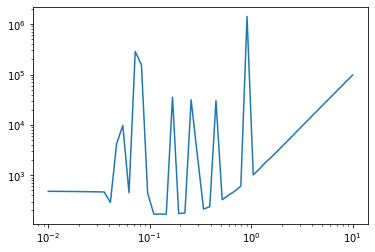

In [38]:
f0 = [(x['f']) for x in profiles[0]]
f0r = [np.exp(-(f0i-min(f0))) for f0i in f0]
plt.loglog(np.logspace(-2, 1, num=50).flatten(), f0)

In [39]:
list(zip(range(50), np.logspace(-2, 1, num=50),f0r))

[(0, 0.01, DM(7.36742e-136)),
 (1, 0.011513953993264475, DM(1.84949e-135)),
 (2, 0.013257113655901088, DM(5.29193e-135)),
 (3, 0.015264179671752334, DM(1.75634e-134)),
 (4, 0.017575106248547922, DM(6.88195e-134)),
 (5, 0.020235896477251575, DM(3.25323e-133)),
 (6, 0.023299518105153717, DM(1.89358e-132)),
 (7, 0.02682695795279726, DM(1.38918e-131)),
 (8, 0.030888435964774818, DM(1.31539e-130)),
 (9, 0.03556480306223128, DM(1.6441e-129)),
 (10, 0.040949150623804255, DM(9.3578e-53)),
 (11, 0.04714866363457394, DM(0)),
 (12, 0.054286754393238594, DM(0)),
 (13, 0.06250551925273973, DM(9.41405e-124)),
 (14, 0.07196856730011521, DM(0)),
 (15, 0.08286427728546843, DM(0)),
 (16, 0.09540954763499938, DM(4.97507e-118)),
 (17, 0.10985411419875583, DM(0.741776)),
 (18, 0.12648552168552957, DM(1)),
 (19, 0.14563484775012436, DM(0.743104)),
 (20, 0.16768329368110083, DM(0)),
 (21, 0.19306977288832497, DM(0.0159692)),
 (22, 0.22229964825261944, DM(0.00016361)),
 (23, 0.2559547922699536, DM(0)),
 (24, 

In [40]:
a0 = linterp(0.011513953993264475, 0.013257113655901088, 0.145754, 0.152931, 0.15)
a1 = linterp( 0.2559547922699536, 0.29470517025518095, 0.314558, 0.115928,  0.15)
a0idx = [1, 2]
a1idx = [23, 24]

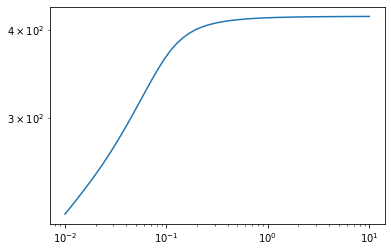

In [41]:
f1 = [(x['f']) for x in profiles[1]]
f1r = [np.exp(-(f1i-min(f1))) for f1i in f1]
plt.loglog(np.logspace(-2, 1, num=50).flatten(), f1)

In [42]:
list(zip(range(50), np.logspace(-2, 1, num=50),f1r))

[(0, 0.01, DM(1)),
 (1, 0.011513953993264475, DM(0.00385454)),
 (2, 0.013257113655901088, DM(1.14627e-05)),
 (3, 0.015264179671752334, DM(2.53333e-08)),
 (4, 0.017575106248547922, DM(3.92449e-11)),
 (5, 0.020235896477251575, DM(3.9583e-14)),
 (6, 0.023299518105153717, DM(2.39725e-17)),
 (7, 0.02682695795279726, DM(8.05408e-21)),
 (8, 0.030888435964774818, DM(1.40157e-24)),
 (9, 0.03556480306223128, DM(1.20134e-28)),
 (10, 0.040949150623804255, DM(4.94611e-33)),
 (11, 0.04714866363457394, DM(9.87642e-38)),
 (12, 0.054286754393238594, DM(1.01788e-42)),
 (13, 0.06250551925273973, DM(6.24309e-48)),
 (14, 0.07196856730011521, DM(2.94562e-53)),
 (15, 0.08286427728546843, DM(1.59196e-58)),
 (16, 0.09540954763499938, DM(1.65866e-63)),
 (17, 0.10985411419875583, DM(5.63056e-68)),
 (18, 0.12648552168552957, DM(8.79635e-72)),
 (19, 0.14563484775012436, DM(6.7874e-75)),
 (20, 0.16768329368110083, DM(2.24112e-77)),
 (21, 0.19306977288832497, DM(2.49659e-79)),
 (22, 0.22229964825261944, DM(7.34368e-

In [43]:
b0 = linterp(0.6866488450043002, 0.7906043210907697,0.105638 , 0.158776, 0.15)
b1 = linterp(2.8117686979742306,2.8117686979742308, 0.149, 0.151, 0.15)
b0idx = [30, 31]
b1idx = [40, 40]

In [44]:
r0int = [b0/a0, b0/a1, b1/a0, b1/a1]
r0int

[61.651772808241006, 2.6849982819238467, 224.13053183340259, 9.761115787718639]

In [45]:
def gets0(pdx, idx):
    return float(getx(profiles[pdx][idx]['x'])[0][0])
def means0(pdx, idxs):
    return np.mean([gets0(pdx, idx) for idx in idxs])
s0 = [means0(0, a0idx), means0(0, a1idx), means0(1,b0idx), means0(1,b1idx)]
def crossmean(axs, bxs):
    s = []
    for a in axs:
        for b in bxs:
            s.append(np.mean([a, b]))
    return s
s0mean = crossmean(s0[2:], s0[:2])

In [46]:
def rinft(r0,s0):
    f = lambda y: y/s0 - np.exp(r0*(y-s0)/s0) 
    sinf = brentq(f, 0, s0-1) 
    return s0-sinf
[rinft(r0x, s0x) for r0x, s0x in zip(r0int, s0mean)]

[4683.018038191165, 4363.460398567875, 4673.773592583283, 4764.110263409956]

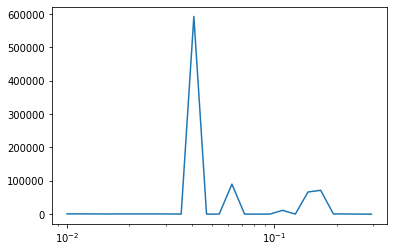

In [47]:
f2 = [(x['f']) for x in profiles[2]]
plt.semilogx(np.logspace(-2, 1, num=50).flatten()[:25], f2[:25])

In [48]:
def mod_seir(t, y, p):
    for i, yi in enumerate(y):
        if yi < 0:
            y[i] = 0 
    return seir(t, y, p)

In [64]:
from scipy.integrate import solve_ivp
tidx = 45
print(model.observation_times[tidx])
sol = solve_ivp(lambda t,y: mod_seir(t, y, getp(sols[idx]['x'])), [0, 150], [getx(sols[idx]['x'])[i][tidx] for i in range(5)], dense_output=True)
# solb = solve_ivp(lambda t,y: np.array(mod_seir(t, y, getp(sols[idx]['x']))), [0, -20], [getx(sols[idx]['x'])[i][tidx] for i in range(5)], method='BDF', dense_output=True)

77.0909090909091


In [65]:
[getx(sols[idx]['x'])[i][tidx] for i in range(5)]

[DM(4151.47), DM(148.882), DM(90.1865), DM(210.59), DM(770.262)]

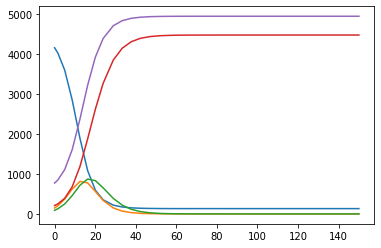

In [66]:
plt.plot(sol.t, sol.y[:,:].T)

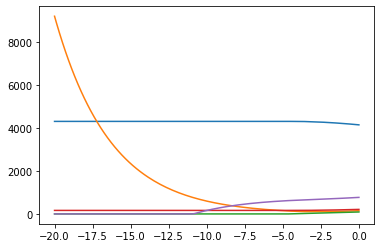

In [67]:
plt.plot(solb.t, solb.y.T)

In [68]:
model.observation_times[-1]

130.0

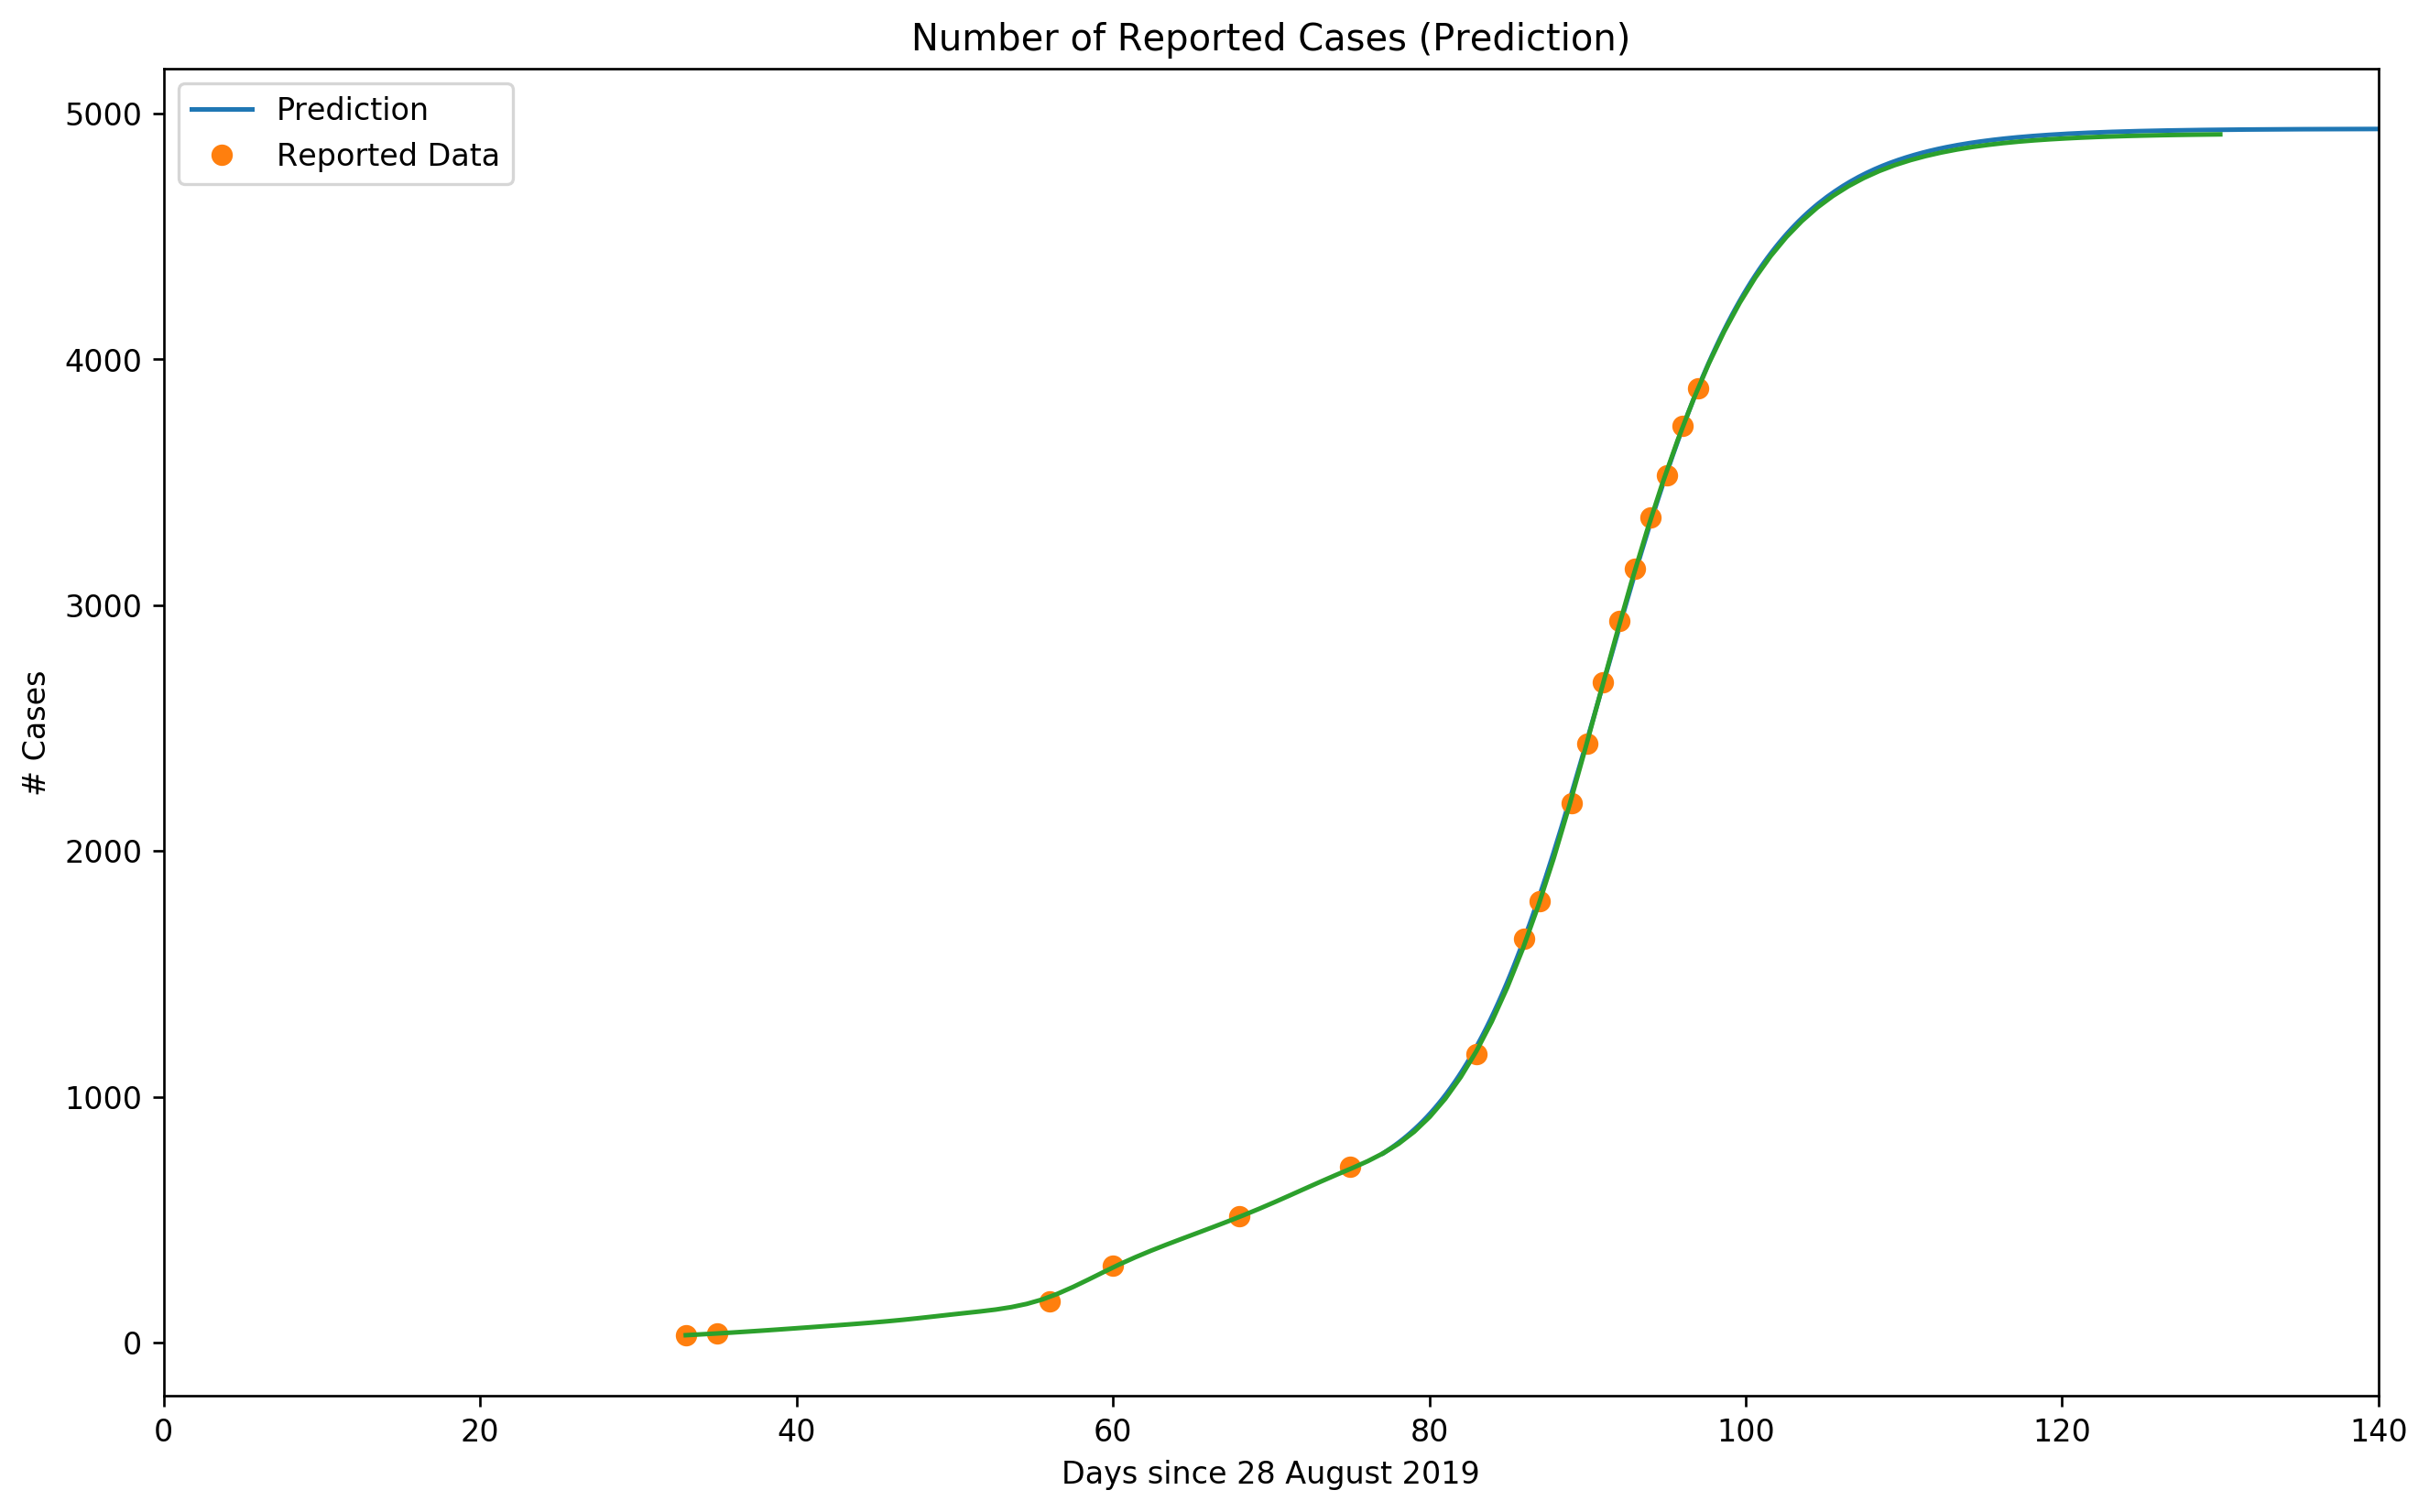

In [79]:
tfine = np.linspace(0, 150, 600)
# tbfine = np.linspace(0, -20, 20)
plt.figure(figsize=[13, 8], dpi=240)
# plt.plot(tbfine+model.observation_times[tidx], solb.sol(tbfine)[-1,:].T)
plt.plot(tfine+model.observation_times[tidx], sol.sol(tfine)[-1,:].T)
plt.plot(additional_times, additional_cumdata, 'o')
plt.xlim(0, 140)
plt.legend(["Prediction", "Reported Data"])
plt.xlabel("Days since 28 August 2019")
plt.ylabel("# Cases")
plt.title("Number of Reported Cases (Prediction)")

plt.plot(model.observation_times, getx(sols[idx]['x'])[4], label='Prediction')


In [70]:
rfin = sol.sol(tfine)[-1,-1]
rfin

4938.134790498894

In [71]:
ridx = np.argmin(np.abs(((1-(sol.sol(tfine)[-1,:])/rfin)*100) - 5))

In [72]:
tfine[ridx]

28.797996661101838

In [73]:
tfine[ridx]-(model.observation_times[-1]-model.observation_times[tidx])

-24.11109424798907

In [74]:
model.observation_times[-1]-model.observation_times[tidx]

52.90909090909091

In [75]:
historical_mortality = 0.02
current_mortality = 55/3881
print(historical_mortality, current_mortality)

0.02 0.014171605256377222


In [76]:
rfin*historical_mortality

98.76269580997788

In [77]:
rfin*current_mortality

69.98129695373336